In [17]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
from keras.losses import mean_squared_error
import random

seed = 7

In [18]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1, color="black")
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2, linestyle='dashed', color="grey")   
    plt.legend()
    plt.show()

def set_random_seeds():
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

In [19]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global x_scaler
    global y_scaler
    
    # x_scaler = MinMaxScaler()
    # y_scaler = MinMaxScaler()
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    # scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [20]:
train_acc = []
train_loss = []
test_acc = []
test_loss = []

def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def mee(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1)))
    
    
def mse(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1))


def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("hidden_layers")
    keys.remove("trials_final")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_final"] = params["trials_final"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    
    lr_decay = config["learning_rate_decay"]
    early_stopping = config["early_stopping"]
    
    callbacks = []
    
    if early_stopping != None:
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"], 
            patience=early_stopping["patience"], 
            min_delta=early_stopping["delta"], 
        )
        callbacks.append(early_stop)

    if lr_decay != None:
        decay_epochs = lr_decay["epochs"]
        lr_final = lr_decay["lr_final"]
        linear_scheduler = get_linear_scheduler(decay_epochs, lr_final)
        scheduler = LearningRateScheduler(linear_scheduler)
        callbacks.append(scheduler)
        
    return callbacks if callbacks != [] else None



def get_layers_configurations(params, configurations):
    
    layers_list = params["hidden_layers"]
        
    layers_params_confs = []
    
    for layers in layers_list:
        
        layers_conf = {}
        
        for i in range(len(layers)):
            
            units, activation = layers[i]
            
            layers_conf[f"units_{i+1}"] = units
            layers_conf[f"activations_{i+1}"] = activation
            
        layers_params_confs.append(layers_conf)
        
    
    new_configurations = []
    
    
    for conf in configurations:
        
        for layers_conf in layers_params_confs:
            
            new_conf = conf
            new_conf.update(layers_conf)
            new_configurations.append(new_conf)
            
    
    
    
    '''layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))'''
                
    return new_configurations



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    return layers_confs
    
    '''configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged'''

            

def get_linear_scheduler(epochs, lr_final):
    
    def linear_scheduler(epoch, lr):
        if (epoch < epochs):
            alpha = epoch/epochs
            return (1-alpha)*lr + alpha*lr_final
        else:
            return lr_final
        
    return linear_scheduler
    

def get_model(config, input_size, output_size):
    
    lr = config["learning_rate"]
    momentum = config["momentum"]
    init_method = config["initialization"]["type"]
    task = config["task"]
    nesterov = config["nesterov"]
    
    reg_method = config["regularization"]["method"]
    
    if reg_method == "l1":
        reg_value = config["regularization"]["value"]
        reg = l1(reg_value)
    elif reg_method == "l2":
        reg_value = config["regularization"]["value"]
        reg = l2(reg_value)
    else:
        reg = None
    
    
    init = None
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    if init_method == "normal":
        mean = config["initialization"]["mean"]
        std = config["initialization"]["std"]
        init = initializers.RandomNormal(mean=mean, stddev=std, seed=None)
        
    
    if momentum != None:
        optimizer = SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov)
    else:
        optimizer = SGD(learning_rate=lr)
    
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1

    model = Sequential()
    model.add(Input(input_size))
    
    for l in range(1,n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        
        if init != None:
            model.add(Dense(n_units, activation=activation,
                            kernel_regularizer=reg, bias_regularizer=reg,
                            kernel_initializer = init, bias_initializer=init))
        else:
            model.add(Dense(n_units, activation=activation,
                            kernel_regularizer=reg, bias_regularizer=reg))

        
        
    if task == "classification":
        
        if init != None:
            model.add(Dense(output_size, activation="sigmoid",
                            kernel_regularizer=reg, bias_regularizer=reg,
                            kernel_initializer = init, bias_initializer=init))
        else:
            model.add(Dense(output_size, activation="sigmoid",
                            kernel_regularizer=reg, bias_regularizer=reg))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
        
    elif task == "regression":
        
        if init != None:
            model.add(Dense(output_size, activation="linear",
                            kernel_regularizer=reg, bias_regularizer=reg,
                            kernel_initializer = init, bias_initializer = init))
        else:
            model.add(Dense(output_size, activation="linear",
                            kernel_regularizer=reg, bias_regularizer=reg))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = [mee])
        
    return model
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    callbacks = get_callbacks(config)

    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                model = get_model(config, input_size, output_size)
                history = model.fit(x_train_fold, y_train_fold, epochs=max_epochs,
                                    validation_data=(x_val_fold, y_val_fold),
                                    callbacks=callbacks, verbose = 0)

                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]

    
    callbacks = get_callbacks(config)
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
        
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True, stratify=stratify)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size,
                                verbose=0, validation_data=(x_val, y_val), callbacks=callbacks)
            

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"\nMedian val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    

def fit_final_model(x_train, y_train, config):
    global y_scaler
    
    task = config["task"]
    trails = config["trials_final"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    val_loss = "val_mse"
    train_loss = "mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_final"]
    
    '''if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"'''
        
    callbacks = get_callbacks(config)
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    
    trials_history_val_loss = []
    trials_history_train_loss = []
    trials_history_val_acc = []
    trials_history_train_acc = []
    
    models = []
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=stratify)
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, validation_data=(x_val, y_val),
                                batch_size=batch_size, verbose=0, callbacks=callbacks)

            models.append(model)
            
            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]

            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            

            trials_history_val_loss.append(trial_val_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_val_acc.append(trial_val_acc)
            trials_history_train_acc.append(trial_train_acc)
            

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    # get the mean metrics among the trials
    med_idx = median_index(trials_val_loss)
    
    med_model = models[med_idx]
    
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric}: {std_train_acc}")
        
    train_acc = trials_history_train_acc[med_idx]
    val_acc = trials_history_val_acc[med_idx]
    
    train_loss = trials_history_train_loss[med_idx]
    val_loss = trials_history_val_loss[med_idx]
    
    if task == "regression":
        
        y_pred = med_model.predict(x_train)
        y_pred = y_scaler.inverse_transform(y_pred)
        y_train = y_scaler.inverse_transform(y_train)


        mse_train = mse(y_train, y_pred)
        mee_train = mee(y_train, y_pred)

        print(f"\nTraining MSE: {mse_train}")
        print(f"Training MEE: {mee_train}")
        
    
        y_pred = med_model.predict(x_val)
        y_pred = y_scaler.inverse_transform(y_pred)
        y_val = y_scaler.inverse_transform(y_val)


        mse_val = mse(y_val, y_pred)
        mee_val = mee(y_val, y_pred)

        print(f"\nValidation MSE: {mse_val}")
        print(f"Validation MEE: {mee_val}")
    
    
    print(f"\nMedian model train_loss: {train_loss[-1]}")
    print(f"Median model val_loss: {val_loss[-1]}")
    
    print(f"\nMedian model train_{train_metric}: {train_acc[-1]}")
    print(f"Median model {val_metric}: {val_acc[-1]}")
    
    
    plot_curves(train_acc, f"Training {train_metric}", val_acc, f"Validation {val_metric}")
    plot_curves(train_loss, "Train loss", val_loss, "Validation loss")
    
    
    return med_model    
    

def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss


    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}):
    set_random_seeds()
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, best_conf)
        
    return model

# ML Cup

In [21]:
x_train, y_train, _, _ = load_dataset("cup", True)
print(x_train.shape, y_train.shape)
#print(x_test_blind.shape)

(1194, 9) (1194, 2)


In [22]:
params = {
    "task": "regression",
    "trials_train": 1,
    "trials_final": 5,
    "initialization": {
        "type": "default",
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.01
    },
    "max_epochs": [500],
    "learning_rate": [0.1, 0.2, 0.3],
    "batch_size": [16],
    "nesterov": False,
    "momentum": [0.1, 0.2, 0.3, 0.4],
    "learning_rate_decay": {
        "epochs": 100,
        "lr_final": 0.01
    },
    "regularization": [
        {
            "type": "l1",
            "value": [0.001, 0.0001, 0.00001]
        }
    ],
    "hidden_layers": [ 
        [(10, "tanh"), (10, "relu"), (10, "tanh")],
        [(25, "tanh"), (25, "relu"), (25, "tanh")],
        [(50, "tanh"), (50, "relu"), (50, "tanh")],
        [(30, "tanh"), (30, "relu")],
        [(50, "tanh"), (50, "relu")]
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activations_2': 'relu', 'units_3': 50, 'activations_3': 'tanh'}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:32<00:00, 32.58s/it]


Fold 1/4 median val_loss: 0.24098503589630127, std val_loss 0.0
Fold 1/4 median train_loss: 0.23843544721603394, std train_loss 0.0
Fold 1/4 median val_mee: 0.3083305358886719, std val_mee 0.0
Fold 1/4 median train_mee: 0.309668630361557, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:30<00:00, 30.69s/it]


Fold 2/4 median val_loss: 0.2297932356595993, std val_loss 0.0
Fold 2/4 median train_loss: 0.23939137160778046, std train_loss 0.0
Fold 2/4 median val_mee: 0.3088650405406952, std val_mee 0.0
Fold 2/4 median train_mee: 0.31668567657470703, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.91s/it]


Fold 3/4 median val_loss: 0.2629565894603729, std val_loss 0.0
Fold 3/4 median train_loss: 0.24040384590625763, std train_loss 0.0
Fold 3/4 median val_mee: 0.32997310161590576, std val_mee 0.0
Fold 3/4 median train_mee: 0.3066982328891754, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.73s/it]


Fold 4/4 median val_loss: 0.23247624933719635, std val_loss 0.0
Fold 4/4 median train_loss: 0.22251829504966736, std train_loss 0.0
Fold 4/4 median val_mee: 0.32724839448928833, std val_mee 0.0
Fold 4/4 median train_mee: 0.30837035179138184, train_mee 0.0

Mean val_loss: 0.24155277758836746, std val_loss: 0.013029924066834349
Mean train_loss: 0.23518723994493484, std train_loss: 0.007347460718329744
Mean val_mee: 0.3186042681336403, std val_mee: 0.010054519177319924
Mean train_mee: 0.3186042681336403, std train_mee: 0.0038032664020069126



Testing configuration 2/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:29<00:00, 29.61s/it]


Fold 1/4 median val_loss: 0.24699100852012634, std val_loss 0.0
Fold 1/4 median train_loss: 0.222166046500206, std train_loss 0.0
Fold 1/4 median val_mee: 0.3347041606903076, std val_mee 0.0
Fold 1/4 median train_mee: 0.3036710321903229, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.74s/it]


Fold 2/4 median val_loss: 0.23056045174598694, std val_loss 0.0
Fold 2/4 median train_loss: 0.2317037582397461, std train_loss 0.0
Fold 2/4 median val_mee: 0.30144333839416504, std val_mee 0.0
Fold 2/4 median train_mee: 0.3163611590862274, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.04s/it]


Fold 3/4 median val_loss: 0.2412613481283188, std val_loss 0.0
Fold 3/4 median train_loss: 0.23721647262573242, std train_loss 0.0
Fold 3/4 median val_mee: 0.3219316005706787, std val_mee 0.0
Fold 3/4 median train_mee: 0.3113800585269928, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:29<00:00, 29.00s/it]


Fold 4/4 median val_loss: 0.23007908463478088, std val_loss 0.0
Fold 4/4 median train_loss: 0.22653326392173767, std train_loss 0.0
Fold 4/4 median val_mee: 0.3135540783405304, std val_mee 0.0
Fold 4/4 median train_mee: 0.3101375997066498, train_mee 0.0

Mean val_loss: 0.23722297325730324, std val_loss: 0.007196306726967004
Mean train_loss: 0.22940488532185555, std train_loss: 0.005633664656556525
Mean val_mee: 0.31790829449892044, std val_mee: 0.012127882036360851
Mean train_mee: 0.31790829449892044, std train_mee: 0.004523360622848825



Testing configuration 3/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.64s/it]


Fold 1/4 median val_loss: 0.2293887883424759, std val_loss 0.0
Fold 1/4 median train_loss: 0.23492431640625, std train_loss 0.0
Fold 1/4 median val_mee: 0.29506510496139526, std val_mee 0.0
Fold 1/4 median train_mee: 0.31400272250175476, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.33s/it]


Fold 2/4 median val_loss: 0.24160398542881012, std val_loss 0.0
Fold 2/4 median train_loss: 0.23097839951515198, std train_loss 0.0
Fold 2/4 median val_mee: 0.3282558023929596, std val_mee 0.0
Fold 2/4 median train_mee: 0.3058359920978546, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.97s/it]


Fold 3/4 median val_loss: 0.24542582035064697, std val_loss 0.0
Fold 3/4 median train_loss: 0.2402811497449875, std train_loss 0.0
Fold 3/4 median val_mee: 0.3112378716468811, std val_mee 0.0
Fold 3/4 median train_mee: 0.311411589384079, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.15s/it]


Fold 4/4 median val_loss: 0.23719334602355957, std val_loss 0.0
Fold 4/4 median train_loss: 0.22744090855121613, std train_loss 0.0
Fold 4/4 median val_mee: 0.3326602876186371, std val_mee 0.0
Fold 4/4 median train_mee: 0.3094407916069031, train_mee 0.0

Mean val_loss: 0.23840298503637314, std val_loss: 0.005964176136344861
Mean train_loss: 0.2334061935544014, std train_loss: 0.004770967634611062
Mean val_mee: 0.31680476665496826, std val_mee: 0.014883942480775778
Mean train_mee: 0.31680476665496826, std train_mee: 0.0029810503422662915



Testing configuration 4/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.58s/it]


Fold 1/4 median val_loss: 0.2277812957763672, std val_loss 0.0
Fold 1/4 median train_loss: 0.23095020651817322, std train_loss 0.0
Fold 1/4 median val_mee: 0.3107224106788635, std val_mee 0.0
Fold 1/4 median train_mee: 0.3108186721801758, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.42s/it]


Fold 2/4 median val_loss: 0.24051737785339355, std val_loss 0.0
Fold 2/4 median train_loss: 0.23944327235221863, std train_loss 0.0
Fold 2/4 median val_mee: 0.3139815628528595, std val_mee 0.0
Fold 2/4 median train_mee: 0.307324081659317, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.66s/it]


Fold 3/4 median val_loss: 0.23039363324642181, std val_loss 0.0
Fold 3/4 median train_loss: 0.2316720187664032, std train_loss 0.0
Fold 3/4 median val_mee: 0.2988598346710205, std val_mee 0.0
Fold 3/4 median train_mee: 0.3153117597103119, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.74s/it]


Fold 4/4 median val_loss: 0.25011393427848816, std val_loss 0.0
Fold 4/4 median train_loss: 0.23030225932598114, std train_loss 0.0
Fold 4/4 median val_mee: 0.33385157585144043, std val_mee 0.0
Fold 4/4 median train_mee: 0.3039394021034241, train_mee 0.0

Mean val_loss: 0.23720156028866768, std val_loss: 0.008843264418044216
Mean train_loss: 0.23309193924069405, std train_loss: 0.0036988153349460404
Mean val_mee: 0.314353846013546, std val_mee: 0.01258522718960149
Mean train_mee: 0.314353846013546, std train_mee: 0.004215402776812941



Testing configuration 5/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2'

100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.44s/it]


Fold 1/4 median val_loss: 0.2478993684053421, std val_loss 0.0
Fold 1/4 median train_loss: 0.23749910295009613, std train_loss 0.0
Fold 1/4 median val_mee: 0.32353711128234863, std val_mee 0.0
Fold 1/4 median train_mee: 0.30803999304771423, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.34s/it]


Fold 2/4 median val_loss: 0.23856554925441742, std val_loss 0.0
Fold 2/4 median train_loss: 0.2416992038488388, std train_loss 0.0
Fold 2/4 median val_mee: 0.3130180835723877, std val_mee 0.0
Fold 2/4 median train_mee: 0.3139806091785431, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:41<00:00, 41.65s/it]


Fold 3/4 median val_loss: 0.2465980052947998, std val_loss 0.0
Fold 3/4 median train_loss: 0.22935828566551208, std train_loss 0.0
Fold 3/4 median val_mee: 0.31468772888183594, std val_mee 0.0
Fold 3/4 median train_mee: 0.30496716499328613, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.95s/it]


Fold 4/4 median val_loss: 0.2361312210559845, std val_loss 0.0
Fold 4/4 median train_loss: 0.2336445152759552, std train_loss 0.0
Fold 4/4 median val_mee: 0.31491392850875854, std val_mee 0.0
Fold 4/4 median train_mee: 0.31055325269699097, train_mee 0.0

Mean val_loss: 0.24229853600263596, std val_loss: 0.0050454366389597214
Mean train_loss: 0.23555027693510056, std train_loss: 0.004571102394700496
Mean val_mee: 0.3165392130613327, std val_mee: 0.004106046636771769
Mean train_mee: 0.3165392130613327, std train_mee: 0.003309484388621674



Testing configuration 6/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


Fold 1/4 median val_loss: 0.15180782973766327, std val_loss 0.0
Fold 1/4 median train_loss: 0.14833496510982513, std train_loss 0.0
Fold 1/4 median val_mee: 0.30459064245224, std val_mee 0.0
Fold 1/4 median train_mee: 0.3009890615940094, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/it]


Fold 2/4 median val_loss: 0.17282678186893463, std val_loss 0.0
Fold 2/4 median train_loss: 0.13983507454395294, std train_loss 0.0
Fold 2/4 median val_mee: 0.3366958498954773, std val_mee 0.0
Fold 2/4 median train_mee: 0.28636521100997925, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


Fold 3/4 median val_loss: 0.140389084815979, std val_loss 0.0
Fold 3/4 median train_loss: 0.15164528787136078, std train_loss 0.0
Fold 3/4 median val_mee: 0.2805437445640564, std val_mee 0.0
Fold 3/4 median train_mee: 0.30739614367485046, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.77s/it]


Fold 4/4 median val_loss: 0.16265776753425598, std val_loss 0.0
Fold 4/4 median train_loss: 0.1418895423412323, std train_loss 0.0
Fold 4/4 median val_mee: 0.33431363105773926, std val_mee 0.0
Fold 4/4 median train_mee: 0.29325607419013977, train_mee 0.0

Mean val_loss: 0.15692036598920822, std val_loss: 0.01209703607066265
Mean train_loss: 0.1454262174665928, std train_loss: 0.004767247625076762
Mean val_mee: 0.31403596699237823, std val_mee: 0.023106260363733228
Mean train_mee: 0.31403596699237823, std train_mee: 0.007923195733247276



Testing configuration 7/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


Fold 1/4 median val_loss: 0.1515352725982666, std val_loss 0.0
Fold 1/4 median train_loss: 0.1461225301027298, std train_loss 0.0
Fold 1/4 median val_mee: 0.30659937858581543, std val_mee 0.0
Fold 1/4 median train_mee: 0.30014345049858093, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


Fold 2/4 median val_loss: 0.16535663604736328, std val_loss 0.0
Fold 2/4 median train_loss: 0.14344504475593567, std train_loss 0.0
Fold 2/4 median val_mee: 0.32558149099349976, std val_mee 0.0
Fold 2/4 median train_mee: 0.2930430471897125, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


Fold 3/4 median val_loss: 0.16311664879322052, std val_loss 0.0
Fold 3/4 median train_loss: 0.14272642135620117, std train_loss 0.0
Fold 3/4 median val_mee: 0.32461342215538025, std val_mee 0.0
Fold 3/4 median train_mee: 0.29551777243614197, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.28s/it]


Fold 4/4 median val_loss: 0.143595889210701, std val_loss 0.0
Fold 4/4 median train_loss: 0.14955782890319824, std train_loss 0.0
Fold 4/4 median val_mee: 0.30653461813926697, std val_mee 0.0
Fold 4/4 median train_mee: 0.3021621108055115, train_mee 0.0

Mean val_loss: 0.15590111166238785, std val_loss: 0.008831052709057333
Mean train_loss: 0.14546295627951622, std train_loss: 0.0026815858058232603
Mean val_mee: 0.3158322274684906, std val_mee: 0.00927157695780922
Mean train_mee: 0.3158322274684906, std train_mee: 0.0036169430528561926



Testing configuration 8/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


Fold 1/4 median val_loss: 0.16228817403316498, std val_loss 0.0
Fold 1/4 median train_loss: 0.1434977650642395, std train_loss 0.0
Fold 1/4 median val_mee: 0.32337379455566406, std val_mee 0.0
Fold 1/4 median train_mee: 0.2920648157596588, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Fold 2/4 median val_loss: 0.16421182453632355, std val_loss 0.0
Fold 2/4 median train_loss: 0.14212875068187714, std train_loss 0.0
Fold 2/4 median val_mee: 0.3204577565193176, std val_mee 0.0
Fold 2/4 median train_mee: 0.2901023030281067, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.12s/it]


Fold 3/4 median val_loss: 0.1342482566833496, std val_loss 0.0
Fold 3/4 median train_loss: 0.1526215821504593, std train_loss 0.0
Fold 3/4 median val_mee: 0.2736751437187195, std val_mee 0.0
Fold 3/4 median train_mee: 0.3080981373786926, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]


Fold 4/4 median val_loss: 0.16423380374908447, std val_loss 0.0
Fold 4/4 median train_loss: 0.14387008547782898, std train_loss 0.0
Fold 4/4 median val_mee: 0.31829601526260376, std val_mee 0.0
Fold 4/4 median train_mee: 0.29576125741004944, train_mee 0.0

Mean val_loss: 0.15624551475048065, std val_loss: 0.012724660569223487
Mean train_loss: 0.14552954584360123, std train_loss: 0.004145609983788623
Mean val_mee: 0.30895067751407623, std val_mee: 0.020445890752236857
Mean train_mee: 0.30895067751407623, std train_mee: 0.00699399280305504



Testing configuration 9/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/it]


Fold 1/4 median val_loss: 0.15804028511047363, std val_loss 0.0
Fold 1/4 median train_loss: 0.14477726817131042, std train_loss 0.0
Fold 1/4 median val_mee: 0.3267987370491028, std val_mee 0.0
Fold 1/4 median train_mee: 0.29872292280197144, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]


Fold 2/4 median val_loss: 0.14375269412994385, std val_loss 0.0
Fold 2/4 median train_loss: 0.15101473033428192, std train_loss 0.0
Fold 2/4 median val_mee: 0.29166942834854126, std val_mee 0.0
Fold 2/4 median train_mee: 0.30898165702819824, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]


Fold 3/4 median val_loss: 0.15722006559371948, std val_loss 0.0
Fold 3/4 median train_loss: 0.14563317596912384, std train_loss 0.0
Fold 3/4 median val_mee: 0.3164195418357849, std val_mee 0.0
Fold 3/4 median train_mee: 0.29481884837150574, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


Fold 4/4 median val_loss: 0.16578343510627747, std val_loss 0.0
Fold 4/4 median train_loss: 0.1441480666399002, std train_loss 0.0
Fold 4/4 median val_mee: 0.325339138507843, std val_mee 0.0
Fold 4/4 median train_mee: 0.29109087586402893, train_mee 0.0

Mean val_loss: 0.1561991199851036, std val_loss: 0.007924721317885287
Mean train_loss: 0.1463933102786541, std train_loss: 0.002719744408448922
Mean val_mee: 0.315056711435318, std val_mee: 0.014075029208655693
Mean train_mee: 0.315056711435318, std train_mee: 0.006676893665249177



Testing configuration 10/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.40s/it]


Fold 1/4 median val_loss: 0.14657960832118988, std val_loss 0.0
Fold 1/4 median train_loss: 0.14539098739624023, std train_loss 0.0
Fold 1/4 median val_mee: 0.2883090376853943, std val_mee 0.0
Fold 1/4 median train_mee: 0.2971859574317932, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


Fold 2/4 median val_loss: 0.16575907170772552, std val_loss 0.0
Fold 2/4 median train_loss: 0.1409861445426941, std train_loss 0.0
Fold 2/4 median val_mee: 0.34089964628219604, std val_mee 0.0
Fold 2/4 median train_mee: 0.29021334648132324, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


Fold 3/4 median val_loss: 0.14951427280902863, std val_loss 0.0
Fold 3/4 median train_loss: 0.14837317168712616, std train_loss 0.0
Fold 3/4 median val_mee: 0.30033138394355774, std val_mee 0.0
Fold 3/4 median train_mee: 0.3028065860271454, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/it]


Fold 4/4 median val_loss: 0.15908929705619812, std val_loss 0.0
Fold 4/4 median train_loss: 0.14195020496845245, std train_loss 0.0
Fold 4/4 median val_mee: 0.3158831000328064, std val_mee 0.0
Fold 4/4 median train_mee: 0.2918146252632141, train_mee 0.0

Mean val_loss: 0.15523556247353554, std val_loss: 0.007636331163399004
Mean train_loss: 0.14417512714862823, std train_loss: 0.002924969352733633
Mean val_mee: 0.3113557919859886, std val_mee: 0.019659770479994756
Mean train_mee: 0.3113557919859886, std train_mee: 0.004943663595770311



Testing configuration 11/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.96s/it]


Fold 1/4 median val_loss: 0.09288346767425537, std val_loss 0.0
Fold 1/4 median train_loss: 0.08294399827718735, std train_loss 0.0
Fold 1/4 median val_mee: 0.30280154943466187, std val_mee 0.0
Fold 1/4 median train_mee: 0.2971668839454651, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


Fold 2/4 median val_loss: 0.09845254570245743, std val_loss 0.0
Fold 2/4 median train_loss: 0.08462287485599518, std train_loss 0.0
Fold 2/4 median val_mee: 0.3148658871650696, std val_mee 0.0
Fold 2/4 median train_mee: 0.29883918166160583, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]


Fold 3/4 median val_loss: 0.10229823738336563, std val_loss 0.0
Fold 3/4 median train_loss: 0.08037014305591583, std train_loss 0.0
Fold 3/4 median val_mee: 0.32138362526893616, std val_mee 0.0
Fold 3/4 median train_mee: 0.28647375106811523, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]


Fold 4/4 median val_loss: 0.08100514113903046, std val_loss 0.0
Fold 4/4 median train_loss: 0.08721768110990524, std train_loss 0.0
Fold 4/4 median val_mee: 0.2963624894618988, std val_mee 0.0
Fold 4/4 median train_mee: 0.30040186643600464, train_mee 0.0

Mean val_loss: 0.09365984797477722, std val_loss: 0.008036418582818122
Mean train_loss: 0.0837886743247509, std train_loss: 0.0024926798691515444
Mean val_mee: 0.3088533878326416, std val_mee: 0.009820950673634548
Mean train_mee: 0.3088533878326416, std train_mee: 0.00545975638917374



Testing configuration 12/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


Fold 1/4 median val_loss: 0.09704744070768356, std val_loss 0.0
Fold 1/4 median train_loss: 0.08272125571966171, std train_loss 0.0
Fold 1/4 median val_mee: 0.314818799495697, std val_mee 0.0
Fold 1/4 median train_mee: 0.29660749435424805, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


Fold 2/4 median val_loss: 0.09245985001325607, std val_loss 0.0
Fold 2/4 median train_loss: 0.08485792577266693, std train_loss 0.0
Fold 2/4 median val_mee: 0.31055861711502075, std val_mee 0.0
Fold 2/4 median train_mee: 0.29669293761253357, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Fold 3/4 median val_loss: 0.08664753288030624, std val_loss 0.0
Fold 3/4 median train_loss: 0.08615071326494217, std train_loss 0.0
Fold 3/4 median val_mee: 0.3009549081325531, std val_mee 0.0
Fold 3/4 median train_mee: 0.30305740237236023, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


Fold 4/4 median val_loss: 0.0964602679014206, std val_loss 0.0
Fold 4/4 median train_loss: 0.08402852714061737, std train_loss 0.0
Fold 4/4 median val_mee: 0.31371819972991943, std val_mee 0.0
Fold 4/4 median train_mee: 0.2930681109428406, train_mee 0.0

Mean val_loss: 0.09315377287566662, std val_loss: 0.004150489319273762
Mean train_loss: 0.08443960547447205, std train_loss: 0.0012474567145707776
Mean val_mee: 0.3100126311182976, std val_mee: 0.005458272153402878
Mean train_mee: 0.3100126311182976, std train_mee: 0.0036018013917839473



Testing configuration 13/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.40s/it]


Fold 1/4 median val_loss: 0.09660488367080688, std val_loss 0.0
Fold 1/4 median train_loss: 0.0829620212316513, std train_loss 0.0
Fold 1/4 median val_mee: 0.32503122091293335, std val_mee 0.0
Fold 1/4 median train_mee: 0.2945302426815033, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]


Fold 2/4 median val_loss: 0.10686874389648438, std val_loss 0.0
Fold 2/4 median train_loss: 0.08173897117376328, std train_loss 0.0
Fold 2/4 median val_mee: 0.3262353241443634, std val_mee 0.0
Fold 2/4 median train_mee: 0.29571297764778137, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


Fold 3/4 median val_loss: 0.08721881359815598, std val_loss 0.0
Fold 3/4 median train_loss: 0.08660538494586945, std train_loss 0.0
Fold 3/4 median val_mee: 0.30278071761131287, std val_mee 0.0
Fold 3/4 median train_mee: 0.29884982109069824, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


Fold 4/4 median val_loss: 0.07771287113428116, std val_loss 0.0
Fold 4/4 median train_loss: 0.0876571387052536, std train_loss 0.0
Fold 4/4 median val_mee: 0.2817646861076355, std val_mee 0.0
Fold 4/4 median train_mee: 0.3025190830230713, train_mee 0.0

Mean val_loss: 0.0921013280749321, std val_loss: 0.010830803568995495
Mean train_loss: 0.08474087901413441, std train_loss: 0.0024574752617220856
Mean val_mee: 0.3089529871940613, std val_mee: 0.018265331900561753
Mean train_mee: 0.3089529871940613, std train_mee: 0.0030974337152914486



Testing configuration 14/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.20s/it]


Fold 1/4 median val_loss: 0.0912262424826622, std val_loss 0.0
Fold 1/4 median train_loss: 0.08722672611474991, std train_loss 0.0
Fold 1/4 median val_mee: 0.30636751651763916, std val_mee 0.0
Fold 1/4 median train_mee: 0.3043159544467926, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.20s/it]


Fold 2/4 median val_loss: 0.08860300481319427, std val_loss 0.0
Fold 2/4 median train_loss: 0.08581347018480301, std train_loss 0.0
Fold 2/4 median val_mee: 0.3060595393180847, std val_mee 0.0
Fold 2/4 median train_mee: 0.30222204327583313, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


Fold 3/4 median val_loss: 0.10379645973443985, std val_loss 0.0
Fold 3/4 median train_loss: 0.0801621675491333, std train_loss 0.0
Fold 3/4 median val_mee: 0.32506585121154785, std val_mee 0.0
Fold 3/4 median train_mee: 0.2937108874320984, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.18s/it]


Fold 4/4 median val_loss: 0.08862185478210449, std val_loss 0.0
Fold 4/4 median train_loss: 0.08556313812732697, std train_loss 0.0
Fold 4/4 median val_mee: 0.31003427505493164, std val_mee 0.0
Fold 4/4 median train_mee: 0.2958807647228241, train_mee 0.0

Mean val_loss: 0.0930618904531002, std val_loss: 0.0062888027285948386
Mean train_loss: 0.0846913754940033, std train_loss: 0.002690761693367421
Mean val_mee: 0.31188179552555084, std val_mee: 0.007770756020865993
Mean train_mee: 0.31188179552555084, std train_mee: 0.004368668926267527



Testing configuration 15/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.18s/it]


Fold 1/4 median val_loss: 0.10818152129650116, std val_loss 0.0
Fold 1/4 median train_loss: 0.08193662762641907, std train_loss 0.0
Fold 1/4 median val_mee: 0.3250945508480072, std val_mee 0.0
Fold 1/4 median train_mee: 0.2958511412143707, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


Fold 2/4 median val_loss: 0.08811359852552414, std val_loss 0.0
Fold 2/4 median train_loss: 0.08677499741315842, std train_loss 0.0
Fold 2/4 median val_mee: 0.3159644305706024, std val_mee 0.0
Fold 2/4 median train_mee: 0.2967209219932556, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


Fold 3/4 median val_loss: 0.09165102988481522, std val_loss 0.0
Fold 3/4 median train_loss: 0.08220230787992477, std train_loss 0.0
Fold 3/4 median val_mee: 0.3080539107322693, std val_mee 0.0
Fold 3/4 median train_mee: 0.29181796312332153, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


Fold 4/4 median val_loss: 0.0842769593000412, std val_loss 0.0
Fold 4/4 median train_loss: 0.08784365653991699, std train_loss 0.0
Fold 4/4 median val_mee: 0.2928915321826935, std val_mee 0.0
Fold 4/4 median train_mee: 0.304076224565506, train_mee 0.0

Mean val_loss: 0.09305577725172043, std val_loss: 0.009113920990213811
Mean train_loss: 0.08468939736485481, std train_loss: 0.002648699390448315
Mean val_mee: 0.3105011060833931, std val_mee: 0.011820558389952935
Mean train_mee: 0.3105011060833931, std train_mee: 0.004423513136108019



Testing configuration 16/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2'

100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.35s/it]


Fold 1/4 median val_loss: 0.24245093762874603, std val_loss 0.0
Fold 1/4 median train_loss: 0.21972723305225372, std train_loss 0.0
Fold 1/4 median val_mee: 0.3360584080219269, std val_mee 0.0
Fold 1/4 median train_mee: 0.3053893446922302, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.71s/it]


Fold 2/4 median val_loss: 0.22748632729053497, std val_loss 0.0
Fold 2/4 median train_loss: 0.21496179699897766, std train_loss 0.0
Fold 2/4 median val_mee: 0.31391167640686035, std val_mee 0.0
Fold 2/4 median train_mee: 0.30499038100242615, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.91s/it]


Fold 3/4 median val_loss: 0.20656177401542664, std val_loss 0.0
Fold 3/4 median train_loss: 0.2223118096590042, std train_loss 0.0
Fold 3/4 median val_mee: 0.28394168615341187, std val_mee 0.0
Fold 3/4 median train_mee: 0.31813034415245056, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.82s/it]


Fold 4/4 median val_loss: 0.22086907923221588, std val_loss 0.0
Fold 4/4 median train_loss: 0.2208874374628067, std train_loss 0.0
Fold 4/4 median val_mee: 0.32210245728492737, std val_mee 0.0
Fold 4/4 median train_mee: 0.3107616901397705, train_mee 0.0

Mean val_loss: 0.22434202954173088, std val_loss: 0.012903662569888154
Mean train_loss: 0.21947206929326057, std train_loss: 0.0027602109118995658
Mean val_mee: 0.3140035569667816, std val_mee: 0.019077035672929687
Mean train_mee: 0.3140035569667816, std train_mee: 0.00531282668160394



Testing configuration 17/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.10s/it]


Fold 1/4 median val_loss: 0.23595765233039856, std val_loss 0.0
Fold 1/4 median train_loss: 0.22740493714809418, std train_loss 0.0
Fold 1/4 median val_mee: 0.3218318819999695, std val_mee 0.0
Fold 1/4 median train_mee: 0.31067800521850586, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.22s/it]


Fold 2/4 median val_loss: 0.21648181974887848, std val_loss 0.0
Fold 2/4 median train_loss: 0.21246370673179626, std train_loss 0.0
Fold 2/4 median val_mee: 0.3210248351097107, std val_mee 0.0
Fold 2/4 median train_mee: 0.312237024307251, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:34<00:00, 34.25s/it]


Fold 3/4 median val_loss: 0.28940221667289734, std val_loss 0.0
Fold 3/4 median train_loss: 0.26476141810417175, std train_loss 0.0
Fold 3/4 median val_mee: 0.3433796763420105, std val_mee 0.0
Fold 3/4 median train_mee: 0.3004164397716522, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.26s/it]


Fold 4/4 median val_loss: 0.20541274547576904, std val_loss 0.0
Fold 4/4 median train_loss: 0.21057195961475372, std train_loss 0.0
Fold 4/4 median val_mee: 0.2891387343406677, std val_mee 0.0
Fold 4/4 median train_mee: 0.31787532567977905, train_mee 0.0

Mean val_loss: 0.23681360855698586, std val_loss: 0.03227107916933345
Mean train_loss: 0.22880050539970398, std train_loss: 0.02176181130692613
Mean val_mee: 0.3188437819480896, std val_mee: 0.019352556044891726
Mean train_mee: 0.3188437819480896, std train_mee: 0.0063040713334968695



Testing configuration 18/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.61s/it]


Fold 1/4 median val_loss: 0.24249298870563507, std val_loss 0.0
Fold 1/4 median train_loss: 0.2320374995470047, std train_loss 0.0
Fold 1/4 median val_mee: 0.31423670053482056, std val_mee 0.0
Fold 1/4 median train_mee: 0.3086419701576233, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.23s/it]


Fold 2/4 median val_loss: 0.23005777597427368, std val_loss 0.0
Fold 2/4 median train_loss: 0.21134065091609955, std train_loss 0.0
Fold 2/4 median val_mee: 0.3294719159603119, std val_mee 0.0
Fold 2/4 median train_mee: 0.30638161301612854, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.88s/it]


Fold 3/4 median val_loss: 0.2172050029039383, std val_loss 0.0
Fold 3/4 median train_loss: 0.22364376485347748, std train_loss 0.0
Fold 3/4 median val_mee: 0.30789729952812195, std val_mee 0.0
Fold 3/4 median train_mee: 0.3126618266105652, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.83s/it]


Fold 4/4 median val_loss: 0.21472829580307007, std val_loss 0.0
Fold 4/4 median train_loss: 0.2228822410106659, std train_loss 0.0
Fold 4/4 median val_mee: 0.3039305806159973, std val_mee 0.0
Fold 4/4 median train_mee: 0.3145606219768524, train_mee 0.0

Mean val_loss: 0.22612101584672928, std val_loss: 0.011099875363982494
Mean train_loss: 0.2224760390818119, std train_loss: 0.007364560056672569
Mean val_mee: 0.3138841241598129, std val_mee: 0.009721351006485307
Mean train_mee: 0.3138841241598129, std train_mee: 0.0032233677446985797



Testing configuration 19/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2

100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.31s/it]


Fold 1/4 median val_loss: 0.2149767428636551, std val_loss 0.0
Fold 1/4 median train_loss: 0.2140531688928604, std train_loss 0.0
Fold 1/4 median val_mee: 0.31209513545036316, std val_mee 0.0
Fold 1/4 median train_mee: 0.3048686981201172, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.18s/it]


Fold 2/4 median val_loss: 0.22659076750278473, std val_loss 0.0
Fold 2/4 median train_loss: 0.21452423930168152, std train_loss 0.0
Fold 2/4 median val_mee: 0.3214440941810608, std val_mee 0.0
Fold 2/4 median train_mee: 0.3120816648006439, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.70s/it]


Fold 3/4 median val_loss: 0.21889328956604004, std val_loss 0.0
Fold 3/4 median train_loss: 0.2186530977487564, std train_loss 0.0
Fold 3/4 median val_mee: 0.32995349168777466, std val_mee 0.0
Fold 3/4 median train_mee: 0.3122401833534241, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:29<00:00, 29.60s/it]


Fold 4/4 median val_loss: 0.2162291258573532, std val_loss 0.0
Fold 4/4 median train_loss: 0.20239484310150146, std train_loss 0.0
Fold 4/4 median val_mee: 0.30726608633995056, std val_mee 0.0
Fold 4/4 median train_mee: 0.30845850706100464, train_mee 0.0

Mean val_loss: 0.21917248144745827, std val_loss: 0.004510445668077553
Mean train_loss: 0.21240633726119995, std train_loss: 0.006050818030950173
Mean val_mee: 0.3176897019147873, std val_mee: 0.008724203924455253
Mean train_mee: 0.3176897019147873, std train_mee: 0.0030280551393371343



Testing configuration 20/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.05s/it]


Fold 1/4 median val_loss: 0.21893174946308136, std val_loss 0.0
Fold 1/4 median train_loss: 0.22290882468223572, std train_loss 0.0
Fold 1/4 median val_mee: 0.29988351464271545, std val_mee 0.0
Fold 1/4 median train_mee: 0.31384605169296265, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:42<00:00, 42.46s/it]


Fold 2/4 median val_loss: 0.22467216849327087, std val_loss 0.0
Fold 2/4 median train_loss: 0.2151450365781784, std train_loss 0.0
Fold 2/4 median val_mee: 0.31072351336479187, std val_mee 0.0
Fold 2/4 median train_mee: 0.3069458603858948, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.57s/it]


Fold 3/4 median val_loss: 0.21718807518482208, std val_loss 0.0
Fold 3/4 median train_loss: 0.21903790533542633, std train_loss 0.0
Fold 3/4 median val_mee: 0.3111826777458191, std val_mee 0.0
Fold 3/4 median train_mee: 0.31297117471694946, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:41<00:00, 41.67s/it]


Fold 4/4 median val_loss: 0.22304973006248474, std val_loss 0.0
Fold 4/4 median train_loss: 0.20971821248531342, std train_loss 0.0
Fold 4/4 median val_mee: 0.33171218633651733, std val_mee 0.0
Fold 4/4 median train_mee: 0.30390119552612305, train_mee 0.0

Mean val_loss: 0.22096043080091476, std val_loss: 0.003020280738854976
Mean train_loss: 0.21670249477028847, std train_loss: 0.0048779746960207725
Mean val_mee: 0.31337547302246094, std val_mee: 0.01151205061266068
Mean train_mee: 0.31337547302246094, std train_mee: 0.004146663820129884



Testing configuration 21/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'u

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Fold 1/4 median val_loss: 0.15675099194049835, std val_loss 0.0
Fold 1/4 median train_loss: 0.1459348350763321, std train_loss 0.0
Fold 1/4 median val_mee: 0.3088330924510956, std val_mee 0.0
Fold 1/4 median train_mee: 0.29731640219688416, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


Fold 2/4 median val_loss: 0.14314931631088257, std val_loss 0.0
Fold 2/4 median train_loss: 0.14821328222751617, std train_loss 0.0
Fold 2/4 median val_mee: 0.30190032720565796, std val_mee 0.0
Fold 2/4 median train_mee: 0.3001483082771301, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.23s/it]


Fold 3/4 median val_loss: 0.1596025675535202, std val_loss 0.0
Fold 3/4 median train_loss: 0.14497897028923035, std train_loss 0.0
Fold 3/4 median val_mee: 0.3146916925907135, std val_mee 0.0
Fold 3/4 median train_mee: 0.29731234908103943, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]


Fold 4/4 median val_loss: 0.16725365817546844, std val_loss 0.0
Fold 4/4 median train_loss: 0.14261852204799652, std train_loss 0.0
Fold 4/4 median val_mee: 0.34048908948898315, std val_mee 0.0
Fold 4/4 median train_mee: 0.28523489832878113, train_mee 0.0

Mean val_loss: 0.1566891334950924, std val_loss: 0.008709588905111618
Mean train_loss: 0.14543640241026878, std train_loss: 0.0020068128041419472
Mean val_mee: 0.31647855043411255, std val_mee: 0.014583179239510106
Mean train_mee: 0.31647855043411255, std train_mee: 0.005757059371505894



Testing configuration 22/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'u

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


Fold 1/4 median val_loss: 0.15057486295700073, std val_loss 0.0
Fold 1/4 median train_loss: 0.14679132401943207, std train_loss 0.0
Fold 1/4 median val_mee: 0.31706929206848145, std val_mee 0.0
Fold 1/4 median train_mee: 0.2965426445007324, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]


Fold 2/4 median val_loss: 0.14635877311229706, std val_loss 0.0
Fold 2/4 median train_loss: 0.1453249603509903, std train_loss 0.0
Fold 2/4 median val_mee: 0.29479169845581055, std val_mee 0.0
Fold 2/4 median train_mee: 0.29934388399124146, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


Fold 3/4 median val_loss: 0.15866121649742126, std val_loss 0.0
Fold 3/4 median train_loss: 0.14293541014194489, std train_loss 0.0
Fold 3/4 median val_mee: 0.31746602058410645, std val_mee 0.0
Fold 3/4 median train_mee: 0.2916412353515625, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.93s/it]


Fold 4/4 median val_loss: 0.16987574100494385, std val_loss 0.0
Fold 4/4 median train_loss: 0.13920240104198456, std train_loss 0.0
Fold 4/4 median val_mee: 0.33073097467422485, std val_mee 0.0
Fold 4/4 median train_mee: 0.29008951783180237, train_mee 0.0

Mean val_loss: 0.15636764839291573, std val_loss: 0.008964694196606237
Mean train_loss: 0.14356352388858795, std train_loss: 0.0028694629923404595
Mean val_mee: 0.3150144964456558, std val_mee: 0.012905438796299837
Mean train_mee: 0.3150144964456558, std train_mee: 0.003715638525849731



Testing configuration 23/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.92s/it]


Fold 1/4 median val_loss: 0.16216032207012177, std val_loss 0.0
Fold 1/4 median train_loss: 0.14360642433166504, std train_loss 0.0
Fold 1/4 median val_mee: 0.318764328956604, std val_mee 0.0
Fold 1/4 median train_mee: 0.2946779429912567, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]


Fold 2/4 median val_loss: 0.1615220159292221, std val_loss 0.0
Fold 2/4 median train_loss: 0.14123433828353882, std train_loss 0.0
Fold 2/4 median val_mee: 0.32173576951026917, std val_mee 0.0
Fold 2/4 median train_mee: 0.2898944914340973, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.18s/it]


Fold 3/4 median val_loss: 0.16108091175556183, std val_loss 0.0
Fold 3/4 median train_loss: 0.14507436752319336, std train_loss 0.0
Fold 3/4 median val_mee: 0.32143718004226685, std val_mee 0.0
Fold 3/4 median train_mee: 0.29566246271133423, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


Fold 4/4 median val_loss: 0.1491599828004837, std val_loss 0.0
Fold 4/4 median train_loss: 0.1504823863506317, std train_loss 0.0
Fold 4/4 median val_mee: 0.3067396581172943, std val_mee 0.0
Fold 4/4 median train_mee: 0.3047884404659271, train_mee 0.0

Mean val_loss: 0.15848080813884735, std val_loss: 0.005395046139761274
Mean train_loss: 0.14509937912225723, std train_loss: 0.0033964999298002705
Mean val_mee: 0.3171692341566086, std val_mee: 0.006131659461352001
Mean train_mee: 0.3171692341566086, std train_mee: 0.0053878075750910075



Testing configuration 24/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]


Fold 1/4 median val_loss: 0.15893131494522095, std val_loss 0.0
Fold 1/4 median train_loss: 0.14379790425300598, std train_loss 0.0
Fold 1/4 median val_mee: 0.30963683128356934, std val_mee 0.0
Fold 1/4 median train_mee: 0.29199519753456116, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]


Fold 2/4 median val_loss: 0.16434049606323242, std val_loss 0.0
Fold 2/4 median train_loss: 0.1406017690896988, std train_loss 0.0
Fold 2/4 median val_mee: 0.33426064252853394, std val_mee 0.0
Fold 2/4 median train_mee: 0.2905837595462799, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]


Fold 3/4 median val_loss: 0.15227608382701874, std val_loss 0.0
Fold 3/4 median train_loss: 0.14546073973178864, std train_loss 0.0
Fold 3/4 median val_mee: 0.2971380054950714, std val_mee 0.0
Fold 3/4 median train_mee: 0.2982335090637207, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]


Fold 4/4 median val_loss: 0.1463974416255951, std val_loss 0.0
Fold 4/4 median train_loss: 0.14810405671596527, std train_loss 0.0
Fold 4/4 median val_mee: 0.2985345721244812, std val_mee 0.0
Fold 4/4 median train_mee: 0.2987271249294281, train_mee 0.0

Mean val_loss: 0.1554863341152668, std val_loss: 0.006767158752415253
Mean train_loss: 0.14449111744761467, std train_loss: 0.0027203433934504958
Mean val_mee: 0.30989251285791397, std val_mee: 0.014879107773020067
Mean train_mee: 0.30989251285791397, std train_mee: 0.0036340770702931614



Testing configuration 25/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


Fold 1/4 median val_loss: 0.1587771475315094, std val_loss 0.0
Fold 1/4 median train_loss: 0.14601166546344757, std train_loss 0.0
Fold 1/4 median val_mee: 0.3254040479660034, std val_mee 0.0
Fold 1/4 median train_mee: 0.2938535511493683, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


Fold 2/4 median val_loss: 0.14572347700595856, std val_loss 0.0
Fold 2/4 median train_loss: 0.14676758646965027, std train_loss 0.0
Fold 2/4 median val_mee: 0.296626478433609, std val_mee 0.0
Fold 2/4 median train_mee: 0.29787808656692505, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.29s/it]


Fold 3/4 median val_loss: 0.15987837314605713, std val_loss 0.0
Fold 3/4 median train_loss: 0.14080078899860382, std train_loss 0.0
Fold 3/4 median val_mee: 0.3122960031032562, std val_mee 0.0
Fold 3/4 median train_mee: 0.29016366600990295, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


Fold 4/4 median val_loss: 0.15766547620296478, std val_loss 0.0
Fold 4/4 median train_loss: 0.1439989060163498, std train_loss 0.0
Fold 4/4 median val_mee: 0.3169587254524231, std val_mee 0.0
Fold 4/4 median train_mee: 0.2973305583000183, train_mee 0.0

Mean val_loss: 0.15551111847162247, std val_loss: 0.0057048015282386315
Mean train_loss: 0.14439473673701286, std train_loss: 0.0023085718889544727
Mean val_mee: 0.31282131373882294, std val_mee: 0.010464129420866051
Mean train_mee: 0.31282131373882294, std train_mee: 0.003093118705561076



Testing configuration 26/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


Fold 1/4 median val_loss: 0.0845632553100586, std val_loss 0.0
Fold 1/4 median train_loss: 0.0886426568031311, std train_loss 0.0
Fold 1/4 median val_mee: 0.29314738512039185, std val_mee 0.0
Fold 1/4 median train_mee: 0.30184081196784973, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


Fold 2/4 median val_loss: 0.08170757442712784, std val_loss 0.0
Fold 2/4 median train_loss: 0.08709703385829926, std train_loss 0.0
Fold 2/4 median val_mee: 0.2945617735385895, std val_mee 0.0
Fold 2/4 median train_mee: 0.3014996647834778, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


Fold 3/4 median val_loss: 0.11542212963104248, std val_loss 0.0
Fold 3/4 median train_loss: 0.07834488153457642, std train_loss 0.0
Fold 3/4 median val_mee: 0.34305402636528015, std val_mee 0.0
Fold 3/4 median train_mee: 0.2858690619468689, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


Fold 4/4 median val_loss: 0.09376431256532669, std val_loss 0.0
Fold 4/4 median train_loss: 0.08365059643983841, std train_loss 0.0
Fold 4/4 median val_mee: 0.3080117106437683, std val_mee 0.0
Fold 4/4 median train_mee: 0.29751643538475037, train_mee 0.0

Mean val_loss: 0.0938643179833889, std val_loss: 0.013219733590973603
Mean train_loss: 0.0844337921589613, std train_loss: 0.003952708756923367
Mean val_mee: 0.30969372391700745, std val_mee: 0.020115269063070425
Mean train_mee: 0.30969372391700745, std train_mee: 0.0064699139409207145



Testing configuration 27/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


Fold 1/4 median val_loss: 0.08412227779626846, std val_loss 0.0
Fold 1/4 median train_loss: 0.08666720241308212, std train_loss 0.0
Fold 1/4 median val_mee: 0.2859587073326111, std val_mee 0.0
Fold 1/4 median train_mee: 0.2982507646083832, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Fold 2/4 median val_loss: 0.09675943106412888, std val_loss 0.0
Fold 2/4 median train_loss: 0.08055984228849411, std train_loss 0.0
Fold 2/4 median val_mee: 0.32589930295944214, std val_mee 0.0
Fold 2/4 median train_mee: 0.2891632616519928, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


Fold 3/4 median val_loss: 0.09881169348955154, std val_loss 0.0
Fold 3/4 median train_loss: 0.0826532170176506, std train_loss 0.0
Fold 3/4 median val_mee: 0.3285784423351288, std val_mee 0.0
Fold 3/4 median train_mee: 0.2924661338329315, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.09s/it]


Fold 4/4 median val_loss: 0.1065981537103653, std val_loss 0.0
Fold 4/4 median train_loss: 0.08116626739501953, std train_loss 0.0
Fold 4/4 median val_mee: 0.3274601101875305, std val_mee 0.0
Fold 4/4 median train_mee: 0.29188302159309387, train_mee 0.0

Mean val_loss: 0.09657288901507854, std val_loss: 0.008071101153862257
Mean train_loss: 0.08276163227856159, std train_loss: 0.0023800367757903264
Mean val_mee: 0.31697414070367813, std val_mee: 0.017932031402331315
Mean train_mee: 0.31697414070367813, std train_mee: 0.00330944569532193



Testing configuration 28/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.12s/it]


Fold 1/4 median val_loss: 0.09046892821788788, std val_loss 0.0
Fold 1/4 median train_loss: 0.08606606721878052, std train_loss 0.0
Fold 1/4 median val_mee: 0.30093055963516235, std val_mee 0.0
Fold 1/4 median train_mee: 0.29950445890426636, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.02s/it]


Fold 2/4 median val_loss: 0.08452613651752472, std val_loss 0.0
Fold 2/4 median train_loss: 0.08780580013990402, std train_loss 0.0
Fold 2/4 median val_mee: 0.3047616481781006, std val_mee 0.0
Fold 2/4 median train_mee: 0.3040483891963959, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


Fold 3/4 median val_loss: 0.10077342391014099, std val_loss 0.0
Fold 3/4 median train_loss: 0.08136625587940216, std train_loss 0.0
Fold 3/4 median val_mee: 0.3123210072517395, std val_mee 0.0
Fold 3/4 median train_mee: 0.2900291979312897, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.27s/it]


Fold 4/4 median val_loss: 0.09881442040205002, std val_loss 0.0
Fold 4/4 median train_loss: 0.08191585540771484, std train_loss 0.0
Fold 4/4 median val_mee: 0.31195878982543945, std val_mee 0.0
Fold 4/4 median train_mee: 0.2893735468387604, train_mee 0.0

Mean val_loss: 0.0936457272619009, std val_loss: 0.006534111182810393
Mean train_loss: 0.08428849466145039, std train_loss: 0.0027248898396543754
Mean val_mee: 0.3074930012226105, std val_mee: 0.004841973747989695
Mean train_mee: 0.3074930012226105, std train_mee: 0.006251908971411152



Testing configuration 29/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]


Fold 1/4 median val_loss: 0.07958334684371948, std val_loss 0.0
Fold 1/4 median train_loss: 0.08719149976968765, std train_loss 0.0
Fold 1/4 median val_mee: 0.2928585410118103, std val_mee 0.0
Fold 1/4 median train_mee: 0.2987750470638275, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Fold 2/4 median val_loss: 0.08804137259721756, std val_loss 0.0
Fold 2/4 median train_loss: 0.08539765328168869, std train_loss 0.0
Fold 2/4 median val_mee: 0.30528584122657776, std val_mee 0.0
Fold 2/4 median train_mee: 0.29505303502082825, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Fold 3/4 median val_loss: 0.09365583211183548, std val_loss 0.0
Fold 3/4 median train_loss: 0.08115853369235992, std train_loss 0.0
Fold 3/4 median val_mee: 0.3217259347438812, std val_mee 0.0
Fold 3/4 median train_mee: 0.28956860303878784, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


Fold 4/4 median val_loss: 0.10910312086343765, std val_loss 0.0
Fold 4/4 median train_loss: 0.07862930744886398, std train_loss 0.0
Fold 4/4 median val_mee: 0.3276197910308838, std val_mee 0.0
Fold 4/4 median train_mee: 0.2913990616798401, train_mee 0.0

Mean val_loss: 0.09259591810405254, std val_loss: 0.010766638939595107
Mean train_loss: 0.08309424854815006, std train_loss: 0.003382891956665925
Mean val_mee: 0.31187252700328827, std val_mee: 0.01369290017912953
Mean train_mee: 0.31187252700328827, std train_mee: 0.0035337501308639794



Testing configuration 30/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/it]


Fold 1/4 median val_loss: 0.08846729248762131, std val_loss 0.0
Fold 1/4 median train_loss: 0.08679874241352081, std train_loss 0.0
Fold 1/4 median val_mee: 0.30225670337677, std val_mee 0.0
Fold 1/4 median train_mee: 0.302854984998703, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.45s/it]


Fold 2/4 median val_loss: 0.10095492005348206, std val_loss 0.0
Fold 2/4 median train_loss: 0.08125581592321396, std train_loss 0.0
Fold 2/4 median val_mee: 0.31843438744544983, std val_mee 0.0
Fold 2/4 median train_mee: 0.2927379608154297, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]


Fold 3/4 median val_loss: 0.08142589777708054, std val_loss 0.0
Fold 3/4 median train_loss: 0.08590616285800934, std train_loss 0.0
Fold 3/4 median val_mee: 0.2975452244281769, std val_mee 0.0
Fold 3/4 median train_mee: 0.29571542143821716, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.15s/it]


Fold 4/4 median val_loss: 0.11221937835216522, std val_loss 0.0
Fold 4/4 median train_loss: 0.07825638353824615, std train_loss 0.0
Fold 4/4 median val_mee: 0.3316444754600525, std val_mee 0.0
Fold 4/4 median train_mee: 0.2879164218902588, train_mee 0.0

Mean val_loss: 0.09576687216758728, std val_loss: 0.011795637017487176
Mean train_loss: 0.08305427618324757, std train_loss: 0.0034788115102438104
Mean val_mee: 0.3124701976776123, std val_mee: 0.01351198338877992
Mean train_mee: 0.3124701976776123, std train_mee: 0.005416555162303158



Testing configuration 31/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.88s/it]


Fold 1/4 median val_loss: 0.19647221267223358, std val_loss 0.0
Fold 1/4 median train_loss: 0.20272767543792725, std train_loss 0.0
Fold 1/4 median val_mee: 0.2970607578754425, std val_mee 0.0
Fold 1/4 median train_mee: 0.31743642687797546, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.30s/it]


Fold 2/4 median val_loss: 0.19672301411628723, std val_loss 0.0
Fold 2/4 median train_loss: 0.20874227583408356, std train_loss 0.0
Fold 2/4 median val_mee: 0.29421502351760864, std val_mee 0.0
Fold 2/4 median train_mee: 0.31739839911460876, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.11s/it]


Fold 3/4 median val_loss: 0.23103874921798706, std val_loss 0.0
Fold 3/4 median train_loss: 0.21423384547233582, std train_loss 0.0
Fold 3/4 median val_mee: 0.34523531794548035, std val_mee 0.0
Fold 3/4 median train_mee: 0.29940393567085266, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.45s/it]


Fold 4/4 median val_loss: 0.2295573502779007, std val_loss 0.0
Fold 4/4 median train_loss: 0.20552395284175873, std train_loss 0.0
Fold 4/4 median val_mee: 0.3342251479625702, std val_mee 0.0
Fold 4/4 median train_mee: 0.30503132939338684, train_mee 0.0

Mean val_loss: 0.21344783157110214, std val_loss: 0.016858589298341994
Mean train_loss: 0.20780693739652634, std train_loss: 0.004277584772072214
Mean val_mee: 0.3176840618252754, std val_mee: 0.022409795120083422
Mean train_mee: 0.3176840618252754, std train_mee: 0.007856014085855461



Testing configuration 32/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.78s/it]


Fold 1/4 median val_loss: 0.2077540010213852, std val_loss 0.0
Fold 1/4 median train_loss: 0.1885317862033844, std train_loss 0.0
Fold 1/4 median val_mee: 0.3289768099784851, std val_mee 0.0
Fold 1/4 median train_mee: 0.3038550317287445, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:39<00:00, 39.99s/it]


Fold 2/4 median val_loss: 0.2045808583498001, std val_loss 0.0
Fold 2/4 median train_loss: 0.20954707264900208, std train_loss 0.0
Fold 2/4 median val_mee: 0.30436521768569946, std val_mee 0.0
Fold 2/4 median train_mee: 0.31526610255241394, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:23<00:00, 23.03s/it]


Fold 3/4 median val_loss: 0.21186716854572296, std val_loss 0.0
Fold 3/4 median train_loss: 0.20543935894966125, std train_loss 0.0
Fold 3/4 median val_mee: 0.31772270798683167, std val_mee 0.0
Fold 3/4 median train_mee: 0.31159207224845886, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.11s/it]


Fold 4/4 median val_loss: 0.21041423082351685, std val_loss 0.0
Fold 4/4 median train_loss: 0.2126864641904831, std train_loss 0.0
Fold 4/4 median val_mee: 0.30557820200920105, std val_mee 0.0
Fold 4/4 median train_mee: 0.309631884098053, train_mee 0.0

Mean val_loss: 0.20865406468510628, std val_loss: 0.0027759388368012693
Mean train_loss: 0.2040511704981327, std train_loss: 0.00932136784047967
Mean val_mee: 0.3141607344150543, std val_mee: 0.010022671317068164
Mean train_mee: 0.3141607344150543, std train_mee: 0.004127132861428439



Testing configuration 33/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2'

100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.23s/it]


Fold 1/4 median val_loss: 0.21288350224494934, std val_loss 0.0
Fold 1/4 median train_loss: 0.20054060220718384, std train_loss 0.0
Fold 1/4 median val_mee: 0.33460965752601624, std val_mee 0.0
Fold 1/4 median train_mee: 0.3108308017253876, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.79s/it]


Fold 2/4 median val_loss: 0.20879200100898743, std val_loss 0.0
Fold 2/4 median train_loss: 0.19730179011821747, std train_loss 0.0
Fold 2/4 median val_mee: 0.33035343885421753, std val_mee 0.0
Fold 2/4 median train_mee: 0.3113405108451843, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:23<00:00, 23.51s/it]


Fold 3/4 median val_loss: 0.2074085921049118, std val_loss 0.0
Fold 3/4 median train_loss: 0.21619310975074768, std train_loss 0.0
Fold 3/4 median val_mee: 0.30110472440719604, std val_mee 0.0
Fold 3/4 median train_mee: 0.31516924500465393, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:23<00:00, 23.21s/it]


Fold 4/4 median val_loss: 0.21681270003318787, std val_loss 0.0
Fold 4/4 median train_loss: 0.21580708026885986, std train_loss 0.0
Fold 4/4 median val_mee: 0.2970159649848938, std val_mee 0.0
Fold 4/4 median train_mee: 0.31092849373817444, train_mee 0.0

Mean val_loss: 0.2114741988480091, std val_loss: 0.003681340598408178
Mean train_loss: 0.2074606455862522, std train_loss: 0.008616963605061832
Mean val_mee: 0.3157709464430809, std val_mee: 0.01684037943819842
Mean train_mee: 0.3157709464430809, std train_mee: 0.0018011172204371406



Testing configuration 34/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2

100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.73s/it]


Fold 1/4 median val_loss: 0.2051900327205658, std val_loss 0.0
Fold 1/4 median train_loss: 0.21023812890052795, std train_loss 0.0
Fold 1/4 median val_mee: 0.3034377694129944, std val_mee 0.0
Fold 1/4 median train_mee: 0.31675985455513, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:23<00:00, 23.71s/it]


Fold 2/4 median val_loss: 0.2244720160961151, std val_loss 0.0
Fold 2/4 median train_loss: 0.2147614061832428, std train_loss 0.0
Fold 2/4 median val_mee: 0.3282011151313782, std val_mee 0.0
Fold 2/4 median train_mee: 0.30596932768821716, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.62s/it]


Fold 3/4 median val_loss: 0.21198321878910065, std val_loss 0.0
Fold 3/4 median train_loss: 0.1901547759771347, std train_loss 0.0
Fold 3/4 median val_mee: 0.33502042293548584, std val_mee 0.0
Fold 3/4 median train_mee: 0.3066236972808838, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.45s/it]


Fold 4/4 median val_loss: 0.2016211450099945, std val_loss 0.0
Fold 4/4 median train_loss: 0.20984995365142822, std train_loss 0.0
Fold 4/4 median val_mee: 0.30042144656181335, std val_mee 0.0
Fold 4/4 median train_mee: 0.3192140460014343, train_mee 0.0

Mean val_loss: 0.21081660315394402, std val_loss: 0.008718458005580734
Mean train_loss: 0.20625106617808342, std train_loss: 0.00949164244789961
Mean val_mee: 0.31677018851041794, std val_mee: 0.015072921932020334
Mean train_mee: 0.31677018851041794, std train_mee: 0.005913796653136001



Testing configuration 35/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.19s/it]


Fold 1/4 median val_loss: 0.19636495411396027, std val_loss 0.0
Fold 1/4 median train_loss: 0.19834564626216888, std train_loss 0.0
Fold 1/4 median val_mee: 0.30611664056777954, std val_mee 0.0
Fold 1/4 median train_mee: 0.31492719054222107, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:41<00:00, 41.07s/it]


Fold 2/4 median val_loss: 0.20706212520599365, std val_loss 0.0
Fold 2/4 median train_loss: 0.20254147052764893, std train_loss 0.0
Fold 2/4 median val_mee: 0.32938840985298157, std val_mee 0.0
Fold 2/4 median train_mee: 0.3067311942577362, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.59s/it]


Fold 3/4 median val_loss: 0.20404337346553802, std val_loss 0.0
Fold 3/4 median train_loss: 0.19666552543640137, std train_loss 0.0
Fold 3/4 median val_mee: 0.30811041593551636, std val_mee 0.0
Fold 3/4 median train_mee: 0.31054598093032837, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.20s/it]


Fold 4/4 median val_loss: 0.21152517199516296, std val_loss 0.0
Fold 4/4 median train_loss: 0.20195935666561127, std train_loss 0.0
Fold 4/4 median val_mee: 0.3169024586677551, std val_mee 0.0
Fold 4/4 median train_mee: 0.30801740288734436, train_mee 0.0

Mean val_loss: 0.20474890619516373, std val_loss: 0.00552397477629997
Mean train_loss: 0.1998779997229576, std train_loss: 0.002454293259817977
Mean val_mee: 0.31512948125600815, std val_mee: 0.00917822244338291
Mean train_mee: 0.31512948125600815, std train_mee: 0.0031296480943334842



Testing configuration 36/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Fold 1/4 median val_loss: 0.14422298967838287, std val_loss 0.0
Fold 1/4 median train_loss: 0.14699137210845947, std train_loss 0.0
Fold 1/4 median val_mee: 0.2977590262889862, std val_mee 0.0
Fold 1/4 median train_mee: 0.2963410019874573, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]


Fold 2/4 median val_loss: 0.18155892193317413, std val_loss 0.0
Fold 2/4 median train_loss: 0.13476593792438507, std train_loss 0.0
Fold 2/4 median val_mee: 0.34574252367019653, std val_mee 0.0
Fold 2/4 median train_mee: 0.283845990896225, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.93s/it]


Fold 3/4 median val_loss: 0.1518896520137787, std val_loss 0.0
Fold 3/4 median train_loss: 0.14467234909534454, std train_loss 0.0
Fold 3/4 median val_mee: 0.31636616587638855, std val_mee 0.0
Fold 3/4 median train_mee: 0.2931055724620819, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.24s/it]


Fold 4/4 median val_loss: 0.13923488557338715, std val_loss 0.0
Fold 4/4 median train_loss: 0.1489020437002182, std train_loss 0.0
Fold 4/4 median val_mee: 0.2834676206111908, std val_mee 0.0
Fold 4/4 median train_mee: 0.3031151592731476, train_mee 0.0

Mean val_loss: 0.1542266122996807, std val_loss: 0.01641143556383968
Mean train_loss: 0.14383292570710182, std train_loss: 0.005444874653631823
Mean val_mee: 0.3108338341116905, std val_mee: 0.02328671049333942
Mean train_mee: 0.3108338341116905, std train_mee: 0.006935934697988493



Testing configuration 37/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2':

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


Fold 1/4 median val_loss: 0.14932118356227875, std val_loss 0.0
Fold 1/4 median train_loss: 0.14731758832931519, std train_loss 0.0
Fold 1/4 median val_mee: 0.3079875111579895, std val_mee 0.0
Fold 1/4 median train_mee: 0.2972816824913025, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.85s/it]


Fold 2/4 median val_loss: 0.15328344702720642, std val_loss 0.0
Fold 2/4 median train_loss: 0.14535152912139893, std train_loss 0.0
Fold 2/4 median val_mee: 0.31248152256011963, std val_mee 0.0
Fold 2/4 median train_mee: 0.299053817987442, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/it]


Fold 3/4 median val_loss: 0.15849971771240234, std val_loss 0.0
Fold 3/4 median train_loss: 0.14343705773353577, std train_loss 0.0
Fold 3/4 median val_mee: 0.3089739680290222, std val_mee 0.0
Fold 3/4 median train_mee: 0.2920464873313904, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]


Fold 4/4 median val_loss: 0.16085867583751678, std val_loss 0.0
Fold 4/4 median train_loss: 0.1399839222431183, std train_loss 0.0
Fold 4/4 median val_mee: 0.33187341690063477, std val_mee 0.0
Fold 4/4 median train_mee: 0.28963130712509155, train_mee 0.0

Mean val_loss: 0.15549075603485107, std val_loss: 0.00449455923685444
Mean train_loss: 0.14402252435684204, std train_loss: 0.0027054010075626975
Mean val_mee: 0.31532910466194153, std val_mee: 0.009696774567843873
Mean train_mee: 0.31532910466194153, std train_mee: 0.0038144090722402792



Testing configuration 38/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'u

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


Fold 1/4 median val_loss: 0.16756273806095123, std val_loss 0.0
Fold 1/4 median train_loss: 0.13993698358535767, std train_loss 0.0
Fold 1/4 median val_mee: 0.33851099014282227, std val_mee 0.0
Fold 1/4 median train_mee: 0.2877222001552582, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


Fold 2/4 median val_loss: 0.17509707808494568, std val_loss 0.0
Fold 2/4 median train_loss: 0.1412295699119568, std train_loss 0.0
Fold 2/4 median val_mee: 0.33975353837013245, std val_mee 0.0
Fold 2/4 median train_mee: 0.2919788658618927, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.23s/it]


Fold 3/4 median val_loss: 0.13878947496414185, std val_loss 0.0
Fold 3/4 median train_loss: 0.15033318102359772, std train_loss 0.0
Fold 3/4 median val_mee: 0.2871870696544647, std val_mee 0.0
Fold 3/4 median train_mee: 0.30553194880485535, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


Fold 4/4 median val_loss: 0.1466362327337265, std val_loss 0.0
Fold 4/4 median train_loss: 0.14736460149288177, std train_loss 0.0
Fold 4/4 median val_mee: 0.2947726249694824, std val_mee 0.0
Fold 4/4 median train_mee: 0.30301567912101746, train_mee 0.0

Mean val_loss: 0.15702138096094131, std val_loss: 0.01481641603092685
Mean train_loss: 0.1447160840034485, std train_loss: 0.004288414775356082
Mean val_mee: 0.31505605578422546, std val_mee: 0.024229102053958416
Mean train_mee: 0.31505605578422546, std train_mee: 0.007420519549168233



Testing configuration 39/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


Fold 1/4 median val_loss: 0.14977777004241943, std val_loss 0.0
Fold 1/4 median train_loss: 0.14203676581382751, std train_loss 0.0
Fold 1/4 median val_mee: 0.2944321036338806, std val_mee 0.0
Fold 1/4 median train_mee: 0.294080525636673, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


Fold 2/4 median val_loss: 0.15066023170948029, std val_loss 0.0
Fold 2/4 median train_loss: 0.14749005436897278, std train_loss 0.0
Fold 2/4 median val_mee: 0.3200799524784088, std val_mee 0.0
Fold 2/4 median train_mee: 0.2950610816478729, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]


Fold 3/4 median val_loss: 0.14812827110290527, std val_loss 0.0
Fold 3/4 median train_loss: 0.14454729855060577, std train_loss 0.0
Fold 3/4 median val_mee: 0.30260199308395386, std val_mee 0.0
Fold 3/4 median train_mee: 0.29224056005477905, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


Fold 4/4 median val_loss: 0.1671779453754425, std val_loss 0.0
Fold 4/4 median train_loss: 0.14189912378787994, std train_loss 0.0
Fold 4/4 median val_mee: 0.3231998383998871, std val_mee 0.0
Fold 4/4 median train_mee: 0.292263001203537, train_mee 0.0

Mean val_loss: 0.15393605455756187, std val_loss: 0.007699031863321211
Mean train_loss: 0.1439933106303215, std train_loss: 0.0022774879549419483
Mean val_mee: 0.3100784718990326, std val_mee: 0.011967732115886266
Mean train_mee: 0.3100784718990326, std train_mee: 0.0012102545789508103



Testing configuration 40/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.07s/it]


Fold 1/4 median val_loss: 0.14324918389320374, std val_loss 0.0
Fold 1/4 median train_loss: 0.14805185794830322, std train_loss 0.0
Fold 1/4 median val_mee: 0.30396685004234314, std val_mee 0.0
Fold 1/4 median train_mee: 0.29758602380752563, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.60s/it]


Fold 2/4 median val_loss: 0.16939975321292877, std val_loss 0.0
Fold 2/4 median train_loss: 0.13925370573997498, std train_loss 0.0
Fold 2/4 median val_mee: 0.3272203207015991, std val_mee 0.0
Fold 2/4 median train_mee: 0.286111980676651, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.07s/it]


Fold 3/4 median val_loss: 0.13374142348766327, std val_loss 0.0
Fold 3/4 median train_loss: 0.1485714614391327, std train_loss 0.0
Fold 3/4 median val_mee: 0.27837225794792175, std val_mee 0.0
Fold 3/4 median train_mee: 0.30292394757270813, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.28s/it]


Fold 4/4 median val_loss: 0.17292480170726776, std val_loss 0.0
Fold 4/4 median train_loss: 0.1373230665922165, std train_loss 0.0
Fold 4/4 median val_mee: 0.3358698785305023, std val_mee 0.0
Fold 4/4 median train_mee: 0.286361426115036, train_mee 0.0

Mean val_loss: 0.15482879057526588, std val_loss: 0.016722312285358955
Mean train_loss: 0.14330002292990685, std train_loss: 0.005061242186035023
Mean val_mee: 0.3113573268055916, std val_mee: 0.02233345966114818
Mean train_mee: 0.3113573268055916, std train_mee: 0.007259305494617822



Testing configuration 41/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2':

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.08s/it]


Fold 1/4 median val_loss: 0.08989320695400238, std val_loss 0.0
Fold 1/4 median train_loss: 0.08521401882171631, std train_loss 0.0
Fold 1/4 median val_mee: 0.31779971718788147, std val_mee 0.0
Fold 1/4 median train_mee: 0.2962932586669922, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.29s/it]


Fold 2/4 median val_loss: 0.10121214389801025, std val_loss 0.0
Fold 2/4 median train_loss: 0.08233103156089783, std train_loss 0.0
Fold 2/4 median val_mee: 0.3036394715309143, std val_mee 0.0
Fold 2/4 median train_mee: 0.2975136339664459, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.08s/it]


Fold 3/4 median val_loss: 0.10204651206731796, std val_loss 0.0
Fold 3/4 median train_loss: 0.08240534365177155, std train_loss 0.0
Fold 3/4 median val_mee: 0.3210562765598297, std val_mee 0.0
Fold 3/4 median train_mee: 0.29188302159309387, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]


Fold 4/4 median val_loss: 0.09125003963708878, std val_loss 0.0
Fold 4/4 median train_loss: 0.08434798568487167, std train_loss 0.0
Fold 4/4 median val_mee: 0.3132839798927307, std val_mee 0.0
Fold 4/4 median train_mee: 0.29697176814079285, train_mee 0.0

Mean val_loss: 0.09610047563910484, std val_loss: 0.00555745930109807
Mean train_loss: 0.08357459492981434, std train_loss: 0.0012449339702432863
Mean val_mee: 0.31394486129283905, std val_mee: 0.006558772054304899
Mean train_mee: 0.31394486129283905, std train_mee: 0.002226160339634919



Testing configuration 42/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.19s/it]


Fold 1/4 median val_loss: 0.11251678317785263, std val_loss 0.0
Fold 1/4 median train_loss: 0.07837746292352676, std train_loss 0.0
Fold 1/4 median val_mee: 0.33936211466789246, std val_mee 0.0
Fold 1/4 median train_mee: 0.2825813293457031, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


Fold 2/4 median val_loss: 0.08985060453414917, std val_loss 0.0
Fold 2/4 median train_loss: 0.08451665937900543, std train_loss 0.0
Fold 2/4 median val_mee: 0.30691662430763245, std val_mee 0.0
Fold 2/4 median train_mee: 0.29608407616615295, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.60s/it]


Fold 3/4 median val_loss: 0.09676714241504669, std val_loss 0.0
Fold 3/4 median train_loss: 0.08108942955732346, std train_loss 0.0
Fold 3/4 median val_mee: 0.3202787935733795, std val_mee 0.0
Fold 3/4 median train_mee: 0.2918265461921692, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/it]


Fold 4/4 median val_loss: 0.08114221692085266, std val_loss 0.0
Fold 4/4 median train_loss: 0.08496838063001633, std train_loss 0.0
Fold 4/4 median val_mee: 0.28495827317237854, std val_mee 0.0
Fold 4/4 median train_mee: 0.2991325557231903, train_mee 0.0

Mean val_loss: 0.09506918676197529, std val_loss: 0.011494517861955485
Mean train_loss: 0.082237983122468, std train_loss: 0.0026865511129407667
Mean val_mee: 0.31287895143032074, std val_mee: 0.019819366904063367
Mean train_mee: 0.31287895143032074, std train_mee: 0.006237682187672916



Testing configuration 43/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.06s/it]


Fold 1/4 median val_loss: 0.09433892369270325, std val_loss 0.0
Fold 1/4 median train_loss: 0.08199828863143921, std train_loss 0.0
Fold 1/4 median val_mee: 0.3093584179878235, std val_mee 0.0
Fold 1/4 median train_mee: 0.29104867577552795, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


Fold 2/4 median val_loss: 0.0988369733095169, std val_loss 0.0
Fold 2/4 median train_loss: 0.08219683915376663, std train_loss 0.0
Fold 2/4 median val_mee: 0.321846067905426, std val_mee 0.0
Fold 2/4 median train_mee: 0.29558783769607544, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


Fold 3/4 median val_loss: 0.09766219556331635, std val_loss 0.0
Fold 3/4 median train_loss: 0.07987137138843536, std train_loss 0.0
Fold 3/4 median val_mee: 0.316585510969162, std val_mee 0.0
Fold 3/4 median train_mee: 0.28791120648384094, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.03s/it]


Fold 4/4 median val_loss: 0.08884493261575699, std val_loss 0.0
Fold 4/4 median train_loss: 0.08428195863962173, std train_loss 0.0
Fold 4/4 median val_mee: 0.30979639291763306, std val_mee 0.0
Fold 4/4 median train_mee: 0.29335907101631165, train_mee 0.0

Mean val_loss: 0.09492075629532337, std val_loss: 0.003876416113016122
Mean train_loss: 0.08208711445331573, std train_loss: 0.001560992302050829
Mean val_mee: 0.31439659744501114, std val_mee: 0.0051679562327225145
Mean train_mee: 0.31439659744501114, std train_mee: 0.002843445602516137



Testing configuration 44/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'u

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


Fold 1/4 median val_loss: 0.10247893631458282, std val_loss 0.0
Fold 1/4 median train_loss: 0.07942332327365875, std train_loss 0.0
Fold 1/4 median val_mee: 0.31795069575309753, std val_mee 0.0
Fold 1/4 median train_mee: 0.29144087433815, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


Fold 2/4 median val_loss: 0.08940446376800537, std val_loss 0.0
Fold 2/4 median train_loss: 0.08408688753843307, std train_loss 0.0
Fold 2/4 median val_mee: 0.31166842579841614, std val_mee 0.0
Fold 2/4 median train_mee: 0.29297178983688354, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


Fold 3/4 median val_loss: 0.09985757619142532, std val_loss 0.0
Fold 3/4 median train_loss: 0.07946766912937164, std train_loss 0.0
Fold 3/4 median val_mee: 0.32127514481544495, std val_mee 0.0
Fold 3/4 median train_mee: 0.2860116958618164, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.26s/it]


Fold 4/4 median val_loss: 0.08187414705753326, std val_loss 0.0
Fold 4/4 median train_loss: 0.08687210083007812, std train_loss 0.0
Fold 4/4 median val_mee: 0.2938139736652374, std val_mee 0.0
Fold 4/4 median train_mee: 0.3014744818210602, train_mee 0.0

Mean val_loss: 0.0934037808328867, std val_loss: 0.008260401224003523
Mean train_loss: 0.0824624951928854, std train_loss: 0.0031736737967674317
Mean val_mee: 0.311177060008049, std val_mee: 0.010601552547526151
Mean train_mee: 0.311177060008049, std train_mee: 0.005547124193299349



Testing configuration 45/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2':

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.19s/it]


Fold 1/4 median val_loss: 0.08897845447063446, std val_loss 0.0
Fold 1/4 median train_loss: 0.08598020672798157, std train_loss 0.0
Fold 1/4 median val_mee: 0.30195188522338867, std val_mee 0.0
Fold 1/4 median train_mee: 0.3025676906108856, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


Fold 2/4 median val_loss: 0.10518502444028854, std val_loss 0.0
Fold 2/4 median train_loss: 0.07985805720090866, std train_loss 0.0
Fold 2/4 median val_mee: 0.32266929745674133, std val_mee 0.0
Fold 2/4 median train_mee: 0.28792092204093933, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]


Fold 3/4 median val_loss: 0.08731289952993393, std val_loss 0.0
Fold 3/4 median train_loss: 0.08619372546672821, std train_loss 0.0
Fold 3/4 median val_mee: 0.2889728844165802, std val_mee 0.0
Fold 3/4 median train_mee: 0.3008963465690613, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]


Fold 4/4 median val_loss: 0.09874159842729568, std val_loss 0.0
Fold 4/4 median train_loss: 0.0812675803899765, std train_loss 0.0
Fold 4/4 median val_mee: 0.3324648141860962, std val_mee 0.0
Fold 4/4 median train_mee: 0.2877700626850128, train_mee 0.0

Mean val_loss: 0.09505449421703815, std val_loss: 0.007298508877859337
Mean train_loss: 0.08332489244639874, std train_loss: 0.002807684826925157
Mean val_mee: 0.3115147203207016, std val_mee: 0.017050756618691744
Mean train_mee: 0.3115147203207016, std train_mee: 0.006968566663575661



Testing configuration 46/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2

100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.34s/it]


Fold 1/4 median val_loss: 0.19963248074054718, std val_loss 0.0
Fold 1/4 median train_loss: 0.18166464567184448, std train_loss 0.0
Fold 1/4 median val_mee: 0.3255760073661804, std val_mee 0.0
Fold 1/4 median train_mee: 0.3043604791164398, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:42<00:00, 42.25s/it]


Fold 2/4 median val_loss: 0.18452519178390503, std val_loss 0.0
Fold 2/4 median train_loss: 0.1895502656698227, std train_loss 0.0
Fold 2/4 median val_mee: 0.30075275897979736, std val_mee 0.0
Fold 2/4 median train_mee: 0.31639736890792847, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.61s/it]


Fold 3/4 median val_loss: 0.2078140825033188, std val_loss 0.0
Fold 3/4 median train_loss: 0.19512100517749786, std train_loss 0.0
Fold 3/4 median val_mee: 0.3246143162250519, std val_mee 0.0
Fold 3/4 median train_mee: 0.30893078446388245, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:43<00:00, 43.02s/it]


Fold 4/4 median val_loss: 0.18627384305000305, std val_loss 0.0
Fold 4/4 median train_loss: 0.1893031746149063, std train_loss 0.0
Fold 4/4 median val_mee: 0.3144453167915344, std val_mee 0.0
Fold 4/4 median train_mee: 0.3115171492099762, train_mee 0.0

Mean val_loss: 0.1945613995194435, std val_loss: 0.009627545494143023
Mean train_loss: 0.18890977278351784, std train_loss: 0.0047863417882208865
Mean val_mee: 0.316347099840641, std val_mee: 0.010003997282482593
Mean train_mee: 0.316347099840641, std train_mee: 0.004353504650057901



Testing configuration 47/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2':

100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.72s/it]


Fold 1/4 median val_loss: 0.1959128975868225, std val_loss 0.0
Fold 1/4 median train_loss: 0.19753599166870117, std train_loss 0.0
Fold 1/4 median val_mee: 0.30461937189102173, std val_mee 0.0
Fold 1/4 median train_mee: 0.31455373764038086, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.15s/it]


Fold 2/4 median val_loss: 0.1767253279685974, std val_loss 0.0
Fold 2/4 median train_loss: 0.18317414820194244, std train_loss 0.0
Fold 2/4 median val_mee: 0.3162965178489685, std val_mee 0.0
Fold 2/4 median train_mee: 0.31352442502975464, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.23s/it]


Fold 3/4 median val_loss: 0.2075396031141281, std val_loss 0.0
Fold 3/4 median train_loss: 0.18132631480693817, std train_loss 0.0
Fold 3/4 median val_mee: 0.3370284140110016, std val_mee 0.0
Fold 3/4 median train_mee: 0.303534597158432, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.77s/it]


Fold 4/4 median val_loss: 0.19646787643432617, std val_loss 0.0
Fold 4/4 median train_loss: 0.1936245858669281, std train_loss 0.0
Fold 4/4 median val_mee: 0.3099209666252136, std val_mee 0.0
Fold 4/4 median train_mee: 0.31049391627311707, train_mee 0.0

Mean val_loss: 0.19416142627596855, std val_loss: 0.011083552045521238
Mean train_loss: 0.18891526013612747, std train_loss: 0.0068382603497848275
Mean val_mee: 0.31696631759405136, std val_mee: 0.012298581044262636
Mean train_mee: 0.31696631759405136, std train_mee: 0.004303892552882667



Testing configuration 48/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.44s/it]


Fold 1/4 median val_loss: 0.18847471475601196, std val_loss 0.0
Fold 1/4 median train_loss: 0.19317471981048584, std train_loss 0.0
Fold 1/4 median val_mee: 0.3017771542072296, std val_mee 0.0
Fold 1/4 median train_mee: 0.3127601742744446, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.86s/it]


Fold 2/4 median val_loss: 0.2256341129541397, std val_loss 0.0
Fold 2/4 median train_loss: 0.21335595846176147, std train_loss 0.0
Fold 2/4 median val_mee: 0.3293360769748688, std val_mee 0.0
Fold 2/4 median train_mee: 0.31024169921875, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.39s/it]


Fold 3/4 median val_loss: 0.19346141815185547, std val_loss 0.0
Fold 3/4 median train_loss: 0.18967001140117645, std train_loss 0.0
Fold 3/4 median val_mee: 0.313242107629776, std val_mee 0.0
Fold 3/4 median train_mee: 0.31108054518699646, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.19s/it]


Fold 4/4 median val_loss: 0.19026334583759308, std val_loss 0.0
Fold 4/4 median train_loss: 0.18016621470451355, std train_loss 0.0
Fold 4/4 median val_mee: 0.3130829930305481, std val_mee 0.0
Fold 4/4 median train_mee: 0.30712106823921204, train_mee 0.0

Mean val_loss: 0.19945839792490005, std val_loss: 0.01521777006112486
Mean train_loss: 0.19409172609448433, std train_loss: 0.012097757824557426
Mean val_mee: 0.3143595829606056, std val_mee: 0.009816966426264027
Mean train_mee: 0.3143595829606056, std train_mee: 0.002047602948008436



Testing configuration 49/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.75s/it]


Fold 1/4 median val_loss: 0.1800571084022522, std val_loss 0.0
Fold 1/4 median train_loss: 0.18934819102287292, std train_loss 0.0
Fold 1/4 median val_mee: 0.30218151211738586, std val_mee 0.0
Fold 1/4 median train_mee: 0.31039029359817505, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.24s/it]


Fold 2/4 median val_loss: 0.22611522674560547, std val_loss 0.0
Fold 2/4 median train_loss: 0.21172523498535156, std train_loss 0.0
Fold 2/4 median val_mee: 0.3205414116382599, std val_mee 0.0
Fold 2/4 median train_mee: 0.3079770505428314, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.18s/it]


Fold 3/4 median val_loss: 0.20921233296394348, std val_loss 0.0
Fold 3/4 median train_loss: 0.18452250957489014, std train_loss 0.0
Fold 3/4 median val_mee: 0.3308041989803314, std val_mee 0.0
Fold 3/4 median train_mee: 0.3057982325553894, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.43s/it]


Fold 4/4 median val_loss: 0.20046983659267426, std val_loss 0.0
Fold 4/4 median train_loss: 0.19714386761188507, std train_loss 0.0
Fold 4/4 median val_mee: 0.31501802802085876, std val_mee 0.0
Fold 4/4 median train_mee: 0.3104493021965027, train_mee 0.0

Mean val_loss: 0.20396362617611885, std val_loss: 0.01659797042156227
Mean train_loss: 0.19568495079874992, std train_loss: 0.010297739722724207
Mean val_mee: 0.317136287689209, std val_mee: 0.010326410370943876
Mean train_mee: 0.317136287689209, std train_mee: 0.0019268817677058775



Testing configuration 50/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2

100%|█████████████████████████████████████████████| 1/1 [00:41<00:00, 42.00s/it]


Fold 1/4 median val_loss: 0.19184310734272003, std val_loss 0.0
Fold 1/4 median train_loss: 0.18734076619148254, std train_loss 0.0
Fold 1/4 median val_mee: 0.3076961040496826, std val_mee 0.0
Fold 1/4 median train_mee: 0.30780264735221863, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.22s/it]


Fold 2/4 median val_loss: 0.19956718385219574, std val_loss 0.0
Fold 2/4 median train_loss: 0.19281814992427826, std train_loss 0.0
Fold 2/4 median val_mee: 0.3269151747226715, std val_mee 0.0
Fold 2/4 median train_mee: 0.3102085590362549, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.55s/it]


Fold 3/4 median val_loss: 0.19611822068691254, std val_loss 0.0
Fold 3/4 median train_loss: 0.19575762748718262, std train_loss 0.0
Fold 3/4 median val_mee: 0.3090607523918152, std val_mee 0.0
Fold 3/4 median train_mee: 0.30876559019088745, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.74s/it]


Fold 4/4 median val_loss: 0.19291536509990692, std val_loss 0.0
Fold 4/4 median train_loss: 0.18782462179660797, std train_loss 0.0
Fold 4/4 median val_mee: 0.3158690631389618, std val_mee 0.0
Fold 4/4 median train_mee: 0.3110255300998688, train_mee 0.0

Mean val_loss: 0.1951109692454338, std val_loss: 0.003015460291022845
Mean train_loss: 0.19093529134988785, std train_loss: 0.0035141484891907182
Mean val_mee: 0.3148852735757828, std val_mee: 0.007604202275814821
Mean train_mee: 0.3148852735757828, std train_mee: 0.0012489888997384204



Testing configuration 51/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Fold 1/4 median val_loss: 0.16513261198997498, std val_loss 0.0
Fold 1/4 median train_loss: 0.1409723311662674, std train_loss 0.0
Fold 1/4 median val_mee: 0.31791573762893677, std val_mee 0.0
Fold 1/4 median train_mee: 0.2924373745918274, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


Fold 2/4 median val_loss: 0.15213973820209503, std val_loss 0.0
Fold 2/4 median train_loss: 0.14330293238162994, std train_loss 0.0
Fold 2/4 median val_mee: 0.3272183835506439, std val_mee 0.0
Fold 2/4 median train_mee: 0.29380089044570923, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


Fold 3/4 median val_loss: 0.14416052401065826, std val_loss 0.0
Fold 3/4 median train_loss: 0.1492735594511032, std train_loss 0.0
Fold 3/4 median val_mee: 0.2910431921482086, std val_mee 0.0
Fold 3/4 median train_mee: 0.30252018570899963, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


Fold 4/4 median val_loss: 0.1684093028306961, std val_loss 0.0
Fold 4/4 median train_loss: 0.13926094770431519, std train_loss 0.0
Fold 4/4 median val_mee: 0.33231547474861145, std val_mee 0.0
Fold 4/4 median train_mee: 0.28784409165382385, train_mee 0.0

Mean val_loss: 0.1574605442583561, std val_loss: 0.009797160982032668
Mean train_loss: 0.14320244267582893, std train_loss: 0.003787391484766782
Mean val_mee: 0.3171231970191002, std val_mee: 0.01591785843322865
Mean train_mee: 0.3171231970191002, std train_mee: 0.005312237064720975



Testing configuration 52/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.09s/it]


Fold 1/4 median val_loss: 0.1597411185503006, std val_loss 0.0
Fold 1/4 median train_loss: 0.14303988218307495, std train_loss 0.0
Fold 1/4 median val_mee: 0.3240744471549988, std val_mee 0.0
Fold 1/4 median train_mee: 0.29015272855758667, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]


Fold 2/4 median val_loss: 0.15011559426784515, std val_loss 0.0
Fold 2/4 median train_loss: 0.14516618847846985, std train_loss 0.0
Fold 2/4 median val_mee: 0.30787840485572815, std val_mee 0.0
Fold 2/4 median train_mee: 0.2966795265674591, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


Fold 3/4 median val_loss: 0.16981641948223114, std val_loss 0.0
Fold 3/4 median train_loss: 0.13915714621543884, std train_loss 0.0
Fold 3/4 median val_mee: 0.32530197501182556, std val_mee 0.0
Fold 3/4 median train_mee: 0.28941044211387634, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


Fold 4/4 median val_loss: 0.14324288070201874, std val_loss 0.0
Fold 4/4 median train_loss: 0.14590515196323395, std train_loss 0.0
Fold 4/4 median val_mee: 0.29090258479118347, std val_mee 0.0
Fold 4/4 median train_mee: 0.2975662648677826, train_mee 0.0

Mean val_loss: 0.1557290032505989, std val_loss: 0.01002454465259119
Mean train_loss: 0.1433170922100544, std train_loss: 0.0026219842854731073
Mean val_mee: 0.312039352953434, std val_mee: 0.014007293579781947
Mean train_mee: 0.312039352953434, std train_mee: 0.0036933550165169815



Testing configuration 53/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.03s/it]


Fold 1/4 median val_loss: 0.14573444426059723, std val_loss 0.0
Fold 1/4 median train_loss: 0.14530980587005615, std train_loss 0.0
Fold 1/4 median val_mee: 0.29958850145339966, std val_mee 0.0
Fold 1/4 median train_mee: 0.29722243547439575, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/it]


Fold 2/4 median val_loss: 0.15152016282081604, std val_loss 0.0
Fold 2/4 median train_loss: 0.14511163532733917, std train_loss 0.0
Fold 2/4 median val_mee: 0.3084612786769867, std val_mee 0.0
Fold 2/4 median train_mee: 0.29403790831565857, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Fold 3/4 median val_loss: 0.1633765548467636, std val_loss 0.0
Fold 3/4 median train_loss: 0.14027251303195953, std train_loss 0.0
Fold 3/4 median val_mee: 0.32577574253082275, std val_mee 0.0
Fold 3/4 median train_mee: 0.2889746129512787, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


Fold 4/4 median val_loss: 0.15549488365650177, std val_loss 0.0
Fold 4/4 median train_loss: 0.14164987206459045, std train_loss 0.0
Fold 4/4 median val_mee: 0.3055552840232849, std val_mee 0.0
Fold 4/4 median train_mee: 0.29542428255081177, train_mee 0.0

Mean val_loss: 0.15403151139616966, std val_loss: 0.0064152063525837804
Mean train_loss: 0.14308595657348633, std train_loss: 0.0021809793319581485
Mean val_mee: 0.3098452016711235, std val_mee: 0.009737821467321904
Mean train_mee: 0.3098452016711235, std train_mee: 0.0030675557752076216



Testing configuration 54/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'u

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]


Fold 1/4 median val_loss: 0.13300128281116486, std val_loss 0.0
Fold 1/4 median train_loss: 0.14666281640529633, std train_loss 0.0
Fold 1/4 median val_mee: 0.2788124680519104, std val_mee 0.0
Fold 1/4 median train_mee: 0.29994988441467285, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/it]


Fold 2/4 median val_loss: 0.15526586771011353, std val_loss 0.0
Fold 2/4 median train_loss: 0.14098313450813293, std train_loss 0.0
Fold 2/4 median val_mee: 0.3121408522129059, std val_mee 0.0
Fold 2/4 median train_mee: 0.289726585149765, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.24s/it]


Fold 3/4 median val_loss: 0.1589609980583191, std val_loss 0.0
Fold 3/4 median train_loss: 0.14301204681396484, std train_loss 0.0
Fold 3/4 median val_mee: 0.3244883418083191, std val_mee 0.0
Fold 3/4 median train_mee: 0.2921285331249237, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.09s/it]


Fold 4/4 median val_loss: 0.16263975203037262, std val_loss 0.0
Fold 4/4 median train_loss: 0.13886038959026337, std train_loss 0.0
Fold 4/4 median val_mee: 0.31556931138038635, std val_mee 0.0
Fold 4/4 median train_mee: 0.2893401086330414, train_mee 0.0

Mean val_loss: 0.15246697515249252, std val_loss: 0.011536948261833163
Mean train_loss: 0.14237959682941437, std train_loss: 0.002875799433419682
Mean val_mee: 0.30775274336338043, std val_mee: 0.017305880685865704
Mean train_mee: 0.30775274336338043, std train_mee: 0.004271641629062944



Testing configuration 55/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


Fold 1/4 median val_loss: 0.14620769023895264, std val_loss 0.0
Fold 1/4 median train_loss: 0.147051602602005, std train_loss 0.0
Fold 1/4 median val_mee: 0.2973836064338684, std val_mee 0.0
Fold 1/4 median train_mee: 0.29906460642814636, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.25s/it]


Fold 2/4 median val_loss: 0.14811725914478302, std val_loss 0.0
Fold 2/4 median train_loss: 0.1454077512025833, std train_loss 0.0
Fold 2/4 median val_mee: 0.3016996681690216, std val_mee 0.0
Fold 2/4 median train_mee: 0.2949654757976532, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]


Fold 3/4 median val_loss: 0.1593431532382965, std val_loss 0.0
Fold 3/4 median train_loss: 0.14144796133041382, std train_loss 0.0
Fold 3/4 median val_mee: 0.2951284646987915, std val_mee 0.0
Fold 3/4 median train_mee: 0.29227107763290405, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]


Fold 4/4 median val_loss: 0.16897287964820862, std val_loss 0.0
Fold 4/4 median train_loss: 0.1383495181798935, std train_loss 0.0
Fold 4/4 median val_mee: 0.3449731469154358, std val_mee 0.0
Fold 4/4 median train_mee: 0.28122952580451965, train_mee 0.0

Mean val_loss: 0.1556602455675602, std val_loss: 0.009179290297879764
Mean train_loss: 0.1430642083287239, std train_loss: 0.0033997082173047224
Mean val_mee: 0.3097962215542793, std val_mee: 0.020446187663497716
Mean train_mee: 0.3097962215542793, std train_mee: 0.006609164928017885



Testing configuration 56/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


Fold 1/4 median val_loss: 0.08343152701854706, std val_loss 0.0
Fold 1/4 median train_loss: 0.08485466986894608, std train_loss 0.0
Fold 1/4 median val_mee: 0.29416027665138245, std val_mee 0.0
Fold 1/4 median train_mee: 0.29701346158981323, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]


Fold 2/4 median val_loss: 0.0873866155743599, std val_loss 0.0
Fold 2/4 median train_loss: 0.08608167618513107, std train_loss 0.0
Fold 2/4 median val_mee: 0.30113229155540466, std val_mee 0.0
Fold 2/4 median train_mee: 0.29675301909446716, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.29s/it]


Fold 3/4 median val_loss: 0.09536866098642349, std val_loss 0.0
Fold 3/4 median train_loss: 0.08372681587934494, std train_loss 0.0
Fold 3/4 median val_mee: 0.31226804852485657, std val_mee 0.0
Fold 3/4 median train_mee: 0.29325082898139954, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.14s/it]


Fold 4/4 median val_loss: 0.11041148751974106, std val_loss 0.0
Fold 4/4 median train_loss: 0.07880710065364838, std train_loss 0.0
Fold 4/4 median val_mee: 0.3252295255661011, std val_mee 0.0
Fold 4/4 median train_mee: 0.2887137532234192, train_mee 0.0

Mean val_loss: 0.09414957277476788, std val_loss: 0.010326545189069372
Mean train_loss: 0.08336756564676762, std train_loss: 0.0027615564753029
Mean val_mee: 0.3081975355744362, std val_mee: 0.011764566182790438
Mean train_mee: 0.3081975355744362, std train_mee: 0.0033595998754835906



Testing configuration 57/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


Fold 1/4 median val_loss: 0.09544694423675537, std val_loss 0.0
Fold 1/4 median train_loss: 0.08511880040168762, std train_loss 0.0
Fold 1/4 median val_mee: 0.3260568380355835, std val_mee 0.0
Fold 1/4 median train_mee: 0.2944858968257904, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]


Fold 2/4 median val_loss: 0.09347781538963318, std val_loss 0.0
Fold 2/4 median train_loss: 0.08203864097595215, std train_loss 0.0
Fold 2/4 median val_mee: 0.31867700815200806, std val_mee 0.0
Fold 2/4 median train_mee: 0.2940373420715332, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]


Fold 3/4 median val_loss: 0.09060285240411758, std val_loss 0.0
Fold 3/4 median train_loss: 0.08354347199201584, std train_loss 0.0
Fold 3/4 median val_mee: 0.3051128387451172, std val_mee 0.0
Fold 3/4 median train_mee: 0.29397982358932495, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


Fold 4/4 median val_loss: 0.0967564731836319, std val_loss 0.0
Fold 4/4 median train_loss: 0.08167506009340286, std train_loss 0.0
Fold 4/4 median val_mee: 0.3034525513648987, std val_mee 0.0
Fold 4/4 median train_mee: 0.2906893193721771, train_mee 0.0

Mean val_loss: 0.09407102130353451, std val_loss: 0.002317590585589483
Mean train_loss: 0.08309399336576462, std train_loss: 0.0013628109614211095
Mean val_mee: 0.31332480907440186, std val_mee: 0.009429322952982802
Mean train_mee: 0.31332480907440186, std train_mee: 0.0015188666462157073



Testing configuration 58/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]


Fold 1/4 median val_loss: 0.08625751733779907, std val_loss 0.0
Fold 1/4 median train_loss: 0.08431008458137512, std train_loss 0.0
Fold 1/4 median val_mee: 0.305452823638916, std val_mee 0.0
Fold 1/4 median train_mee: 0.2934858500957489, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.05s/it]


Fold 2/4 median val_loss: 0.10834286361932755, std val_loss 0.0
Fold 2/4 median train_loss: 0.07976636290550232, std train_loss 0.0
Fold 2/4 median val_mee: 0.3185846209526062, std val_mee 0.0
Fold 2/4 median train_mee: 0.2897854149341583, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/it]


Fold 3/4 median val_loss: 0.09369119256734848, std val_loss 0.0
Fold 3/4 median train_loss: 0.08194058388471603, std train_loss 0.0
Fold 3/4 median val_mee: 0.3091992735862732, std val_mee 0.0
Fold 3/4 median train_mee: 0.2910877764225006, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.43s/it]


Fold 4/4 median val_loss: 0.08002541959285736, std val_loss 0.0
Fold 4/4 median train_loss: 0.0844348892569542, std train_loss 0.0
Fold 4/4 median val_mee: 0.2906911075115204, std val_mee 0.0
Fold 4/4 median train_mee: 0.2918688654899597, train_mee 0.0

Mean val_loss: 0.09207924827933311, std val_loss: 0.010562798936284456
Mean train_loss: 0.08261298015713692, std train_loss: 0.0019206029469436866
Mean val_mee: 0.30598195642232895, std val_mee: 0.010040770947887622
Mean train_mee: 0.30598195642232895, std train_mee: 0.0013394408520655183



Testing configuration 59/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


Fold 1/4 median val_loss: 0.0848192349076271, std val_loss 0.0
Fold 1/4 median train_loss: 0.08489271253347397, std train_loss 0.0
Fold 1/4 median val_mee: 0.3000621199607849, std val_mee 0.0
Fold 1/4 median train_mee: 0.296992689371109, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]


Fold 2/4 median val_loss: 0.08904892951250076, std val_loss 0.0
Fold 2/4 median train_loss: 0.08259373158216476, std train_loss 0.0
Fold 2/4 median val_mee: 0.29890176653862, std val_mee 0.0
Fold 2/4 median train_mee: 0.2888919711112976, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.27s/it]


Fold 3/4 median val_loss: 0.10581089556217194, std val_loss 0.0
Fold 3/4 median train_loss: 0.07896643131971359, std train_loss 0.0
Fold 3/4 median val_mee: 0.31808385252952576, std val_mee 0.0
Fold 3/4 median train_mee: 0.29100146889686584, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Fold 4/4 median val_loss: 0.09863781929016113, std val_loss 0.0
Fold 4/4 median train_loss: 0.0823565199971199, std train_loss 0.0
Fold 4/4 median val_mee: 0.31803053617477417, std val_mee 0.0
Fold 4/4 median train_mee: 0.29053494334220886, train_mee 0.0

Mean val_loss: 0.09457921981811523, std val_loss: 0.00819243837345531
Mean train_loss: 0.08220234885811806, std train_loss: 0.002114602101921986
Mean val_mee: 0.3087695688009262, std val_mee: 0.009296700824324513
Mean train_mee: 0.3087695688009262, std train_mee: 0.003067835430128411



Testing configuration 60/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.20s/it]


Fold 1/4 median val_loss: 0.1097896546125412, std val_loss 0.0
Fold 1/4 median train_loss: 0.07764985412359238, std train_loss 0.0
Fold 1/4 median val_mee: 0.33332616090774536, std val_mee 0.0
Fold 1/4 median train_mee: 0.28520920872688293, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Fold 2/4 median val_loss: 0.08709222078323364, std val_loss 0.0
Fold 2/4 median train_loss: 0.08458274602890015, std train_loss 0.0
Fold 2/4 median val_mee: 0.2961011826992035, std val_mee 0.0
Fold 2/4 median train_mee: 0.29903632402420044, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.00s/it]


Fold 3/4 median val_loss: 0.08822443336248398, std val_loss 0.0
Fold 3/4 median train_loss: 0.08462315052747726, std train_loss 0.0
Fold 3/4 median val_mee: 0.2950764298439026, std val_mee 0.0
Fold 3/4 median train_mee: 0.2963871359825134, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


Fold 4/4 median val_loss: 0.08758901059627533, std val_loss 0.0
Fold 4/4 median train_loss: 0.0844855085015297, std train_loss 0.0
Fold 4/4 median val_mee: 0.3125952184200287, std val_mee 0.0
Fold 4/4 median train_mee: 0.2913338243961334, train_mee 0.0

Mean val_loss: 0.09317382983863354, std val_loss: 0.00960154067152587
Mean train_loss: 0.08283531479537487, std train_loss: 0.0029942450704358568
Mean val_mee: 0.30927474796772003, std val_mee: 0.015529255035780539
Mean train_mee: 0.30927474796772003, std train_mee: 0.005276887980045269



Testing configuration 61/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.16s/it]


Fold 1/4 median val_loss: 0.27789679169654846, std val_loss 0.0
Fold 1/4 median train_loss: 0.24904531240463257, std train_loss 0.0
Fold 1/4 median val_mee: 0.35402369499206543, std val_mee 0.0
Fold 1/4 median train_mee: 0.3008294701576233, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.86s/it]


Fold 2/4 median val_loss: 0.22711990773677826, std val_loss 0.0
Fold 2/4 median train_loss: 0.23875874280929565, std train_loss 0.0
Fold 2/4 median val_mee: 0.2951776385307312, std val_mee 0.0
Fold 2/4 median train_mee: 0.31377825140953064, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.90s/it]


Fold 3/4 median val_loss: 0.23747460544109344, std val_loss 0.0
Fold 3/4 median train_loss: 0.22827470302581787, std train_loss 0.0
Fold 3/4 median val_mee: 0.3131353557109833, std val_mee 0.0
Fold 3/4 median train_mee: 0.31053075194358826, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.11s/it]


Fold 4/4 median val_loss: 0.24082255363464355, std val_loss 0.0
Fold 4/4 median train_loss: 0.24356511235237122, std train_loss 0.0
Fold 4/4 median val_mee: 0.30835309624671936, std val_mee 0.0
Fold 4/4 median train_mee: 0.31295275688171387, train_mee 0.0

Mean val_loss: 0.24582846462726593, std val_loss: 0.019191364009076766
Mean train_loss: 0.23991096764802933, std train_loss: 0.007640669212998947
Mean val_mee: 0.3176724463701248, std val_mee: 0.0219935509552077
Mean train_mee: 0.3176724463701248, std train_mee: 0.005159055673715939



Testing configuration 62/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.08s/it]


Fold 1/4 median val_loss: 0.2436016947031021, std val_loss 0.0
Fold 1/4 median train_loss: 0.23487524688243866, std train_loss 0.0
Fold 1/4 median val_mee: 0.3322008550167084, std val_mee 0.0
Fold 1/4 median train_mee: 0.30969318747520447, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.32s/it]


Fold 2/4 median val_loss: 0.24493303894996643, std val_loss 0.0
Fold 2/4 median train_loss: 0.24027466773986816, std train_loss 0.0
Fold 2/4 median val_mee: 0.3098699152469635, std val_mee 0.0
Fold 2/4 median train_mee: 0.30903133749961853, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.88s/it]


Fold 3/4 median val_loss: 0.24611607193946838, std val_loss 0.0
Fold 3/4 median train_loss: 0.2376418560743332, std train_loss 0.0
Fold 3/4 median val_mee: 0.3197852671146393, std val_mee 0.0
Fold 3/4 median train_mee: 0.3085101544857025, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.39s/it]


Fold 4/4 median val_loss: 0.24785110354423523, std val_loss 0.0
Fold 4/4 median train_loss: 0.24411514401435852, std train_loss 0.0
Fold 4/4 median val_mee: 0.3133646249771118, std val_mee 0.0
Fold 4/4 median train_mee: 0.31038588285446167, train_mee 0.0

Mean val_loss: 0.24562547728419304, std val_loss: 0.001562790944704993
Mean train_loss: 0.23922672867774963, std train_loss: 0.00340741822224282
Mean val_mee: 0.31880516558885574, std val_mee: 0.008512392070808393
Mean train_mee: 0.31880516558885574, std train_mee: 0.0007045486630889534



Testing configuration 63/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.76s/it]


Fold 1/4 median val_loss: 0.2557491958141327, std val_loss 0.0
Fold 1/4 median train_loss: 0.2414548248052597, std train_loss 0.0
Fold 1/4 median val_mee: 0.3197919726371765, std val_mee 0.0
Fold 1/4 median train_mee: 0.3101026713848114, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.93s/it]


Fold 2/4 median val_loss: 0.2758150100708008, std val_loss 0.0
Fold 2/4 median train_loss: 0.2659182548522949, std train_loss 0.0
Fold 2/4 median val_mee: 0.3275773823261261, std val_mee 0.0
Fold 2/4 median train_mee: 0.3106825351715088, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.53s/it]


Fold 3/4 median val_loss: 0.2224837988615036, std val_loss 0.0
Fold 3/4 median train_loss: 0.23488669097423553, std train_loss 0.0
Fold 3/4 median val_mee: 0.30157163739204407, std val_mee 0.0
Fold 3/4 median train_mee: 0.3187984824180603, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.43s/it]


Fold 4/4 median val_loss: 0.24976886808872223, std val_loss 0.0
Fold 4/4 median train_loss: 0.23453441262245178, std train_loss 0.0
Fold 4/4 median val_mee: 0.3266006112098694, std val_mee 0.0
Fold 4/4 median train_mee: 0.30658167600631714, train_mee 0.0

Mean val_loss: 0.2509542182087898, std val_loss: 0.01905925375611178
Mean train_loss: 0.24419854581356049, std train_loss: 0.012839196592688557
Mean val_mee: 0.318885400891304, std val_mee: 0.010436274363508628
Mean train_mee: 0.318885400891304, std train_mee: 0.004474139473798472



Testing configuration 64/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2':

100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.59s/it]


Fold 1/4 median val_loss: 0.2478233277797699, std val_loss 0.0
Fold 1/4 median train_loss: 0.22580401599407196, std train_loss 0.0
Fold 1/4 median val_mee: 0.3227757215499878, std val_mee 0.0
Fold 1/4 median train_mee: 0.3035307228565216, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.86s/it]


Fold 2/4 median val_loss: 0.2855055332183838, std val_loss 0.0
Fold 2/4 median train_loss: 0.2621433138847351, std train_loss 0.0
Fold 2/4 median val_mee: 0.3373866677284241, std val_mee 0.0
Fold 2/4 median train_mee: 0.30369147658348083, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.19s/it]


Fold 3/4 median val_loss: 0.21989822387695312, std val_loss 0.0
Fold 3/4 median train_loss: 0.23710398375988007, std train_loss 0.0
Fold 3/4 median val_mee: 0.2992607057094574, std val_mee 0.0
Fold 3/4 median train_mee: 0.3181929290294647, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.96s/it]


Fold 4/4 median val_loss: 0.23300866782665253, std val_loss 0.0
Fold 4/4 median train_loss: 0.23412802815437317, std train_loss 0.0
Fold 4/4 median val_mee: 0.3083038628101349, std val_mee 0.0
Fold 4/4 median train_mee: 0.3136897087097168, train_mee 0.0

Mean val_loss: 0.24655893817543983, std val_loss: 0.024560331125319558
Mean train_loss: 0.23979483544826508, std train_loss: 0.01355129980057435
Mean val_mee: 0.31693173944950104, std val_mee: 0.014485008685124905
Mean train_mee: 0.31693173944950104, std train_mee: 0.006367627536637281



Testing configuration 65/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.04s/it]


Fold 1/4 median val_loss: 0.2497357577085495, std val_loss 0.0
Fold 1/4 median train_loss: 0.2206101268529892, std train_loss 0.0
Fold 1/4 median val_mee: 0.34761324524879456, std val_mee 0.0
Fold 1/4 median train_mee: 0.2979981303215027, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.91s/it]


Fold 2/4 median val_loss: 0.2356865406036377, std val_loss 0.0
Fold 2/4 median train_loss: 0.2384014129638672, std train_loss 0.0
Fold 2/4 median val_mee: 0.30521121621131897, std val_mee 0.0
Fold 2/4 median train_mee: 0.31365054845809937, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.91s/it]


Fold 3/4 median val_loss: 0.2277558594942093, std val_loss 0.0
Fold 3/4 median train_loss: 0.22639338672161102, std train_loss 0.0
Fold 3/4 median val_mee: 0.30800706148147583, std val_mee 0.0
Fold 3/4 median train_mee: 0.3090822398662567, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.59s/it]


Fold 4/4 median val_loss: 0.2166956216096878, std val_loss 0.0
Fold 4/4 median train_loss: 0.22410546243190765, std train_loss 0.0
Fold 4/4 median val_mee: 0.30323487520217896, std val_mee 0.0
Fold 4/4 median train_mee: 0.31700533628463745, train_mee 0.0

Mean val_loss: 0.23246844485402107, std val_loss: 0.012036472150721275
Mean train_loss: 0.22737759724259377, std train_loss: 0.00668951988373767
Mean val_mee: 0.3160165995359421, std val_mee: 0.018320954573150777
Mean train_mee: 0.3160165995359421, std train_mee: 0.0071764765817493225



Testing configuration 66/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


Fold 1/4 median val_loss: 0.15545690059661865, std val_loss 0.0
Fold 1/4 median train_loss: 0.13886594772338867, std train_loss 0.0
Fold 1/4 median val_mee: 0.3041065037250519, std val_mee 0.0
Fold 1/4 median train_mee: 0.29004815220832825, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.18s/it]


Fold 2/4 median val_loss: 0.14674685895442963, std val_loss 0.0
Fold 2/4 median train_loss: 0.1430571973323822, std train_loss 0.0
Fold 2/4 median val_mee: 0.30731356143951416, std val_mee 0.0
Fold 2/4 median train_mee: 0.2894861698150635, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


Fold 3/4 median val_loss: 0.14825475215911865, std val_loss 0.0
Fold 3/4 median train_loss: 0.1438952535390854, std train_loss 0.0
Fold 3/4 median val_mee: 0.30637305974960327, std val_mee 0.0
Fold 3/4 median train_mee: 0.2963681221008301, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.03s/it]


Fold 4/4 median val_loss: 0.16187679767608643, std val_loss 0.0
Fold 4/4 median train_loss: 0.13822779059410095, std train_loss 0.0
Fold 4/4 median val_mee: 0.3224584758281708, std val_mee 0.0
Fold 4/4 median train_mee: 0.2825030982494354, train_mee 0.0

Mean val_loss: 0.15308382734656334, std val_loss: 0.00605030865813673
Mean train_loss: 0.1410115472972393, std train_loss: 0.0024926564479044204
Mean val_mee: 0.310062900185585, std val_mee: 0.007250909258323564
Mean train_mee: 0.310062900185585, std train_mee: 0.0049088512215758485



Testing configuration 67/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


Fold 1/4 median val_loss: 0.16411904990673065, std val_loss 0.0
Fold 1/4 median train_loss: 0.14093400537967682, std train_loss 0.0
Fold 1/4 median val_mee: 0.3229483366012573, std val_mee 0.0
Fold 1/4 median train_mee: 0.2897842526435852, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.09s/it]


Fold 2/4 median val_loss: 0.14539925754070282, std val_loss 0.0
Fold 2/4 median train_loss: 0.1422162652015686, std train_loss 0.0
Fold 2/4 median val_mee: 0.3048929274082184, std val_mee 0.0
Fold 2/4 median train_mee: 0.2930566370487213, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.15s/it]


Fold 3/4 median val_loss: 0.1521987020969391, std val_loss 0.0
Fold 3/4 median train_loss: 0.1417752057313919, std train_loss 0.0
Fold 3/4 median val_mee: 0.3020603060722351, std val_mee 0.0
Fold 3/4 median train_mee: 0.2921200692653656, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]


Fold 4/4 median val_loss: 0.14512884616851807, std val_loss 0.0
Fold 4/4 median train_loss: 0.14267705380916595, std train_loss 0.0
Fold 4/4 median val_mee: 0.2956071197986603, std val_mee 0.0
Fold 4/4 median train_mee: 0.2943456768989563, train_mee 0.0

Mean val_loss: 0.15171146392822266, std val_loss: 0.007703252509429813
Mean train_loss: 0.14190063253045082, std train_loss: 0.0006427584919031059
Mean val_mee: 0.3063771724700928, std val_mee: 0.010141940570079229
Mean train_mee: 0.3063771724700928, std train_mee: 0.0016670190931356744



Testing configuration 68/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]


Fold 1/4 median val_loss: 0.1512584090232849, std val_loss 0.0
Fold 1/4 median train_loss: 0.14211209118366241, std train_loss 0.0
Fold 1/4 median val_mee: 0.31235066056251526, std val_mee 0.0
Fold 1/4 median train_mee: 0.29180100560188293, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.15s/it]


Fold 2/4 median val_loss: 0.15691491961479187, std val_loss 0.0
Fold 2/4 median train_loss: 0.14288771152496338, std train_loss 0.0
Fold 2/4 median val_mee: 0.3280133903026581, std val_mee 0.0
Fold 2/4 median train_mee: 0.29725363850593567, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.87s/it]


Fold 3/4 median val_loss: 0.14226225018501282, std val_loss 0.0
Fold 3/4 median train_loss: 0.14368398487567902, std train_loss 0.0
Fold 3/4 median val_mee: 0.2885105013847351, std val_mee 0.0
Fold 3/4 median train_mee: 0.2937622666358948, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


Fold 4/4 median val_loss: 0.17813539505004883, std val_loss 0.0
Fold 4/4 median train_loss: 0.13615718483924866, std train_loss 0.0
Fold 4/4 median val_mee: 0.34428784251213074, std val_mee 0.0
Fold 4/4 median train_mee: 0.2850216031074524, train_mee 0.0

Mean val_loss: 0.1571427434682846, std val_loss: 0.013198463891260934
Mean train_loss: 0.14121024310588837, std train_loss: 0.00296984959392061
Mean val_mee: 0.3182905986905098, std val_mee: 0.020570163001054957
Mean train_mee: 0.3182905986905098, std train_mee: 0.004456383168090789



Testing configuration 69/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


Fold 1/4 median val_loss: 0.15964995324611664, std val_loss 0.0
Fold 1/4 median train_loss: 0.14006160199642181, std train_loss 0.0
Fold 1/4 median val_mee: 0.3226299285888672, std val_mee 0.0
Fold 1/4 median train_mee: 0.2850876450538635, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]


Fold 2/4 median val_loss: 0.13241732120513916, std val_loss 0.0
Fold 2/4 median train_loss: 0.14660799503326416, std train_loss 0.0
Fold 2/4 median val_mee: 0.2788693308830261, std val_mee 0.0
Fold 2/4 median train_mee: 0.30325716733932495, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.11s/it]


Fold 3/4 median val_loss: 0.157632514834404, std val_loss 0.0
Fold 3/4 median train_loss: 0.1425565779209137, std train_loss 0.0
Fold 3/4 median val_mee: 0.3166961669921875, std val_mee 0.0
Fold 3/4 median train_mee: 0.2958463728427887, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


Fold 4/4 median val_loss: 0.15819691121578217, std val_loss 0.0
Fold 4/4 median train_loss: 0.13834263384342194, std train_loss 0.0
Fold 4/4 median val_mee: 0.3156253695487976, std val_mee 0.0
Fold 4/4 median train_mee: 0.28487539291381836, train_mee 0.0

Mean val_loss: 0.1519741751253605, std val_loss: 0.011315115528905682
Mean train_loss: 0.1418922021985054, std train_loss: 0.0031076771779001595
Mean val_mee: 0.3084551990032196, std val_mee: 0.01728851822959086
Mean train_mee: 0.3084551990032196, std train_mee: 0.007742329758343876



Testing configuration 70/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


Fold 1/4 median val_loss: 0.15800747275352478, std val_loss 0.0
Fold 1/4 median train_loss: 0.14008255302906036, std train_loss 0.0
Fold 1/4 median val_mee: 0.3272501826286316, std val_mee 0.0
Fold 1/4 median train_mee: 0.28396621346473694, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]


Fold 2/4 median val_loss: 0.15743757784366608, std val_loss 0.0
Fold 2/4 median train_loss: 0.13990521430969238, std train_loss 0.0
Fold 2/4 median val_mee: 0.327597439289093, std val_mee 0.0
Fold 2/4 median train_mee: 0.2912881076335907, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Fold 3/4 median val_loss: 0.16185469925403595, std val_loss 0.0
Fold 3/4 median train_loss: 0.13842058181762695, std train_loss 0.0
Fold 3/4 median val_mee: 0.30370232462882996, std val_mee 0.0
Fold 3/4 median train_mee: 0.2878687381744385, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


Fold 4/4 median val_loss: 0.145123690366745, std val_loss 0.0
Fold 4/4 median train_loss: 0.1433134227991104, std train_loss 0.0
Fold 4/4 median val_mee: 0.30122628808021545, std val_mee 0.0
Fold 4/4 median train_mee: 0.2988613545894623, train_mee 0.0

Mean val_loss: 0.15560586005449295, std val_loss: 0.006285833403770169
Mean train_loss: 0.14043044298887253, std train_loss: 0.0017852175710183992
Mean val_mee: 0.3149440586566925, std val_mee: 0.012511020563719057
Mean train_mee: 0.3149440586566925, std train_mee: 0.005480584110383798



Testing configuration 71/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.60s/it]


Fold 1/4 median val_loss: 0.09791678190231323, std val_loss 0.0
Fold 1/4 median train_loss: 0.08089451491832733, std train_loss 0.0
Fold 1/4 median val_mee: 0.33330458402633667, std val_mee 0.0
Fold 1/4 median train_mee: 0.28825920820236206, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]


Fold 2/4 median val_loss: 0.0897894948720932, std val_loss 0.0
Fold 2/4 median train_loss: 0.08240637928247452, std train_loss 0.0
Fold 2/4 median val_mee: 0.29535460472106934, std val_mee 0.0
Fold 2/4 median train_mee: 0.2925274968147278, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.26s/it]


Fold 3/4 median val_loss: 0.08920533210039139, std val_loss 0.0
Fold 3/4 median train_loss: 0.0827380046248436, std train_loss 0.0
Fold 3/4 median val_mee: 0.3016278147697449, std val_mee 0.0
Fold 3/4 median train_mee: 0.29190725088119507, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]


Fold 4/4 median val_loss: 0.09675263613462448, std val_loss 0.0
Fold 4/4 median train_loss: 0.0790884867310524, std train_loss 0.0
Fold 4/4 median val_mee: 0.3129175305366516, std val_mee 0.0
Fold 4/4 median train_mee: 0.2847954332828522, train_mee 0.0

Mean val_loss: 0.09341606125235558, std val_loss: 0.003945612817281792
Mean train_loss: 0.08128184638917446, std train_loss: 0.001444456930268845
Mean val_mee: 0.3108011335134506, std val_mee: 0.014436320946255772
Mean train_mee: 0.3108011335134506, std train_mee: 0.003105153989631473



Testing configuration 72/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/it]


Fold 1/4 median val_loss: 0.08953409641981125, std val_loss 0.0
Fold 1/4 median train_loss: 0.08295398950576782, std train_loss 0.0
Fold 1/4 median val_mee: 0.3026426136493683, std val_mee 0.0
Fold 1/4 median train_mee: 0.2924008369445801, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/it]


Fold 2/4 median val_loss: 0.09444468468427658, std val_loss 0.0
Fold 2/4 median train_loss: 0.07881013303995132, std train_loss 0.0
Fold 2/4 median val_mee: 0.30529889464378357, std val_mee 0.0
Fold 2/4 median train_mee: 0.2832876741886139, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/it]


Fold 3/4 median val_loss: 0.09246659278869629, std val_loss 0.0
Fold 3/4 median train_loss: 0.08175957202911377, std train_loss 0.0
Fold 3/4 median val_mee: 0.30749210715293884, std val_mee 0.0
Fold 3/4 median train_mee: 0.28966790437698364, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.13s/it]


Fold 4/4 median val_loss: 0.09686020016670227, std val_loss 0.0
Fold 4/4 median train_loss: 0.07960432022809982, std train_loss 0.0
Fold 4/4 median val_mee: 0.30655601620674133, std val_mee 0.0
Fold 4/4 median train_mee: 0.2867244780063629, train_mee 0.0

Mean val_loss: 0.0933263935148716, std val_loss: 0.0026860351420833375
Mean train_loss: 0.08078200370073318, std train_loss: 0.0016544163954768792
Mean val_mee: 0.305497407913208, std val_mee: 0.001822685819272624
Mean train_mee: 0.305497407913208, std train_mee: 0.00339045003621183



Testing configuration 73/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/it]


Fold 1/4 median val_loss: 0.10019737482070923, std val_loss 0.0
Fold 1/4 median train_loss: 0.07835730165243149, std train_loss 0.0
Fold 1/4 median val_mee: 0.3169091045856476, std val_mee 0.0
Fold 1/4 median train_mee: 0.2814004123210907, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.75s/it]


Fold 2/4 median val_loss: 0.10302316397428513, std val_loss 0.0
Fold 2/4 median train_loss: 0.07688502967357635, std train_loss 0.0
Fold 2/4 median val_mee: 0.3187079429626465, std val_mee 0.0
Fold 2/4 median train_mee: 0.2819148600101471, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


Fold 3/4 median val_loss: 0.0822543278336525, std val_loss 0.0
Fold 3/4 median train_loss: 0.08469208329916, std train_loss 0.0
Fold 3/4 median val_mee: 0.29097336530685425, std val_mee 0.0
Fold 3/4 median train_mee: 0.2967645525932312, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


Fold 4/4 median val_loss: 0.09018319845199585, std val_loss 0.0
Fold 4/4 median train_loss: 0.08364586532115936, std train_loss 0.0
Fold 4/4 median val_mee: 0.30118560791015625, std val_mee 0.0
Fold 4/4 median train_mee: 0.2970629334449768, train_mee 0.0

Mean val_loss: 0.09391451627016068, std val_loss: 0.00825112873489267
Mean train_loss: 0.0808950699865818, std train_loss: 0.0033355987655282614
Mean val_mee: 0.30694400519132614, std val_mee: 0.011466406535980139
Mean train_mee: 0.30694400519132614, std train_mee: 0.007630950794358577



Testing configuration 74/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]


Fold 1/4 median val_loss: 0.0885416567325592, std val_loss 0.0
Fold 1/4 median train_loss: 0.08184000849723816, std train_loss 0.0
Fold 1/4 median val_mee: 0.30438822507858276, std val_mee 0.0
Fold 1/4 median train_mee: 0.292434960603714, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Fold 2/4 median val_loss: 0.08164914697408676, std val_loss 0.0
Fold 2/4 median train_loss: 0.08689601719379425, std train_loss 0.0
Fold 2/4 median val_mee: 0.30005282163619995, std val_mee 0.0
Fold 2/4 median train_mee: 0.29619860649108887, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]


Fold 3/4 median val_loss: 0.09622037410736084, std val_loss 0.0
Fold 3/4 median train_loss: 0.07903259992599487, std train_loss 0.0
Fold 3/4 median val_mee: 0.3005181550979614, std val_mee 0.0
Fold 3/4 median train_mee: 0.28839629888534546, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]


Fold 4/4 median val_loss: 0.10528251528739929, std val_loss 0.0
Fold 4/4 median train_loss: 0.07871028035879135, std train_loss 0.0
Fold 4/4 median val_mee: 0.32443946599960327, std val_mee 0.0
Fold 4/4 median train_mee: 0.2835060656070709, train_mee 0.0

Mean val_loss: 0.09292342327535152, std val_loss: 0.00880236082400262
Mean train_loss: 0.08161972649395466, std train_loss: 0.0032804675124989595
Mean val_mee: 0.30734966695308685, std val_mee: 0.010009306609746667
Mean train_mee: 0.30734966695308685, std train_mee: 0.004717599788856479



Testing configuration 75/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


Fold 1/4 median val_loss: 0.09526041895151138, std val_loss 0.0
Fold 1/4 median train_loss: 0.08063703030347824, std train_loss 0.0
Fold 1/4 median val_mee: 0.3043111562728882, std val_mee 0.0
Fold 1/4 median train_mee: 0.29257097840309143, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


Fold 2/4 median val_loss: 0.09938054531812668, std val_loss 0.0
Fold 2/4 median train_loss: 0.0810331478714943, std train_loss 0.0
Fold 2/4 median val_mee: 0.32370156049728394, std val_mee 0.0
Fold 2/4 median train_mee: 0.287861168384552, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


Fold 3/4 median val_loss: 0.10355979204177856, std val_loss 0.0
Fold 3/4 median train_loss: 0.07992996275424957, std train_loss 0.0
Fold 3/4 median val_mee: 0.32851657271385193, std val_mee 0.0
Fold 3/4 median train_mee: 0.28866204619407654, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.12s/it]


Fold 4/4 median val_loss: 0.07825232297182083, std val_loss 0.0
Fold 4/4 median train_loss: 0.08702676743268967, std train_loss 0.0
Fold 4/4 median val_mee: 0.29148635268211365, std val_mee 0.0
Fold 4/4 median train_mee: 0.29967883229255676, train_mee 0.0

Mean val_loss: 0.09411326982080936, std val_loss: 0.009615957561657782
Mean train_loss: 0.08215672709047794, std train_loss: 0.0028393520796837343
Mean val_mee: 0.3120039105415344, std val_mee: 0.014913514636536774
Mean train_mee: 0.3120039105415344, std train_mee: 0.004674744710859957



Testing configuration 76/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.46s/it]


Fold 1/4 median val_loss: 0.22423464059829712, std val_loss 0.0
Fold 1/4 median train_loss: 0.22535063326358795, std train_loss 0.0
Fold 1/4 median val_mee: 0.30409735441207886, std val_mee 0.0
Fold 1/4 median train_mee: 0.31387028098106384, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.86s/it]


Fold 2/4 median val_loss: 0.21266746520996094, std val_loss 0.0
Fold 2/4 median train_loss: 0.2061963677406311, std train_loss 0.0
Fold 2/4 median val_mee: 0.32597312331199646, std val_mee 0.0
Fold 2/4 median train_mee: 0.31252652406692505, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.66s/it]


Fold 3/4 median val_loss: 0.2385149747133255, std val_loss 0.0
Fold 3/4 median train_loss: 0.21192623674869537, std train_loss 0.0
Fold 3/4 median val_mee: 0.3327837884426117, std val_mee 0.0
Fold 3/4 median train_mee: 0.301665723323822, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.62s/it]


Fold 4/4 median val_loss: 0.21067306399345398, std val_loss 0.0
Fold 4/4 median train_loss: 0.2187294214963913, std train_loss 0.0
Fold 4/4 median val_mee: 0.30538496375083923, std val_mee 0.0
Fold 4/4 median train_mee: 0.3137076795101166, train_mee 0.0

Mean val_loss: 0.22152253612875938, std val_loss: 0.01109303617473206
Mean train_loss: 0.21555066481232643, std train_loss: 0.007189979627860088
Mean val_mee: 0.31705980747938156, std val_mee: 0.01256003525146204
Mean train_mee: 0.31705980747938156, std train_mee: 0.005093771805147169



Testing configuration 77/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.44s/it]


Fold 1/4 median val_loss: 0.21313977241516113, std val_loss 0.0
Fold 1/4 median train_loss: 0.21928933262825012, std train_loss 0.0
Fold 1/4 median val_mee: 0.3069402575492859, std val_mee 0.0
Fold 1/4 median train_mee: 0.31706956028938293, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.80s/it]


Fold 2/4 median val_loss: 0.20921261608600616, std val_loss 0.0
Fold 2/4 median train_loss: 0.21355877816677094, std train_loss 0.0
Fold 2/4 median val_mee: 0.30469033122062683, std val_mee 0.0
Fold 2/4 median train_mee: 0.31412720680236816, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.52s/it]


Fold 3/4 median val_loss: 0.2377375364303589, std val_loss 0.0
Fold 3/4 median train_loss: 0.2193150669336319, std train_loss 0.0
Fold 3/4 median val_mee: 0.3242456912994385, std val_mee 0.0
Fold 3/4 median train_mee: 0.30330607295036316, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.65s/it]


Fold 4/4 median val_loss: 0.23080530762672424, std val_loss 0.0
Fold 4/4 median train_loss: 0.21312977373600006, std train_loss 0.0
Fold 4/4 median val_mee: 0.3385644555091858, std val_mee 0.0
Fold 4/4 median train_mee: 0.3074686527252197, train_mee 0.0

Mean val_loss: 0.2227238081395626, std val_loss: 0.01188621809729172
Mean train_loss: 0.21632323786616325, std train_loss: 0.0029828346370035616
Mean val_mee: 0.31861018389463425, std val_mee: 0.013782972998856486
Mean train_mee: 0.31861018389463425, std train_mee: 0.005414268212630838



Testing configuration 78/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.06s/it]


Fold 1/4 median val_loss: 0.22328658401966095, std val_loss 0.0
Fold 1/4 median train_loss: 0.2132955640554428, std train_loss 0.0
Fold 1/4 median val_mee: 0.3137896656990051, std val_mee 0.0
Fold 1/4 median train_mee: 0.30809831619262695, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.91s/it]


Fold 2/4 median val_loss: 0.23701438307762146, std val_loss 0.0
Fold 2/4 median train_loss: 0.21123097836971283, std train_loss 0.0
Fold 2/4 median val_mee: 0.34113678336143494, std val_mee 0.0
Fold 2/4 median train_mee: 0.3018431067466736, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.38s/it]


Fold 3/4 median val_loss: 0.23165173828601837, std val_loss 0.0
Fold 3/4 median train_loss: 0.23553453385829926, std train_loss 0.0
Fold 3/4 median val_mee: 0.31568384170532227, std val_mee 0.0
Fold 3/4 median train_mee: 0.31767454743385315, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.13s/it]


Fold 4/4 median val_loss: 0.204055517911911, std val_loss 0.0
Fold 4/4 median train_loss: 0.21740642189979553, std train_loss 0.0
Fold 4/4 median val_mee: 0.2947097420692444, std val_mee 0.0
Fold 4/4 median train_mee: 0.3141481578350067, train_mee 0.0

Mean val_loss: 0.22400205582380295, std val_loss: 0.012512139874000957
Mean train_loss: 0.2193668745458126, std train_loss: 0.009595444229954403
Mean val_mee: 0.3163300082087517, std val_mee: 0.01650517246680483
Mean train_mee: 0.3163300082087517, std train_mee: 0.006030737175177459



Testing configuration 79/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 

100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.12s/it]


Fold 1/4 median val_loss: 0.2450910061597824, std val_loss 0.0
Fold 1/4 median train_loss: 0.22990047931671143, std train_loss 0.0
Fold 1/4 median val_mee: 0.3272693455219269, std val_mee 0.0
Fold 1/4 median train_mee: 0.3089730441570282, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.22s/it]


Fold 2/4 median val_loss: 0.2160179615020752, std val_loss 0.0
Fold 2/4 median train_loss: 0.22521232068538666, std train_loss 0.0
Fold 2/4 median val_mee: 0.30886310338974, std val_mee 0.0
Fold 2/4 median train_mee: 0.31141331791877747, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.21s/it]


Fold 3/4 median val_loss: 0.22994498908519745, std val_loss 0.0
Fold 3/4 median train_loss: 0.23110182583332062, std train_loss 0.0
Fold 3/4 median val_mee: 0.31913214921951294, std val_mee 0.0
Fold 3/4 median train_mee: 0.3156246244907379, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.67s/it]


Fold 4/4 median val_loss: 0.2371533215045929, std val_loss 0.0
Fold 4/4 median train_loss: 0.21064428985118866, std train_loss 0.0
Fold 4/4 median val_mee: 0.3223268687725067, std val_mee 0.0
Fold 4/4 median train_mee: 0.3040032684803009, train_mee 0.0

Mean val_loss: 0.232051819562912, std val_loss: 0.010695431830294035
Mean train_loss: 0.22421472892165184, std train_loss: 0.00813805669859001
Mean val_mee: 0.31939786672592163, std val_mee: 0.00673778665006968
Mean train_mee: 0.31939786672592163, std train_mee: 0.004202655250627948



Testing configuration 80/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2':

100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.91s/it]


Fold 1/4 median val_loss: 0.22125504910945892, std val_loss 0.0
Fold 1/4 median train_loss: 0.21761289238929749, std train_loss 0.0
Fold 1/4 median val_mee: 0.3209001123905182, std val_mee 0.0
Fold 1/4 median train_mee: 0.31517305970191956, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.37s/it]


Fold 2/4 median val_loss: 0.21828074753284454, std val_loss 0.0
Fold 2/4 median train_loss: 0.21781791746616364, std train_loss 0.0
Fold 2/4 median val_mee: 0.31513136625289917, std val_mee 0.0
Fold 2/4 median train_mee: 0.31059232354164124, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.64s/it]


Fold 3/4 median val_loss: 0.25118082761764526, std val_loss 0.0
Fold 3/4 median train_loss: 0.24117997288703918, std train_loss 0.0
Fold 3/4 median val_mee: 0.3148408532142639, std val_mee 0.0
Fold 3/4 median train_mee: 0.31026220321655273, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 18.00s/it]


Fold 4/4 median val_loss: 0.22890976071357727, std val_loss 0.0
Fold 4/4 median train_loss: 0.21328775584697723, std train_loss 0.0
Fold 4/4 median val_mee: 0.32478392124176025, std val_mee 0.0
Fold 4/4 median train_mee: 0.30947038531303406, train_mee 0.0

Mean val_loss: 0.2299065962433815, std val_loss: 0.012880180779883938
Mean train_loss: 0.22247463464736938, std train_loss: 0.010949999696840258
Mean val_mee: 0.3189140632748604, std val_mee: 0.004162314878738799
Mean train_mee: 0.3189140632748604, std train_mee: 0.0022306788594755856



Testing configuration 81/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/it]


Fold 1/4 median val_loss: 0.17288370430469513, std val_loss 0.0
Fold 1/4 median train_loss: 0.13314920663833618, std train_loss 0.0
Fold 1/4 median val_mee: 0.34574398398399353, std val_mee 0.0
Fold 1/4 median train_mee: 0.2795322835445404, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.28s/it]


Fold 2/4 median val_loss: 0.15752443671226501, std val_loss 0.0
Fold 2/4 median train_loss: 0.1392616182565689, std train_loss 0.0
Fold 2/4 median val_mee: 0.31873178482055664, std val_mee 0.0
Fold 2/4 median train_mee: 0.2880263924598694, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


Fold 3/4 median val_loss: 0.14178889989852905, std val_loss 0.0
Fold 3/4 median train_loss: 0.14356620609760284, std train_loss 0.0
Fold 3/4 median val_mee: 0.292904794216156, std val_mee 0.0
Fold 3/4 median train_mee: 0.2964298725128174, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.13s/it]


Fold 4/4 median val_loss: 0.1440027356147766, std val_loss 0.0
Fold 4/4 median train_loss: 0.14188721776008606, std train_loss 0.0
Fold 4/4 median val_mee: 0.2946915030479431, std val_mee 0.0
Fold 4/4 median train_mee: 0.2953202426433563, train_mee 0.0

Mean val_loss: 0.15404994413256645, std val_loss: 0.012430428649252319
Mean train_loss: 0.1394660621881485, std train_loss: 0.003956565295180728
Mean val_mee: 0.3130180165171623, std val_mee: 0.02147113703400532
Mean train_mee: 0.3130180165171623, std train_mee: 0.0067638194538054775



Testing configuration 82/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]


Fold 1/4 median val_loss: 0.14210093021392822, std val_loss 0.0
Fold 1/4 median train_loss: 0.14392393827438354, std train_loss 0.0
Fold 1/4 median val_mee: 0.29035457968711853, std val_mee 0.0
Fold 1/4 median train_mee: 0.29751870036125183, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]


Fold 2/4 median val_loss: 0.16218821704387665, std val_loss 0.0
Fold 2/4 median train_loss: 0.13708633184432983, std train_loss 0.0
Fold 2/4 median val_mee: 0.31978875398635864, std val_mee 0.0
Fold 2/4 median train_mee: 0.2848966121673584, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]


Fold 3/4 median val_loss: 0.15097862482070923, std val_loss 0.0
Fold 3/4 median train_loss: 0.1408918797969818, std train_loss 0.0
Fold 3/4 median val_mee: 0.306193083524704, std val_mee 0.0
Fold 3/4 median train_mee: 0.2872684597969055, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


Fold 4/4 median val_loss: 0.1523178368806839, std val_loss 0.0
Fold 4/4 median train_loss: 0.13948187232017517, std train_loss 0.0
Fold 4/4 median val_mee: 0.322468638420105, std val_mee 0.0
Fold 4/4 median train_mee: 0.28658246994018555, train_mee 0.0

Mean val_loss: 0.1518964022397995, std val_loss: 0.007122019494472366
Mean train_loss: 0.1403460055589676, std train_loss: 0.002473448007340036
Mean val_mee: 0.30970126390457153, std val_mee: 0.012760925005241381
Mean train_mee: 0.30970126390457153, std train_mee: 0.004955577902194928



Testing configuration 83/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.76s/it]


Fold 1/4 median val_loss: 0.14299388229846954, std val_loss 0.0
Fold 1/4 median train_loss: 0.14148084819316864, std train_loss 0.0
Fold 1/4 median val_mee: 0.3003162741661072, std val_mee 0.0
Fold 1/4 median train_mee: 0.2906314432621002, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.23s/it]


Fold 2/4 median val_loss: 0.16847509145736694, std val_loss 0.0
Fold 2/4 median train_loss: 0.1341269612312317, std train_loss 0.0
Fold 2/4 median val_mee: 0.3378198742866516, std val_mee 0.0
Fold 2/4 median train_mee: 0.27993544936180115, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.98s/it]


Fold 3/4 median val_loss: 0.14557792246341705, std val_loss 0.0
Fold 3/4 median train_loss: 0.14415432512760162, std train_loss 0.0
Fold 3/4 median val_mee: 0.28763872385025024, std val_mee 0.0
Fold 3/4 median train_mee: 0.2991103529930115, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]


Fold 4/4 median val_loss: 0.15208278596401215, std val_loss 0.0
Fold 4/4 median train_loss: 0.14165596663951874, std train_loss 0.0
Fold 4/4 median val_mee: 0.31030702590942383, std val_mee 0.0
Fold 4/4 median train_mee: 0.29266610741615295, train_mee 0.0

Mean val_loss: 0.15228242054581642, std val_loss: 0.009918035119484973
Mean train_loss: 0.14035452529788017, std train_loss: 0.003747778868221134
Mean val_mee: 0.3090204745531082, std val_mee: 0.018466205666711106
Mean train_mee: 0.3090204745531082, std train_mee: 0.00689977779885818



Testing configuration 84/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.23s/it]


Fold 1/4 median val_loss: 0.16247901320457458, std val_loss 0.0
Fold 1/4 median train_loss: 0.13917984068393707, std train_loss 0.0
Fold 1/4 median val_mee: 0.3248863220214844, std val_mee 0.0
Fold 1/4 median train_mee: 0.28923845291137695, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.35s/it]


Fold 2/4 median val_loss: 0.13701367378234863, std val_loss 0.0
Fold 2/4 median train_loss: 0.14568667113780975, std train_loss 0.0
Fold 2/4 median val_mee: 0.2755122780799866, std val_mee 0.0
Fold 2/4 median train_mee: 0.29958653450012207, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.09s/it]


Fold 3/4 median val_loss: 0.1564815640449524, std val_loss 0.0
Fold 3/4 median train_loss: 0.1360752135515213, std train_loss 0.0
Fold 3/4 median val_mee: 0.3210882842540741, std val_mee 0.0
Fold 3/4 median train_mee: 0.284000426530838, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Fold 4/4 median val_loss: 0.15816552937030792, std val_loss 0.0
Fold 4/4 median train_loss: 0.1392049640417099, std train_loss 0.0
Fold 4/4 median val_mee: 0.32910412549972534, std val_mee 0.0
Fold 4/4 median train_mee: 0.28966084122657776, train_mee 0.0

Mean val_loss: 0.15353494510054588, std val_loss: 0.009786133481895361
Mean train_loss: 0.1400366723537445, std train_loss: 0.0035014833045561894
Mean val_mee: 0.3126477524638176, std val_mee: 0.021626839996456374
Mean train_mee: 0.3126477524638176, std train_mee: 0.005635737351590379



Testing configuration 85/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


Fold 1/4 median val_loss: 0.14237432181835175, std val_loss 0.0
Fold 1/4 median train_loss: 0.14285266399383545, std train_loss 0.0
Fold 1/4 median val_mee: 0.2940959632396698, std val_mee 0.0
Fold 1/4 median train_mee: 0.29575642943382263, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.23s/it]


Fold 2/4 median val_loss: 0.15297304093837738, std val_loss 0.0
Fold 2/4 median train_loss: 0.14193320274353027, std train_loss 0.0
Fold 2/4 median val_mee: 0.30876970291137695, std val_mee 0.0
Fold 2/4 median train_mee: 0.2920286953449249, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]


Fold 3/4 median val_loss: 0.1615137755870819, std val_loss 0.0
Fold 3/4 median train_loss: 0.13606633245944977, std train_loss 0.0
Fold 3/4 median val_mee: 0.31842076778411865, std val_mee 0.0
Fold 3/4 median train_mee: 0.2821720540523529, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Fold 4/4 median val_loss: 0.15750576555728912, std val_loss 0.0
Fold 4/4 median train_loss: 0.1410103738307953, std train_loss 0.0
Fold 4/4 median val_mee: 0.3258398771286011, std val_mee 0.0
Fold 4/4 median train_mee: 0.2882060408592224, train_mee 0.0

Mean val_loss: 0.15359172597527504, std val_loss: 0.007146528931868663
Mean train_loss: 0.1404656432569027, std train_loss: 0.002622130132928992
Mean val_mee: 0.3117815777659416, std val_mee: 0.011869782815821111
Mean train_mee: 0.3117815777659416, std train_mee: 0.0050225409732191145



Testing configuration 86/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]


Fold 1/4 median val_loss: 0.10187719017267227, std val_loss 0.0
Fold 1/4 median train_loss: 0.07971370220184326, std train_loss 0.0
Fold 1/4 median val_mee: 0.3114549517631531, std val_mee 0.0
Fold 1/4 median train_mee: 0.28774604201316833, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


Fold 2/4 median val_loss: 0.1146404817700386, std val_loss 0.0
Fold 2/4 median train_loss: 0.07510564476251602, std train_loss 0.0
Fold 2/4 median val_mee: 0.34610992670059204, std val_mee 0.0
Fold 2/4 median train_mee: 0.2773283123970032, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]


Fold 3/4 median val_loss: 0.07295888662338257, std val_loss 0.0
Fold 3/4 median train_loss: 0.0867253914475441, std train_loss 0.0
Fold 3/4 median val_mee: 0.27859145402908325, std val_mee 0.0
Fold 3/4 median train_mee: 0.29895302653312683, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Fold 4/4 median val_loss: 0.08399834483861923, std val_loss 0.0
Fold 4/4 median train_loss: 0.08367637544870377, std train_loss 0.0
Fold 4/4 median val_mee: 0.2840486168861389, std val_mee 0.0
Fold 4/4 median train_mee: 0.2938409447669983, train_mee 0.0

Mean val_loss: 0.09336872585117817, std val_loss: 0.01604094092164407
Mean train_loss: 0.08130527846515179, std train_loss: 0.004357989751482079
Mean val_mee: 0.3050512373447418, std val_mee: 0.02677710649609338
Mean train_mee: 0.3050512373447418, std train_mee: 0.008053345970790724



Testing configuration 87/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2'

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


Fold 1/4 median val_loss: 0.10840076208114624, std val_loss 0.0
Fold 1/4 median train_loss: 0.0782560482621193, std train_loss 0.0
Fold 1/4 median val_mee: 0.3149181008338928, std val_mee 0.0
Fold 1/4 median train_mee: 0.28851771354675293, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


Fold 2/4 median val_loss: 0.08788949996232986, std val_loss 0.0
Fold 2/4 median train_loss: 0.08492857217788696, std train_loss 0.0
Fold 2/4 median val_mee: 0.30158156156539917, std val_mee 0.0
Fold 2/4 median train_mee: 0.295041024684906, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.46s/it]


Fold 3/4 median val_loss: 0.08853264153003693, std val_loss 0.0
Fold 3/4 median train_loss: 0.08225768804550171, std train_loss 0.0
Fold 3/4 median val_mee: 0.30289342999458313, std val_mee 0.0
Fold 3/4 median train_mee: 0.2876417338848114, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]


Fold 4/4 median val_loss: 0.08879129588603973, std val_loss 0.0
Fold 4/4 median train_loss: 0.08084370940923691, std train_loss 0.0
Fold 4/4 median val_mee: 0.3101579546928406, std val_mee 0.0
Fold 4/4 median train_mee: 0.2888515889644623, train_mee 0.0

Mean val_loss: 0.09340354986488819, std val_loss: 0.008664868079770604
Mean train_loss: 0.08157150447368622, std train_loss: 0.002411570391439549
Mean val_mee: 0.3073877617716789, std val_mee: 0.0054380822486050796
Mean train_mee: 0.3073877617716789, std train_mee: 0.002936353707869083



Testing configuration 88/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Fold 1/4 median val_loss: 0.09281354397535324, std val_loss 0.0
Fold 1/4 median train_loss: 0.08249147981405258, std train_loss 0.0
Fold 1/4 median val_mee: 0.29913538694381714, std val_mee 0.0
Fold 1/4 median train_mee: 0.29240700602531433, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.29s/it]


Fold 2/4 median val_loss: 0.08672206103801727, std val_loss 0.0
Fold 2/4 median train_loss: 0.08158289641141891, std train_loss 0.0
Fold 2/4 median val_mee: 0.2892065942287445, std val_mee 0.0
Fold 2/4 median train_mee: 0.2913150191307068, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.26s/it]


Fold 3/4 median val_loss: 0.1129697635769844, std val_loss 0.0
Fold 3/4 median train_loss: 0.07505278289318085, std train_loss 0.0
Fold 3/4 median val_mee: 0.3398469090461731, std val_mee 0.0
Fold 3/4 median train_mee: 0.2771304249763489, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]


Fold 4/4 median val_loss: 0.08109825104475021, std val_loss 0.0
Fold 4/4 median train_loss: 0.08442669361829758, std train_loss 0.0
Fold 4/4 median val_mee: 0.30511897802352905, std val_mee 0.0
Fold 4/4 median train_mee: 0.295611709356308, train_mee 0.0

Mean val_loss: 0.09340090490877628, std val_loss: 0.012033780266300637
Mean train_loss: 0.08088846318423748, std train_loss: 0.003522291118235875
Mean val_mee: 0.30832696706056595, std val_mee: 0.019064835028844707
Mean train_mee: 0.30832696706056595, std train_mee: 0.007097792869595223



Testing configuration 89/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


Fold 1/4 median val_loss: 0.08645667880773544, std val_loss 0.0
Fold 1/4 median train_loss: 0.08183733373880386, std train_loss 0.0
Fold 1/4 median val_mee: 0.2964325547218323, std val_mee 0.0
Fold 1/4 median train_mee: 0.2878975570201874, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.29s/it]


Fold 2/4 median val_loss: 0.10385671257972717, std val_loss 0.0
Fold 2/4 median train_loss: 0.07862948626279831, std train_loss 0.0
Fold 2/4 median val_mee: 0.3197579085826874, std val_mee 0.0
Fold 2/4 median train_mee: 0.2846258580684662, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.37s/it]


Fold 3/4 median val_loss: 0.08958299458026886, std val_loss 0.0
Fold 3/4 median train_loss: 0.08284057676792145, std train_loss 0.0
Fold 3/4 median val_mee: 0.31351080536842346, std val_mee 0.0
Fold 3/4 median train_mee: 0.2908315658569336, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/it]


Fold 4/4 median val_loss: 0.09069658815860748, std val_loss 0.0
Fold 4/4 median train_loss: 0.08206284791231155, std train_loss 0.0
Fold 4/4 median val_mee: 0.3016010820865631, std val_mee 0.0
Fold 4/4 median train_mee: 0.29052338004112244, train_mee 0.0

Mean val_loss: 0.09264824353158474, std val_loss: 0.00665526036232235
Mean train_loss: 0.0813425611704588, std train_loss: 0.0016100030333584764
Mean val_mee: 0.30782558768987656, std val_mee: 0.009263471975427144
Mean train_mee: 0.30782558768987656, std train_mee: 0.0024949188550550403



Testing configuration 90/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


Fold 1/4 median val_loss: 0.08544168621301651, std val_loss 0.0
Fold 1/4 median train_loss: 0.08335576951503754, std train_loss 0.0
Fold 1/4 median val_mee: 0.3018379509449005, std val_mee 0.0
Fold 1/4 median train_mee: 0.2934544086456299, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]


Fold 2/4 median val_loss: 0.09648972004652023, std val_loss 0.0
Fold 2/4 median train_loss: 0.07955832779407501, std train_loss 0.0
Fold 2/4 median val_mee: 0.3015812039375305, std val_mee 0.0
Fold 2/4 median train_mee: 0.2867365777492523, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]


Fold 3/4 median val_loss: 0.09683624655008316, std val_loss 0.0
Fold 3/4 median train_loss: 0.0791642889380455, std train_loss 0.0
Fold 3/4 median val_mee: 0.3224993646144867, std val_mee 0.0
Fold 3/4 median train_mee: 0.2837372124195099, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.07s/it]


Fold 4/4 median val_loss: 0.08970949053764343, std val_loss 0.0
Fold 4/4 median train_loss: 0.08302442729473114, std train_loss 0.0
Fold 4/4 median val_mee: 0.3017069101333618, std val_mee 0.0
Fold 4/4 median train_mee: 0.29176339507102966, train_mee 0.0

Mean val_loss: 0.09211928583681583, std val_loss: 0.004789255257123496
Mean train_loss: 0.0812757033854723, std train_loss: 0.001923028880757373
Mean val_mee: 0.3069063574075699, std val_mee: 0.009003084600048616
Mean train_mee: 0.3069063574075699, std train_mee: 0.003881827646886085



Testing configuration 91/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.56s/it]


Fold 1/4 median val_loss: 0.21916836500167847, std val_loss 0.0
Fold 1/4 median train_loss: 0.21835678815841675, std train_loss 0.0
Fold 1/4 median val_mee: 0.30254608392715454, std val_mee 0.0
Fold 1/4 median train_mee: 0.3147338032722473, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.80s/it]


Fold 2/4 median val_loss: 0.20667894184589386, std val_loss 0.0
Fold 2/4 median train_loss: 0.1922350376844406, std train_loss 0.0
Fold 2/4 median val_mee: 0.3313014507293701, std val_mee 0.0
Fold 2/4 median train_mee: 0.30443787574768066, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.73s/it]


Fold 3/4 median val_loss: 0.20256425440311432, std val_loss 0.0
Fold 3/4 median train_loss: 0.1968807876110077, std train_loss 0.0
Fold 3/4 median val_mee: 0.3167332112789154, std val_mee 0.0
Fold 3/4 median train_mee: 0.30912870168685913, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.97s/it]


Fold 4/4 median val_loss: 0.2011599838733673, std val_loss 0.0
Fold 4/4 median train_loss: 0.19689878821372986, std train_loss 0.0
Fold 4/4 median val_mee: 0.31738150119781494, std val_mee 0.0
Fold 4/4 median train_mee: 0.3107840418815613, train_mee 0.0

Mean val_loss: 0.2073928862810135, std val_loss: 0.00709465245788646
Mean train_loss: 0.20109285041689873, std train_loss: 0.010146871729640714
Mean val_mee: 0.31699056178331375, std val_mee: 0.010169360179865751
Mean train_mee: 0.31699056178331375, std train_mee: 0.0036915590047404403



Testing configuration 92/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.93s/it]


Fold 1/4 median val_loss: 0.20437173545360565, std val_loss 0.0
Fold 1/4 median train_loss: 0.2051745355129242, std train_loss 0.0
Fold 1/4 median val_mee: 0.30154579877853394, std val_mee 0.0
Fold 1/4 median train_mee: 0.3171311318874359, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.03s/it]


Fold 2/4 median val_loss: 0.20000416040420532, std val_loss 0.0
Fold 2/4 median train_loss: 0.20407508313655853, std train_loss 0.0
Fold 2/4 median val_mee: 0.3171311914920807, std val_mee 0.0
Fold 2/4 median train_mee: 0.3141757845878601, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.72s/it]


Fold 3/4 median val_loss: 0.21186316013336182, std val_loss 0.0
Fold 3/4 median train_loss: 0.19872865080833435, std train_loss 0.0
Fold 3/4 median val_mee: 0.33250921964645386, std val_mee 0.0
Fold 3/4 median train_mee: 0.30812379717826843, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.85s/it]


Fold 4/4 median val_loss: 0.23063278198242188, std val_loss 0.0
Fold 4/4 median train_loss: 0.2225373536348343, std train_loss 0.0
Fold 4/4 median val_mee: 0.3150189518928528, std val_mee 0.0
Fold 4/4 median train_mee: 0.3073008358478546, train_mee 0.0

Mean val_loss: 0.21171795949339867, std val_loss: 0.011715072447086312
Mean train_loss: 0.20762890577316284, std train_loss: 0.008946087759321325
Mean val_mee: 0.3165512904524803, std val_mee: 0.010982994027288258
Mean train_mee: 0.3165512904524803, std train_mee: 0.004116047964862706



Testing configuration 93/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.76s/it]


Fold 1/4 median val_loss: 0.21170328557491302, std val_loss 0.0
Fold 1/4 median train_loss: 0.20997929573059082, std train_loss 0.0
Fold 1/4 median val_mee: 0.30624762177467346, std val_mee 0.0
Fold 1/4 median train_mee: 0.3083436191082001, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.41s/it]


Fold 2/4 median val_loss: 0.21616172790527344, std val_loss 0.0
Fold 2/4 median train_loss: 0.20456567406654358, std train_loss 0.0
Fold 2/4 median val_mee: 0.32540157437324524, std val_mee 0.0
Fold 2/4 median train_mee: 0.31428927183151245, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.12s/it]


Fold 3/4 median val_loss: 0.22065085172653198, std val_loss 0.0
Fold 3/4 median train_loss: 0.19787296652793884, std train_loss 0.0
Fold 3/4 median val_mee: 0.32262855768203735, std val_mee 0.0
Fold 3/4 median train_mee: 0.3050351142883301, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.94s/it]


Fold 4/4 median val_loss: 0.186537504196167, std val_loss 0.0
Fold 4/4 median train_loss: 0.19806526601314545, std train_loss 0.0
Fold 4/4 median val_mee: 0.30924192070961, std val_mee 0.0
Fold 4/4 median train_mee: 0.31058403849601746, train_mee 0.0

Mean val_loss: 0.20876334235072136, std val_loss: 0.01321627912658954
Mean train_loss: 0.20262080058455467, std train_loss: 0.0050305269886873425
Mean val_mee: 0.3158799186348915, std val_mee: 0.008262115592386043
Mean train_mee: 0.3158799186348915, std train_mee: 0.003367818426387144



Testing configuration 94/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2':

100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.51s/it]


Fold 1/4 median val_loss: 0.20496916770935059, std val_loss 0.0
Fold 1/4 median train_loss: 0.20625993609428406, std train_loss 0.0
Fold 1/4 median val_mee: 0.31237488985061646, std val_mee 0.0
Fold 1/4 median train_mee: 0.3180546462535858, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 17.00s/it]


Fold 2/4 median val_loss: 0.20584037899971008, std val_loss 0.0
Fold 2/4 median train_loss: 0.20140710473060608, std train_loss 0.0
Fold 2/4 median val_mee: 0.31398850679397583, std val_mee 0.0
Fold 2/4 median train_mee: 0.3088620603084564, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.77s/it]


Fold 3/4 median val_loss: 0.23328232765197754, std val_loss 0.0
Fold 3/4 median train_loss: 0.2038102149963379, std train_loss 0.0
Fold 3/4 median val_mee: 0.34064045548439026, std val_mee 0.0
Fold 3/4 median train_mee: 0.2998025417327881, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.90s/it]


Fold 4/4 median val_loss: 0.19965793192386627, std val_loss 0.0
Fold 4/4 median train_loss: 0.2040010690689087, std train_loss 0.0
Fold 4/4 median val_mee: 0.2984893321990967, std val_mee 0.0
Fold 4/4 median train_mee: 0.31123143434524536, train_mee 0.0

Mean val_loss: 0.21093745157122612, std val_loss: 0.013116036097031552
Mean train_loss: 0.20386958122253418, std train_loss: 0.001717439976298582
Mean val_mee: 0.3163732960820198, std val_mee: 0.015251275864378118
Mean train_mee: 0.3163732960820198, std train_mee: 0.006531211473757204



Testing configuration 95/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.38s/it]


Fold 1/4 median val_loss: 0.18957293033599854, std val_loss 0.0
Fold 1/4 median train_loss: 0.19606322050094604, std train_loss 0.0
Fold 1/4 median val_mee: 0.30027592182159424, std val_mee 0.0
Fold 1/4 median train_mee: 0.31475725769996643, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.97s/it]


Fold 2/4 median val_loss: 0.22213706374168396, std val_loss 0.0
Fold 2/4 median train_loss: 0.20453017950057983, std train_loss 0.0
Fold 2/4 median val_mee: 0.33125221729278564, std val_mee 0.0
Fold 2/4 median train_mee: 0.3059369623661041, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.70s/it]


Fold 3/4 median val_loss: 0.19997888803482056, std val_loss 0.0
Fold 3/4 median train_loss: 0.19238997995853424, std train_loss 0.0
Fold 3/4 median val_mee: 0.3199354410171509, std val_mee 0.0
Fold 3/4 median train_mee: 0.30623170733451843, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.33s/it]


Fold 4/4 median val_loss: 0.20748287439346313, std val_loss 0.0
Fold 4/4 median train_loss: 0.20645104348659515, std train_loss 0.0
Fold 4/4 median val_mee: 0.297271728515625, std val_mee 0.0
Fold 4/4 median train_mee: 0.3096126914024353, train_mee 0.0

Mean val_loss: 0.20479293912649155, std val_loss: 0.011862526774508499
Mean train_loss: 0.19985860586166382, std train_loss: 0.005819560915990016
Mean val_mee: 0.31218382716178894, std val_mee: 0.014034421213346256
Mean train_mee: 0.31218382716178894, std train_mee: 0.0035529749243809593



Testing configuration 96/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


Fold 1/4 median val_loss: 0.14741601049900055, std val_loss 0.0
Fold 1/4 median train_loss: 0.14014814794063568, std train_loss 0.0
Fold 1/4 median val_mee: 0.3064822256565094, std val_mee 0.0
Fold 1/4 median train_mee: 0.2887476086616516, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]


Fold 2/4 median val_loss: 0.14827479422092438, std val_loss 0.0
Fold 2/4 median train_loss: 0.13860486447811127, std train_loss 0.0
Fold 2/4 median val_mee: 0.29844361543655396, std val_mee 0.0
Fold 2/4 median train_mee: 0.2880632281303406, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.12s/it]


Fold 3/4 median val_loss: 0.15507303178310394, std val_loss 0.0
Fold 3/4 median train_loss: 0.13967843353748322, std train_loss 0.0
Fold 3/4 median val_mee: 0.32694917917251587, std val_mee 0.0
Fold 3/4 median train_mee: 0.2845812439918518, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


Fold 4/4 median val_loss: 0.1542363166809082, std val_loss 0.0
Fold 4/4 median train_loss: 0.13584308326244354, std train_loss 0.0
Fold 4/4 median val_mee: 0.3051822781562805, std val_mee 0.0
Fold 4/4 median train_mee: 0.28366270661354065, train_mee 0.0

Mean val_loss: 0.15125003829598427, std val_loss: 0.003430924957247177
Mean train_loss: 0.13856863230466843, std train_loss: 0.0016700642781482724
Mean val_mee: 0.30926432460546494, std val_mee: 0.010656512161009518
Mean train_mee: 0.30926432460546494, std train_mee: 0.002179674777749795



Testing configuration 97/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


Fold 1/4 median val_loss: 0.1500338613986969, std val_loss 0.0
Fold 1/4 median train_loss: 0.13847418129444122, std train_loss 0.0
Fold 1/4 median val_mee: 0.30520230531692505, std val_mee 0.0
Fold 1/4 median train_mee: 0.28680911660194397, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


Fold 2/4 median val_loss: 0.1426677107810974, std val_loss 0.0
Fold 2/4 median train_loss: 0.14006593823432922, std train_loss 0.0
Fold 2/4 median val_mee: 0.30372992157936096, std val_mee 0.0
Fold 2/4 median train_mee: 0.28891921043395996, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.23s/it]


Fold 3/4 median val_loss: 0.15368813276290894, std val_loss 0.0
Fold 3/4 median train_loss: 0.13760031759738922, std train_loss 0.0
Fold 3/4 median val_mee: 0.32002347707748413, std val_mee 0.0
Fold 3/4 median train_mee: 0.28481289744377136, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]


Fold 4/4 median val_loss: 0.1478687971830368, std val_loss 0.0
Fold 4/4 median train_loss: 0.14015425741672516, std train_loss 0.0
Fold 4/4 median val_mee: 0.2894623875617981, std val_mee 0.0
Fold 4/4 median train_mee: 0.29026907682418823, train_mee 0.0

Mean val_loss: 0.148564625531435, std val_loss: 0.003989572691648759
Mean train_loss: 0.1390736736357212, std train_loss: 0.0010819449413396929
Mean val_mee: 0.30460452288389206, std val_mee: 0.010818395003601811
Mean train_mee: 0.30460452288389206, std train_mee: 0.0020745865660871084



Testing configuration 98/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]


Fold 1/4 median val_loss: 0.1403629332780838, std val_loss 0.0
Fold 1/4 median train_loss: 0.1414593607187271, std train_loss 0.0
Fold 1/4 median val_mee: 0.29489269852638245, std val_mee 0.0
Fold 1/4 median train_mee: 0.29070428013801575, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.02s/it]


Fold 2/4 median val_loss: 0.1569885015487671, std val_loss 0.0
Fold 2/4 median train_loss: 0.13720999658107758, std train_loss 0.0
Fold 2/4 median val_mee: 0.3122864365577698, std val_mee 0.0
Fold 2/4 median train_mee: 0.28795579075813293, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


Fold 3/4 median val_loss: 0.14574185013771057, std val_loss 0.0
Fold 3/4 median train_loss: 0.1399180293083191, std train_loss 0.0
Fold 3/4 median val_mee: 0.3029927611351013, std val_mee 0.0
Fold 3/4 median train_mee: 0.28786009550094604, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.60s/it]


Fold 4/4 median val_loss: 0.16000168025493622, std val_loss 0.0
Fold 4/4 median train_loss: 0.13773028552532196, std train_loss 0.0
Fold 4/4 median val_mee: 0.3094733953475952, std val_mee 0.0
Fold 4/4 median train_mee: 0.28888916969299316, train_mee 0.0

Mean val_loss: 0.15077374130487442, std val_loss: 0.008023137706720578
Mean train_loss: 0.13907941803336143, std train_loss: 0.00170896833986324
Mean val_mee: 0.3049113228917122, std val_mee: 0.006694373011483311
Mean train_mee: 0.3049113228917122, std train_mee: 0.001142299040305567



Testing configuration 99/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.23s/it]


Fold 1/4 median val_loss: 0.16615930199623108, std val_loss 0.0
Fold 1/4 median train_loss: 0.13351593911647797, std train_loss 0.0
Fold 1/4 median val_mee: 0.34096693992614746, std val_mee 0.0
Fold 1/4 median train_mee: 0.27455922961235046, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]


Fold 2/4 median val_loss: 0.14262033998966217, std val_loss 0.0
Fold 2/4 median train_loss: 0.14072993397712708, std train_loss 0.0
Fold 2/4 median val_mee: 0.2833561599254608, std val_mee 0.0
Fold 2/4 median train_mee: 0.2912364602088928, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


Fold 3/4 median val_loss: 0.1333674043416977, std val_loss 0.0
Fold 3/4 median train_loss: 0.14531801640987396, std train_loss 0.0
Fold 3/4 median val_mee: 0.27589207887649536, std val_mee 0.0
Fold 3/4 median train_mee: 0.2991045117378235, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.11s/it]


Fold 4/4 median val_loss: 0.16262193024158478, std val_loss 0.0
Fold 4/4 median train_loss: 0.13536345958709717, std train_loss 0.0
Fold 4/4 median val_mee: 0.33283722400665283, std val_mee 0.0
Fold 4/4 median train_mee: 0.2809935510158539, train_mee 0.0

Mean val_loss: 0.15119224414229393, std val_loss: 0.013655154702988991
Mean train_loss: 0.13873183727264404, std train_loss: 0.004634698152958167
Mean val_mee: 0.3082631006836891, std val_mee: 0.02890357845087912
Mean train_mee: 0.3082631006836891, std train_mee: 0.009410206256986254



Testing configuration 100/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.87s/it]


Fold 1/4 median val_loss: 0.15221266448497772, std val_loss 0.0
Fold 1/4 median train_loss: 0.1357354074716568, std train_loss 0.0
Fold 1/4 median val_mee: 0.3124283254146576, std val_mee 0.0
Fold 1/4 median train_mee: 0.282243549823761, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


Fold 2/4 median val_loss: 0.15112106502056122, std val_loss 0.0
Fold 2/4 median train_loss: 0.1382368505001068, std train_loss 0.0
Fold 2/4 median val_mee: 0.31202051043510437, std val_mee 0.0
Fold 2/4 median train_mee: 0.2864952087402344, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]


Fold 3/4 median val_loss: 0.1488649696111679, std val_loss 0.0
Fold 3/4 median train_loss: 0.14062853157520294, std train_loss 0.0
Fold 3/4 median val_mee: 0.3060402274131775, std val_mee 0.0
Fold 3/4 median train_mee: 0.28973594307899475, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]


Fold 4/4 median val_loss: 0.15636122226715088, std val_loss 0.0
Fold 4/4 median train_loss: 0.1396317481994629, std train_loss 0.0
Fold 4/4 median val_mee: 0.31199997663497925, std val_mee 0.0
Fold 4/4 median train_mee: 0.2911132872104645, train_mee 0.0

Mean val_loss: 0.15213998034596443, std val_loss: 0.0027197449372422756
Mean train_loss: 0.13855813443660736, std train_loss: 0.0018378113144315086
Mean val_mee: 0.3106222599744797, std val_mee: 0.0026509480527866715
Mean train_mee: 0.3106222599744797, std train_mee: 0.003415139878269111



Testing configuration 101/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.13s/it]


Fold 1/4 median val_loss: 0.09666850417852402, std val_loss 0.0
Fold 1/4 median train_loss: 0.07747448980808258, std train_loss 0.0
Fold 1/4 median val_mee: 0.3139873147010803, std val_mee 0.0
Fold 1/4 median train_mee: 0.2806323170661926, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.12s/it]


Fold 2/4 median val_loss: 0.09496933221817017, std val_loss 0.0
Fold 2/4 median train_loss: 0.07791747152805328, std train_loss 0.0
Fold 2/4 median val_mee: 0.30099231004714966, std val_mee 0.0
Fold 2/4 median train_mee: 0.28580090403556824, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]


Fold 3/4 median val_loss: 0.08610832691192627, std val_loss 0.0
Fold 3/4 median train_loss: 0.08175268024206161, std train_loss 0.0
Fold 3/4 median val_mee: 0.3117051422595978, std val_mee 0.0
Fold 3/4 median train_mee: 0.2902807295322418, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


Fold 4/4 median val_loss: 0.08992496132850647, std val_loss 0.0
Fold 4/4 median train_loss: 0.07928161323070526, std train_loss 0.0
Fold 4/4 median val_mee: 0.3042842745780945, std val_mee 0.0
Fold 4/4 median train_mee: 0.28287258744239807, train_mee 0.0

Mean val_loss: 0.09191778115928173, std val_loss: 0.004171403319046518
Mean train_loss: 0.07910656370222569, std train_loss: 0.0016665968674544306
Mean val_mee: 0.30774226039648056, std val_mee: 0.005296806386092827
Mean train_mee: 0.30774226039648056, std train_mee: 0.0036085784035000674



Testing configuration 102/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', '

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


Fold 1/4 median val_loss: 0.08805202692747116, std val_loss 0.0
Fold 1/4 median train_loss: 0.08364874869585037, std train_loss 0.0
Fold 1/4 median val_mee: 0.30888861417770386, std val_mee 0.0
Fold 1/4 median train_mee: 0.290705144405365, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


Fold 2/4 median val_loss: 0.08910395950078964, std val_loss 0.0
Fold 2/4 median train_loss: 0.08168374747037888, std train_loss 0.0
Fold 2/4 median val_mee: 0.30111998319625854, std val_mee 0.0
Fold 2/4 median train_mee: 0.2873331904411316, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


Fold 3/4 median val_loss: 0.08871354907751083, std val_loss 0.0
Fold 3/4 median train_loss: 0.08121434599161148, std train_loss 0.0
Fold 3/4 median val_mee: 0.2943251430988312, std val_mee 0.0
Fold 3/4 median train_mee: 0.2887880504131317, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.25s/it]


Fold 4/4 median val_loss: 0.10658866167068481, std val_loss 0.0
Fold 4/4 median train_loss: 0.07606304436922073, std train_loss 0.0
Fold 4/4 median val_mee: 0.31982293725013733, std val_mee 0.0
Fold 4/4 median train_mee: 0.2765210270881653, train_mee 0.0

Mean val_loss: 0.09311454929411411, std val_loss: 0.007788364244918127
Mean train_loss: 0.08065247163176537, std train_loss: 0.0028026662080289843
Mean val_mee: 0.3060391694307327, std val_mee: 0.009480617026059254
Mean train_mee: 0.3060391694307327, std train_mee: 0.005509842682331532



Testing configuration 103/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Fold 1/4 median val_loss: 0.10565198212862015, std val_loss 0.0
Fold 1/4 median train_loss: 0.07464500516653061, std train_loss 0.0
Fold 1/4 median val_mee: 0.32946479320526123, std val_mee 0.0
Fold 1/4 median train_mee: 0.2742995619773865, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Fold 2/4 median val_loss: 0.09067650884389877, std val_loss 0.0
Fold 2/4 median train_loss: 0.08140747994184494, std train_loss 0.0
Fold 2/4 median val_mee: 0.30448251962661743, std val_mee 0.0
Fold 2/4 median train_mee: 0.29292792081832886, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


Fold 3/4 median val_loss: 0.0830717608332634, std val_loss 0.0
Fold 3/4 median train_loss: 0.08698130398988724, std train_loss 0.0
Fold 3/4 median val_mee: 0.2940017282962799, std val_mee 0.0
Fold 3/4 median train_mee: 0.2989833354949951, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]


Fold 4/4 median val_loss: 0.09056802093982697, std val_loss 0.0
Fold 4/4 median train_loss: 0.07917474955320358, std train_loss 0.0
Fold 4/4 median val_mee: 0.30573710799217224, std val_mee 0.0
Fold 4/4 median train_mee: 0.2832765579223633, train_mee 0.0

Mean val_loss: 0.09249206818640232, std val_loss: 0.008199447224163782
Mean train_loss: 0.08055213466286659, std train_loss: 0.0044400788959369185
Mean val_mee: 0.3084215372800827, std val_mee: 0.012975665028602807
Mean train_mee: 0.3084215372800827, std train_mee: 0.009398838354897177



Testing configuration 104/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


Fold 1/4 median val_loss: 0.0885222852230072, std val_loss 0.0
Fold 1/4 median train_loss: 0.08172963559627533, std train_loss 0.0
Fold 1/4 median val_mee: 0.3043767511844635, std val_mee 0.0
Fold 1/4 median train_mee: 0.2892417311668396, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.98s/it]


Fold 2/4 median val_loss: 0.09899880737066269, std val_loss 0.0
Fold 2/4 median train_loss: 0.07649247348308563, std train_loss 0.0
Fold 2/4 median val_mee: 0.31296467781066895, std val_mee 0.0
Fold 2/4 median train_mee: 0.28247156739234924, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]


Fold 3/4 median val_loss: 0.09797961264848709, std val_loss 0.0
Fold 3/4 median train_loss: 0.07976515591144562, std train_loss 0.0
Fold 3/4 median val_mee: 0.32288607954978943, std val_mee 0.0
Fold 3/4 median train_mee: 0.28487709164619446, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


Fold 4/4 median val_loss: 0.08721862733364105, std val_loss 0.0
Fold 4/4 median train_loss: 0.08364469558000565, std train_loss 0.0
Fold 4/4 median val_mee: 0.2968160808086395, std val_mee 0.0
Fold 4/4 median train_mee: 0.2935114800930023, train_mee 0.0

Mean val_loss: 0.09317983314394951, std val_loss: 0.005341513635947694
Mean train_loss: 0.08040799014270306, std train_loss: 0.0026442161103732774
Mean val_mee: 0.30926089733839035, std val_mee: 0.009722292967617462
Mean train_mee: 0.30926089733839035, std train_mee: 0.0042229642639628326



Testing configuration 105/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'u

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.07s/it]


Fold 1/4 median val_loss: 0.0975668877363205, std val_loss 0.0
Fold 1/4 median train_loss: 0.0793328583240509, std train_loss 0.0
Fold 1/4 median val_mee: 0.306382954120636, std val_mee 0.0
Fold 1/4 median train_mee: 0.2845514118671417, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


Fold 2/4 median val_loss: 0.09144416451454163, std val_loss 0.0
Fold 2/4 median train_loss: 0.0798586830496788, std train_loss 0.0
Fold 2/4 median val_mee: 0.29401910305023193, std val_mee 0.0
Fold 2/4 median train_mee: 0.28946366906166077, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Fold 3/4 median val_loss: 0.09312557429075241, std val_loss 0.0
Fold 3/4 median train_loss: 0.07965908199548721, std train_loss 0.0
Fold 3/4 median val_mee: 0.3109185993671417, std val_mee 0.0
Fold 3/4 median train_mee: 0.28615090250968933, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Fold 4/4 median val_loss: 0.08811461925506592, std val_loss 0.0
Fold 4/4 median train_loss: 0.08097071200609207, std train_loss 0.0
Fold 4/4 median val_mee: 0.31371423602104187, std val_mee 0.0
Fold 4/4 median train_mee: 0.28607723116874695, train_mee 0.0

Mean val_loss: 0.09256281144917011, std val_loss: 0.0034057035346433833
Mean train_loss: 0.07995533384382725, std train_loss: 0.00061554348318773
Mean val_mee: 0.3062587231397629, std val_mee: 0.007535297805164466
Mean train_mee: 0.3062587231397629, std train_mee: 0.0017934703945624538



Testing configuration 106/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.86s/it]


Fold 1/4 median val_loss: 0.19246065616607666, std val_loss 0.0
Fold 1/4 median train_loss: 0.18110968172550201, std train_loss 0.0
Fold 1/4 median val_mee: 0.32637548446655273, std val_mee 0.0
Fold 1/4 median train_mee: 0.3042149245738983, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.03s/it]


Fold 2/4 median val_loss: 0.19341233372688293, std val_loss 0.0
Fold 2/4 median train_loss: 0.1828041821718216, std train_loss 0.0
Fold 2/4 median val_mee: 0.3165401816368103, std val_mee 0.0
Fold 2/4 median train_mee: 0.3070013225078583, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.49s/it]


Fold 3/4 median val_loss: 0.19123327732086182, std val_loss 0.0
Fold 3/4 median train_loss: 0.17949600517749786, std train_loss 0.0
Fold 3/4 median val_mee: 0.32778483629226685, std val_mee 0.0
Fold 3/4 median train_mee: 0.3072757124900818, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.99s/it]


Fold 4/4 median val_loss: 0.18024040758609772, std val_loss 0.0
Fold 4/4 median train_loss: 0.18372878432273865, std train_loss 0.0
Fold 4/4 median val_mee: 0.29505598545074463, std val_mee 0.0
Fold 4/4 median train_mee: 0.31561416387557983, train_mee 0.0

Mean val_loss: 0.18933666869997978, std val_loss: 0.0053082349611848125
Mean train_loss: 0.18178466334939003, std train_loss: 0.0016211555607545435
Mean val_mee: 0.31643912196159363, std val_mee: 0.013083436796220243
Mean train_mee: 0.31643912196159363, std train_mee: 0.004263663261851731



Testing configuration 107/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.03s/it]


Fold 1/4 median val_loss: 0.18750807642936707, std val_loss 0.0
Fold 1/4 median train_loss: 0.19272805750370026, std train_loss 0.0
Fold 1/4 median val_mee: 0.3098577558994293, std val_mee 0.0
Fold 1/4 median train_mee: 0.3091185986995697, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.90s/it]


Fold 2/4 median val_loss: 0.1881486475467682, std val_loss 0.0
Fold 2/4 median train_loss: 0.19046133756637573, std train_loss 0.0
Fold 2/4 median val_mee: 0.32114094495773315, std val_mee 0.0
Fold 2/4 median train_mee: 0.31638389825820923, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.22s/it]


Fold 3/4 median val_loss: 0.20317131280899048, std val_loss 0.0
Fold 3/4 median train_loss: 0.18682539463043213, std train_loss 0.0
Fold 3/4 median val_mee: 0.32643917202949524, std val_mee 0.0
Fold 3/4 median train_mee: 0.3074893057346344, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.73s/it]


Fold 4/4 median val_loss: 0.20711112022399902, std val_loss 0.0
Fold 4/4 median train_loss: 0.18721945583820343, std train_loss 0.0
Fold 4/4 median val_mee: 0.32290172576904297, std val_mee 0.0
Fold 4/4 median train_mee: 0.3063916862010956, train_mee 0.0

Mean val_loss: 0.1964847892522812, std val_loss: 0.008770706055306807
Mean train_loss: 0.1893085613846779, std train_loss: 0.0024265369225915695
Mean val_mee: 0.32008489966392517, std val_mee: 0.006205259620768515
Mean train_mee: 0.32008489966392517, std train_mee: 0.0038974195919532478



Testing configuration 108/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.41s/it]


Fold 1/4 median val_loss: 0.17984944581985474, std val_loss 0.0
Fold 1/4 median train_loss: 0.18923881649971008, std train_loss 0.0
Fold 1/4 median val_mee: 0.2974558174610138, std val_mee 0.0
Fold 1/4 median train_mee: 0.31509023904800415, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.09s/it]


Fold 2/4 median val_loss: 0.19718387722969055, std val_loss 0.0
Fold 2/4 median train_loss: 0.18770337104797363, std train_loss 0.0
Fold 2/4 median val_mee: 0.32446983456611633, std val_mee 0.0
Fold 2/4 median train_mee: 0.3071151375770569, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.22s/it]


Fold 3/4 median val_loss: 0.20064514875411987, std val_loss 0.0
Fold 3/4 median train_loss: 0.19223782420158386, std train_loss 0.0
Fold 3/4 median val_mee: 0.31101682782173157, std val_mee 0.0
Fold 3/4 median train_mee: 0.3081825077533722, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.67s/it]


Fold 4/4 median val_loss: 0.19638721644878387, std val_loss 0.0
Fold 4/4 median train_loss: 0.18499305844306946, std train_loss 0.0
Fold 4/4 median val_mee: 0.3136259913444519, std val_mee 0.0
Fold 4/4 median train_mee: 0.3070192337036133, train_mee 0.0

Mean val_loss: 0.19351642206311226, std val_loss: 0.008051345720941863
Mean train_loss: 0.18854326754808426, std train_loss: 0.002619300862360701
Mean val_mee: 0.3116421177983284, std val_mee: 0.009619357781797615
Mean train_mee: 0.3116421177983284, std train_mee: 0.0033444151725395155



Testing configuration 109/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.43s/it]


Fold 1/4 median val_loss: 0.1965724527835846, std val_loss 0.0
Fold 1/4 median train_loss: 0.18220308423042297, std train_loss 0.0
Fold 1/4 median val_mee: 0.3348015248775482, std val_mee 0.0
Fold 1/4 median train_mee: 0.3072485625743866, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.54s/it]


Fold 2/4 median val_loss: 0.17544259130954742, std val_loss 0.0
Fold 2/4 median train_loss: 0.1876877397298813, std train_loss 0.0
Fold 2/4 median val_mee: 0.2931531071662903, std val_mee 0.0
Fold 2/4 median train_mee: 0.3141331970691681, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.94s/it]


Fold 3/4 median val_loss: 0.18354856967926025, std val_loss 0.0
Fold 3/4 median train_loss: 0.19187748432159424, std train_loss 0.0
Fold 3/4 median val_mee: 0.3011459708213806, std val_mee 0.0
Fold 3/4 median train_mee: 0.3122537434101105, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.76s/it]


Fold 4/4 median val_loss: 0.21061822772026062, std val_loss 0.0
Fold 4/4 median train_loss: 0.18566623330116272, std train_loss 0.0
Fold 4/4 median val_mee: 0.3286721706390381, std val_mee 0.0
Fold 4/4 median train_mee: 0.3025651276111603, train_mee 0.0

Mean val_loss: 0.19154546037316322, std val_loss: 0.013344416058984423
Mean train_loss: 0.1868586353957653, std train_loss: 0.003499008357573511
Mean val_mee: 0.3144431933760643, std val_mee: 0.017656509804905778
Mean train_mee: 0.3144431933760643, std train_mee: 0.0045111420638328185



Testing configuration 110/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.43s/it]


Fold 1/4 median val_loss: 0.21012556552886963, std val_loss 0.0
Fold 1/4 median train_loss: 0.19978459179401398, std train_loss 0.0
Fold 1/4 median val_mee: 0.32089632749557495, std val_mee 0.0
Fold 1/4 median train_mee: 0.3120199143886566, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.54s/it]


Fold 2/4 median val_loss: 0.19056598842144012, std val_loss 0.0
Fold 2/4 median train_loss: 0.1970292627811432, std train_loss 0.0
Fold 2/4 median val_mee: 0.3051597774028778, std val_mee 0.0
Fold 2/4 median train_mee: 0.31318944692611694, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.94s/it]


Fold 3/4 median val_loss: 0.18150919675827026, std val_loss 0.0
Fold 3/4 median train_loss: 0.1886548548936844, std train_loss 0.0
Fold 3/4 median val_mee: 0.2932600975036621, std val_mee 0.0
Fold 3/4 median train_mee: 0.31536558270454407, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.41s/it]


Fold 4/4 median val_loss: 0.20139385759830475, std val_loss 0.0
Fold 4/4 median train_loss: 0.1835232824087143, std train_loss 0.0
Fold 4/4 median val_mee: 0.33585044741630554, std val_mee 0.0
Fold 4/4 median train_mee: 0.30152300000190735, train_mee 0.0

Mean val_loss: 0.1958986520767212, std val_loss: 0.010817764049486103
Mean train_loss: 0.19224799796938896, std train_loss: 0.0064940757320548995
Mean val_mee: 0.3137916624546051, std val_mee: 0.016071098735089214
Mean train_mee: 0.3137916624546051, std train_mee: 0.005333884379135333



Testing configuration 111/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


Fold 1/4 median val_loss: 0.14699535071849823, std val_loss 0.0
Fold 1/4 median train_loss: 0.13673940300941467, std train_loss 0.0
Fold 1/4 median val_mee: 0.3041400909423828, std val_mee 0.0
Fold 1/4 median train_mee: 0.2844923138618469, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


Fold 2/4 median val_loss: 0.13577143847942352, std val_loss 0.0
Fold 2/4 median train_loss: 0.14320115745067596, std train_loss 0.0
Fold 2/4 median val_mee: 0.2766820788383484, std val_mee 0.0
Fold 2/4 median train_mee: 0.29816633462905884, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]


Fold 3/4 median val_loss: 0.1580289602279663, std val_loss 0.0
Fold 3/4 median train_loss: 0.13570116460323334, std train_loss 0.0
Fold 3/4 median val_mee: 0.3231104016304016, std val_mee 0.0
Fold 3/4 median train_mee: 0.27735862135887146, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.06s/it]


Fold 4/4 median val_loss: 0.1591961681842804, std val_loss 0.0
Fold 4/4 median train_loss: 0.1338641494512558, std train_loss 0.0
Fold 4/4 median val_mee: 0.3139875531196594, std val_mee 0.0
Fold 4/4 median train_mee: 0.28077811002731323, train_mee 0.0

Mean val_loss: 0.14999797940254211, std val_loss: 0.009493597520621965
Mean train_loss: 0.13737646862864494, std train_loss: 0.0035169547217057777
Mean val_mee: 0.30448003113269806, std val_mee: 0.017394865552126212
Mean train_mee: 0.30448003113269806, std train_mee: 0.007900426855091045



Testing configuration 112/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.10s/it]


Fold 1/4 median val_loss: 0.15107788145542145, std val_loss 0.0
Fold 1/4 median train_loss: 0.1366157978773117, std train_loss 0.0
Fold 1/4 median val_mee: 0.3040616512298584, std val_mee 0.0
Fold 1/4 median train_mee: 0.29046937823295593, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]


Fold 2/4 median val_loss: 0.15651121735572815, std val_loss 0.0
Fold 2/4 median train_loss: 0.1379687637090683, std train_loss 0.0
Fold 2/4 median val_mee: 0.3194093108177185, std val_mee 0.0
Fold 2/4 median train_mee: 0.2837694585323334, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


Fold 3/4 median val_loss: 0.14209844172000885, std val_loss 0.0
Fold 3/4 median train_loss: 0.1396900862455368, std train_loss 0.0
Fold 3/4 median val_mee: 0.29192209243774414, std val_mee 0.0
Fold 3/4 median train_mee: 0.2927379310131073, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]


Fold 4/4 median val_loss: 0.15159569680690765, std val_loss 0.0
Fold 4/4 median train_loss: 0.13748982548713684, std train_loss 0.0
Fold 4/4 median val_mee: 0.3151421844959259, std val_mee 0.0
Fold 4/4 median train_mee: 0.28364142775535583, train_mee 0.0

Mean val_loss: 0.15032080933451653, std val_loss: 0.005199206115377067
Mean train_loss: 0.1379411183297634, std train_loss: 0.001120244679622983
Mean val_mee: 0.30763380974531174, std val_mee: 0.010661337792631353
Mean train_mee: 0.30763380974531174, std train_mee: 0.004029984688806351



Testing configuration 113/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]


Fold 1/4 median val_loss: 0.1683042198419571, std val_loss 0.0
Fold 1/4 median train_loss: 0.1305779069662094, std train_loss 0.0
Fold 1/4 median val_mee: 0.32347092032432556, std val_mee 0.0
Fold 1/4 median train_mee: 0.2794286012649536, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]


Fold 2/4 median val_loss: 0.13837385177612305, std val_loss 0.0
Fold 2/4 median train_loss: 0.13990667462348938, std train_loss 0.0
Fold 2/4 median val_mee: 0.2981816530227661, std val_mee 0.0
Fold 2/4 median train_mee: 0.28924280405044556, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.06s/it]


Fold 3/4 median val_loss: 0.1603325605392456, std val_loss 0.0
Fold 3/4 median train_loss: 0.13275597989559174, std train_loss 0.0
Fold 3/4 median val_mee: 0.31859809160232544, std val_mee 0.0
Fold 3/4 median train_mee: 0.28025931119918823, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.07s/it]


Fold 4/4 median val_loss: 0.1405676007270813, std val_loss 0.0
Fold 4/4 median train_loss: 0.1405535638332367, std train_loss 0.0
Fold 4/4 median val_mee: 0.29315274953842163, std val_mee 0.0
Fold 4/4 median train_mee: 0.29026728868484497, train_mee 0.0

Mean val_loss: 0.15189455822110176, std val_loss: 0.012763094711654072
Mean train_loss: 0.1359485313296318, std train_loss: 0.004356294681433543
Mean val_mee: 0.3083508536219597, std val_mee: 0.012923015436334303
Mean train_mee: 0.3083508536219597, std train_mee: 0.004977437381724588



Testing configuration 114/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.17s/it]


Fold 1/4 median val_loss: 0.14288175106048584, std val_loss 0.0
Fold 1/4 median train_loss: 0.13999031484127045, std train_loss 0.0
Fold 1/4 median val_mee: 0.30773335695266724, std val_mee 0.0
Fold 1/4 median train_mee: 0.2929658591747284, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/it]


Fold 2/4 median val_loss: 0.1450953334569931, std val_loss 0.0
Fold 2/4 median train_loss: 0.13922855257987976, std train_loss 0.0
Fold 2/4 median val_mee: 0.2923228442668915, std val_mee 0.0
Fold 2/4 median train_mee: 0.29094329476356506, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]


Fold 3/4 median val_loss: 0.15881484746932983, std val_loss 0.0
Fold 3/4 median train_loss: 0.13411417603492737, std train_loss 0.0
Fold 3/4 median val_mee: 0.3276999890804291, std val_mee 0.0
Fold 3/4 median train_mee: 0.28028035163879395, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]


Fold 4/4 median val_loss: 0.15712997317314148, std val_loss 0.0
Fold 4/4 median train_loss: 0.1355973333120346, std train_loss 0.0
Fold 4/4 median val_mee: 0.314563125371933, std val_mee 0.0
Fold 4/4 median train_mee: 0.28229615092277527, train_mee 0.0

Mean val_loss: 0.15098047628998756, std val_loss: 0.007060770853797451
Mean train_loss: 0.13723259419202805, std train_loss: 0.0024488509046829317
Mean val_mee: 0.3105798289179802, std val_mee: 0.012751337437964852
Mean train_mee: 0.3105798289179802, std train_mee: 0.005427881964116292



Testing configuration 115/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.40s/it]


Fold 1/4 median val_loss: 0.14900122582912445, std val_loss 0.0
Fold 1/4 median train_loss: 0.13516657054424286, std train_loss 0.0
Fold 1/4 median val_mee: 0.3127670884132385, std val_mee 0.0
Fold 1/4 median train_mee: 0.28374671936035156, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


Fold 2/4 median val_loss: 0.1503961682319641, std val_loss 0.0
Fold 2/4 median train_loss: 0.13554459810256958, std train_loss 0.0
Fold 2/4 median val_mee: 0.31740859150886536, std val_mee 0.0
Fold 2/4 median train_mee: 0.28497833013534546, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


Fold 3/4 median val_loss: 0.15734659135341644, std val_loss 0.0
Fold 3/4 median train_loss: 0.13156992197036743, std train_loss 0.0
Fold 3/4 median val_mee: 0.319836288690567, std val_mee 0.0
Fold 3/4 median train_mee: 0.2747475802898407, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/it]


Fold 4/4 median val_loss: 0.14197078347206116, std val_loss 0.0
Fold 4/4 median train_loss: 0.1408054679632187, std train_loss 0.0
Fold 4/4 median val_mee: 0.28583723306655884, std val_mee 0.0
Fold 4/4 median train_mee: 0.29490143060684204, train_mee 0.0

Mean val_loss: 0.14967869222164154, std val_loss: 0.005458531554486761
Mean train_loss: 0.13577163964509964, std train_loss: 0.0032943707833704887
Mean val_mee: 0.30896230041980743, std val_mee: 0.013590700918651673
Mean train_mee: 0.30896230041980743, std train_mee: 0.007142490812353488



Testing configuration 116/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'u

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]


Fold 1/4 median val_loss: 0.10266329348087311, std val_loss 0.0
Fold 1/4 median train_loss: 0.07483197748661041, std train_loss 0.0
Fold 1/4 median val_mee: 0.32042402029037476, std val_mee 0.0
Fold 1/4 median train_mee: 0.2743431031703949, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.41s/it]


Fold 2/4 median val_loss: 0.08870437741279602, std val_loss 0.0
Fold 2/4 median train_loss: 0.07846882939338684, std train_loss 0.0
Fold 2/4 median val_mee: 0.2999016046524048, std val_mee 0.0
Fold 2/4 median train_mee: 0.2831028997898102, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


Fold 3/4 median val_loss: 0.08951517194509506, std val_loss 0.0
Fold 3/4 median train_loss: 0.07934016734361649, std train_loss 0.0
Fold 3/4 median val_mee: 0.30174413323402405, std val_mee 0.0
Fold 3/4 median train_mee: 0.28434857726097107, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]


Fold 4/4 median val_loss: 0.08768460154533386, std val_loss 0.0
Fold 4/4 median train_loss: 0.08219163119792938, std train_loss 0.0
Fold 4/4 median val_mee: 0.29534682631492615, std val_mee 0.0
Fold 4/4 median train_mee: 0.2900392413139343, train_mee 0.0

Mean val_loss: 0.09214186109602451, std val_loss: 0.006109081193175378
Mean train_loss: 0.07870815135538578, std train_loss: 0.0026275499464928757
Mean val_mee: 0.30435414612293243, std val_mee: 0.009565693371472986
Mean train_mee: 0.30435414612293243, std train_mee: 0.005619500114984199



Testing configuration 117/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'u

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]


Fold 1/4 median val_loss: 0.09014362096786499, std val_loss 0.0
Fold 1/4 median train_loss: 0.08107490837574005, std train_loss 0.0
Fold 1/4 median val_mee: 0.29824021458625793, std val_mee 0.0
Fold 1/4 median train_mee: 0.28890714049339294, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


Fold 2/4 median val_loss: 0.10428259521722794, std val_loss 0.0
Fold 2/4 median train_loss: 0.07530583441257477, std train_loss 0.0
Fold 2/4 median val_mee: 0.33278077840805054, std val_mee 0.0
Fold 2/4 median train_mee: 0.27735069394111633, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]


Fold 3/4 median val_loss: 0.0883641466498375, std val_loss 0.0
Fold 3/4 median train_loss: 0.07898993045091629, std train_loss 0.0
Fold 3/4 median val_mee: 0.3009798228740692, std val_mee 0.0
Fold 3/4 median train_mee: 0.28436279296875, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


Fold 4/4 median val_loss: 0.08321382105350494, std val_loss 0.0
Fold 4/4 median train_loss: 0.08237479627132416, std train_loss 0.0
Fold 4/4 median val_mee: 0.29564177989959717, std val_mee 0.0
Fold 4/4 median train_mee: 0.2903699576854706, train_mee 0.0

Mean val_loss: 0.09150104597210884, std val_loss: 0.007805908626757469
Mean train_loss: 0.07943636737763882, std train_loss: 0.002673003435778081
Mean val_mee: 0.3069106489419937, std val_mee: 0.015054917285145748
Mean train_mee: 0.3069106489419937, std train_mee: 0.0050688951867616265



Testing configuration 118/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.22s/it]


Fold 1/4 median val_loss: 0.10546790063381195, std val_loss 0.0
Fold 1/4 median train_loss: 0.07666153460741043, std train_loss 0.0
Fold 1/4 median val_mee: 0.3304505944252014, std val_mee 0.0
Fold 1/4 median train_mee: 0.27658742666244507, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.24s/it]


Fold 2/4 median val_loss: 0.08394137024879456, std val_loss 0.0
Fold 2/4 median train_loss: 0.08263498544692993, std train_loss 0.0
Fold 2/4 median val_mee: 0.3022219240665436, std val_mee 0.0
Fold 2/4 median train_mee: 0.2920457720756531, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.96s/it]


Fold 3/4 median val_loss: 0.09548448026180267, std val_loss 0.0
Fold 3/4 median train_loss: 0.08097504824399948, std train_loss 0.0
Fold 3/4 median val_mee: 0.3042455315589905, std val_mee 0.0
Fold 3/4 median train_mee: 0.2930733561515808, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


Fold 4/4 median val_loss: 0.09618847817182541, std val_loss 0.0
Fold 4/4 median train_loss: 0.08006400614976883, std train_loss 0.0
Fold 4/4 median val_mee: 0.3156730830669403, std val_mee 0.0
Fold 4/4 median train_mee: 0.28527796268463135, train_mee 0.0

Mean val_loss: 0.09527055732905865, std val_loss: 0.007635846908977407
Mean train_loss: 0.08008389361202717, std train_loss: 0.002180318944319248
Mean val_mee: 0.31314778327941895, std val_mee: 0.01122930204639757
Mean train_mee: 0.31314778327941895, std train_mee: 0.0065854909777032875



Testing configuration 119/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Fold 1/4 median val_loss: 0.10048602521419525, std val_loss 0.0
Fold 1/4 median train_loss: 0.07627017796039581, std train_loss 0.0
Fold 1/4 median val_mee: 0.3230815529823303, std val_mee 0.0
Fold 1/4 median train_mee: 0.27762752771377563, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.32s/it]


Fold 2/4 median val_loss: 0.09289047122001648, std val_loss 0.0
Fold 2/4 median train_loss: 0.08113335818052292, std train_loss 0.0
Fold 2/4 median val_mee: 0.30136388540267944, std val_mee 0.0
Fold 2/4 median train_mee: 0.2901528477668762, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


Fold 3/4 median val_loss: 0.08953642100095749, std val_loss 0.0
Fold 3/4 median train_loss: 0.07998265326023102, std train_loss 0.0
Fold 3/4 median val_mee: 0.3045945465564728, std val_mee 0.0
Fold 3/4 median train_mee: 0.2874442934989929, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


Fold 4/4 median val_loss: 0.08264714479446411, std val_loss 0.0
Fold 4/4 median train_loss: 0.08332077413797379, std train_loss 0.0
Fold 4/4 median val_mee: 0.2895963490009308, std val_mee 0.0
Fold 4/4 median train_mee: 0.2889675498008728, train_mee 0.0

Mean val_loss: 0.09139001555740833, std val_loss: 0.006419936931720257
Mean train_loss: 0.08017674088478088, std train_loss: 0.0025543573377602726
Mean val_mee: 0.30465908348560333, std val_mee: 0.012011825922133016
Mean train_mee: 0.30465908348560333, std train_mee: 0.004955490270282078



Testing configuration 120/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


Fold 1/4 median val_loss: 0.0880940705537796, std val_loss 0.0
Fold 1/4 median train_loss: 0.08097261935472488, std train_loss 0.0
Fold 1/4 median val_mee: 0.30232346057891846, std val_mee 0.0
Fold 1/4 median train_mee: 0.2872788906097412, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


Fold 2/4 median val_loss: 0.08277039229869843, std val_loss 0.0
Fold 2/4 median train_loss: 0.07946885377168655, std train_loss 0.0
Fold 2/4 median val_mee: 0.2971460223197937, std val_mee 0.0
Fold 2/4 median train_mee: 0.28663891553878784, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


Fold 3/4 median val_loss: 0.10555516928434372, std val_loss 0.0
Fold 3/4 median train_loss: 0.07704585045576096, std train_loss 0.0
Fold 3/4 median val_mee: 0.31965214014053345, std val_mee 0.0
Fold 3/4 median train_mee: 0.28097113966941833, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.18s/it]


Fold 4/4 median val_loss: 0.09130293130874634, std val_loss 0.0
Fold 4/4 median train_loss: 0.07996280491352081, std train_loss 0.0
Fold 4/4 median val_mee: 0.29874011874198914, std val_mee 0.0
Fold 4/4 median train_mee: 0.2833433747291565, train_mee 0.0

Mean val_loss: 0.09193064086139202, std val_loss: 0.00843580493322784
Mean train_loss: 0.0793625321239233, std train_loss: 0.0014431758864656837
Mean val_mee: 0.3044654354453087, std val_mee: 0.008966285681421824
Mean train_mee: 0.3044654354453087, std train_mee: 0.002553151814117751



Testing configuration 121/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.20s/it]


Fold 1/4 median val_loss: 0.21671871840953827, std val_loss 0.0
Fold 1/4 median train_loss: 0.23185758292675018, std train_loss 0.0
Fold 1/4 median val_mee: 0.28124409914016724, std val_mee 0.0
Fold 1/4 median train_mee: 0.31715673208236694, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.18s/it]


Fold 2/4 median val_loss: 0.24643757939338684, std val_loss 0.0
Fold 2/4 median train_loss: 0.2351895272731781, std train_loss 0.0
Fold 2/4 median val_mee: 0.32642728090286255, std val_mee 0.0
Fold 2/4 median train_mee: 0.3083280622959137, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Fold 3/4 median val_loss: 0.22703836858272552, std val_loss 0.0
Fold 3/4 median train_loss: 0.22219820320606232, std train_loss 0.0
Fold 3/4 median val_mee: 0.3247666656970978, std val_mee 0.0
Fold 3/4 median train_mee: 0.31115034222602844, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.02s/it]


Fold 4/4 median val_loss: 0.24145792424678802, std val_loss 0.0
Fold 4/4 median train_loss: 0.22538700699806213, std train_loss 0.0
Fold 4/4 median val_mee: 0.3226620852947235, std val_mee 0.0
Fold 4/4 median train_mee: 0.30679693818092346, train_mee 0.0

Mean val_loss: 0.23291314765810966, std val_loss: 0.011754744027244428
Mean train_loss: 0.22865808010101318, std train_loss: 0.005131436183892625
Mean val_mee: 0.31377503275871277, std val_mee: 0.018829078061772985
Mean train_mee: 0.31377503275871277, std train_mee: 0.003957660221206413



Testing configuration 122/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.94s/it]


Fold 1/4 median val_loss: 0.24119244515895844, std val_loss 0.0
Fold 1/4 median train_loss: 0.23701810836791992, std train_loss 0.0
Fold 1/4 median val_mee: 0.31514960527420044, std val_mee 0.0
Fold 1/4 median train_mee: 0.3127967417240143, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.11s/it]


Fold 2/4 median val_loss: 0.2239961177110672, std val_loss 0.0
Fold 2/4 median train_loss: 0.22808068990707397, std train_loss 0.0
Fold 2/4 median val_mee: 0.3105206787586212, std val_mee 0.0
Fold 2/4 median train_mee: 0.3081607222557068, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.56s/it]


Fold 3/4 median val_loss: 0.24033650755882263, std val_loss 0.0
Fold 3/4 median train_loss: 0.22497935593128204, std train_loss 0.0
Fold 3/4 median val_mee: 0.32853594422340393, std val_mee 0.0
Fold 3/4 median train_mee: 0.30977869033813477, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.26s/it]


Fold 4/4 median val_loss: 0.23830553889274597, std val_loss 0.0
Fold 4/4 median train_loss: 0.22659781575202942, std train_loss 0.0
Fold 4/4 median val_mee: 0.32941100001335144, std val_mee 0.0
Fold 4/4 median train_mee: 0.3083886206150055, train_mee 0.0

Mean val_loss: 0.23595765233039856, std val_loss: 0.006985132619151782
Mean train_loss: 0.22916899248957634, std train_loss: 0.004662537584005226
Mean val_mee: 0.32090430706739426, std val_mee: 0.008239266352975946
Mean train_mee: 0.32090430706739426, std train_mee: 0.0018478855247808178



Testing configuration 123/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'u

100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.26s/it]


Fold 1/4 median val_loss: 0.2259596735239029, std val_loss 0.0
Fold 1/4 median train_loss: 0.23955297470092773, std train_loss 0.0
Fold 1/4 median val_mee: 0.2872379422187805, std val_mee 0.0
Fold 1/4 median train_mee: 0.31930917501449585, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.53s/it]


Fold 2/4 median val_loss: 0.2331075221300125, std val_loss 0.0
Fold 2/4 median train_loss: 0.2312430739402771, std train_loss 0.0
Fold 2/4 median val_mee: 0.3132970929145813, std val_mee 0.0
Fold 2/4 median train_mee: 0.31012222170829773, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.02s/it]


Fold 3/4 median val_loss: 0.24438919126987457, std val_loss 0.0
Fold 3/4 median train_loss: 0.23035679757595062, std train_loss 0.0
Fold 3/4 median val_mee: 0.3487798273563385, std val_mee 0.0
Fold 3/4 median train_mee: 0.30647674202919006, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.53s/it]


Fold 4/4 median val_loss: 0.24682015180587769, std val_loss 0.0
Fold 4/4 median train_loss: 0.22678399085998535, std train_loss 0.0
Fold 4/4 median val_mee: 0.32308429479599, std val_mee 0.0
Fold 4/4 median train_mee: 0.3109428584575653, train_mee 0.0

Mean val_loss: 0.23756913468241692, std val_loss: 0.008467290957465488
Mean train_loss: 0.2319842092692852, std train_loss: 0.0046777727622008885
Mean val_mee: 0.3180997893214226, std val_mee: 0.022031962736062706
Mean train_mee: 0.3180997893214226, std train_mee: 0.004696912967712392



Testing configuration 124/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2

100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.28s/it]


Fold 1/4 median val_loss: 0.22204425930976868, std val_loss 0.0
Fold 1/4 median train_loss: 0.2343292534351349, std train_loss 0.0
Fold 1/4 median val_mee: 0.30895671248435974, std val_mee 0.0
Fold 1/4 median train_mee: 0.31796684861183167, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.71s/it]


Fold 2/4 median val_loss: 0.2359904944896698, std val_loss 0.0
Fold 2/4 median train_loss: 0.22336846590042114, std train_loss 0.0
Fold 2/4 median val_mee: 0.32928213477134705, std val_mee 0.0
Fold 2/4 median train_mee: 0.3081994950771332, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.01s/it]


Fold 3/4 median val_loss: 0.2569220960140228, std val_loss 0.0
Fold 3/4 median train_loss: 0.22013480961322784, std train_loss 0.0
Fold 3/4 median val_mee: 0.3564950227737427, std val_mee 0.0
Fold 3/4 median train_mee: 0.29650288820266724, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.09s/it]


Fold 4/4 median val_loss: 0.21752259135246277, std val_loss 0.0
Fold 4/4 median train_loss: 0.22516538202762604, std train_loss 0.0
Fold 4/4 median val_mee: 0.2937369644641876, std val_mee 0.0
Fold 4/4 median train_mee: 0.312631219625473, train_mee 0.0

Mean val_loss: 0.23311986029148102, std val_loss: 0.015335666773517114
Mean train_loss: 0.22574947774410248, std train_loss: 0.005271324177425603
Mean val_mee: 0.32211770862340927, std val_mee: 0.023514927113555115
Mean train_mee: 0.32211770862340927, std train_mee: 0.007910221226086466



Testing configuration 125/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.27s/it]


Fold 1/4 median val_loss: 0.25466299057006836, std val_loss 0.0
Fold 1/4 median train_loss: 0.23541314899921417, std train_loss 0.0
Fold 1/4 median val_mee: 0.33286553621292114, std val_mee 0.0
Fold 1/4 median train_mee: 0.30764240026474, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.18s/it]


Fold 2/4 median val_loss: 0.23481696844100952, std val_loss 0.0
Fold 2/4 median train_loss: 0.2275596708059311, std train_loss 0.0
Fold 2/4 median val_mee: 0.3177204728126526, std val_mee 0.0
Fold 2/4 median train_mee: 0.30601802468299866, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.26s/it]


Fold 3/4 median val_loss: nan, std val_loss nan
Fold 3/4 median train_loss: nan, std train_loss nan
Fold 3/4 median val_mee: nan, std val_mee nan
Fold 3/4 median train_mee: nan, train_mee nan

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.87s/it]


Fold 4/4 median val_loss: 0.22963058948516846, std val_loss 0.0
Fold 4/4 median train_loss: 0.22899070382118225, std train_loss 0.0
Fold 4/4 median val_mee: 0.3015383183956146, std val_mee 0.0
Fold 4/4 median train_mee: 0.3130541443824768, train_mee 0.0

Mean val_loss: nan, std val_loss: nan
Mean train_loss: nan, std train_loss: nan
Mean val_mee: nan, std val_mee: nan
Mean train_mee: nan, std train_mee: nan



Testing configuration 126/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activations_2': 'relu', 'units_3': 50, 'activations_3': 'tanh'}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]


Fold 1/4 median val_loss: 0.15225550532341003, std val_loss 0.0
Fold 1/4 median train_loss: 0.13563063740730286, std train_loss 0.0
Fold 1/4 median val_mee: 0.31354576349258423, std val_mee 0.0
Fold 1/4 median train_mee: 0.28396573662757874, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


Fold 2/4 median val_loss: 0.14990505576133728, std val_loss 0.0
Fold 2/4 median train_loss: 0.1374925971031189, std train_loss 0.0
Fold 2/4 median val_mee: 0.29959893226623535, std val_mee 0.0
Fold 2/4 median train_mee: 0.2897647023200989, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.32s/it]


Fold 3/4 median val_loss: 0.1478479504585266, std val_loss 0.0
Fold 3/4 median train_loss: 0.13871490955352783, std train_loss 0.0
Fold 3/4 median val_mee: 0.3052527904510498, std val_mee 0.0
Fold 3/4 median train_mee: 0.29155024886131287, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.11s/it]


Fold 4/4 median val_loss: 0.14742936193943024, std val_loss 0.0
Fold 4/4 median train_loss: 0.13832873106002808, std train_loss 0.0
Fold 4/4 median val_mee: 0.30384594202041626, std val_mee 0.0
Fold 4/4 median train_mee: 0.28979063034057617, train_mee 0.0

Mean val_loss: 0.14935946837067604, std val_loss: 0.0019166828680779666
Mean train_loss: 0.13754171878099442, std train_loss: 0.0011885295402529372
Mean val_mee: 0.3055608570575714, std val_mee: 0.005058139890616194
Mean train_mee: 0.3055608570575714, std train_mee: 0.0028653896086092297



Testing configuration 127/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]


Fold 1/4 median val_loss: 0.1679145246744156, std val_loss 0.0
Fold 1/4 median train_loss: 0.13298408687114716, std train_loss 0.0
Fold 1/4 median val_mee: 0.3264787793159485, std val_mee 0.0
Fold 1/4 median train_mee: 0.2779978811740875, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.02s/it]


Fold 2/4 median val_loss: 0.14254693686962128, std val_loss 0.0
Fold 2/4 median train_loss: 0.1388094276189804, std train_loss 0.0
Fold 2/4 median val_mee: 0.29737645387649536, std val_mee 0.0
Fold 2/4 median train_mee: 0.289532333612442, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


Fold 3/4 median val_loss: 0.14859271049499512, std val_loss 0.0
Fold 3/4 median train_loss: 0.1389487236738205, std train_loss 0.0
Fold 3/4 median val_mee: 0.30758827924728394, std val_mee 0.0
Fold 3/4 median train_mee: 0.2874183654785156, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/it]


Fold 4/4 median val_loss: 0.14552940428256989, std val_loss 0.0
Fold 4/4 median train_loss: 0.13669930398464203, std train_loss 0.0
Fold 4/4 median val_mee: 0.2964678704738617, std val_mee 0.0
Fold 4/4 median train_mee: 0.2877740263938904, train_mee 0.0

Mean val_loss: 0.15114589408040047, std val_loss: 0.009914544129475516
Mean train_loss: 0.13686038553714752, std train_loss: 0.0024089188355168804
Mean val_mee: 0.30697784572839737, std val_mee: 0.012075857580434836
Mean train_mee: 0.30697784572839737, std train_mee: 0.00450727975872161



Testing configuration 128/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.12s/it]


Fold 1/4 median val_loss: 0.15868191421031952, std val_loss 0.0
Fold 1/4 median train_loss: 0.13600893318653107, std train_loss 0.0
Fold 1/4 median val_mee: 0.3148394525051117, std val_mee 0.0
Fold 1/4 median train_mee: 0.28793472051620483, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.27s/it]


Fold 2/4 median val_loss: 0.15448862314224243, std val_loss 0.0
Fold 2/4 median train_loss: 0.13725624978542328, std train_loss 0.0
Fold 2/4 median val_mee: 0.3140166401863098, std val_mee 0.0
Fold 2/4 median train_mee: 0.28433847427368164, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.20s/it]


Fold 3/4 median val_loss: 0.14311392605304718, std val_loss 0.0
Fold 3/4 median train_loss: 0.13891206681728363, std train_loss 0.0
Fold 3/4 median val_mee: 0.28935056924819946, std val_mee 0.0
Fold 3/4 median train_mee: 0.29092854261398315, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


Fold 4/4 median val_loss: 0.14404425024986267, std val_loss 0.0
Fold 4/4 median train_loss: 0.13753895461559296, std train_loss 0.0
Fold 4/4 median val_mee: 0.30202820897102356, std val_mee 0.0
Fold 4/4 median train_mee: 0.2870638370513916, train_mee 0.0

Mean val_loss: 0.15008217841386795, std val_loss: 0.006678048524658273
Mean train_loss: 0.13742905110120773, std train_loss: 0.0010317472538035625
Mean val_mee: 0.30505871772766113, std val_mee: 0.010390344791426129
Mean train_mee: 0.30505871772766113, std train_mee: 0.0023511559375761115



Testing configuration 129/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Fold 1/4 median val_loss: 0.14692766964435577, std val_loss 0.0
Fold 1/4 median train_loss: 0.13947902619838715, std train_loss 0.0
Fold 1/4 median val_mee: 0.30017155408859253, std val_mee 0.0
Fold 1/4 median train_mee: 0.2898564636707306, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


Fold 2/4 median val_loss: 0.15183545649051666, std val_loss 0.0
Fold 2/4 median train_loss: 0.13829195499420166, std train_loss 0.0
Fold 2/4 median val_mee: 0.3195670247077942, std val_mee 0.0
Fold 2/4 median train_mee: 0.2821371257305145, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.32s/it]


Fold 3/4 median val_loss: 0.15893115103244781, std val_loss 0.0
Fold 3/4 median train_loss: 0.13707759976387024, std train_loss 0.0
Fold 3/4 median val_mee: 0.3064882159233093, std val_mee 0.0
Fold 3/4 median train_mee: 0.2895332872867584, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/it]


Fold 4/4 median val_loss: 0.14804905652999878, std val_loss 0.0
Fold 4/4 median train_loss: 0.13654235005378723, std train_loss 0.0
Fold 4/4 median val_mee: 0.3010214567184448, std val_mee 0.0
Fold 4/4 median train_mee: 0.2870592474937439, train_mee 0.0

Mean val_loss: 0.15143583342432976, std val_loss: 0.004693966420859781
Mean train_loss: 0.13784773275256157, std train_loss: 0.0011352951727294587
Mean val_mee: 0.3068120628595352, std val_mee: 0.007752764100739254
Mean train_mee: 0.3068120628595352, std train_mee: 0.0030879645487232794



Testing configuration 130/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.23s/it]


Fold 1/4 median val_loss: 0.13032181560993195, std val_loss 0.0
Fold 1/4 median train_loss: 0.1444423347711563, std train_loss 0.0
Fold 1/4 median val_mee: 0.27145516872406006, std val_mee 0.0
Fold 1/4 median train_mee: 0.29933232069015503, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


Fold 2/4 median val_loss: 0.15568801760673523, std val_loss 0.0
Fold 2/4 median train_loss: 0.1355273574590683, std train_loss 0.0
Fold 2/4 median val_mee: 0.3318362236022949, std val_mee 0.0
Fold 2/4 median train_mee: 0.2800193130970001, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.25s/it]


Fold 3/4 median val_loss: 0.1555178016424179, std val_loss 0.0
Fold 3/4 median train_loss: 0.1353599578142166, std train_loss 0.0
Fold 3/4 median val_mee: 0.32838883996009827, std val_mee 0.0
Fold 3/4 median train_mee: 0.284557044506073, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


Fold 4/4 median val_loss: 0.15593169629573822, std val_loss 0.0
Fold 4/4 median train_loss: 0.13510189950466156, std train_loss 0.0
Fold 4/4 median val_mee: 0.309652179479599, std val_mee 0.0
Fold 4/4 median train_mee: 0.28741946816444397, train_mee 0.0

Mean val_loss: 0.14936483278870583, std val_loss: 0.010995475109661921
Mean train_loss: 0.1376078873872757, std train_loss: 0.003948779509495362
Mean val_mee: 0.31033310294151306, std val_mee: 0.023980988632738016
Mean train_mee: 0.31033310294151306, std train_mee: 0.007144770266039019



Testing configuration 131/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.14s/it]


Fold 1/4 median val_loss: 0.09726674109697342, std val_loss 0.0
Fold 1/4 median train_loss: 0.07778459042310715, std train_loss 0.0
Fold 1/4 median val_mee: 0.31509536504745483, std val_mee 0.0
Fold 1/4 median train_mee: 0.2841085195541382, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.10s/it]


Fold 2/4 median val_loss: 0.09685806185007095, std val_loss 0.0
Fold 2/4 median train_loss: 0.07809660583734512, std train_loss 0.0
Fold 2/4 median val_mee: 0.3105028569698334, std val_mee 0.0
Fold 2/4 median train_mee: 0.28292253613471985, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


Fold 3/4 median val_loss: 0.10797266662120819, std val_loss 0.0
Fold 3/4 median train_loss: 0.07892297208309174, std train_loss 0.0
Fold 3/4 median val_mee: 0.33112335205078125, std val_mee 0.0
Fold 3/4 median train_mee: 0.2830093204975128, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


Fold 4/4 median val_loss: 0.07539846003055573, std val_loss 0.0
Fold 4/4 median train_loss: 0.08653438091278076, std train_loss 0.0
Fold 4/4 median val_mee: 0.2911563813686371, std val_mee 0.0
Fold 4/4 median train_mee: 0.29333797097206116, train_mee 0.0

Mean val_loss: 0.09437398239970207, std val_loss: 0.01182722881040395
Mean train_loss: 0.08033463731408119, std train_loss: 0.003603510214049234
Mean val_mee: 0.31196948885917664, std val_mee: 0.01424761409516294
Mean train_mee: 0.31196948885917664, std train_mee: 0.004351489714130507



Testing configuration 132/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/it]


Fold 1/4 median val_loss: 0.12042700499296188, std val_loss 0.0
Fold 1/4 median train_loss: 0.06803517043590546, std train_loss 0.0
Fold 1/4 median val_mee: 0.3449617028236389, std val_mee 0.0
Fold 1/4 median train_mee: 0.2702931761741638, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]


Fold 2/4 median val_loss: 0.08393700420856476, std val_loss 0.0
Fold 2/4 median train_loss: 0.08284377306699753, std train_loss 0.0
Fold 2/4 median val_mee: 0.29193150997161865, std val_mee 0.0
Fold 2/4 median train_mee: 0.29197317361831665, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.29s/it]


Fold 3/4 median val_loss: 0.08628157526254654, std val_loss 0.0
Fold 3/4 median train_loss: 0.08122557401657104, std train_loss 0.0
Fold 3/4 median val_mee: 0.30257612466812134, std val_mee 0.0
Fold 3/4 median train_mee: 0.28766492009162903, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Fold 4/4 median val_loss: 0.0820285901427269, std val_loss 0.0
Fold 4/4 median train_loss: 0.08382352441549301, std train_loss 0.0
Fold 4/4 median val_mee: 0.29039841890335083, std val_mee 0.0
Fold 4/4 median train_mee: 0.2914213538169861, train_mee 0.0

Mean val_loss: 0.09316854365170002, std val_loss: 0.01580960098293527
Mean train_loss: 0.07898201048374176, std train_loss: 0.006387886030595918
Mean val_mee: 0.30746693909168243, std val_mee: 0.022149838105531165
Mean train_mee: 0.30746693909168243, std train_mee: 0.008842991625771629



Testing configuration 133/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]


Fold 1/4 median val_loss: 0.1007869765162468, std val_loss 0.0
Fold 1/4 median train_loss: 0.07902645319700241, std train_loss 0.0
Fold 1/4 median val_mee: 0.30869343876838684, std val_mee 0.0
Fold 1/4 median train_mee: 0.28492337465286255, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


Fold 2/4 median val_loss: 0.10484689474105835, std val_loss 0.0
Fold 2/4 median train_loss: 0.07894928753376007, std train_loss 0.0
Fold 2/4 median val_mee: 0.3149911165237427, std val_mee 0.0
Fold 2/4 median train_mee: 0.2910868227481842, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.16s/it]


Fold 3/4 median val_loss: 0.08270047605037689, std val_loss 0.0
Fold 3/4 median train_loss: 0.08152065426111221, std train_loss 0.0
Fold 3/4 median val_mee: 0.2891654670238495, std val_mee 0.0
Fold 3/4 median train_mee: 0.2869829535484314, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.82s/it]


Fold 4/4 median val_loss: 0.08652401715517044, std val_loss 0.0
Fold 4/4 median train_loss: 0.08313059061765671, std train_loss 0.0
Fold 4/4 median val_mee: 0.3052268624305725, std val_mee 0.0
Fold 4/4 median train_mee: 0.2887409031391144, train_mee 0.0

Mean val_loss: 0.09371459111571312, std val_loss: 0.009313456713474558
Mean train_loss: 0.08065674640238285, std train_loss: 0.0017634847400365059
Mean val_mee: 0.3045192211866379, std val_mee: 0.009530519495186485
Mean train_mee: 0.3045192211866379, std train_mee: 0.00226714232816366



Testing configuration 134/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.92s/it]


Fold 1/4 median val_loss: 0.08391866087913513, std val_loss 0.0
Fold 1/4 median train_loss: 0.08165700733661652, std train_loss 0.0
Fold 1/4 median val_mee: 0.27996712923049927, std val_mee 0.0
Fold 1/4 median train_mee: 0.2922799587249756, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]


Fold 2/4 median val_loss: 0.10619205981492996, std val_loss 0.0
Fold 2/4 median train_loss: 0.0781477764248848, std train_loss 0.0
Fold 2/4 median val_mee: 0.3493998646736145, std val_mee 0.0
Fold 2/4 median train_mee: 0.2828267216682434, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]


Fold 3/4 median val_loss: 0.09279441833496094, std val_loss 0.0
Fold 3/4 median train_loss: 0.07866907864809036, std train_loss 0.0
Fold 3/4 median val_mee: 0.2987164855003357, std val_mee 0.0
Fold 3/4 median train_mee: 0.2864384055137634, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.02s/it]


Fold 4/4 median val_loss: 0.09675472229719162, std val_loss 0.0
Fold 4/4 median train_loss: 0.07905841618776321, std train_loss 0.0
Fold 4/4 median val_mee: 0.31966525316238403, std val_mee 0.0
Fold 4/4 median train_mee: 0.2841828465461731, train_mee 0.0

Mean val_loss: 0.09491496533155441, std val_loss: 0.007999578064727033
Mean train_loss: 0.07938306964933872, std train_loss: 0.001352028566264472
Mean val_mee: 0.3119371831417084, std val_mee: 0.02578782060884411
Mean train_mee: 0.3119371831417084, std train_mee: 0.0036143943263975465



Testing configuration 135/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


Fold 1/4 median val_loss: 0.07504864782094955, std val_loss 0.0
Fold 1/4 median train_loss: 0.08308769017457962, std train_loss 0.0
Fold 1/4 median val_mee: 0.28382304310798645, std val_mee 0.0
Fold 1/4 median train_mee: 0.29368120431900024, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Fold 2/4 median val_loss: 0.09510639309883118, std val_loss 0.0
Fold 2/4 median train_loss: 0.07755768299102783, std train_loss 0.0
Fold 2/4 median val_mee: 0.3189823627471924, std val_mee 0.0
Fold 2/4 median train_mee: 0.27948540449142456, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  4.00s/it]


Fold 3/4 median val_loss: 0.10449710488319397, std val_loss 0.0
Fold 3/4 median train_loss: 0.0753636360168457, std train_loss 0.0
Fold 3/4 median val_mee: 0.308391809463501, std val_mee 0.0
Fold 3/4 median train_mee: 0.2786451280117035, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


Fold 4/4 median val_loss: 0.08945458382368088, std val_loss 0.0
Fold 4/4 median train_loss: 0.08082996308803558, std train_loss 0.0
Fold 4/4 median val_mee: 0.29552680253982544, std val_mee 0.0
Fold 4/4 median train_mee: 0.28940415382385254, train_mee 0.0

Mean val_loss: 0.0910266824066639, std val_loss: 0.01067550237933667
Mean train_loss: 0.07920974306762218, std train_loss: 0.0029658653299508325
Mean val_mee: 0.3016810044646263, std val_mee: 0.013239645834586212
Mean train_mee: 0.3016810044646263, std train_mee: 0.00642622446362313



Testing configuration 136/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.37s/it]


Fold 1/4 median val_loss: 0.23423945903778076, std val_loss 0.0
Fold 1/4 median train_loss: 0.21705742180347443, std train_loss 0.0
Fold 1/4 median val_mee: 0.3331436216831207, std val_mee 0.0
Fold 1/4 median train_mee: 0.3057263195514679, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.50s/it]


Fold 2/4 median val_loss: 0.22422701120376587, std val_loss 0.0
Fold 2/4 median train_loss: 0.22006109356880188, std train_loss 0.0
Fold 2/4 median val_mee: 0.3261008560657501, std val_mee 0.0
Fold 2/4 median train_mee: 0.3069286346435547, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.71s/it]


Fold 3/4 median val_loss: 0.22155621647834778, std val_loss 0.0
Fold 3/4 median train_loss: 0.2156902700662613, std train_loss 0.0
Fold 3/4 median val_mee: 0.3042214512825012, std val_mee 0.0
Fold 3/4 median train_mee: 0.3126704692840576, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.61s/it]


Fold 4/4 median val_loss: 0.2163858860731125, std val_loss 0.0
Fold 4/4 median train_loss: 0.2144159972667694, std train_loss 0.0
Fold 4/4 median val_mee: 0.3212037980556488, std val_mee 0.0
Fold 4/4 median train_mee: 0.31402239203453064, train_mee 0.0

Mean val_loss: 0.22410214319825172, std val_loss: 0.006496212960901727
Mean train_loss: 0.21680619567632675, std train_loss: 0.002098559819355352
Mean val_mee: 0.3211674317717552, std val_mee: 0.010664607087305813
Mean train_mee: 0.3211674317717552, std train_mee: 0.0035672937030197375



Testing configuration 137/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.54s/it]


Fold 1/4 median val_loss: 0.22074298560619354, std val_loss 0.0
Fold 1/4 median train_loss: 0.2168237715959549, std train_loss 0.0
Fold 1/4 median val_mee: 0.3285256326198578, std val_mee 0.0
Fold 1/4 median train_mee: 0.3165532648563385, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.51s/it]


Fold 2/4 median val_loss: 0.2344275414943695, std val_loss 0.0
Fold 2/4 median train_loss: 0.2222326397895813, std train_loss 0.0
Fold 2/4 median val_mee: 0.3210199475288391, std val_mee 0.0
Fold 2/4 median train_mee: 0.3081187903881073, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.77s/it]


Fold 3/4 median val_loss: 0.2429770976305008, std val_loss 0.0
Fold 3/4 median train_loss: 0.2220863401889801, std train_loss 0.0
Fold 3/4 median val_mee: 0.3323812484741211, std val_mee 0.0
Fold 3/4 median train_mee: 0.30314403772354126, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.83s/it]


Fold 4/4 median val_loss: 0.19815555214881897, std val_loss 0.0
Fold 4/4 median train_loss: 0.21159063279628754, std train_loss 0.0
Fold 4/4 median val_mee: 0.29398319125175476, std val_mee 0.0
Fold 4/4 median train_mee: 0.3185144364833832, train_mee 0.0

Mean val_loss: 0.2240757942199707, std val_loss: 0.016936532293633125
Mean train_loss: 0.21818334609270096, std train_loss: 0.004385842387161597
Mean val_mee: 0.3189775049686432, std val_mee: 0.014997619572739424
Mean train_mee: 0.3189775049686432, std train_mee: 0.006244300930915408



Testing configuration 138/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.92s/it]


Fold 1/4 median val_loss: 0.23861822485923767, std val_loss 0.0
Fold 1/4 median train_loss: 0.20759236812591553, std train_loss 0.0
Fold 1/4 median val_mee: 0.34148353338241577, std val_mee 0.0
Fold 1/4 median train_mee: 0.30742302536964417, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.84s/it]


Fold 2/4 median val_loss: 0.22176049649715424, std val_loss 0.0
Fold 2/4 median train_loss: 0.2222261279821396, std train_loss 0.0
Fold 2/4 median val_mee: 0.3053531050682068, std val_mee 0.0
Fold 2/4 median train_mee: 0.3110326826572418, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.82s/it]


Fold 3/4 median val_loss: 0.21994714438915253, std val_loss 0.0
Fold 3/4 median train_loss: 0.21963097155094147, std train_loss 0.0
Fold 3/4 median val_mee: 0.31119367480278015, std val_mee 0.0
Fold 3/4 median train_mee: 0.3167192339897156, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.50s/it]


Fold 4/4 median val_loss: 0.2102063000202179, std val_loss 0.0
Fold 4/4 median train_loss: 0.21874788403511047, std train_loss 0.0
Fold 4/4 median val_mee: 0.31934547424316406, std val_mee 0.0
Fold 4/4 median train_mee: 0.3186224400997162, train_mee 0.0

Mean val_loss: 0.22263304144144058, std val_loss: 0.010221611527858951
Mean train_loss: 0.21704933792352676, std train_loss: 0.005607658248842787
Mean val_mee: 0.3193439468741417, std val_mee: 0.013714334493205636
Mean train_mee: 0.3193439468741417, std train_mee: 0.004461218221570404



Testing configuration 139/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.95s/it]


Fold 1/4 median val_loss: 0.22151800990104675, std val_loss 0.0
Fold 1/4 median train_loss: 0.22359037399291992, std train_loss 0.0
Fold 1/4 median val_mee: 0.31321820616722107, std val_mee 0.0
Fold 1/4 median train_mee: 0.31065472960472107, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.35s/it]


Fold 2/4 median val_loss: 0.21131202578544617, std val_loss 0.0
Fold 2/4 median train_loss: 0.2045104056596756, std train_loss 0.0
Fold 2/4 median val_mee: 0.3185710608959198, std val_mee 0.0
Fold 2/4 median train_mee: 0.3115260899066925, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.82s/it]


Fold 3/4 median val_loss: 0.21059373021125793, std val_loss 0.0
Fold 3/4 median train_loss: 0.21158897876739502, std train_loss 0.0
Fold 3/4 median val_mee: 0.31741034984588623, std val_mee 0.0
Fold 3/4 median train_mee: 0.3138762414455414, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.22s/it]


Fold 4/4 median val_loss: 0.23535770177841187, std val_loss 0.0
Fold 4/4 median train_loss: 0.22116303443908691, std train_loss 0.0
Fold 4/4 median val_mee: 0.31976866722106934, std val_mee 0.0
Fold 4/4 median train_mee: 0.30719810724258423, train_mee 0.0

Mean val_loss: 0.21969536691904068, std val_loss: 0.0100218631003622
Mean train_loss: 0.21521319821476936, std train_loss: 0.007636464499268144
Mean val_mee: 0.3172420710325241, std val_mee: 0.0024682842507613755
Mean train_mee: 0.3172420710325241, std train_mee: 0.0023971046089488798



Testing configuration 140/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.98s/it]


Fold 1/4 median val_loss: 0.22656387090682983, std val_loss 0.0
Fold 1/4 median train_loss: 0.20567117631435394, std train_loss 0.0
Fold 1/4 median val_mee: 0.3360655903816223, std val_mee 0.0
Fold 1/4 median train_mee: 0.30581918358802795, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.33s/it]


Fold 2/4 median val_loss: 0.2184792459011078, std val_loss 0.0
Fold 2/4 median train_loss: 0.21016471087932587, std train_loss 0.0
Fold 2/4 median val_mee: 0.3115021586418152, std val_mee 0.0
Fold 2/4 median train_mee: 0.3101379871368408, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.06s/it]


Fold 3/4 median val_loss: 0.23429803550243378, std val_loss 0.0
Fold 3/4 median train_loss: 0.220892533659935, std train_loss 0.0
Fold 3/4 median val_mee: 0.3247559666633606, std val_mee 0.0
Fold 3/4 median train_mee: 0.30803409218788147, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.58s/it]


Fold 4/4 median val_loss: 0.202440083026886, std val_loss 0.0
Fold 4/4 median train_loss: 0.22060175240039825, std train_loss 0.0
Fold 4/4 median val_mee: 0.29613441228866577, std val_mee 0.0
Fold 4/4 median train_mee: 0.3208746016025543, train_mee 0.0

Mean val_loss: 0.22044530883431435, std val_loss: 0.011804537240089775
Mean train_loss: 0.21433254331350327, std train_loss: 0.006609208753962502
Mean val_mee: 0.31711453199386597, std val_mee: 0.014909714075994583
Mean train_mee: 0.31711453199386597, std train_mee: 0.005781454412391595



Testing configuration 141/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/it]


Fold 1/4 median val_loss: 0.13525250554084778, std val_loss 0.0
Fold 1/4 median train_loss: 0.14056698977947235, std train_loss 0.0
Fold 1/4 median val_mee: 0.2907446026802063, std val_mee 0.0
Fold 1/4 median train_mee: 0.2956494688987732, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.19s/it]


Fold 2/4 median val_loss: 0.1576579213142395, std val_loss 0.0
Fold 2/4 median train_loss: 0.13442975282669067, std train_loss 0.0
Fold 2/4 median val_mee: 0.3052007257938385, std val_mee 0.0
Fold 2/4 median train_mee: 0.28376275300979614, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


Fold 3/4 median val_loss: 0.16305743157863617, std val_loss 0.0
Fold 3/4 median train_loss: 0.1359991580247879, std train_loss 0.0
Fold 3/4 median val_mee: 0.3319490849971771, std val_mee 0.0
Fold 3/4 median train_mee: 0.28454023599624634, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.25s/it]


Fold 4/4 median val_loss: 0.14768141508102417, std val_loss 0.0
Fold 4/4 median train_loss: 0.13442331552505493, std train_loss 0.0
Fold 4/4 median val_mee: 0.30379363894462585, std val_mee 0.0
Fold 4/4 median train_mee: 0.2816689908504486, train_mee 0.0

Mean val_loss: 0.1509123183786869, std val_loss: 0.010590979745032052
Mean train_loss: 0.13635480403900146, std train_loss: 0.0025152267715446105
Mean val_mee: 0.30792201310396194, std val_mee: 0.014973413859668015
Mean train_mee: 0.30792201310396194, std train_mee: 0.005439411762939839



Testing configuration 142/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'u

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.14s/it]


Fold 1/4 median val_loss: 0.15420538187026978, std val_loss 0.0
Fold 1/4 median train_loss: 0.1351722627878189, std train_loss 0.0
Fold 1/4 median val_mee: 0.3176873028278351, std val_mee 0.0
Fold 1/4 median train_mee: 0.28178054094314575, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]


Fold 2/4 median val_loss: 0.15080976486206055, std val_loss 0.0
Fold 2/4 median train_loss: 0.1374371349811554, std train_loss 0.0
Fold 2/4 median val_mee: 0.3096618950366974, std val_mee 0.0
Fold 2/4 median train_mee: 0.2886740267276764, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]


Fold 3/4 median val_loss: 0.1443738490343094, std val_loss 0.0
Fold 3/4 median train_loss: 0.1357988715171814, std train_loss 0.0
Fold 3/4 median val_mee: 0.3028744161128998, std val_mee 0.0
Fold 3/4 median train_mee: 0.28261858224868774, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.84s/it]


Fold 4/4 median val_loss: 0.14730563759803772, std val_loss 0.0
Fold 4/4 median train_loss: 0.1357657015323639, std train_loss 0.0
Fold 4/4 median val_mee: 0.30502817034721375, std val_mee 0.0
Fold 4/4 median train_mee: 0.28680506348609924, train_mee 0.0

Mean val_loss: 0.14917365834116936, std val_loss: 0.003691976337275034
Mean train_loss: 0.1360434927046299, std train_loss: 0.000842360941580759
Mean val_mee: 0.3088129460811615, std val_mee: 0.005680351827496223
Mean train_mee: 0.3088129460811615, std train_mee: 0.0028630877438489324



Testing configuration 143/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.79s/it]


Fold 1/4 median val_loss: 0.15505443513393402, std val_loss 0.0
Fold 1/4 median train_loss: 0.13497458398342133, std train_loss 0.0
Fold 1/4 median val_mee: 0.31291553378105164, std val_mee 0.0
Fold 1/4 median train_mee: 0.2844546437263489, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.12s/it]


Fold 2/4 median val_loss: 0.15144015848636627, std val_loss 0.0
Fold 2/4 median train_loss: 0.13522401452064514, std train_loss 0.0
Fold 2/4 median val_mee: 0.31558194756507874, std val_mee 0.0
Fold 2/4 median train_mee: 0.2803843915462494, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]


Fold 3/4 median val_loss: 0.1260678619146347, std val_loss 0.0
Fold 3/4 median train_loss: 0.14434809982776642, std train_loss 0.0
Fold 3/4 median val_mee: 0.26564300060272217, std val_mee 0.0
Fold 3/4 median train_mee: 0.29879307746887207, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]


Fold 4/4 median val_loss: 0.17440636456012726, std val_loss 0.0
Fold 4/4 median train_loss: 0.12956969439983368, std train_loss 0.0
Fold 4/4 median val_mee: 0.33254116773605347, std val_mee 0.0
Fold 4/4 median train_mee: 0.2771398723125458, train_mee 0.0

Mean val_loss: 0.15174220502376556, std val_loss: 0.01720391032576963
Mean train_loss: 0.13602909818291664, std train_loss: 0.005307773674058491
Mean val_mee: 0.3066704124212265, std val_mee: 0.02485438341874454
Mean train_mee: 0.3066704124212265, std train_mee: 0.008268658566509284



Testing configuration 144/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Fold 1/4 median val_loss: 0.15188921988010406, std val_loss 0.0
Fold 1/4 median train_loss: 0.13716648519039154, std train_loss 0.0
Fold 1/4 median val_mee: 0.3124595880508423, std val_mee 0.0
Fold 1/4 median train_mee: 0.28893977403640747, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]


Fold 2/4 median val_loss: 0.14629337191581726, std val_loss 0.0
Fold 2/4 median train_loss: 0.13931690156459808, std train_loss 0.0
Fold 2/4 median val_mee: 0.3027094602584839, std val_mee 0.0
Fold 2/4 median train_mee: 0.29171818494796753, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.02s/it]


Fold 3/4 median val_loss: 0.1499103307723999, std val_loss 0.0
Fold 3/4 median train_loss: 0.1367451250553131, std train_loss 0.0
Fold 3/4 median val_mee: 0.31361934542655945, std val_mee 0.0
Fold 3/4 median train_mee: 0.2823430895805359, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


Fold 4/4 median val_loss: 0.15611107647418976, std val_loss 0.0
Fold 4/4 median train_loss: 0.13526339828968048, std train_loss 0.0
Fold 4/4 median val_mee: 0.3086705207824707, std val_mee 0.0
Fold 4/4 median train_mee: 0.2843131124973297, train_mee 0.0

Mean val_loss: 0.15105099976062775, std val_loss: 0.003544119699101888
Mean train_loss: 0.1371229775249958, std train_loss: 0.0014505174102500634
Mean val_mee: 0.3093647286295891, std val_mee: 0.004256008709836483
Mean train_mee: 0.3093647286295891, std train_mee: 0.0037017758528958213



Testing configuration 145/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/it]


Fold 1/4 median val_loss: 0.13588176667690277, std val_loss 0.0
Fold 1/4 median train_loss: 0.13692820072174072, std train_loss 0.0
Fold 1/4 median val_mee: 0.2900069057941437, std val_mee 0.0
Fold 1/4 median train_mee: 0.28580495715141296, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


Fold 2/4 median val_loss: 0.15886326134204865, std val_loss 0.0
Fold 2/4 median train_loss: 0.13699758052825928, std train_loss 0.0
Fold 2/4 median val_mee: 0.3177470564842224, std val_mee 0.0
Fold 2/4 median train_mee: 0.2852322459220886, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.98s/it]


Fold 3/4 median val_loss: 0.14403553307056427, std val_loss 0.0
Fold 3/4 median train_loss: 0.13552525639533997, std train_loss 0.0
Fold 3/4 median val_mee: 0.2986433506011963, std val_mee 0.0
Fold 3/4 median train_mee: 0.2845463454723358, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


Fold 4/4 median val_loss: 0.15965017676353455, std val_loss 0.0
Fold 4/4 median train_loss: 0.1340150684118271, std train_loss 0.0
Fold 4/4 median val_mee: 0.32457393407821655, std val_mee 0.0
Fold 4/4 median train_mee: 0.28267744183540344, train_mee 0.0

Mean val_loss: 0.14960768446326256, std val_loss: 0.010074311951458512
Mean train_loss: 0.13586652651429176, std train_loss: 0.0012197128457700477
Mean val_mee: 0.30774281173944473, std val_mee: 0.013970810148334048
Mean train_mee: 0.30774281173944473, std train_mee: 0.001177490385184503



Testing configuration 146/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'u

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]


Fold 1/4 median val_loss: 0.09970033913850784, std val_loss 0.0
Fold 1/4 median train_loss: 0.08036728203296661, std train_loss 0.0
Fold 1/4 median val_mee: 0.3155536651611328, std val_mee 0.0
Fold 1/4 median train_mee: 0.285523921251297, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


Fold 2/4 median val_loss: 0.09787914901971817, std val_loss 0.0
Fold 2/4 median train_loss: 0.07752660661935806, std train_loss 0.0
Fold 2/4 median val_mee: 0.3136734664440155, std val_mee 0.0
Fold 2/4 median train_mee: 0.2801404893398285, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.26s/it]


Fold 3/4 median val_loss: 0.10081207007169724, std val_loss 0.0
Fold 3/4 median train_loss: 0.07855183631181717, std train_loss 0.0
Fold 3/4 median val_mee: 0.3123641014099121, std val_mee 0.0
Fold 3/4 median train_mee: 0.28365954756736755, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]


Fold 4/4 median val_loss: 0.0815768763422966, std val_loss 0.0
Fold 4/4 median train_loss: 0.08180390298366547, std train_loss 0.0
Fold 4/4 median val_mee: 0.29050105810165405, std val_mee 0.0
Fold 4/4 median train_mee: 0.28801918029785156, train_mee 0.0

Mean val_loss: 0.09499210864305496, std val_loss: 0.00781573485426979
Mean train_loss: 0.07956240698695183, std train_loss: 0.0016460455924060548
Mean val_mee: 0.3080230727791786, std val_mee: 0.010179664755322367
Mean train_mee: 0.3080230727791786, std train_mee: 0.00287388549760719



Testing configuration 147/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Fold 1/4 median val_loss: 0.11984247714281082, std val_loss 0.0
Fold 1/4 median train_loss: 0.07225504517555237, std train_loss 0.0
Fold 1/4 median val_mee: 0.33850008249282837, std val_mee 0.0
Fold 1/4 median train_mee: 0.27231594920158386, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/it]


Fold 2/4 median val_loss: 0.07785087823867798, std val_loss 0.0
Fold 2/4 median train_loss: 0.08226701617240906, std train_loss 0.0
Fold 2/4 median val_mee: 0.28406357765197754, std val_mee 0.0
Fold 2/4 median train_mee: 0.28733590245246887, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]


Fold 3/4 median val_loss: 0.08949855715036392, std val_loss 0.0
Fold 3/4 median train_loss: 0.07922104746103287, std train_loss 0.0
Fold 3/4 median val_mee: 0.299591600894928, std val_mee 0.0
Fold 3/4 median train_mee: 0.28436487913131714, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]


Fold 4/4 median val_loss: 0.08199535310268402, std val_loss 0.0
Fold 4/4 median train_loss: 0.08578231185674667, std train_loss 0.0
Fold 4/4 median val_mee: 0.2990502417087555, std val_mee 0.0
Fold 4/4 median train_mee: 0.29504159092903137, train_mee 0.0

Mean val_loss: 0.09229681640863419, std val_loss: 0.016442315500051166
Mean train_loss: 0.07988135516643524, std train_loss: 0.004977682157370259
Mean val_mee: 0.30530137568712234, std val_mee: 0.02015487784102091
Mean train_mee: 0.30530137568712234, std train_mee: 0.00817552478942026



Testing configuration 148/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]


Fold 1/4 median val_loss: 0.09257211536169052, std val_loss 0.0
Fold 1/4 median train_loss: 0.08180554211139679, std train_loss 0.0
Fold 1/4 median val_mee: 0.30934467911720276, std val_mee 0.0
Fold 1/4 median train_mee: 0.2878784239292145, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.41s/it]


Fold 2/4 median val_loss: 0.09766317158937454, std val_loss 0.0
Fold 2/4 median train_loss: 0.07760565727949142, std train_loss 0.0
Fold 2/4 median val_mee: 0.3172197937965393, std val_mee 0.0
Fold 2/4 median train_mee: 0.2791294455528259, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]


Fold 3/4 median val_loss: 0.09332135319709778, std val_loss 0.0
Fold 3/4 median train_loss: 0.08188597857952118, std train_loss 0.0
Fold 3/4 median val_mee: 0.30113181471824646, std val_mee 0.0
Fold 3/4 median train_mee: 0.2921324670314789, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]


Fold 4/4 median val_loss: nan, std val_loss nan
Fold 4/4 median train_loss: nan, std train_loss nan
Fold 4/4 median val_mee: nan, std val_mee nan
Fold 4/4 median train_mee: nan, train_mee nan

Mean val_loss: nan, std val_loss: nan
Mean train_loss: nan, std train_loss: nan
Mean val_mee: nan, std val_mee: nan
Mean train_mee: nan, std train_mee: nan



Testing configuration 149/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activations_2': 'relu', 'units_3': 50, 'activations_3': 'tanh'}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


Fold 1/4 median val_loss: 0.10305774956941605, std val_loss 0.0
Fold 1/4 median train_loss: 0.07693755626678467, std train_loss 0.0
Fold 1/4 median val_mee: 0.32023128867149353, std val_mee 0.0
Fold 1/4 median train_mee: 0.2814442813396454, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


Fold 2/4 median val_loss: 0.08914194256067276, std val_loss 0.0
Fold 2/4 median train_loss: 0.0808720737695694, std train_loss 0.0
Fold 2/4 median val_mee: 0.2972748279571533, std val_mee 0.0
Fold 2/4 median train_mee: 0.2872738242149353, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]


Fold 3/4 median val_loss: 0.09297573566436768, std val_loss 0.0
Fold 3/4 median train_loss: 0.08037073165178299, std train_loss 0.0
Fold 3/4 median val_mee: 0.2924347221851349, std val_mee 0.0
Fold 3/4 median train_mee: 0.2845192551612854, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.24s/it]


Fold 4/4 median val_loss: 0.098857581615448, std val_loss 0.0
Fold 4/4 median train_loss: 0.08054905384778976, std train_loss 0.0
Fold 4/4 median val_mee: 0.3307443857192993, std val_mee 0.0
Fold 4/4 median train_mee: 0.28797557950019836, train_mee 0.0

Mean val_loss: 0.09600825235247612, std val_loss: 0.005342201228921055
Mean train_loss: 0.0796823538839817, std train_loss: 0.001594865209351663
Mean val_mee: 0.31017130613327026, std val_mee: 0.015853709438320394
Mean train_mee: 0.31017130613327026, std train_mee: 0.002575402624932411



Testing configuration 150/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


Fold 1/4 median val_loss: 0.09036964178085327, std val_loss 0.0
Fold 1/4 median train_loss: 0.08163522928953171, std train_loss 0.0
Fold 1/4 median val_mee: 0.29350271821022034, std val_mee 0.0
Fold 1/4 median train_mee: 0.29327747225761414, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.85s/it]


Fold 2/4 median val_loss: 0.09351855516433716, std val_loss 0.0
Fold 2/4 median train_loss: 0.07589122653007507, std train_loss 0.0
Fold 2/4 median val_mee: 0.3090255558490753, std val_mee 0.0
Fold 2/4 median train_mee: 0.27608391642570496, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.39s/it]


Fold 3/4 median val_loss: 0.08489400893449783, std val_loss 0.0
Fold 3/4 median train_loss: 0.08058800548315048, std train_loss 0.0
Fold 3/4 median val_mee: 0.3019416034221649, std val_mee 0.0
Fold 3/4 median train_mee: 0.28465840220451355, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


Fold 4/4 median val_loss: 0.10917115956544876, std val_loss 0.0
Fold 4/4 median train_loss: 0.0786614865064621, std train_loss 0.0
Fold 4/4 median val_mee: 0.33068686723709106, std val_mee 0.0
Fold 4/4 median train_mee: 0.28263726830482483, train_mee 0.0

Mean val_loss: 0.09448834136128426, std val_loss: 0.009021370968897432
Mean train_loss: 0.07919398695230484, std train_loss: 0.002184876137500706
Mean val_mee: 0.3087891861796379, std val_mee: 0.013785225777213838
Mean train_mee: 0.3087891861796379, std train_mee: 0.006142443937194362



Testing configuration 151/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.06s/it]


Fold 1/4 median val_loss: 0.21413888037204742, std val_loss 0.0
Fold 1/4 median train_loss: 0.19715332984924316, std train_loss 0.0
Fold 1/4 median val_mee: 0.3344016671180725, std val_mee 0.0
Fold 1/4 median train_mee: 0.30411383509635925, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.36s/it]


Fold 2/4 median val_loss: 0.20834311842918396, std val_loss 0.0
Fold 2/4 median train_loss: 0.19256944954395294, std train_loss 0.0
Fold 2/4 median val_mee: 0.31927254796028137, std val_mee 0.0
Fold 2/4 median train_mee: 0.3077850341796875, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.39s/it]


Fold 3/4 median val_loss: 0.19199132919311523, std val_loss 0.0
Fold 3/4 median train_loss: 0.18696999549865723, std train_loss 0.0
Fold 3/4 median val_mee: 0.3077375888824463, std val_mee 0.0
Fold 3/4 median train_mee: 0.30823588371276855, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.03s/it]


Fold 4/4 median val_loss: 0.17857013642787933, std val_loss 0.0
Fold 4/4 median train_loss: 0.19618916511535645, std train_loss 0.0
Fold 4/4 median val_mee: 0.3038562536239624, std val_mee 0.0
Fold 4/4 median train_mee: 0.32256248593330383, train_mee 0.0

Mean val_loss: 0.1982608661055565, std val_loss: 0.013971355314535527
Mean train_loss: 0.19322048500180244, std train_loss: 0.003992893575058002
Mean val_mee: 0.31631701439619064, std val_mee: 0.011881360863639797
Mean train_mee: 0.31631701439619064, std train_mee: 0.007047382413112475



Testing configuration 152/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.69s/it]


Fold 1/4 median val_loss: 0.19262786209583282, std val_loss 0.0
Fold 1/4 median train_loss: 0.1938302218914032, std train_loss 0.0
Fold 1/4 median val_mee: 0.32328930497169495, std val_mee 0.0
Fold 1/4 median train_mee: 0.31110793352127075, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.75s/it]


Fold 2/4 median val_loss: 0.20819918811321259, std val_loss 0.0
Fold 2/4 median train_loss: 0.18540915846824646, std train_loss 0.0
Fold 2/4 median val_mee: 0.32928892970085144, std val_mee 0.0
Fold 2/4 median train_mee: 0.30213430523872375, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.43s/it]


Fold 3/4 median val_loss: 0.1876251995563507, std val_loss 0.0
Fold 3/4 median train_loss: 0.2010381519794464, std train_loss 0.0
Fold 3/4 median val_mee: 0.2810325026512146, std val_mee 0.0
Fold 3/4 median train_mee: 0.31544870138168335, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.70s/it]


Fold 4/4 median val_loss: 0.21293500065803528, std val_loss 0.0
Fold 4/4 median train_loss: 0.2027812898159027, std train_loss 0.0
Fold 4/4 median val_mee: 0.3284790813922882, std val_mee 0.0
Fold 4/4 median train_mee: 0.306257963180542, train_mee 0.0

Mean val_loss: 0.20034681260585785, std val_loss: 0.01050647318445982
Mean train_loss: 0.1957647055387497, std train_loss: 0.006856042488063849
Mean val_mee: 0.3155224546790123, std val_mee: 0.020045390771090164
Mean train_mee: 0.3155224546790123, std train_mee: 0.005010226109119003



Testing configuration 153/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2':

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.16s/it]


Fold 1/4 median val_loss: 0.21979157626628876, std val_loss 0.0
Fold 1/4 median train_loss: 0.20286689698696136, std train_loss 0.0
Fold 1/4 median val_mee: 0.34435218572616577, std val_mee 0.0
Fold 1/4 median train_mee: 0.3060980439186096, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.02s/it]


Fold 2/4 median val_loss: 0.20222070813179016, std val_loss 0.0
Fold 2/4 median train_loss: 0.18785759806632996, std train_loss 0.0
Fold 2/4 median val_mee: 0.3284991979598999, std val_mee 0.0
Fold 2/4 median train_mee: 0.3068203926086426, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.23s/it]


Fold 3/4 median val_loss: 0.18274515867233276, std val_loss 0.0
Fold 3/4 median train_loss: 0.19662559032440186, std train_loss 0.0
Fold 3/4 median val_mee: 0.28489646315574646, std val_mee 0.0
Fold 3/4 median train_mee: 0.3194519877433777, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


Fold 4/4 median val_loss: nan, std val_loss nan
Fold 4/4 median train_loss: nan, std train_loss nan
Fold 4/4 median val_mee: nan, std val_mee nan
Fold 4/4 median train_mee: nan, train_mee nan

Mean val_loss: nan, std val_loss: nan
Mean train_loss: nan, std train_loss: nan
Mean val_mee: nan, std val_mee: nan
Mean train_mee: nan, std train_mee: nan



Testing configuration 154/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activations_2': 'relu', 'units_3': 50, 'activations_3': 'tanh'}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.69s/it]


Fold 1/4 median val_loss: 0.200697124004364, std val_loss 0.0
Fold 1/4 median train_loss: 0.19137069582939148, std train_loss 0.0
Fold 1/4 median val_mee: 0.3141656517982483, std val_mee 0.0
Fold 1/4 median train_mee: 0.310671329498291, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


Fold 2/4 median val_loss: 0.21385686099529266, std val_loss 0.0
Fold 2/4 median train_loss: 0.20333242416381836, std train_loss 0.0
Fold 2/4 median val_mee: 0.31479743123054504, std val_mee 0.0
Fold 2/4 median train_mee: 0.3065090775489807, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.20s/it]


Fold 3/4 median val_loss: 0.20990824699401855, std val_loss 0.0
Fold 3/4 median train_loss: 0.19971244037151337, std train_loss 0.0
Fold 3/4 median val_mee: 0.3269251585006714, std val_mee 0.0
Fold 3/4 median train_mee: 0.3101068139076233, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.75s/it]


Fold 4/4 median val_loss: 0.1805877536535263, std val_loss 0.0
Fold 4/4 median train_loss: 0.19272814691066742, std train_loss 0.0
Fold 4/4 median val_mee: 0.3025538921356201, std val_mee 0.0
Fold 4/4 median train_mee: 0.3154872953891754, train_mee 0.0

Mean val_loss: 0.20126249641180038, std val_loss: 0.012856240279254928
Mean train_loss: 0.19678592681884766, std train_loss: 0.004929792427527813
Mean val_mee: 0.3146105334162712, std val_mee: 0.008620403708450566
Mean train_mee: 0.3146105334162712, std train_mee: 0.003195096145554747



Testing configuration 155/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.70s/it]


Fold 1/4 median val_loss: 0.21800152957439423, std val_loss 0.0
Fold 1/4 median train_loss: 0.19537018239498138, std train_loss 0.0
Fold 1/4 median val_mee: 0.32576119899749756, std val_mee 0.0
Fold 1/4 median train_mee: 0.30480629205703735, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.83s/it]


Fold 2/4 median val_loss: 0.1984132081270218, std val_loss 0.0
Fold 2/4 median train_loss: 0.19355076551437378, std train_loss 0.0
Fold 2/4 median val_mee: 0.3112262487411499, std val_mee 0.0
Fold 2/4 median train_mee: 0.30817827582359314, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.95s/it]


Fold 3/4 median val_loss: 0.2053193747997284, std val_loss 0.0
Fold 3/4 median train_loss: 0.20569024980068207, std train_loss 0.0
Fold 3/4 median val_mee: 0.3194558024406433, std val_mee 0.0
Fold 3/4 median train_mee: 0.3115660846233368, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.82s/it]


Fold 4/4 median val_loss: 0.19414818286895752, std val_loss 0.0
Fold 4/4 median train_loss: 0.1997060924768448, std train_loss 0.0
Fold 4/4 median val_mee: 0.29604870080947876, std val_mee 0.0
Fold 4/4 median train_mee: 0.3105487525463104, train_mee 0.0

Mean val_loss: 0.20397057384252548, std val_loss: 0.009028436477393207
Mean train_loss: 0.1985793225467205, std train_loss: 0.004674929497533452
Mean val_mee: 0.3131229877471924, std val_mee: 0.011123823744978042
Mean train_mee: 0.3131229877471924, std train_mee: 0.0026001477775754282



Testing configuration 156/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


Fold 1/4 median val_loss: 0.14394497871398926, std val_loss 0.0
Fold 1/4 median train_loss: 0.13677574694156647, std train_loss 0.0
Fold 1/4 median val_mee: 0.29928499460220337, std val_mee 0.0
Fold 1/4 median train_mee: 0.2873612344264984, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.27s/it]


Fold 2/4 median val_loss: 0.1490623652935028, std val_loss 0.0
Fold 2/4 median train_loss: 0.13609185814857483, std train_loss 0.0
Fold 2/4 median val_mee: 0.30225127935409546, std val_mee 0.0
Fold 2/4 median train_mee: 0.28313687443733215, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]


Fold 3/4 median val_loss: 0.16295328736305237, std val_loss 0.0
Fold 3/4 median train_loss: 0.12768377363681793, std train_loss 0.0
Fold 3/4 median val_mee: 0.3367398679256439, std val_mee 0.0
Fold 3/4 median train_mee: 0.27538034319877625, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.12s/it]


Fold 4/4 median val_loss: 0.14112786948680878, std val_loss 0.0
Fold 4/4 median train_loss: 0.1364627480506897, std train_loss 0.0
Fold 4/4 median val_mee: 0.2915467619895935, std val_mee 0.0
Fold 4/4 median train_mee: 0.28741294145584106, train_mee 0.0

Mean val_loss: 0.1492721252143383, std val_loss: 0.008395319948569171
Mean train_loss: 0.13425353169441223, std train_loss: 0.0038007687297841614
Mean val_mee: 0.30745572596788406, std val_mee: 0.017352976838792472
Mean train_mee: 0.30745572596788406, std train_mee: 0.004902942945076806



Testing configuration 157/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.24s/it]


Fold 1/4 median val_loss: 0.14036904275417328, std val_loss 0.0
Fold 1/4 median train_loss: 0.13598249852657318, std train_loss 0.0
Fold 1/4 median val_mee: 0.2935267686843872, std val_mee 0.0
Fold 1/4 median train_mee: 0.28566160798072815, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.35s/it]


Fold 2/4 median val_loss: 0.15505428612232208, std val_loss 0.0
Fold 2/4 median train_loss: 0.13304370641708374, std train_loss 0.0
Fold 2/4 median val_mee: 0.3201618790626526, std val_mee 0.0
Fold 2/4 median train_mee: 0.2779611349105835, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]


Fold 3/4 median val_loss: 0.1606919765472412, std val_loss 0.0
Fold 3/4 median train_loss: 0.13014386594295502, std train_loss 0.0
Fold 3/4 median val_mee: 0.30989107489585876, std val_mee 0.0
Fold 3/4 median train_mee: 0.2792988419532776, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.11s/it]


Fold 4/4 median val_loss: 0.13836130499839783, std val_loss 0.0
Fold 4/4 median train_loss: 0.13878348469734192, std train_loss 0.0
Fold 4/4 median val_mee: 0.3082292377948761, std val_mee 0.0
Fold 4/4 median train_mee: 0.29128146171569824, train_mee 0.0

Mean val_loss: 0.1486191526055336, std val_loss: 0.009492783724981529
Mean train_loss: 0.13448838889598846, std train_loss: 0.0032265383418339706
Mean val_mee: 0.30795224010944366, std val_mee: 0.009500069963552706
Mean train_mee: 0.30795224010944366, std train_mee: 0.0053278078027250405



Testing configuration 158/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', '

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


Fold 1/4 median val_loss: 0.14780743420124054, std val_loss 0.0
Fold 1/4 median train_loss: 0.13388293981552124, std train_loss 0.0
Fold 1/4 median val_mee: 0.3042945861816406, std val_mee 0.0
Fold 1/4 median train_mee: 0.28556665778160095, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]


Fold 2/4 median val_loss: 0.1491442173719406, std val_loss 0.0
Fold 2/4 median train_loss: 0.13547766208648682, std train_loss 0.0
Fold 2/4 median val_mee: 0.32337960600852966, std val_mee 0.0
Fold 2/4 median train_mee: 0.27984097599983215, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Fold 3/4 median val_loss: 0.14963781833648682, std val_loss 0.0
Fold 3/4 median train_loss: 0.135757714509964, std train_loss 0.0
Fold 3/4 median val_mee: 0.31137529015541077, std val_mee 0.0
Fold 3/4 median train_mee: 0.2863466739654541, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


Fold 4/4 median val_loss: 0.14584758877754211, std val_loss 0.0
Fold 4/4 median train_loss: 0.1352313607931137, std train_loss 0.0
Fold 4/4 median val_mee: 0.29706650972366333, std val_mee 0.0
Fold 4/4 median train_mee: 0.2836386561393738, train_mee 0.0

Mean val_loss: 0.14810926467180252, std val_loss: 0.0014674708583972966
Mean train_loss: 0.13508741930127144, std train_loss: 0.0007199088627867569
Mean val_mee: 0.3090289980173111, std val_mee: 0.009707739413997614
Mean train_mee: 0.3090289980173111, std train_mee: 0.0025148171958180913



Testing configuration 159/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'u

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.28s/it]


Fold 1/4 median val_loss: 0.13227322697639465, std val_loss 0.0
Fold 1/4 median train_loss: 0.1379488706588745, std train_loss 0.0
Fold 1/4 median val_mee: 0.27998262643814087, std val_mee 0.0
Fold 1/4 median train_mee: 0.28743693232536316, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Fold 2/4 median val_loss: 0.14324228465557098, std val_loss 0.0
Fold 2/4 median train_loss: 0.1382085680961609, std train_loss 0.0
Fold 2/4 median val_mee: 0.28765466809272766, std val_mee 0.0
Fold 2/4 median train_mee: 0.2904786467552185, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.23s/it]


Fold 3/4 median val_loss: 0.157901793718338, std val_loss 0.0
Fold 3/4 median train_loss: 0.13323445618152618, std train_loss 0.0
Fold 3/4 median val_mee: 0.33061155676841736, std val_mee 0.0
Fold 3/4 median train_mee: 0.2809904217720032, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Fold 4/4 median val_loss: 0.15790463984012604, std val_loss 0.0
Fold 4/4 median train_loss: 0.13286615908145905, std train_loss 0.0
Fold 4/4 median val_mee: 0.3096434772014618, std val_mee 0.0
Fold 4/4 median train_mee: 0.2845019996166229, train_mee 0.0

Mean val_loss: 0.14783048629760742, std val_loss: 0.010793513267890938
Mean train_loss: 0.13556451350450516, std train_loss: 0.0025192492653560773
Mean val_mee: 0.3019730821251869, std val_mee: 0.019796428416800068
Mean train_mee: 0.3019730821251869, std train_mee: 0.0035133785227187647



Testing configuration 160/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]


Fold 1/4 median val_loss: 0.15129448473453522, std val_loss 0.0
Fold 1/4 median train_loss: 0.13374653458595276, std train_loss 0.0
Fold 1/4 median val_mee: 0.3063028156757355, std val_mee 0.0
Fold 1/4 median train_mee: 0.2842825651168823, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]


Fold 2/4 median val_loss: 0.1561383157968521, std val_loss 0.0
Fold 2/4 median train_loss: 0.1325990855693817, std train_loss 0.0
Fold 2/4 median val_mee: 0.310924232006073, std val_mee 0.0
Fold 2/4 median train_mee: 0.28289738297462463, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.37s/it]


Fold 3/4 median val_loss: 0.1407097727060318, std val_loss 0.0
Fold 3/4 median train_loss: 0.13731485605239868, std train_loss 0.0
Fold 3/4 median val_mee: 0.3058776259422302, std val_mee 0.0
Fold 3/4 median train_mee: 0.2855749726295471, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.18s/it]


Fold 4/4 median val_loss: 0.1410277783870697, std val_loss 0.0
Fold 4/4 median train_loss: 0.13613241910934448, std train_loss 0.0
Fold 4/4 median val_mee: 0.30208534002304077, std val_mee 0.0
Fold 4/4 median train_mee: 0.2861659526824951, train_mee 0.0

Mean val_loss: 0.1472925879061222, std val_loss: 0.006649123521387071
Mean train_loss: 0.1349482238292694, std train_loss: 0.0018685404827349216
Mean val_mee: 0.30629750341176987, std val_mee: 0.003135492912137877
Mean train_mee: 0.30629750341176987, std train_mee: 0.0012584337285557034



Testing configuration 161/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.15s/it]


Fold 1/4 median val_loss: 0.10887307673692703, std val_loss 0.0
Fold 1/4 median train_loss: 0.07317385822534561, std train_loss 0.0
Fold 1/4 median val_mee: 0.32224899530410767, std val_mee 0.0
Fold 1/4 median train_mee: 0.27162545919418335, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.09s/it]


Fold 2/4 median val_loss: 0.08644120395183563, std val_loss 0.0
Fold 2/4 median train_loss: 0.08096619695425034, std train_loss 0.0
Fold 2/4 median val_mee: 0.2948508560657501, std val_mee 0.0
Fold 2/4 median train_mee: 0.28692626953125, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/it]


Fold 3/4 median val_loss: 0.08294187486171722, std val_loss 0.0
Fold 3/4 median train_loss: 0.07850880175828934, std train_loss 0.0
Fold 3/4 median val_mee: 0.2854985296726227, std val_mee 0.0
Fold 3/4 median train_mee: 0.2828304171562195, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.15s/it]


Fold 4/4 median val_loss: nan, std val_loss nan
Fold 4/4 median train_loss: nan, std train_loss nan
Fold 4/4 median val_mee: nan, std val_mee nan
Fold 4/4 median train_mee: nan, train_mee nan

Mean val_loss: nan, std val_loss: nan
Mean train_loss: nan, std train_loss: nan
Mean val_mee: nan, std val_mee: nan
Mean train_mee: nan, std train_mee: nan



Testing configuration 162/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activations_2': 'relu', 'units_3': 50, 'activations_3': 'tanh'}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]


Fold 1/4 median val_loss: 0.08419501036405563, std val_loss 0.0
Fold 1/4 median train_loss: 0.0841711089015007, std train_loss 0.0
Fold 1/4 median val_mee: 0.2988688051700592, std val_mee 0.0
Fold 1/4 median train_mee: 0.29105129837989807, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.18s/it]


Fold 2/4 median val_loss: 0.09825029224157333, std val_loss 0.0
Fold 2/4 median train_loss: 0.07689841836690903, std train_loss 0.0
Fold 2/4 median val_mee: 0.30052074790000916, std val_mee 0.0
Fold 2/4 median train_mee: 0.28193768858909607, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]


Fold 3/4 median val_loss: 0.09967435896396637, std val_loss 0.0
Fold 3/4 median train_loss: 0.07461891323328018, std train_loss 0.0
Fold 3/4 median val_mee: 0.30984169244766235, std val_mee 0.0
Fold 3/4 median train_mee: 0.2787324786186218, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.13s/it]


Fold 4/4 median val_loss: 0.08875259011983871, std val_loss 0.0
Fold 4/4 median train_loss: 0.07963348180055618, std train_loss 0.0
Fold 4/4 median val_mee: 0.3086276650428772, std val_mee 0.0
Fold 4/4 median train_mee: 0.28588899970054626, train_mee 0.0

Mean val_loss: 0.09271806292235851, std val_loss: 0.006468442921561315
Mean train_loss: 0.07883048057556152, std train_loss: 0.003557994018398595
Mean val_mee: 0.304464727640152, std val_mee: 0.004824705245975135
Mean train_mee: 0.304464727640152, std train_mee: 0.004600017362976578



Testing configuration 163/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.09s/it]


Fold 1/4 median val_loss: 0.09340013563632965, std val_loss 0.0
Fold 1/4 median train_loss: 0.07943711429834366, std train_loss 0.0
Fold 1/4 median val_mee: 0.30886074900627136, std val_mee 0.0
Fold 1/4 median train_mee: 0.2841710150241852, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.18s/it]


Fold 2/4 median val_loss: 0.0904771089553833, std val_loss 0.0
Fold 2/4 median train_loss: 0.07740353047847748, std train_loss 0.0
Fold 2/4 median val_mee: 0.2980082333087921, std val_mee 0.0
Fold 2/4 median train_mee: 0.2802214026451111, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.88s/it]


Fold 3/4 median val_loss: 0.08962942659854889, std val_loss 0.0
Fold 3/4 median train_loss: 0.07786958664655685, std train_loss 0.0
Fold 3/4 median val_mee: 0.2984250783920288, std val_mee 0.0
Fold 3/4 median train_mee: 0.2813362777233124, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Fold 4/4 median val_loss: 0.09449363499879837, std val_loss 0.0
Fold 4/4 median train_loss: 0.07840811461210251, std train_loss 0.0
Fold 4/4 median val_mee: 0.317030131816864, std val_mee 0.0
Fold 4/4 median train_mee: 0.28455689549446106, train_mee 0.0

Mean val_loss: 0.09200007654726505, std val_loss: 0.002007324753830062
Mean train_loss: 0.07827958650887012, std train_loss: 0.0007569617084450545
Mean val_mee: 0.3055810481309891, std val_mee: 0.00791191162604993
Mean train_mee: 0.3055810481309891, std train_mee: 0.0018404466299283362



Testing configuration 164/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]


Fold 1/4 median val_loss: 0.10447324067354202, std val_loss 0.0
Fold 1/4 median train_loss: 0.07207085192203522, std train_loss 0.0
Fold 1/4 median val_mee: 0.32682663202285767, std val_mee 0.0
Fold 1/4 median train_mee: 0.27080434560775757, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.81s/it]


Fold 2/4 median val_loss: 0.08537141978740692, std val_loss 0.0
Fold 2/4 median train_loss: 0.08143943548202515, std train_loss 0.0
Fold 2/4 median val_mee: 0.2872304320335388, std val_mee 0.0
Fold 2/4 median train_mee: 0.285658061504364, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.24s/it]


Fold 3/4 median val_loss: 0.08785301446914673, std val_loss 0.0
Fold 3/4 median train_loss: 0.0789540484547615, std train_loss 0.0
Fold 3/4 median val_mee: 0.2906706929206848, std val_mee 0.0
Fold 3/4 median train_mee: 0.2845068871974945, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


Fold 4/4 median val_loss: 0.09749043732881546, std val_loss 0.0
Fold 4/4 median train_loss: 0.07798059284687042, std train_loss 0.0
Fold 4/4 median val_mee: 0.3157772421836853, std val_mee 0.0
Fold 4/4 median train_mee: 0.2807953357696533, train_mee 0.0

Mean val_loss: 0.09379702806472778, std val_loss: 0.007647629700239857
Mean train_loss: 0.07761123217642307, std train_loss: 0.0034384057633763017
Mean val_mee: 0.30512624979019165, std val_mee: 0.016685125453506065
Mean train_mee: 0.30512624979019165, std train_mee: 0.005846790381418634



Testing configuration 165/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.82s/it]


Fold 1/4 median val_loss: 0.10432227700948715, std val_loss 0.0
Fold 1/4 median train_loss: 0.07443106174468994, std train_loss 0.0
Fold 1/4 median val_mee: 0.32327574491500854, std val_mee 0.0
Fold 1/4 median train_mee: 0.2788969576358795, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


Fold 2/4 median val_loss: 0.08081839978694916, std val_loss 0.0
Fold 2/4 median train_loss: 0.0817289724946022, std train_loss 0.0
Fold 2/4 median val_mee: 0.2895820736885071, std val_mee 0.0
Fold 2/4 median train_mee: 0.28785595297813416, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.13s/it]


Fold 3/4 median val_loss: 0.0984589010477066, std val_loss 0.0
Fold 3/4 median train_loss: 0.0763489156961441, std train_loss 0.0
Fold 3/4 median val_mee: 0.3151490390300751, std val_mee 0.0
Fold 3/4 median train_mee: 0.2794322669506073, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Fold 4/4 median val_loss: 0.08507508039474487, std val_loss 0.0
Fold 4/4 median train_loss: 0.08023440837860107, std train_loss 0.0
Fold 4/4 median val_mee: 0.2995164692401886, std val_mee 0.0
Fold 4/4 median train_mee: 0.28902825713157654, train_mee 0.0

Mean val_loss: 0.09216866455972195, std val_loss: 0.009571113014842132
Mean train_loss: 0.07818583957850933, std train_loss: 0.002925024398221119
Mean val_mee: 0.3068808317184448, std val_mee: 0.01313998948782341
Mean train_mee: 0.3068808317184448, std train_mee: 0.0046610701155171495



Testing configuration 166/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Fold 1/4 median val_loss: 0.19601529836654663, std val_loss 0.0
Fold 1/4 median train_loss: 0.1889599859714508, std train_loss 0.0
Fold 1/4 median val_mee: 0.3231605589389801, std val_mee 0.0
Fold 1/4 median train_mee: 0.30836084485054016, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.68s/it]


Fold 2/4 median val_loss: 0.1848394274711609, std val_loss 0.0
Fold 2/4 median train_loss: 0.18962274491786957, std train_loss 0.0
Fold 2/4 median val_mee: 0.30377334356307983, std val_mee 0.0
Fold 2/4 median train_mee: 0.3111395835876465, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.59s/it]


Fold 3/4 median val_loss: 0.2000499665737152, std val_loss 0.0
Fold 3/4 median train_loss: 0.16657483577728271, std train_loss 0.0
Fold 3/4 median val_mee: 0.33998972177505493, std val_mee 0.0
Fold 3/4 median train_mee: 0.2999143600463867, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.13s/it]


Fold 4/4 median val_loss: 0.1783868372440338, std val_loss 0.0
Fold 4/4 median train_loss: 0.18741224706172943, std train_loss 0.0
Fold 4/4 median val_mee: 0.29857078194618225, std val_mee 0.0
Fold 4/4 median train_mee: 0.3150657117366791, train_mee 0.0

Mean val_loss: 0.18982288241386414, std val_loss: 0.008639404175579273
Mean train_loss: 0.18314245343208313, std train_loss: 0.009598892579130944
Mean val_mee: 0.3163736015558243, std val_mee: 0.016427802746161027
Mean train_mee: 0.3163736015558243, std train_mee: 0.0055621675086782495



Testing configuration 167/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


Fold 1/4 median val_loss: nan, std val_loss nan
Fold 1/4 median train_loss: nan, std train_loss nan
Fold 1/4 median val_mee: nan, std val_mee nan
Fold 1/4 median train_mee: nan, train_mee nan

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.11s/it]


Fold 2/4 median val_loss: nan, std val_loss nan
Fold 2/4 median train_loss: nan, std train_loss nan
Fold 2/4 median val_mee: nan, std val_mee nan
Fold 2/4 median train_mee: nan, train_mee nan

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Fold 3/4 median val_loss: 0.1954866349697113, std val_loss 0.0
Fold 3/4 median train_loss: 0.18582674860954285, std train_loss 0.0
Fold 3/4 median val_mee: 0.31379836797714233, std val_mee 0.0
Fold 3/4 median train_mee: 0.3146970272064209, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.26s/it]


Fold 4/4 median val_loss: 0.21286024153232574, std val_loss 0.0
Fold 4/4 median train_loss: 0.18752600252628326, std train_loss 0.0
Fold 4/4 median val_mee: 0.3318212628364563, std val_mee 0.0
Fold 4/4 median train_mee: 0.30398082733154297, train_mee 0.0

Mean val_loss: nan, std val_loss: nan
Mean train_loss: nan, std train_loss: nan
Mean val_mee: nan, std val_mee: nan
Mean train_mee: nan, std train_mee: nan



Testing configuration 168/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activations_2': 'relu', 'units_3': 50, 'activations_3': 'tanh'}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.12s/it]


Fold 1/4 median val_loss: nan, std val_loss nan
Fold 1/4 median train_loss: nan, std train_loss nan
Fold 1/4 median val_mee: nan, std val_mee nan
Fold 1/4 median train_mee: nan, train_mee nan

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.58s/it]


Fold 2/4 median val_loss: 0.19127918779850006, std val_loss 0.0
Fold 2/4 median train_loss: 0.17894989252090454, std train_loss 0.0
Fold 2/4 median val_mee: 0.32714658975601196, std val_mee 0.0
Fold 2/4 median train_mee: 0.3068477511405945, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.73s/it]


Fold 3/4 median val_loss: 0.19126352667808533, std val_loss 0.0
Fold 3/4 median train_loss: 0.18348005414009094, std train_loss 0.0
Fold 3/4 median val_mee: 0.314522922039032, std val_mee 0.0
Fold 3/4 median train_mee: 0.3095058500766754, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.73s/it]


Fold 4/4 median val_loss: 0.20169180631637573, std val_loss 0.0
Fold 4/4 median train_loss: 0.184934601187706, std train_loss 0.0
Fold 4/4 median val_mee: 0.3267907202243805, std val_mee 0.0
Fold 4/4 median train_mee: 0.30763259530067444, train_mee 0.0

Mean val_loss: nan, std val_loss: nan
Mean train_loss: nan, std train_loss: nan
Mean val_mee: nan, std val_mee: nan
Mean train_mee: nan, std train_mee: nan



Testing configuration 169/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activations_2': 'relu', 'units_3': 50, 'activations_3': 'tanh'}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Fold 1/4 median val_loss: 0.17204302549362183, std val_loss 0.0
Fold 1/4 median train_loss: 0.19272375106811523, std train_loss 0.0
Fold 1/4 median val_mee: 0.2924720346927643, std val_mee 0.0
Fold 1/4 median train_mee: 0.32583585381507874, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.09s/it]


Fold 2/4 median val_loss: nan, std val_loss nan
Fold 2/4 median train_loss: nan, std train_loss nan
Fold 2/4 median val_mee: nan, std val_mee nan
Fold 2/4 median train_mee: nan, train_mee nan

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.81s/it]


Fold 3/4 median val_loss: 0.18824326992034912, std val_loss 0.0
Fold 3/4 median train_loss: 0.17846404016017914, std train_loss 0.0
Fold 3/4 median val_mee: 0.3200579285621643, std val_mee 0.0
Fold 3/4 median train_mee: 0.3079496920108795, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Fold 4/4 median val_loss: 0.20341989398002625, std val_loss 0.0
Fold 4/4 median train_loss: 0.17811182141304016, std train_loss 0.0
Fold 4/4 median val_mee: 0.3350842595100403, std val_mee 0.0
Fold 4/4 median train_mee: 0.3036402761936188, train_mee 0.0

Mean val_loss: nan, std val_loss: nan
Mean train_loss: nan, std train_loss: nan
Mean val_mee: nan, std val_mee: nan
Mean train_mee: nan, std train_mee: nan



Testing configuration 170/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activations_2': 'relu', 'units_3': 50, 'activations_3': 'tanh'}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.95s/it]


Fold 1/4 median val_loss: 0.18278981745243073, std val_loss 0.0
Fold 1/4 median train_loss: 0.19176746904850006, std train_loss 0.0
Fold 1/4 median val_mee: 0.30094578862190247, std val_mee 0.0
Fold 1/4 median train_mee: 0.3155304491519928, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


Fold 2/4 median val_loss: 0.19186019897460938, std val_loss 0.0
Fold 2/4 median train_loss: 0.17835824191570282, std train_loss 0.0
Fold 2/4 median val_mee: 0.3365076780319214, std val_mee 0.0
Fold 2/4 median train_mee: 0.3080276548862457, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.74s/it]


Fold 3/4 median val_loss: 0.19470232725143433, std val_loss 0.0
Fold 3/4 median train_loss: 0.17619936168193817, std train_loss 0.0
Fold 3/4 median val_mee: 0.32956239581108093, std val_mee 0.0
Fold 3/4 median train_mee: 0.3051126301288605, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Fold 4/4 median val_loss: 0.18573765456676483, std val_loss 0.0
Fold 4/4 median train_loss: 0.1914818435907364, std train_loss 0.0
Fold 4/4 median val_mee: 0.30091699957847595, std val_mee 0.0
Fold 4/4 median train_mee: 0.3146810233592987, train_mee 0.0

Mean val_loss: 0.18877249956130981, std val_loss: 0.004735491354080233
Mean train_loss: 0.18445172905921936, std train_loss: 0.007214130488403018
Mean val_mee: 0.3169832155108452, std val_mee: 0.01623855573447379
Mean train_mee: 0.3169832155108452, std train_mee: 0.004400733103393394



Testing configuration 171/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


Fold 1/4 median val_loss: 0.1579371690750122, std val_loss 0.0
Fold 1/4 median train_loss: 0.13273882865905762, std train_loss 0.0
Fold 1/4 median val_mee: 0.3342383801937103, std val_mee 0.0
Fold 1/4 median train_mee: 0.28003591299057007, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


Fold 2/4 median val_loss: 0.14817172288894653, std val_loss 0.0
Fold 2/4 median train_loss: 0.13181866705417633, std train_loss 0.0
Fold 2/4 median val_mee: 0.3099820017814636, std val_mee 0.0
Fold 2/4 median train_mee: 0.2818627953529358, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


Fold 3/4 median val_loss: nan, std val_loss nan
Fold 3/4 median train_loss: nan, std train_loss nan
Fold 3/4 median val_mee: nan, std val_mee nan
Fold 3/4 median train_mee: nan, train_mee nan

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.09s/it]


Fold 4/4 median val_loss: 0.14562484622001648, std val_loss 0.0
Fold 4/4 median train_loss: 0.13150593638420105, std train_loss 0.0
Fold 4/4 median val_mee: 0.2947363555431366, std val_mee 0.0
Fold 4/4 median train_mee: 0.28088217973709106, train_mee 0.0

Mean val_loss: nan, std val_loss: nan
Mean train_loss: nan, std train_loss: nan
Mean val_mee: nan, std val_mee: nan
Mean train_mee: nan, std train_mee: nan



Testing configuration 172/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activations_2': 'relu', 'units_3': 50, 'activations_3': 'tanh'}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Fold 1/4 median val_loss: 0.14479638636112213, std val_loss 0.0
Fold 1/4 median train_loss: 0.13464310765266418, std train_loss 0.0
Fold 1/4 median val_mee: 0.306734174489975, std val_mee 0.0
Fold 1/4 median train_mee: 0.2892611622810364, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]


Fold 2/4 median val_loss: 0.15616805851459503, std val_loss 0.0
Fold 2/4 median train_loss: 0.13109898567199707, std train_loss 0.0
Fold 2/4 median val_mee: 0.3098708987236023, std val_mee 0.0
Fold 2/4 median train_mee: 0.2774394154548645, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Fold 3/4 median val_loss: 0.14196297526359558, std val_loss 0.0
Fold 3/4 median train_loss: 0.13407020270824432, std train_loss 0.0
Fold 3/4 median val_mee: 0.3048030436038971, std val_mee 0.0
Fold 3/4 median train_mee: 0.2849748432636261, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]


Fold 4/4 median val_loss: 0.14880076050758362, std val_loss 0.0
Fold 4/4 median train_loss: 0.13662271201610565, std train_loss 0.0
Fold 4/4 median val_mee: 0.30863600969314575, std val_mee 0.0
Fold 4/4 median train_mee: 0.2850852310657501, train_mee 0.0

Mean val_loss: 0.1479320451617241, std val_loss: 0.005339680090214597
Mean train_loss: 0.1341087520122528, std train_loss: 0.0019789966095970957
Mean val_mee: 0.30751103162765503, std val_mee: 0.001921669489503247
Mean train_mee: 0.30751103162765503, std train_mee: 0.004263346575311301



Testing configuration 173/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.11s/it]


Fold 1/4 median val_loss: 0.16621412336826324, std val_loss 0.0
Fold 1/4 median train_loss: 0.12595175206661224, std train_loss 0.0
Fold 1/4 median val_mee: 0.3320373296737671, std val_mee 0.0
Fold 1/4 median train_mee: 0.2698225677013397, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.12s/it]


Fold 2/4 median val_loss: nan, std val_loss nan
Fold 2/4 median train_loss: nan, std train_loss nan
Fold 2/4 median val_mee: nan, std val_mee nan
Fold 2/4 median train_mee: nan, train_mee nan

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]


Fold 3/4 median val_loss: nan, std val_loss nan
Fold 3/4 median train_loss: nan, std train_loss nan
Fold 3/4 median val_mee: nan, std val_mee nan
Fold 3/4 median train_mee: nan, train_mee nan

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.11s/it]


Fold 4/4 median val_loss: 0.14047791063785553, std val_loss 0.0
Fold 4/4 median train_loss: 0.1344740241765976, std train_loss 0.0
Fold 4/4 median val_mee: 0.28594401478767395, std val_mee 0.0
Fold 4/4 median train_mee: 0.28540584444999695, train_mee 0.0

Mean val_loss: nan, std val_loss: nan
Mean train_loss: nan, std train_loss: nan
Mean val_mee: nan, std val_mee: nan
Mean train_mee: nan, std train_mee: nan



Testing configuration 174/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activations_2': 'relu', 'units_3': 50, 'activations_3': 'tanh'}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]


Fold 1/4 median val_loss: 0.1404925137758255, std val_loss 0.0
Fold 1/4 median train_loss: 0.1344570517539978, std train_loss 0.0
Fold 1/4 median val_mee: 0.302518755197525, std val_mee 0.0
Fold 1/4 median train_mee: 0.28523388504981995, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/it]


Fold 2/4 median val_loss: 0.14835840463638306, std val_loss 0.0
Fold 2/4 median train_loss: 0.1317240595817566, std train_loss 0.0
Fold 2/4 median val_mee: 0.30445465445518494, std val_mee 0.0
Fold 2/4 median train_mee: 0.2804429233074188, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]


Fold 3/4 median val_loss: 0.15985164046287537, std val_loss 0.0
Fold 3/4 median train_loss: 0.13005615770816803, std train_loss 0.0
Fold 3/4 median val_mee: 0.3191872835159302, std val_mee 0.0
Fold 3/4 median train_mee: 0.2821252644062042, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.12s/it]


Fold 4/4 median val_loss: 0.14355260133743286, std val_loss 0.0
Fold 4/4 median train_loss: 0.13476309180259705, std train_loss 0.0
Fold 4/4 median val_mee: 0.3016907572746277, std val_mee 0.0
Fold 4/4 median train_mee: 0.2852895259857178, train_mee 0.0

Mean val_loss: 0.1480637900531292, std val_loss: 0.007360626045573611
Mean train_loss: 0.13275009021162987, std train_loss: 0.001954220068147765
Mean val_mee: 0.30696286261081696, std val_mee: 0.007128687817440524
Mean train_mee: 0.30696286261081696, std train_mee: 0.0020759382377968766



Testing configuration 175/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


Fold 1/4 median val_loss: nan, std val_loss nan
Fold 1/4 median train_loss: nan, std train_loss nan
Fold 1/4 median val_mee: nan, std val_mee nan
Fold 1/4 median train_mee: nan, train_mee nan

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.09s/it]


Fold 2/4 median val_loss: 0.14757487177848816, std val_loss 0.0
Fold 2/4 median train_loss: 0.13166996836662292, std train_loss 0.0
Fold 2/4 median val_mee: 0.3046323359012604, std val_mee 0.0
Fold 2/4 median train_mee: 0.279304563999176, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]


Fold 3/4 median val_loss: nan, std val_loss nan
Fold 3/4 median train_loss: nan, std train_loss nan
Fold 3/4 median val_mee: nan, std val_mee nan
Fold 3/4 median train_mee: nan, train_mee nan

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


Fold 4/4 median val_loss: nan, std val_loss nan
Fold 4/4 median train_loss: nan, std train_loss nan
Fold 4/4 median val_mee: nan, std val_mee nan
Fold 4/4 median train_mee: nan, train_mee nan

Mean val_loss: nan, std val_loss: nan
Mean train_loss: nan, std train_loss: nan
Mean val_mee: nan, std val_mee: nan
Mean train_mee: nan, std train_mee: nan



Testing configuration 176/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activations_2': 'relu', 'units_3': 50, 'activations_3': 'tanh'}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.40s/it]


Fold 1/4 median val_loss: 0.08596603572368622, std val_loss 0.0
Fold 1/4 median train_loss: 0.07476315647363663, std train_loss 0.0
Fold 1/4 median val_mee: 0.29782313108444214, std val_mee 0.0
Fold 1/4 median train_mee: 0.27811166644096375, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.23s/it]


Fold 2/4 median val_loss: 0.10251487791538239, std val_loss 0.0
Fold 2/4 median train_loss: 0.07499799132347107, std train_loss 0.0
Fold 2/4 median val_mee: 0.31326016783714294, std val_mee 0.0
Fold 2/4 median train_mee: 0.27623289823532104, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


Fold 3/4 median val_loss: 0.08219394087791443, std val_loss 0.0
Fold 3/4 median train_loss: 0.07991921901702881, std train_loss 0.0
Fold 3/4 median val_mee: 0.28177499771118164, std val_mee 0.0
Fold 3/4 median train_mee: 0.2843073904514313, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Fold 4/4 median val_loss: 0.0961407944560051, std val_loss 0.0
Fold 4/4 median train_loss: 0.07574983686208725, std train_loss 0.0
Fold 4/4 median val_mee: 0.32305410504341125, std val_mee 0.0
Fold 4/4 median train_mee: 0.2718895375728607, train_mee 0.0

Mean val_loss: 0.09170391224324703, std val_loss: 0.00806110545857625
Mean train_loss: 0.07635755091905594, std train_loss: 0.0020883780762044665
Mean val_mee: 0.3039781004190445, std val_mee: 0.01565975850187982
Mean train_mee: 0.3039781004190445, std train_mee: 0.00446442136607418



Testing configuration 177/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]


Fold 1/4 median val_loss: 0.08879759162664413, std val_loss 0.0
Fold 1/4 median train_loss: 0.08326857537031174, std train_loss 0.0
Fold 1/4 median val_mee: 0.2836695909500122, std val_mee 0.0
Fold 1/4 median train_mee: 0.28819698095321655, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.12s/it]


Fold 2/4 median val_loss: nan, std val_loss nan
Fold 2/4 median train_loss: nan, std train_loss nan
Fold 2/4 median val_mee: nan, std val_mee nan
Fold 2/4 median train_mee: nan, train_mee nan

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.03s/it]


Fold 3/4 median val_loss: nan, std val_loss nan
Fold 3/4 median train_loss: nan, std train_loss nan
Fold 3/4 median val_mee: nan, std val_mee nan
Fold 3/4 median train_mee: nan, train_mee nan

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]


Fold 4/4 median val_loss: 0.10356572270393372, std val_loss 0.0
Fold 4/4 median train_loss: 0.07432932406663895, std train_loss 0.0
Fold 4/4 median val_mee: 0.3171389400959015, std val_mee 0.0
Fold 4/4 median train_mee: 0.2756003141403198, train_mee 0.0

Mean val_loss: nan, std val_loss: nan
Mean train_loss: nan, std train_loss: nan
Mean val_mee: nan, std val_mee: nan
Mean train_mee: nan, std train_mee: nan



Testing configuration 178/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activations_2': 'relu', 'units_3': 50, 'activations_3': 'tanh'}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


Fold 1/4 median val_loss: 0.09589645266532898, std val_loss 0.0
Fold 1/4 median train_loss: 0.07545921951532364, std train_loss 0.0
Fold 1/4 median val_mee: 0.3116445243358612, std val_mee 0.0
Fold 1/4 median train_mee: 0.2745109498500824, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.13s/it]


Fold 2/4 median val_loss: 0.07845727354288101, std val_loss 0.0
Fold 2/4 median train_loss: 0.07853478938341141, std train_loss 0.0
Fold 2/4 median val_mee: 0.2753276824951172, std val_mee 0.0
Fold 2/4 median train_mee: 0.2853746712207794, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


Fold 3/4 median val_loss: 0.09448789060115814, std val_loss 0.0
Fold 3/4 median train_loss: 0.0789744108915329, std train_loss 0.0
Fold 3/4 median val_mee: 0.31077608466148376, std val_mee 0.0
Fold 3/4 median train_mee: 0.28302082419395447, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]


Fold 4/4 median val_loss: 0.09720952808856964, std val_loss 0.0
Fold 4/4 median train_loss: 0.07809861749410629, std train_loss 0.0
Fold 4/4 median val_mee: 0.3173884451389313, std val_mee 0.0
Fold 4/4 median train_mee: 0.2799292504787445, train_mee 0.0

Mean val_loss: 0.09151278622448444, std val_loss: 0.007598800180986116
Mean train_loss: 0.07776675932109356, std train_loss: 0.0013677684649106908
Mean val_mee: 0.30378418415784836, std val_mee: 0.016624680629182452
Mean train_mee: 0.30378418415784836, std train_mee: 0.004066228412110273



Testing configuration 179/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'un

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.16s/it]


Fold 1/4 median val_loss: 0.100186288356781, std val_loss 0.0
Fold 1/4 median train_loss: 0.07531420886516571, std train_loss 0.0
Fold 1/4 median val_mee: 0.30907487869262695, std val_mee 0.0
Fold 1/4 median train_mee: 0.2765670716762543, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


Fold 2/4 median val_loss: nan, std val_loss nan
Fold 2/4 median train_loss: nan, std train_loss nan
Fold 2/4 median val_mee: nan, std val_mee nan
Fold 2/4 median train_mee: nan, train_mee nan

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


Fold 3/4 median val_loss: 0.07726040482521057, std val_loss 0.0
Fold 3/4 median train_loss: 0.08138976991176605, std train_loss 0.0
Fold 3/4 median val_mee: 0.28130143880844116, std val_mee 0.0
Fold 3/4 median train_mee: 0.28659114241600037, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.14s/it]


Fold 4/4 median val_loss: 0.10701083391904831, std val_loss 0.0
Fold 4/4 median train_loss: 0.07737476378679276, std train_loss 0.0
Fold 4/4 median val_mee: 0.3153228163719177, std val_mee 0.0
Fold 4/4 median train_mee: 0.2801381051540375, train_mee 0.0

Mean val_loss: nan, std val_loss: nan
Mean train_loss: nan, std train_loss: nan
Mean val_mee: nan, std val_mee: nan
Mean train_mee: nan, std train_mee: nan



Testing configuration 180/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activations_2': 'relu', 'units_3': 50, 'activations_3': 'tanh'}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]


Fold 1/4 median val_loss: 0.090660460293293, std val_loss 0.0
Fold 1/4 median train_loss: 0.07689006626605988, std train_loss 0.0
Fold 1/4 median val_mee: 0.2924498915672302, std val_mee 0.0
Fold 1/4 median train_mee: 0.27985790371894836, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.18s/it]


Fold 2/4 median val_loss: nan, std val_loss nan
Fold 2/4 median train_loss: nan, std train_loss nan
Fold 2/4 median val_mee: nan, std val_mee nan
Fold 2/4 median train_mee: nan, train_mee nan

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]


Fold 3/4 median val_loss: 0.098078653216362, std val_loss 0.0
Fold 3/4 median train_loss: 0.07389988005161285, std train_loss 0.0
Fold 3/4 median val_mee: 0.3236875534057617, std val_mee 0.0
Fold 3/4 median train_mee: 0.2750220000743866, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]


Fold 4/4 median val_loss: 0.08640731871128082, std val_loss 0.0
Fold 4/4 median train_loss: 0.07734278589487076, std train_loss 0.0
Fold 4/4 median val_mee: 0.3008780777454376, std val_mee 0.0
Fold 4/4 median train_mee: 0.2780442535877228, train_mee 0.0

Mean val_loss: nan, std val_loss: nan
Mean train_loss: nan, std train_loss: nan
Mean val_mee: nan, std val_mee: nan
Mean train_mee: nan, std train_mee: nan






Best configuration (loss 0.0910266824066639):
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activations_2': 'relu', 'units_3': 50, 'activations_3': 'tanh'}


 20%|█████████                                    | 1/5 [00:04<00:16,  4.17s/it]

Trial 1/5 val_mse: 0.08223575353622437
Trial 1/5 train_mse: 0.0780102089047432
Trial 1/5 val_mee: 0.291414737701416
Trial 1/5 train_mee: 0.2807501554489136


 40%|██████████████████                           | 2/5 [00:08<00:12,  4.15s/it]

Trial 2/5 val_mse: 0.08029159903526306
Trial 2/5 train_mse: 0.07566089183092117
Trial 2/5 val_mee: 0.28838613629341125
Trial 2/5 train_mee: 0.2789340913295746


 60%|███████████████████████████                  | 3/5 [00:13<00:09,  4.51s/it]

Trial 3/5 val_mse: 0.0809483677148819
Trial 3/5 train_mse: 0.07850100100040436
Trial 3/5 val_mee: 0.28760191798210144
Trial 3/5 train_mee: 0.2818412184715271


 80%|████████████████████████████████████         | 4/5 [00:17<00:04,  4.52s/it]

Trial 4/5 val_mse: 0.08226174116134644
Trial 4/5 train_mse: 0.07688885927200317
Trial 4/5 val_mee: 0.2910062074661255
Trial 4/5 train_mee: 0.2786136269569397


100%|█████████████████████████████████████████████| 5/5 [00:21<00:00,  4.38s/it]

Trial 5/5 val_mse: 0.08133494853973389
Trial 5/5 train_mse: 0.07862620800733566
Trial 5/5 val_mee: 0.2864685654640198
Trial 5/5 train_mee: 0.281838595867157

Median val_mse: 0.08133494853973389, std val_mse: 0.0007585234700768688
Median train_mse: 0.07862620800733566, std train_mse: 0.0011206664092405
Median val_mee: 0.2864685654640198, std val_mee: 0.0019283387297035336
Median train_mee: 0.281838595867157, std train_mee: 0.0013863040723210397
30/30 [==============================] - 0s 1ms/step



Training MSE: 3.030417551495301
Training MEE: 1.353612345706066
8/8 [==============================] - 0s 1ms/step

Validation MSE: 3.3223074635134147
Validation MEE: 1.4261145494748386

Median model train_loss: 0.07862620800733566
Median model val_loss: 0.08133494853973389

Median model train_mee: 0.281838595867157
Median model val_mee: 0.2864685654640198


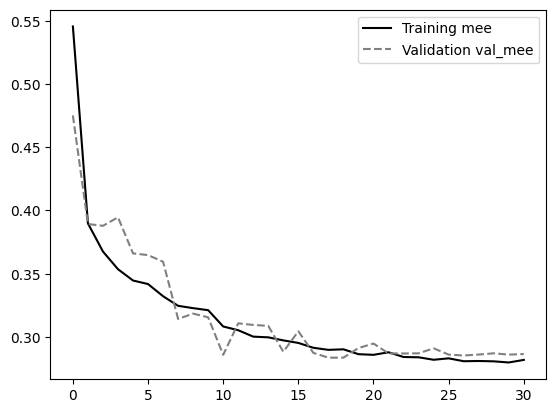

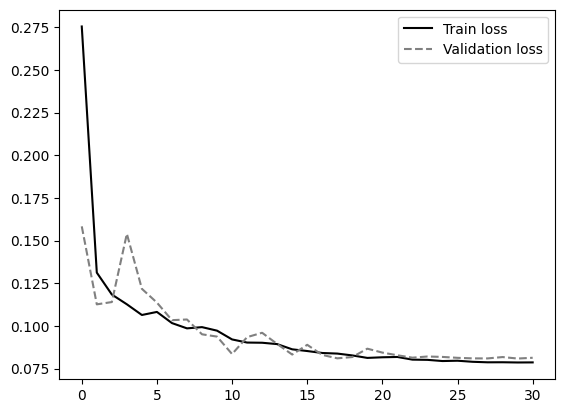

In [23]:
model = grid_search(params, x_train, y_train, k_fold_val)

In [24]:
model.save("./../models/keras_model.hdf5")

38/38 [==============================] - 0s 1ms/step


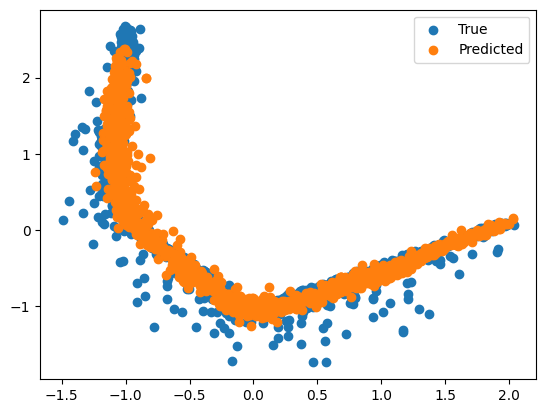

In [25]:
# y_train_rescaled = scaler.inverse_transform(y_train)
# print(y_train.shape)

plt.scatter(y_train[:, 0], y_train[:, 1], label="True")
pred = model.predict(x_train)
# pred = scaler.inverse_transform(pred)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()

In [26]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning.callbacks import ModelSummary
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchmetrics import Metric
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader 
import pytorch_lightning as pl
from datetime import datetime
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics import Accuracy
import logging
import os
logging.getLogger("lightning").addHandler(logging.NullHandler())
logging.getLogger("lightning").propagate = False
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
import random

seed = 42

In [27]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1, color="black")
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2, linestyle='dashed', color="grey")   
    plt.legend()
    plt.show()
    
def set_random_seeds():
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(0)

In [28]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    
    global x_scaler
    global y_scaler
    
    #x_scaler = StandardScaler()
    #y_scaler = StandardScaler()
    # scaler = MinMaxScaler()
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [29]:
class History:
    def __init__(self):
        self.history = {}


class LinearLearningRateScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_init, lr_final, epochs, last_epoch=-1):
        self.lr_init = lr_init
        self.lr_final = lr_final
        self.epochs = epochs
        super().__init__(optimizer, last_epoch=last_epoch)
    
    def step(self):
        self.last_epoch += 1
        epoch = self.last_epoch
        if epoch < self.epochs:
            alpha = epoch / self.epochs
            lr = self.lr_init * (1 - alpha) + alpha*self.lr_final
        else:
            lr = self.lr_final
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
            
    

def get_activation_function(name):
    if name == "relu":
        return nn.ReLU()
    elif name == "tanh":
        return nn.Tanh()
    elif name == "sigmoid":
        return nn.Sigmoid()
    elif name == "linear":
        return None

def mee(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).sqrt().mean()

def mse(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).mean()
    
    
class MEE(Metric):
    
    def __init__(self):
        super().__init__()
        self.add_state("result", default=torch.tensor(0.0))
        
    def update(self, y_pred, y_true):
        self.result += mee(y_true, y_pred)

    def compute(self):
        return self.result
    

class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, input_dim, output_dim, config):
        super(MultiLayerPerceptron, self).__init__()
        
        task = config["task"]
        self.lr = config["learning_rate"]
        self.momentum = config["momentum"]
        self.nesterov = config["nesterov"]
        init = config["initialization"]
        reg_method = config["regularization"]["method"]
        self.reg_method = reg_method
        self.lr_decay = config["learning_rate_decay"]        
        
        
        if reg_method != None:
            value = config["regularization"]["value"]
            self.reg_value = value
        
        self.task = task
        self.model = nn.Sequential()
                
        units = config["units_1"]
        activation = get_activation_function(config["activations_1"])
        
        self.model.add_module("linear_input", nn.Linear(input_dim, units))
        self.model.add_module("activations_1", activation)
        
        n_layers = 0
        for key in config.keys():
            if key.startswith("units_"):
                n_layers += 1
                
        for n_layer in range(2, n_layers+1):
            out_units = config[f"units_{n_layer}"]
            self.model.add_module(f"linear_{n_layer}", nn.Linear(units, out_units))
            activation = get_activation_function(config[f"activations_{n_layer}"])
            if activation != None:
                self.model.add_module(f"activations_{n_layer}", activation)
            units = out_units
        
        if task == "classification":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.model.add_module("activations_output", nn.Sigmoid())
            self.metric = Accuracy()
            self.metric_name = "accuracy"
        
        if task == "regression":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.metric = MEE()
            self.metric_name = "mee"
            
            
        self.loss = nn.MSELoss()
        self.dicts = []
                    
        if init["type"] == "uniform":
            self.min = init["min"]
            self.max = init["max"]
            for name, param in self.model.named_parameters():
                if 'weight' in name:
                    nn.init.uniform_(param, self.min, self.max)
                if 'bias' in name:
                    nn.init.uniform_(param, self.min, self.max)

            
        elif init["type"] == "normal":
            self.mean = init["mean"]
            self.std = init["std"]
            for name, param in self.model.named_parameters():
                if 'weight' in name:
                    nn.init.normal_(param, self.mean, self.std)
                if 'bias' in name:
                    nn.init.normal_(param, self.mean, self.std)
            
            

    def init_weights_uniform(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.uniform_(m.weight, self.min, self.max)
            torch.nn.init.uniform_(m.bias, self.min, self.max)
            # m.bias.data.fill_(0.01)
        
            

    def init_weights_normal(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, self.mean, self.std)
            torch.nn.init.normal_(m.bias, self.mean, self.std)
            # m.bias.data.fill_(0.01)
            
            
    def compute_metric(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.reshape(y_true.shape)  
            return self.metric(y_pred, y_true.to(torch.int32))
        elif self.task == "regression":
            y_true = y_true.to(torch.float32)
            return self.metric(y_pred, y_true)


    def compute_loss(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.reshape(y_true.shape)  
            return self.loss(y_pred, y_true)
        elif self.task == "regression":
            y_true = y_true.to(torch.float32)
            return self.loss(y_pred, y_true)
        
        
    def get_regularization_term(self):
        
        if self.reg_method != None:
            
            value = self.reg_value
            p = 1 if self.reg_method == "l1" else 2
            reg = 0
            
            for param in self.model.parameters():
                reg += torch.linalg.norm(param, p)
                
            reg *= value
            
            return reg
        
        return 0
            
        
        
    def forward(self, x):
        return self.model(x)

    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum, nesterov=self.nesterov)
        if self.lr_decay != None:
            decay_epochs = self.lr_decay["epochs"]
            lr_final = self.lr_decay["lr_final"]
            lr_init = self.lr
            scheduler = LinearLearningRateScheduler(optimizer, lr_init, lr_final, decay_epochs)
            return [optimizer], [scheduler]
            
        return optimizer
    
    
    

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch 
        y_copy = y # Integer y for the accuracy
        X = X.type(torch.float32)
        y = y.type(torch.float32)  
        # forward pass
        y_pred = self.forward(X)
        # accuracy
        acc = self.compute_metric(y_pred, y_copy)
        # compute loss
        reg = self.get_regularization_term()
        loss = self.compute_loss(y_pred, y) + reg
        self.log_dict({'loss': loss, f'{self.metric_name}': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    
    
    def validation_step(self, validation_batch, batch_idx):
        X, y = validation_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'val_loss': loss, f'val_{self.metric_name}': acc}, prog_bar=True, logger=True)
        return loss
    
    
    
    
    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'test_loss': loss, f'test_{self.metric_name}': acc}, on_epoch=True,on_step=False, prog_bar=True, logger=True)
        return loss

    
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [30]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val


def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged

def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("hidden_layers")
    keys.remove("trials_final")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_final"] = params["trials_final"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    early_stopping = config["early_stopping"]
    callbacks = []
    
    if early_stopping != None:        
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"],
            min_delta=early_stopping["delta"],
            patience=early_stopping["patience"], 
            verbose=False,
            mode="min"
        )
        
        callbacks.append(early_stop)
        
    return callbacks if callbacks != [] else None
        


def get_layers_configurations(params, configurations):
    
    layers_list = params["hidden_layers"]
        
    layers_params_confs = []
    
    for layers in layers_list:
        
        layers_conf = {}
        
        for i in range(len(layers)):
            
            units, activation = layers[i]
            
            layers_conf[f"units_{i+1}"] = units
            layers_conf[f"activations_{i+1}"] = activation
            
        layers_params_confs.append(layers_conf)
        
    
    new_configurations = []
    
    
    for conf in configurations:
        
        for layers_conf in layers_params_confs:
            
            new_conf = conf
            new_conf.update(layers_conf)
            new_configurations.append(new_conf)
            
    
    
    
    '''layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))'''
                
    return new_configurations



def get_configurations(params):
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    return layers_confs


def get_model(config, input_size, output_size):
    model = MultiLayerPerceptron(input_size, output_size, config)
    return model
    
    
    
def fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, metric, config):  
    
    if batch_size is None:
        batch_size_train = x_train.shape[0]
        batch_size_val = x_val.shape[0]
    else:
        batch_size_train = batch_size
        batch_size_val = batch_size
        
    
    
    train_loader = DataLoader(dataset = CustomDataset(x_train, y_train), batch_size=batch_size_train)
    validation_loader = DataLoader(dataset = CustomDataset(x_val, y_val), batch_size=batch_size_val)
    
    callbacks = get_callbacks(config)
        
    trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=max_epochs,
                         log_every_n_steps=1, logger=CSVLogger(save_dir="logs/"),
                         callbacks=callbacks, enable_progress_bar=False,
                         enable_model_summary=False
                        )  
    
    
    trainer.fit(model=model, train_dataloaders=train_loader,
                val_dataloaders=validation_loader) 
    
    metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
    

    history = History()
            
    history.history["loss"] = metrics["loss"].dropna().to_list()
    history.history["val_loss"] = metrics["val_loss"].dropna().to_list()
    history.history[f"{metric}"] = metrics[f"{metric}"].dropna().to_list()
    history.history[f"val_{metric}"] = metrics[f"val_{metric}"].dropna().to_list()
    
    return history
    
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                
                
                
                model = get_model(config, input_size, output_size)
                history = fit(model, x_train_fold, y_train_fold, x_val_fold, y_val_fold, 
                              max_epochs, batch_size, train_metric, config)
                
                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the mean metrics among the trials
        # med_idx = median_index(trials_val_loss)
        # med_val_loss = trials_val_loss[med_idx]
        # med_train_loss = trials_train_loss[med_idx]
        # med_val_acc = trials_val_acc[med_idx]
        # med_train_acc = trials_train_acc[med_idx]
        med_val_loss = np.mean(trials_val_loss)
        med_train_loss = np.mean(trials_train_loss)
        med_val_acc = np.mean(trials_val_acc)
        med_train_acc = np.mean(trials_train_acc)
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} mean val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} mean train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} mean {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} mean train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
        
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True, stratify=stratify)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, train_metric, config)  

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
                                    
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_val_loss = np.mean(trials_val_loss)
    med_train_loss = np.mean(trials_train_loss)
    med_val_acc = np.mean(trials_val_acc)
    med_train_acc = np.mean(trials_train_acc)
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"\nMean val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Mean train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Mean {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Mean train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    
    return med_val_loss
    
    

def fit_final_model(x_train, y_train, config):
    global y_scaler
    
    task = config["task"]
    trails = config["trials_final"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    val_loss = "val_mse"
    train_loss = "mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_final"]
    
    '''if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"'''
        
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    
    trials_history_val_loss = []
    trials_history_train_loss = []
    trials_history_val_acc = []
    trials_history_train_acc = []
    
    models = []
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=stratify)
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            
            model = get_model(config, input_size, output_size)
            torch.save(model, f"./../models/pytorch_model_{trial}.pt")
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, train_metric, config)

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]

            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            

            trials_history_val_loss.append(trial_val_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_val_acc.append(trial_val_acc)
            trials_history_train_acc.append(trial_train_acc)
            

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    # get the mean metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric}: {std_train_acc}")
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    val_acc = trials_history_val_acc[med_idx]
    
    train_loss = trials_history_train_loss[med_idx]
    val_loss = trials_history_val_loss[med_idx]
    
    
    med_model = models[med_idx]
    
    
    if task == "regression":
        
        
        y_pred = model(torch.from_numpy(x_train).to(torch.float32))
        # y_val = y_val.detach().numpy()
        
        y_pred = y_scaler.inverse_transform(y_pred.detach().numpy())
        y_train  = y_scaler.inverse_transform(y_train)
        
        y_pred  = torch.from_numpy(y_pred).to(torch.float32)
        y_train  = torch.from_numpy(y_train).to(torch.float32)
        
        mse_train = mse(y_train, y_pred)
        mee_train = mee(y_train, y_pred)

        print(f"\nTraining MSE: {mse_train}")
        print(f"Training MEE: {mee_train}")
        
        y_pred = model(torch.from_numpy(x_val).to(torch.float32))
        # y_val = y_val.detach().numpy()
        
        y_pred = y_scaler.inverse_transform(y_pred.detach().numpy())
        y_val  = y_scaler.inverse_transform(y_val)
        
        y_pred  = torch.from_numpy(y_pred).to(torch.float32)
        y_val  = torch.from_numpy(y_val).to(torch.float32)
        
        mse_val = mse(y_val, y_pred)
        mee_val = mee(y_val, y_pred)

        print(f"\nValidation MSE: {mse_val}")
        print(f"Validation MEE: {mee_val}")
    
    
    for trial in range(trials):
        if trial != med_idx:
            os.system(f"rm ./../models/pytorch_model_{trial}.pt")
            
    os.system(f"mv ./../models/pytorch_model_{med_idx}.pt ./../models/pytorch_model.pt")
    
    plot_curves(train_acc, f"Training {train_metric}", val_acc, f"Validation {val_metric}")
    plot_curves(train_loss, "Train loss", val_loss, "Validation loss")
    
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss

    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:
        
        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}):
    set_random_seeds()
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, best_conf)
    
    return model

# ML Cup

In [31]:
x_train, y_train, _, _ = load_dataset("cup", True)
print(x_train.shape, y_train.shape)

(1194, 9) (1194, 2)


In [32]:
params = {
    "task": "regression",
    "trials_train": 1,
    "trials_final": 5,
    "initialization": {
        "type": "default",
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.01
    },
    "max_epochs": [500],
    "learning_rate": [0.1, 0.2, 0.3],
    "batch_size": [16],
    "nesterov": False,
    "momentum": [0.1, 0.2, 0.3, 0.4],
    "learning_rate_decay": {
        "epochs": 100,
        "lr_final": 0.01
    },
    "regularization": [
        {
            "type": "l1",
            "value": [0.001, 0.0001, 0.00001]
        }
    ],
    "hidden_layers": [ 
        [(10, "tanh"), (10, "relu"), (10, "tanh")],
        [(25, "tanh"), (25, "relu"), (25, "tanh")],
        [(50, "tanh"), (50, "relu"), (50, "tanh")],
        [(30, "tanh"), (30, "relu")],
        [(50, "tanh"), (50, "relu")]
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activations_2': 'relu', 'units_3': 50, 'activations_3': 'tanh'}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.21s/it]


Fold 1/4 mean val_loss: 0.0812971666455268, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1038310304284095, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2999971210956573, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3051860928535461, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


Fold 2/4 mean val_loss: 0.1117793843150138, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1031876131892204, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3384338021278381, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3050142526626587, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Fold 3/4 mean val_loss: 0.0943222194910049, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1044812649488449, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3267695605754852, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3044110834598541, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.22s/it]


Fold 4/4 mean val_loss: 0.0908473208546638, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1044650599360466, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3293020725250244, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3005692660808563, train_mee 0.0

Mean val_loss: 0.09456152282655232, std val_loss: 0.011025543767852673
Mean train_loss: 0.10399124212563035, std train_loss: 0.0005329429941608618
Mean val_mee: 0.3236256390810012, std val_mee: 0.014315155378246243
Mean train_mee: 0.3236256390810012, std train_mee: 0.001884584464041817



Testing configuration 2/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.16s/it]


Fold 1/4 mean val_loss: 0.1019281595945358, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0979729145765304, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3331324458122253, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2991163432598114, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Fold 2/4 mean val_loss: 0.110637791454792, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0992816463112831, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3562965095043182, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2946542203426361, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.88s/it]


Fold 3/4 mean val_loss: 0.067453846335411, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1088850349187851, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2907593548297882, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3124512135982513, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


Fold 4/4 mean val_loss: 0.088929109275341, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1036050915718078, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3126570284366607, std val_mee 0.0
Fold 4/4 mean train_mee: 0.305928498506546, train_mee 0.0

Mean val_loss: 0.09223722666501996, std val_loss: 0.016260800617227594
Mean train_loss: 0.1024361718446016, std train_loss: 0.004266904763981966
Mean val_mee: 0.3232113346457481, std val_mee: 0.02427746699992817
Mean train_mee: 0.3232113346457481, std train_mee: 0.006757046767087798



Testing configuration 3/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activa

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


Fold 1/4 mean val_loss: 0.0886260941624641, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1050394773483276, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3111140131950378, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3079663813114166, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.23s/it]


Fold 2/4 mean val_loss: 0.0941572412848472, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1048547700047493, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3294037282466888, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3075598776340484, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.83s/it]


Fold 3/4 mean val_loss: 0.0699122175574302, std val_loss 0.0
Fold 3/4 mean train_loss: 0.106994941830635, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2911337614059448, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3110593855381012, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


Fold 4/4 mean val_loss: 0.1130127981305122, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0970646068453788, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3552088439464569, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2911465466022491, train_mee 0.0

Mean val_loss: 0.09142708778381342, std val_loss: 0.015363364177774804
Mean train_loss: 0.10348844900727268, std train_loss: 0.003802425608217664
Mean val_mee: 0.3217150866985321, std val_mee: 0.023603745462937045
Mean train_mee: 0.3217150866985321, std train_mee: 0.0077894315648065



Testing configuration 4/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'acti

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


Fold 1/4 mean val_loss: 0.0968426167964935, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1014097705483436, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3346279263496399, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3020032048225403, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


Fold 2/4 mean val_loss: 0.0835808888077735, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1063853576779365, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3063636720180511, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3089354932308197, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Fold 3/4 mean val_loss: 0.0658454149961471, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1135986968874931, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2955464422702789, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3175477981567383, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Fold 4/4 mean val_loss: 0.1158424466848373, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0977272018790245, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3494550585746765, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2974076569080353, train_mee 0.0

Mean val_loss: 0.09052784182131285, std val_loss: 0.01829062569005998
Mean train_loss: 0.10478025674819944, std train_loss: 0.005946574553807414
Mean val_mee: 0.3214982748031616, std val_mee: 0.021543695840413758
Mean train_mee: 0.3214982748031616, std train_mee: 0.007597278135438075



Testing configuration 5/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.11s/it]


Fold 1/4 mean val_loss: 0.0754273235797882, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1026184186339378, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3063901364803314, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3037350177764892, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.33s/it]


Fold 2/4 mean val_loss: 0.1024512946605682, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0989304557442665, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3355478048324585, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2983052730560303, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Fold 3/4 mean val_loss: 0.100487008690834, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1006768718361854, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3224758505821228, std val_mee 0.0
Fold 3/4 mean train_mee: 0.304034948348999, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.58s/it]


Fold 4/4 mean val_loss: 0.0922279581427574, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1031919792294502, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3270559310913086, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3076473772525787, train_mee 0.0

Mean val_loss: 0.09264839626848695, std val_loss: 0.010656955174441898
Mean train_loss: 0.10135443136095998, std train_loss: 0.0016814421410786147
Mean val_mee: 0.32286743074655533, std val_mee: 0.01060648367105417
Mean train_mee: 0.32286743074655533, std train_mee: 0.0033357193294069496



Testing configuration 6/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.16s/it]


Fold 1/4 mean val_loss: 0.085922285914421, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0876351222395896, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3216362595558166, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3066138327121734, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Fold 2/4 mean val_loss: 0.1054036170244216, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0843595340847969, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3347871303558349, std val_mee 0.0
Fold 2/4 mean train_mee: 0.302311360836029, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.48s/it]


Fold 3/4 mean val_loss: 0.0911534503102302, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0814722627401351, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3193763494491577, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2960119247436523, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.86s/it]


Fold 4/4 mean val_loss: 0.092786356806755, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0785697177052497, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3091326355934143, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2910583913326263, train_mee 0.0

Mean val_loss: 0.09381642751395695, std val_loss: 0.007154245690398635
Mean train_loss: 0.08300915919244281, std train_loss: 0.0033650311249227424
Mean val_mee: 0.3212330937385559, std val_mee: 0.009134317680829859
Mean train_mee: 0.3212330937385559, std train_mee: 0.005935766506479663



Testing configuration 7/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.23s/it]


Fold 1/4 mean val_loss: 0.0844899639487266, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0839753597974777, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3054482936859131, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2996153533458709, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.31s/it]


Fold 2/4 mean val_loss: 0.0951585695147514, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0817397832870483, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3185067772865295, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2990354597568512, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.91s/it]


Fold 3/4 mean val_loss: 0.0806389972567558, std val_loss 0.0
Fold 3/4 mean train_loss: 0.081174150109291, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3039647340774536, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2976873815059662, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Fold 4/4 mean val_loss: 0.1019938588142395, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0823504328727722, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3336344361305237, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2944411337375641, train_mee 0.0

Mean val_loss: 0.09057034738361833, std val_loss: 0.008472767755990217
Mean train_loss: 0.0823099315166473, std train_loss: 0.0010476593109700295
Mean val_mee: 0.315388560295105, std val_mee: 0.011957716838092866
Mean train_mee: 0.315388560295105, std train_mee: 0.0020045132149243555



Testing configuration 8/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.15s/it]


Fold 1/4 mean val_loss: 0.0827294513583183, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0879141688346862, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3190033733844757, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3070051670074463, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


Fold 2/4 mean val_loss: 0.0874342992901802, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0881140157580375, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3019362986087799, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3094713687896728, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


Fold 3/4 mean val_loss: 0.0961651727557182, std val_loss 0.0
Fold 3/4 mean train_loss: 0.085932657122612, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3087269961833954, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3016195893287658, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.67s/it]


Fold 4/4 mean val_loss: 0.0917865186929702, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0821609050035476, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3316771388053894, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2974515259265899, train_mee 0.0

Mean val_loss: 0.08952886052429673, std val_loss: 0.0049939166044635636
Mean train_loss: 0.08603043667972082, std train_loss: 0.0023912645630474374
Mean val_mee: 0.3153359517455101, std val_mee: 0.011221779870085342
Mean train_mee: 0.3153359517455101, std train_mee: 0.004676126012430513



Testing configuration 9/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.06s/it]


Fold 1/4 mean val_loss: 0.0883600860834121, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0864762216806411, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3046148419380188, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3059130311012268, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Fold 2/4 mean val_loss: 0.0838647633790969, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0869662389159202, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3123626708984375, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3059459924697876, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Fold 3/4 mean val_loss: 0.0973297283053398, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0814929977059364, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3192080557346344, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2980174422264099, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.68s/it]


Fold 4/4 mean val_loss: 0.0938821882009506, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0795403122901916, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3260372877120971, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2915438711643219, train_mee 0.0

Mean val_loss: 0.09085919149219984, std val_loss: 0.005152036204863913
Mean train_loss: 0.08361894264817234, std train_loss: 0.0031828958225146604
Mean val_mee: 0.31555571407079697, std val_mee: 0.007954577194196968
Mean train_mee: 0.31555571407079697, std train_mee: 0.006026007679111226



Testing configuration 10/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.10s/it]


Fold 1/4 mean val_loss: 0.0898221582174301, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0809909105300903, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3200581669807434, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2958868443965912, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.68s/it]


Fold 2/4 mean val_loss: 0.0924127548933029, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0818588957190513, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3181570768356323, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2977050840854645, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Fold 3/4 mean val_loss: 0.1000234112143516, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0861084386706352, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3248677849769592, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3050678670406341, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.58s/it]


Fold 4/4 mean val_loss: 0.0812544599175453, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0866666957736015, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3070285618305206, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3026256263256073, train_mee 0.0

Mean val_loss: 0.09087819606065747, std val_loss: 0.006703009478897866
Mean train_loss: 0.08390623517334458, std train_loss: 0.002508015130821652
Mean val_mee: 0.3175278976559639, std val_mee: 0.006536591771642031
Mean train_mee: 0.3175278976559639, std train_mee: 0.003686081953914257



Testing configuration 11/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.21s/it]


Fold 1/4 mean val_loss: 0.0676904469728469, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0869910791516304, std train_loss 0.0
Fold 1/4 mean val_mee: 0.279798686504364, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3097892105579376, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


Fold 2/4 mean val_loss: 0.0879275575280189, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0796282887458801, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3184385895729065, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2995474636554718, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.98s/it]


Fold 3/4 mean val_loss: 0.1133081465959549, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0751005858182907, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3443580567836761, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2892163395881653, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.16s/it]


Fold 4/4 mean val_loss: 0.0924109071493148, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0814616680145263, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3222665190696716, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3005769252777099, train_mee 0.0

Mean val_loss: 0.09033426456153387, std val_loss: 0.01620683817022755
Mean train_loss: 0.08079540543258187, std train_loss: 0.004260968506710098
Mean val_mee: 0.31621546298265457, std val_mee: 0.02323652709917933
Mean train_mee: 0.31621546298265457, std train_mee: 0.007288078547243252



Testing configuration 12/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Fold 1/4 mean val_loss: 0.0867703482508659, std val_loss 0.0
Fold 1/4 mean train_loss: 0.082584410905838, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3064048886299133, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3044529855251312, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.41s/it]


Fold 2/4 mean val_loss: 0.1035590097308158, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0735546499490737, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3394862413406372, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2826272547245025, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.07s/it]


Fold 3/4 mean val_loss: 0.0822763368487358, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0792350694537162, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3078164458274841, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2949155867099762, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Fold 4/4 mean val_loss: 0.088696502149105, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0844875127077102, std train_loss 0.0
Fold 4/4 mean val_mee: 0.2994781136512756, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3082050681114197, train_mee 0.0

Mean val_loss: 0.09032554924488063, std val_loss: 0.007987608296279269
Mean train_loss: 0.07996541075408452, std train_loss: 0.004151500342886793
Mean val_mee: 0.3132964223623276, std val_mee: 0.015446485472090427
Mean train_mee: 0.3132964223623276, std train_mee: 0.009884459334719735



Testing configuration 13/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.78s/it]


Fold 1/4 mean val_loss: 0.0941846743226051, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0796928778290748, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3219648003578186, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2995596826076507, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Fold 2/4 mean val_loss: 0.0845814943313598, std val_loss 0.0
Fold 2/4 mean train_loss: 0.081180028617382, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3125283718109131, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2985701858997345, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Fold 3/4 mean val_loss: 0.0859555453062057, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0845457464456558, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3179241120815277, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3075285851955414, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Fold 4/4 mean val_loss: 0.097852237522602, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0805937871336937, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3215107321739197, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3009591698646545, train_mee 0.0

Mean val_loss: 0.09064348787069315, std val_loss: 0.0055504649397585
Mean train_loss: 0.08150311000645158, std train_loss: 0.0018347906357448083
Mean val_mee: 0.31848200410604477, std val_mee: 0.0037769049649533756
Mean train_mee: 0.31848200410604477, std train_mee: 0.0034960554279987615



Testing configuration 14/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Fold 1/4 mean val_loss: 0.0984557196497917, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0782296955585479, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3316565752029419, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2940826714038849, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Fold 2/4 mean val_loss: 0.0781482085585594, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0837695747613906, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2929360270500183, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3053860366344452, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.04s/it]


Fold 3/4 mean val_loss: 0.0748216062784195, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0840360075235366, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2949159741401672, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3061873614788055, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.54s/it]


Fold 4/4 mean val_loss: 0.1046971231698989, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0775189623236656, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3429376184940338, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2927372753620147, train_mee 0.0

Mean val_loss: 0.08903066441416738, std val_loss: 0.012792524913928504
Mean train_loss: 0.08088856004178517, std train_loss: 0.00302615352333386
Mean val_mee: 0.3156115487217903, std val_mee: 0.0220603890170193
Mean train_mee: 0.3156115487217903, std train_mee: 0.006213079840329868



Testing configuration 15/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'acti

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.42s/it]


Fold 1/4 mean val_loss: 0.0869607776403427, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0763433501124382, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3227655291557312, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2899392247200012, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.51s/it]


Fold 2/4 mean val_loss: 0.1032023951411247, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0752253979444503, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3335175216197967, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2941038012504577, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Fold 3/4 mean val_loss: 0.0907382741570472, std val_loss 0.0
Fold 3/4 mean train_loss: 0.081883393228054, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3235933482646942, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3006426692008972, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.26s/it]


Fold 4/4 mean val_loss: 0.0886951982975006, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0812109857797622, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3089125454425812, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3005425035953522, train_mee 0.0

Mean val_loss: 0.0923991613090038, std val_loss: 0.006378945176930895
Mean train_loss: 0.07866578176617618, std train_loss: 0.0029180908406636033
Mean val_mee: 0.32219723612070084, std val_mee: 0.008759337250708944
Mean train_mee: 0.32219723612070084, std train_mee: 0.004531560571771084



Testing configuration 16/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.37s/it]


Fold 1/4 mean val_loss: 0.0949993059039115, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0936612859368324, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3231902718544006, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2895666658878326, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Fold 2/4 mean val_loss: 0.0865662023425102, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1073680147528648, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3086369633674621, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3129878938198089, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.34s/it]


Fold 3/4 mean val_loss: 0.0959894955158233, std val_loss 0.0
Fold 3/4 mean train_loss: 0.092772290110588, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3327944278717041, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2887694239616394, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Fold 4/4 mean val_loss: 0.0798225402832031, std val_loss 0.0
Fold 4/4 mean train_loss: 0.108867309987545, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3081663250923157, std val_mee 0.0
Fold 4/4 mean train_mee: 0.311832457780838, train_mee 0.0

Mean val_loss: 0.08934438601136202, std val_loss: 0.0066052904910792265
Mean train_loss: 0.10066722519695756, std train_loss: 0.007475880486269345
Mean val_mee: 0.31819699704647064, std val_mee: 0.010368538997860695
Mean train_mee: 0.31819699704647064, std train_mee: 0.011631658965969262



Testing configuration 17/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.21s/it]


Fold 1/4 mean val_loss: 0.0862764343619346, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1051832661032676, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3166272640228271, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3121261298656463, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.44s/it]


Fold 2/4 mean val_loss: 0.0968000814318656, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1022222116589546, std train_loss 0.0
Fold 2/4 mean val_mee: 0.325088620185852, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3076030313968658, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


Fold 3/4 mean val_loss: 0.096227616071701, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1029078215360641, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3348108530044555, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3004970252513885, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Fold 4/4 mean val_loss: 0.1023168787360191, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0986260548233985, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3260867297649383, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3056428730487823, train_mee 0.0

Mean val_loss: 0.09540525265038008, std val_loss: 0.005782035269209481
Mean train_loss: 0.1022348385304212, std train_loss: 0.0023542307958312287
Mean val_mee: 0.3256533667445182, std val_mee: 0.006438882417129024
Mean train_mee: 0.3256533667445182, std train_mee: 0.004172412420321994



Testing configuration 18/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Fold 1/4 mean val_loss: 0.0930903926491737, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1030665785074234, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3282460868358612, std val_mee 0.0
Fold 1/4 mean train_mee: 0.309163361787796, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.65s/it]


Fold 2/4 mean val_loss: 0.1057867333292961, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0958610773086547, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3364916443824768, std val_mee 0.0
Fold 2/4 mean train_mee: 0.297302782535553, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


Fold 3/4 mean val_loss: 0.09227205067873, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1055643111467361, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3282991051673889, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3086033463478088, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Fold 4/4 mean val_loss: 0.0875419229269027, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1045402288436889, std train_loss 0.0
Fold 4/4 mean val_mee: 0.313473105430603, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3033572137355804, train_mee 0.0

Mean val_loss: 0.09467277489602563, std val_loss: 0.006757154212474917
Mean train_loss: 0.10225804895162578, std train_loss: 0.003798508951092762
Mean val_mee: 0.3266274854540825, std val_mee: 0.00830291406774976
Mean train_mee: 0.3266274854540825, std train_mee: 0.004786563875264715



Testing configuration 19/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.72s/it]


Fold 1/4 mean val_loss: 0.090370312333107, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1027009114623069, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3153602480888366, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3056718409061432, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Fold 2/4 mean val_loss: 0.0937145724892616, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1010345593094825, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3232282698154449, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2983258366584778, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Fold 3/4 mean val_loss: 0.0962868854403495, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1011501103639602, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3296561539173126, std val_mee 0.0
Fold 3/4 mean train_mee: 0.301388531923294, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Fold 4/4 mean val_loss: 0.0837675780057907, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1068565472960472, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3086409866809845, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3103995323181152, train_mee 0.0

Mean val_loss: 0.0910348370671272, std val_loss: 0.004690939176593823
Mean train_loss: 0.1029355321079492, std train_loss: 0.0023574793390969415
Mean val_mee: 0.3192214146256447, std val_mee: 0.007933989146611876
Mean train_mee: 0.3192214146256447, std train_mee: 0.004548447108754881



Testing configuration 20/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Fold 1/4 mean val_loss: 0.0946461260318756, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1021338105201721, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3281184732913971, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3025499880313873, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.22s/it]


Fold 2/4 mean val_loss: 0.1149034947156906, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0967041328549385, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3432452082633972, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2980372607707977, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.42s/it]


Fold 3/4 mean val_loss: 0.0762493833899498, std val_loss 0.0
Fold 3/4 mean train_loss: 0.107846975326538, std train_loss 0.0
Fold 3/4 mean val_mee: 0.298898309469223, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3126876652240753, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Fold 4/4 mean val_loss: 0.0865160748362541, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1060970649123191, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3169614374637604, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3149098455905914, train_mee 0.0

Mean val_loss: 0.09307876974344254, std val_loss: 0.014186899197227027
Mean train_loss: 0.10319549590349192, std train_loss: 0.004281364666122452
Mean val_mee: 0.3218058571219444, std val_mee: 0.01618424420196731
Mean train_mee: 0.3218058571219444, std train_mee: 0.006982835383113144



Testing configuration 21/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.98s/it]


Fold 1/4 mean val_loss: 0.0981951802968978, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0818262472748756, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3306043148040771, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2951652109622955, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.28s/it]


Fold 2/4 mean val_loss: 0.0750068575143814, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0894506722688674, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2976002395153045, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3094505369663238, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.77s/it]


Fold 3/4 mean val_loss: 0.0833848416805267, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0866123363375663, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3164768517017364, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3011064231395721, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


Fold 4/4 mean val_loss: 0.1062777191400528, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0783035010099411, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3299501538276672, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2947386801242828, train_mee 0.0

Mean val_loss: 0.09071614965796468, std val_loss: 0.0122334406480398
Mean train_loss: 0.0840481892228126, std train_loss: 0.004292439346458959
Mean val_mee: 0.3186578899621963, std val_mee: 0.01340162172973105
Mean train_mee: 0.3186578899621963, std train_mee: 0.005948537573092163



Testing configuration 22/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'acti

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


Fold 1/4 mean val_loss: 0.0669014975428581, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0934016704559326, std train_loss 0.0
Fold 1/4 mean val_mee: 0.288074254989624, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3146683275699615, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.77s/it]


Fold 2/4 mean val_loss: 0.1031398996710777, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0785498172044754, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3210263550281524, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2917781770229339, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.70s/it]


Fold 3/4 mean val_loss: 0.0804740414023399, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0847395583987236, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3038537800312042, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2989563047885895, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Fold 4/4 mean val_loss: 0.1091101318597793, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0784580707550048, std train_loss 0.0
Fold 4/4 mean val_mee: 0.350988894701004, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2900488376617431, train_mee 0.0

Mean val_loss: 0.08990639261901374, std val_loss: 0.01704482147650691
Mean train_loss: 0.0837872792035341, std train_loss: 0.006106857328021665
Mean val_mee: 0.3159858211874962, std val_mee: 0.023328438047943722
Mean train_mee: 0.3159858211874962, std train_mee: 0.009717268902419597



Testing configuration 23/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.16s/it]


Fold 1/4 mean val_loss: 0.1010627523064613, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0798816904425621, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3248356580734253, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2927998602390289, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.72s/it]


Fold 2/4 mean val_loss: 0.0864410549402237, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0855138972401619, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3082422018051147, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3019141554832458, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Fold 3/4 mean val_loss: 0.0940616354346275, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0882707834243774, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3239448964595794, std val_mee 0.0
Fold 3/4 mean train_mee: 0.309563010931015, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.57s/it]


Fold 4/4 mean val_loss: 0.0834731832146644, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0824705213308334, std train_loss 0.0
Fold 4/4 mean val_mee: 0.309551328420639, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2962910830974579, train_mee 0.0

Mean val_loss: 0.09125965647399423, std val_loss: 0.006852004461394474
Mean train_loss: 0.08403422310948369, std train_loss: 0.003155414776108507
Mean val_mee: 0.31664352118968964, std val_mee: 0.0077669581115876575
Mean train_mee: 0.31664352118968964, std train_mee: 0.006337045038423052



Testing configuration 24/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Fold 1/4 mean val_loss: 0.1006051003932952, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0869010165333747, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3279156386852264, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3054325580596924, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Fold 2/4 mean val_loss: 0.1116657331585884, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0841754302382469, std train_loss 0.0
Fold 2/4 mean val_mee: 0.345459908246994, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3023080825805664, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.10s/it]


Fold 3/4 mean val_loss: 0.0863672494888305, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0845793709158897, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3216184675693512, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3028566837310791, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Fold 4/4 mean val_loss: 0.0902993828058242, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0817601904273033, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3221558928489685, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2968819439411163, train_mee 0.0

Mean val_loss: 0.09723436646163458, std val_loss: 0.009821079645168342
Mean train_loss: 0.08435400202870365, std train_loss: 0.0018233088417916328
Mean val_mee: 0.32928747683763504, std val_mee: 0.009657932891556729
Mean train_mee: 0.32928747683763504, std train_mee: 0.0031119922948963097



Testing configuration 25/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 5

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Fold 1/4 mean val_loss: 0.0756874829530716, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0892780348658561, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3011734187602997, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3095305562019348, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.70s/it]


Fold 2/4 mean val_loss: 0.0969792678952217, std val_loss 0.0
Fold 2/4 mean train_loss: 0.082742154598236, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3191263973712921, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2978403568267822, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Fold 3/4 mean val_loss: 0.0939238965511322, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0844584479928016, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3254307508468628, std val_mee 0.0
Fold 3/4 mean train_mee: 0.302565336227417, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.34s/it]


Fold 4/4 mean val_loss: 0.1091904193162918, std val_loss 0.0
Fold 4/4 mean train_loss: 0.081181101500988, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3455182909965515, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2960043847560882, train_mee 0.0

Mean val_loss: 0.09394526667892933, std val_loss: 0.011989234395693297
Mean train_loss: 0.08441493473947043, std train_loss: 0.0030375774499463294
Mean val_mee: 0.3228122144937515, std val_mee: 0.01584491536296297
Mean train_mee: 0.3228122144937515, std train_mee: 0.00522538678410866



Testing configuration 26/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.48s/it]


Fold 1/4 mean val_loss: 0.0785773172974586, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0838878378272056, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3160479068756103, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3066621422767639, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.01s/it]


Fold 2/4 mean val_loss: 0.0990190133452415, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0779809430241584, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3212004601955414, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2930299937725067, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.97s/it]


Fold 3/4 mean val_loss: 0.0805151090025901, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0837011337280273, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3037174344062805, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3061419129371643, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Fold 4/4 mean val_loss: 0.1155504584312439, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0753906518220901, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3465075492858886, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2928820550441742, train_mee 0.0

Mean val_loss: 0.09341547451913351, std val_loss: 0.015066083601592116
Mean train_loss: 0.08024014160037035, std train_loss: 0.003671024502348573
Mean val_mee: 0.32186833769083023, std val_mee: 0.015579389536296121
Mean train_mee: 0.32186833769083023, std train_mee: 0.006725720486199937



Testing configuration 27/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.91s/it]


Fold 1/4 mean val_loss: 0.0888712182641029, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0774610787630081, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3277161121368408, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2951088547706604, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.11s/it]


Fold 2/4 mean val_loss: 0.1018660143017768, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0768633559346199, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3361801505088806, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2885681390762329, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Fold 3/4 mean val_loss: 0.0844591930508613, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0831575840711593, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2996854484081268, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3033854961395263, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Fold 4/4 mean val_loss: 0.0817914754152298, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0848848670721054, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3051007091999054, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3068392872810364, train_mee 0.0

Mean val_loss: 0.0892469752579927, std val_loss: 0.007711820084703843
Mean train_loss: 0.08059172146022318, std train_loss: 0.003489856135041833
Mean val_mee: 0.3171706050634384, std val_mee: 0.01519854949407042
Mean train_mee: 0.3171706050634384, std train_mee: 0.007133566785525472



Testing configuration 28/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.94s/it]


Fold 1/4 mean val_loss: 0.0889644548296928, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0813919678330421, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3262547254562378, std val_mee 0.0
Fold 1/4 mean train_mee: 0.298740416765213, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Fold 2/4 mean val_loss: 0.092190958559513, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0834532678127288, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3208737671375274, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3032959699630737, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Fold 3/4 mean val_loss: 0.0794121548533439, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0844172090291976, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3014200031757355, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3083615005016327, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


Fold 4/4 mean val_loss: 0.1128037497401237, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0767172053456306, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3322841823101043, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2926878631114959, train_mee 0.0

Mean val_loss: 0.09334282949566834, std val_loss: 0.012178752852001814
Mean train_loss: 0.08149491250514977, std train_loss: 0.0029669873522152486
Mean val_mee: 0.3202081695199013, std val_mee: 0.011573991731086426
Mean train_mee: 0.3202081695199013, std train_mee: 0.0057760613882965285



Testing configuration 29/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Fold 1/4 mean val_loss: 0.0847726017236709, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0801712721586227, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3081009685993194, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3037116527557373, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.35s/it]


Fold 2/4 mean val_loss: 0.0900763049721717, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0762494951486587, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3189782500267029, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2860515117645263, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Fold 3/4 mean val_loss: 0.1011402308940887, std val_loss 0.0
Fold 3/4 mean train_loss: 0.079603724181652, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3318188786506653, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2964857518672943, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.49s/it]


Fold 4/4 mean val_loss: 0.0846460163593292, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0758388489484787, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3100644946098327, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2907836437225342, train_mee 0.0

Mean val_loss: 0.09015878848731512, std val_loss: 0.006708214092653689
Mean train_loss: 0.07796583510935302, std train_loss: 0.0019375581398163799
Mean val_mee: 0.3172406479716301, std val_mee: 0.009361823897265338
Mean train_mee: 0.3172406479716301, std train_mee: 0.00659075165348377



Testing configuration 30/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.99s/it]


Fold 1/4 mean val_loss: 0.1005304530262947, std val_loss 0.0
Fold 1/4 mean train_loss: 0.073409616947174, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3375330567359924, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2873262763023376, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.17s/it]


Fold 2/4 mean val_loss: 0.0855306386947631, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0833782330155372, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3041963577270508, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3046619892120361, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Fold 3/4 mean val_loss: 0.0884808450937271, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0807274580001831, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3121611475944519, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2991449236869812, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Fold 4/4 mean val_loss: 0.0891655161976814, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0828541070222854, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3116149604320526, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3029755055904388, train_mee 0.0

Mean val_loss: 0.09092686325311658, std val_loss: 0.005710374862945115
Mean train_loss: 0.08009235374629493, std train_loss: 0.003983924330014068
Mean val_mee: 0.31637638062238693, std val_mee: 0.012613457234394875
Mean train_mee: 0.31637638062238693, std train_mee: 0.006768776394843993



Testing configuration 31/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Fold 1/4 mean val_loss: 0.0805344358086586, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1080872192978859, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3065491020679474, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3109426498413086, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.79s/it]


Fold 2/4 mean val_loss: 0.105376623570919, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1000936776399612, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3456640541553497, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3040794730186462, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.13s/it]


Fold 3/4 mean val_loss: 0.0875114277005195, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1032866016030311, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3176082968711853, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3077895045280456, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.51s/it]


Fold 4/4 mean val_loss: 0.1111011132597923, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0957791730761528, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3525320589542389, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2986851036548614, train_mee 0.0

Mean val_loss: 0.09613090008497235, std val_loss: 0.012521338660331154
Mean train_loss: 0.10181166790425775, std train_loss: 0.004497234125247875
Mean val_mee: 0.33058837801218033, std val_mee: 0.019073348151349704
Mean train_mee: 0.33058837801218033, std train_mee: 0.004562391299197459



Testing configuration 32/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.07s/it]


Fold 1/4 mean val_loss: 0.0862299650907516, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1049972996115684, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3060320615768432, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3112780153751373, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


Fold 2/4 mean val_loss: 0.0983630269765853, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0968630909919738, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3294957876205444, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2999807298183441, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.45s/it]


Fold 3/4 mean val_loss: 0.0966188609600067, std val_loss 0.0
Fold 3/4 mean train_loss: 0.100885272026062, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3262665271759033, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3015849888324737, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Fold 4/4 mean val_loss: 0.0829238221049308, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1053697019815445, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3170907199382782, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3088231384754181, train_mee 0.0

Mean val_loss: 0.0910339187830686, std val_loss: 0.006590884713729328
Mean train_loss: 0.10202884115278717, std train_loss: 0.0034628680948809356
Mean val_mee: 0.3197212740778923, std val_mee: 0.009119975426129604
Mean train_mee: 0.3197212740778923, std train_mee: 0.004748437198160908



Testing configuration 33/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Fold 1/4 mean val_loss: 0.0971971899271011, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1010497361421585, std train_loss 0.0
Fold 1/4 mean val_mee: 0.331731230020523, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3021547794342041, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.92s/it]


Fold 2/4 mean val_loss: 0.082154095172882, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1002691686153411, std train_loss 0.0
Fold 2/4 mean val_mee: 0.318652480840683, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3013237416744232, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.71s/it]


Fold 3/4 mean val_loss: 0.0912597328424453, std val_loss 0.0
Fold 3/4 mean train_loss: 0.102014847099781, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3105416893959045, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3042087256908417, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Fold 4/4 mean val_loss: 0.0998691692948341, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1021251305937767, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3260383903980255, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3055267333984375, train_mee 0.0

Mean val_loss: 0.09262004680931563, std val_loss: 0.006798650852841513
Mean train_loss: 0.10136472061276432, std train_loss: 0.0007583431255251028
Mean val_mee: 0.321740947663784, std val_mee: 0.007956691660004166
Mean train_mee: 0.321740947663784, std train_mee: 0.001658403016546547



Testing configuration 34/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  6.00s/it]


Fold 1/4 mean val_loss: 0.0900163874030113, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1029447317123413, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3244128227233886, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3017821311950683, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.56s/it]


Fold 2/4 mean val_loss: 0.0991958230733871, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1003574058413505, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3251080214977264, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3031353652477264, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.06s/it]


Fold 3/4 mean val_loss: 0.0874818041920661, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1056206673383712, std train_loss 0.0
Fold 3/4 mean val_mee: 0.32127845287323, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3120994567871094, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Fold 4/4 mean val_loss: 0.0906126052141189, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1005506590008735, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3221628963947296, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3034485876560211, train_mee 0.0

Mean val_loss: 0.09182665497064585, std val_loss: 0.0044139934382692765
Mean train_loss: 0.10236836597323414, std train_loss: 0.0021364503811394054
Mean val_mee: 0.3232405483722687, std val_mee: 0.0015710534332608024
Mean train_mee: 0.3232405483722687, std train_mee: 0.004080028408574671



Testing configuration 35/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.26s/it]


Fold 1/4 mean val_loss: 0.0969733521342277, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0999717339873313, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3269075453281402, std val_mee 0.0
Fold 1/4 mean train_mee: 0.305228441953659, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.40s/it]


Fold 2/4 mean val_loss: 0.0863931104540824, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1054342687129974, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3216743469238281, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3042478859424591, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Fold 3/4 mean val_loss: 0.0767250061035156, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1096293553709983, std train_loss 0.0
Fold 3/4 mean val_mee: 0.303810566663742, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3184306621551513, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.22s/it]


Fold 4/4 mean val_loss: 0.1151076331734657, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0973926112055778, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3534291982650757, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2982493937015533, train_mee 0.0

Mean val_loss: 0.09379977546632284, std val_loss: 0.014234665647035101
Mean train_loss: 0.1031069923192262, std train_loss: 0.004755035002811876
Mean val_mee: 0.32645541429519653, std val_mee: 0.017772430711540384
Mean train_mee: 0.32645541429519653, std train_mee: 0.007367088423797073



Testing configuration 36/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.88s/it]


Fold 1/4 mean val_loss: 0.0934329107403755, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0778022557497024, std train_loss 0.0
Fold 1/4 mean val_mee: 0.319094717502594, std val_mee 0.0
Fold 1/4 mean train_mee: 0.293805181980133, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.31s/it]


Fold 2/4 mean val_loss: 0.0967369005084037, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0855884850025177, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3306914865970611, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3020256459712982, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.32s/it]


Fold 3/4 mean val_loss: 0.0805599242448806, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0833699703216552, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2973933219909668, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2986112534999847, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.74s/it]


Fold 4/4 mean val_loss: 0.0925065726041793, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0861518606543541, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3247864842414856, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3035570979118347, train_mee 0.0

Mean val_loss: 0.09080907702445978, std val_loss: 0.006122708113406515
Mean train_loss: 0.08322814293205735, std train_loss: 0.003300746382764852
Mean val_mee: 0.3179915025830269, std val_mee: 0.012579382899782795
Mean train_mee: 0.3179915025830269, std train_mee: 0.003743653078574413



Testing configuration 37/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.09s/it]


Fold 1/4 mean val_loss: 0.0785855278372764, std val_loss 0.0
Fold 1/4 mean train_loss: 0.087176576256752, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3006466031074524, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3067261278629303, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.33s/it]


Fold 2/4 mean val_loss: 0.0940160453319549, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0754263624548912, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3169308006763458, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2868446707725525, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.13s/it]


Fold 3/4 mean val_loss: 0.0945064425468444, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0838873982429504, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3202100396156311, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3009614944458008, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.52s/it]


Fold 4/4 mean val_loss: 0.0910927578806877, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0833714455366134, std train_loss 0.0
Fold 4/4 mean val_mee: 0.322452038526535, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2964484393596649, train_mee 0.0

Mean val_loss: 0.08955019339919085, std val_loss: 0.006463583277934872
Mean train_loss: 0.08246544562280175, std train_loss: 0.004318165953060406
Mean val_mee: 0.3150598704814911, std val_mee: 0.008550015302705077
Mean train_mee: 0.3150598704814911, std train_mee: 0.007271601282332271



Testing configuration 38/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.17s/it]


Fold 1/4 mean val_loss: 0.0893374010920524, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0854045003652572, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3209756314754486, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3029667437076568, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.95s/it]


Fold 2/4 mean val_loss: 0.0949080884456634, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0826282575726509, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3217666447162628, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2985864877700805, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.26s/it]


Fold 3/4 mean val_loss: 0.0913585796952247, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0851675868034362, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3180473744869232, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3034112155437469, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Fold 4/4 mean val_loss: 0.0951100513339042, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0868791118264198, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3212262392044067, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3058521747589111, train_mee 0.0

Mean val_loss: 0.09267853014171118, std val_loss: 0.002438679870670791
Mean train_loss: 0.08501986414194102, std train_loss: 0.0015285901137582257
Mean val_mee: 0.32050397247076035, std val_mee: 0.0014468367483056414
Mean train_mee: 0.32050397247076035, std train_mee: 0.0026188785415115724



Testing configuration 39/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.73s/it]


Fold 1/4 mean val_loss: 0.1025794968008995, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0733954310417175, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3304451406002044, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2812604606151581, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.90s/it]


Fold 2/4 mean val_loss: 0.1018972918391227, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0766129121184349, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3342811465263366, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2843185365200043, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Fold 3/4 mean val_loss: 0.0747981071472168, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0924958810210228, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2984465956687927, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3124143183231354, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Fold 4/4 mean val_loss: 0.0700487270951271, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0881171151995658, std train_loss 0.0
Fold 4/4 mean val_mee: 0.2851001620292663, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3085540235042572, train_mee 0.0

Mean val_loss: 0.08733090572059153, std val_loss: 0.01500369848247282
Mean train_loss: 0.08265533484518525, std train_loss: 0.007888664090587739
Mean val_mee: 0.31206826120615, std val_mee: 0.020880314387822597
Mean train_mee: 0.31206826120615, std train_mee: 0.01395637603859704



Testing configuration 40/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activa

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Fold 1/4 mean val_loss: 0.1006741002202034, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0855404362082481, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3297614455223083, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3037149608135223, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.44s/it]


Fold 2/4 mean val_loss: 0.0987886190414428, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0803243368864059, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3292308747768402, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2906942069530487, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Fold 3/4 mean val_loss: 0.0790914893150329, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0886652693152427, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2887174189090729, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3067395091056824, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.26s/it]


Fold 4/4 mean val_loss: 0.079793095588684, std val_loss 0.0
Fold 4/4 mean train_loss: 0.080032393336296, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3112490177154541, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2925567328929901, train_mee 0.0

Mean val_loss: 0.08958682604134077, std val_loss: 0.010169438188905571
Mean train_loss: 0.08364060893654818, std train_loss: 0.003635706111334336
Mean val_mee: 0.3147396892309189, std val_mee: 0.016770442457910296
Mean train_mee: 0.3147396892309189, std train_mee: 0.006915859667002561



Testing configuration 41/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.82s/it]


Fold 1/4 mean val_loss: 0.0867506563663482, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0827894359827041, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3022480607032776, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3038703203201294, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.14s/it]


Fold 2/4 mean val_loss: 0.0866027101874351, std val_loss 0.0
Fold 2/4 mean train_loss: 0.079414777457714, std train_loss 0.0
Fold 2/4 mean val_mee: 0.30845507979393, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2944970726966858, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


Fold 3/4 mean val_loss: 0.0975749865174293, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0788272470235824, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3236656486988067, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2966752648353576, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.88s/it]


Fold 4/4 mean val_loss: 0.095705434679985, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0776571780443191, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3337101638317108, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2895255088806152, train_mee 0.0

Mean val_loss: 0.0916584469377994, std val_loss: 0.005025694796864837
Mean train_loss: 0.0796721596270799, std train_loss: 0.0019077267587927324
Mean val_mee: 0.3170197382569313, std val_mee: 0.01239248021791501
Mean train_mee: 0.3170197382569313, std train_mee: 0.005159821869849062



Testing configuration 42/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'acti

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.10s/it]


Fold 1/4 mean val_loss: 0.0973887369036674, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0777187943458557, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3202013373374939, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2916845679283142, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Fold 2/4 mean val_loss: 0.1002835556864738, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0769611820578575, std train_loss 0.0
Fold 2/4 mean val_mee: 0.334161639213562, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2928145825862884, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Fold 3/4 mean val_loss: 0.0865295454859733, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0831066891551017, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3090656697750091, std val_mee 0.0
Fold 3/4 mean train_mee: 0.305087000131607, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.20s/it]


Fold 4/4 mean val_loss: 0.0780299007892608, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0807458907365799, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3084672689437866, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2979331016540527, train_mee 0.0

Mean val_loss: 0.09055793471634382, std val_loss: 0.00886604640815856
Mean train_loss: 0.0796331390738487, std train_loss: 0.002454986581571425
Mean val_mee: 0.3179739788174629, std val_mee: 0.010449126490935838
Mean train_mee: 0.3179739788174629, std train_mee: 0.005291124815986978



Testing configuration 43/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Fold 1/4 mean val_loss: 0.091052733361721, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0811995789408683, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3210768699645996, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2976575791835785, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.59s/it]


Fold 2/4 mean val_loss: 0.0821098759770393, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0825732126832008, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3054432570934295, std val_mee 0.0
Fold 2/4 mean train_mee: 0.300673633813858, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.13s/it]


Fold 3/4 mean val_loss: 0.1140898764133453, std val_loss 0.0
Fold 3/4 mean train_loss: 0.078044407069683, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3332610428333282, std val_mee 0.0
Fold 3/4 mean train_mee: 0.298391193151474, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.44s/it]


Fold 4/4 mean val_loss: 0.0870146304368972, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0800368562340736, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3122433722019195, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2973214089870453, train_mee 0.0

Mean val_loss: 0.09356677904725069, std val_loss: 0.012264881069332738
Mean train_loss: 0.08046351373195643, std train_loss: 0.0016603264227710876
Mean val_mee: 0.31800613552331924, std val_mee: 0.01040645187598166
Mean train_mee: 0.31800613552331924, std train_mee: 0.00130717180902666



Testing configuration 44/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.33s/it]


Fold 1/4 mean val_loss: 0.078791543841362, std val_loss 0.0
Fold 1/4 mean train_loss: 0.08515065908432, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3015279471874237, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3045769333839416, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.35s/it]


Fold 2/4 mean val_loss: 0.0933198854327201, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0731069296598434, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3112493455410003, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2837668657302856, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.67s/it]


Fold 3/4 mean val_loss: 0.0953117087483406, std val_loss 0.0
Fold 3/4 mean train_loss: 0.074934497475624, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3357413411140442, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2901702523231506, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.31s/it]


Fold 4/4 mean val_loss: 0.0931671634316444, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0797042176127433, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3167957961559295, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2972851097583771, train_mee 0.0

Mean val_loss: 0.09014757536351677, std val_loss: 0.0066107713019127445
Mean train_loss: 0.07822407595813267, std train_loss: 0.004668374608800586
Mean val_mee: 0.31632860749959946, std val_mee: 0.012469271624141512
Mean train_mee: 0.31632860749959946, std train_mee: 0.00777877538766445



Testing configuration 45/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.97s/it]


Fold 1/4 mean val_loss: 0.0997029691934585, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0782322511076927, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3183797895908355, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2975696623325348, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.16s/it]


Fold 2/4 mean val_loss: 0.0805586650967598, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0842562466859817, std train_loss 0.0
Fold 2/4 mean val_mee: 0.306471437215805, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3023954033851623, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.60s/it]


Fold 3/4 mean val_loss: 0.1026284098625183, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0806105732917785, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3397561907768249, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2999068200588226, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.87s/it]


Fold 4/4 mean val_loss: 0.0825496837496757, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0818786844611167, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3117808699607849, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3008124232292175, train_mee 0.0

Mean val_loss: 0.09135993197560308, std val_loss: 0.009885250425468131
Mean train_loss: 0.0812444388866424, std train_loss: 0.0021764830849852305
Mean val_mee: 0.31909707188606257, std val_mee: 0.012651552757190968
Mean train_mee: 0.31909707188606257, std train_mee: 0.0017461488235917901



Testing configuration 46/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.01s/it]


Fold 1/4 mean val_loss: 0.0876509696245193, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1007842496037483, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3230338394641876, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3000494539737701, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.58s/it]


Fold 2/4 mean val_loss: 0.1127382516860961, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0961711406707763, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3429397642612457, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2999505698680877, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.18s/it]


Fold 3/4 mean val_loss: 0.0736831277608871, std val_loss 0.0
Fold 3/4 mean train_loss: 0.112714760005474, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3047171533107757, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3190670609474182, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.03s/it]


Fold 4/4 mean val_loss: 0.0993260890245437, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0940517261624336, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3355705142021179, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2924157977104187, train_mee 0.0

Mean val_loss: 0.09334960952401156, std val_loss: 0.01441251846272048
Mean train_loss: 0.10093046911060805, std train_loss: 0.007225980967734724
Mean val_mee: 0.32656531780958176, std val_mee: 0.014483004608311029
Mean train_mee: 0.32656531780958176, std train_mee: 0.009850300489704167



Testing configuration 47/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


Fold 1/4 mean val_loss: 0.1159359216690063, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1012461706995964, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3530348241329193, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3052142858505249, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.37s/it]


Fold 2/4 mean val_loss: 0.0964628905057907, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0987712144851684, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3240959942340851, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3042826652526855, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Fold 3/4 mean val_loss: 0.104985162615776, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0996801108121872, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3476626574993133, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2951337397098541, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.31s/it]


Fold 4/4 mean val_loss: 0.0780012309551239, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1042512729763984, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3175444900989532, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3117927610874176, train_mee 0.0

Mean val_loss: 0.09884630143642423, std val_loss: 0.013873881462192482
Mean train_loss: 0.1009871922433376, std train_loss: 0.002082085022585755
Mean val_mee: 0.33558449149131775, std val_mee: 0.015065054122747135
Mean train_mee: 0.33558449149131775, std train_mee: 0.00593395438961328



Testing configuration 48/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.18s/it]


Fold 1/4 mean val_loss: 0.0959424003958702, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1026112139225006, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3270197808742523, std val_mee 0.0
Fold 1/4 mean train_mee: 0.302505224943161, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.33s/it]


Fold 2/4 mean val_loss: 0.0856514200568199, std val_loss 0.0
Fold 2/4 mean train_loss: 0.104237750172615, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3146920204162597, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3105710446834564, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.82s/it]


Fold 3/4 mean val_loss: 0.0980684235692024, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0922879725694656, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3383934199810028, std val_mee 0.0
Fold 3/4 mean train_mee: 0.287383109331131, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.21s/it]


Fold 4/4 mean val_loss: 0.0855817645788192, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1042006090283393, std train_loss 0.0
Fold 4/4 mean val_mee: 0.312204360961914, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3086428642272949, train_mee 0.0

Mean val_loss: 0.09131100215017793, std val_loss: 0.005743858166881805
Mean train_loss: 0.10083438642323012, std train_loss: 0.0049777666970177775
Mean val_mee: 0.32307739555835724, std val_mee: 0.01047211062421539
Mean train_mee: 0.32307739555835724, std train_mee: 0.009099388196016253



Testing configuration 49/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.26s/it]


Fold 1/4 mean val_loss: 0.077850230038166, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1049062088131904, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3109925389289856, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3075762093067169, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Fold 2/4 mean val_loss: 0.0898104608058929, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1031427979469299, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3120602369308471, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3077307343482971, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  8.00s/it]


Fold 3/4 mean val_loss: 0.0918533354997634, std val_loss 0.0
Fold 3/4 mean train_loss: 0.099596157670021, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3305476307868957, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2993958592414856, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.66s/it]


Fold 4/4 mean val_loss: 0.1071869879961013, std val_loss 0.0
Fold 4/4 mean train_loss: 0.099021628499031, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3411659002304077, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3017263114452362, train_mee 0.0

Mean val_loss: 0.09167525358498091, std val_loss: 0.010431375098572027
Mean train_loss: 0.10166669823229309, std train_loss: 0.0024472858070283573
Mean val_mee: 0.32369157671928406, std val_mee: 0.012736866624320598
Mean train_mee: 0.32369157671928406, std train_mee: 0.003641064019339651



Testing configuration 50/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.60s/it]


Fold 1/4 mean val_loss: 0.1213842034339904, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0939583256840705, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3603266179561615, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2949334681034088, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.57s/it]


Fold 2/4 mean val_loss: 0.0729698985815048, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1066013425588607, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2956957519054413, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3125601410865783, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.59s/it]


Fold 3/4 mean val_loss: 0.0938894897699356, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1013035103678703, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3155978322029114, std val_mee 0.0
Fold 3/4 mean train_mee: 0.307190328836441, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Fold 4/4 mean val_loss: 0.0897269994020462, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1007444337010383, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3231371343135834, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2985358834266662, train_mee 0.0

Mean val_loss: 0.09449264779686925, std val_loss: 0.0173886435828128
Mean train_loss: 0.10065190307795994, std train_loss: 0.004489792936243272
Mean val_mee: 0.3236893340945244, std val_mee: 0.023407843450407678
Mean train_mee: 0.3236893340945244, std train_mee: 0.006956659325377929



Testing configuration 51/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.24s/it]


Fold 1/4 mean val_loss: 0.0764325037598609, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0881575495004654, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3077090978622436, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3043262362480163, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.23s/it]


Fold 2/4 mean val_loss: 0.0901842936873436, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0859127566218376, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3340786695480346, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3017034232616424, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.27s/it]


Fold 3/4 mean val_loss: 0.0958477482199668, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0728376507759094, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3091012835502624, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2851038575172424, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.45s/it]


Fold 4/4 mean val_loss: 0.0973828807473182, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0849466919898986, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3180638253688812, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3000731468200683, train_mee 0.0

Mean val_loss: 0.08996185660362237, std val_loss: 0.0082584530344351
Mean train_loss: 0.08296366222202775, std train_loss: 0.0059611688809177365
Mean val_mee: 0.31723821908235544, std val_mee: 0.01050352641626098
Mean train_mee: 0.31723821908235544, std train_mee: 0.007486449292401711



Testing configuration 52/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.42s/it]


Fold 1/4 mean val_loss: 0.083095982670784, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0833383128046989, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2970108091831207, std val_mee 0.0
Fold 1/4 mean train_mee: 0.30000039935112, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.82s/it]


Fold 2/4 mean val_loss: 0.0786287412047386, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0797580704092979, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3062813580036163, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2926792800426483, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.25s/it]


Fold 3/4 mean val_loss: 0.1171951815485954, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0768378004431724, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3638976216316223, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2875888347625732, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.71s/it]


Fold 4/4 mean val_loss: 0.0865830704569816, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0798075869679451, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3145956099033355, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2911712527275085, train_mee 0.0

Mean val_loss: 0.09137574397027491, std val_loss: 0.015171137094388717
Mean train_loss: 0.07993544265627858, std train_loss: 0.002303406201610221
Mean val_mee: 0.32044634968042374, std val_mee: 0.02584625571393743
Mean train_mee: 0.32044634968042374, std train_mee: 0.004518158167148386



Testing configuration 53/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Fold 1/4 mean val_loss: 0.0821190401911735, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0870892778038978, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3022136390209198, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3066899180412292, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.02s/it]


Fold 2/4 mean val_loss: 0.1038049235939979, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0783859342336654, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3370606303215027, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2896544337272644, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.96s/it]


Fold 3/4 mean val_loss: 0.091804951429367, std val_loss 0.0
Fold 3/4 mean train_loss: 0.079692967236042, std train_loss 0.0
Fold 3/4 mean val_mee: 0.322674959897995, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2930366992950439, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.61s/it]


Fold 4/4 mean val_loss: 0.0799606144428253, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0847771391272544, std train_loss 0.0
Fold 4/4 mean val_mee: 0.30762380361557, std val_mee 0.0
Fold 4/4 mean train_mee: 0.302835464477539, train_mee 0.0

Mean val_loss: 0.08942238241434093, std val_loss: 0.009426001096321147
Mean train_loss: 0.0824863296002149, std train_loss: 0.0035725010816849614
Mean val_mee: 0.3173932582139969, std val_mee: 0.013606661790198614
Mean train_mee: 0.3173932582139969, std train_mee: 0.006949235620418622



Testing configuration 54/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.63s/it]


Fold 1/4 mean val_loss: 0.1093670800328254, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0828565284609794, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3433302938938141, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2950044274330139, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Fold 2/4 mean val_loss: 0.0915519371628761, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0860970020294189, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3159519731998443, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3045221269130707, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.55s/it]


Fold 3/4 mean val_loss: 0.0884813666343689, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0729368105530738, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3170657455921173, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2840488851070404, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Fold 4/4 mean val_loss: 0.0814591497182846, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0893947333097457, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3122661113739013, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3096044659614563, train_mee 0.0

Mean val_loss: 0.09271488338708875, std val_loss: 0.010286669791133867
Mean train_loss: 0.08282126858830445, std train_loss: 0.006157203544023153
Mean val_mee: 0.3221535310149193, std val_mee: 0.01235476864442146
Mean train_mee: 0.3221535310149193, std train_mee: 0.009752702026676989



Testing configuration 55/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.76s/it]


Fold 1/4 mean val_loss: 0.0912524610757827, std val_loss 0.0
Fold 1/4 mean train_loss: 0.076125681400299, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3216482698917389, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2851786315441131, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Fold 2/4 mean val_loss: 0.0831051170825958, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0870581790804863, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3124960660934448, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3026330769062042, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.57s/it]


Fold 3/4 mean val_loss: 0.09772390127182, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0833234637975692, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3220905065536499, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3007168471813202, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.14s/it]


Fold 4/4 mean val_loss: 0.089199386537075, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0835836008191108, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3111582994461059, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3016881048679352, train_mee 0.0

Mean val_loss: 0.09032021649181837, std val_loss: 0.005220094528798606
Mean train_loss: 0.08252273127436634, std train_loss: 0.003976781068214103
Mean val_mee: 0.3168482854962349, std val_mee: 0.005045752837599462
Mean train_mee: 0.3168482854962349, std train_mee: 0.0071770675049163185



Testing configuration 56/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Fold 1/4 mean val_loss: 0.0848804414272308, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0826523602008819, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3250927031040191, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3022332489490509, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 2/4 mean val_loss: 0.1050478443503379, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0742095783352851, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3293156623840332, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2925533950328827, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.61s/it]


Fold 3/4 mean val_loss: 0.075798861682415, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0774312540888786, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2994036376476288, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2942722141742706, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.37s/it]


Fold 4/4 mean val_loss: 0.0897597447037696, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0821177810430526, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3147109746932983, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2984341979026794, train_mee 0.0

Mean val_loss: 0.08887172304093832, std val_loss: 0.010598178099432478
Mean train_loss: 0.07910274341702456, std train_loss: 0.0034794817246921518
Mean val_mee: 0.3171307444572449, std val_mee: 0.011532244056617492
Mean train_mee: 0.3171307444572449, std train_mee: 0.00376140536872777



Testing configuration 57/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


Fold 1/4 mean val_loss: 0.0992155000567436, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0780994445085525, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3361810147762298, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2893567979335785, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.47s/it]


Fold 2/4 mean val_loss: 0.089249663054943, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0801929831504821, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3163717985153198, std val_mee 0.0
Fold 2/4 mean train_mee: 0.30021533370018, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.59s/it]


Fold 3/4 mean val_loss: 0.0875002592802047, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0743518322706222, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3044863939285278, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2879477441310882, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.44s/it]


Fold 4/4 mean val_loss: 0.0841429382562637, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0827122926712036, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3094222247600555, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2995309829711914, train_mee 0.0

Mean val_loss: 0.09002709016203875, std val_loss: 0.00561336323552074
Mean train_loss: 0.0788391381502151, std train_loss: 0.003062567671446082
Mean val_mee: 0.31661535799503326, std val_mee: 0.012059510578403083
Mean train_mee: 0.31661535799503326, std train_mee: 0.005637712216489591



Testing configuration 58/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Fold 1/4 mean val_loss: 0.1326901465654373, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0798545554280281, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3582015335559845, std val_mee 0.0
Fold 1/4 mean train_mee: 0.300275057554245, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.84s/it]


Fold 2/4 mean val_loss: 0.0818092674016952, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0794883444905281, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3003954887390136, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2979668080806732, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Fold 3/4 mean val_loss: 0.0789033770561218, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0804169625043869, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3051031529903412, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2984618842601776, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.17s/it]


Fold 4/4 mean val_loss: 0.0980833023786544, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0755384564399719, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3387669026851654, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2860998809337616, train_mee 0.0

Mean val_loss: 0.09787152335047716, std val_loss: 0.021390231490977282
Mean train_loss: 0.07882457971572876, std train_loss: 0.0019258584302381027
Mean val_mee: 0.3256167694926262, std val_mee: 0.023935404304615455
Mean train_mee: 0.3256167694926262, std train_mee: 0.0056093640004037226



Testing configuration 59/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.25s/it]


Fold 1/4 mean val_loss: 0.0856145098805427, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0810084342956543, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3083775341510772, std val_mee 0.0
Fold 1/4 mean train_mee: 0.299180120229721, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.25s/it]


Fold 2/4 mean val_loss: 0.0778774321079254, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0797668769955635, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3067893981933594, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2933129668235779, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.23s/it]


Fold 3/4 mean val_loss: 0.1135012060403823, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0763236954808235, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3362016081809997, std val_mee 0.0
Fold 3/4 mean train_mee: 0.288181722164154, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Fold 4/4 mean val_loss: 0.0955222472548484, std val_loss 0.0
Fold 4/4 mean train_loss: 0.080840066075325, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3234598040580749, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3049849569797516, train_mee 0.0

Mean val_loss: 0.0931288488209247, std val_loss: 0.01332133904873296
Mean train_loss: 0.07948476821184158, std train_loss: 0.0018861572581815019
Mean val_mee: 0.31870708614587784, std val_mee: 0.012014341007075423
Mean train_mee: 0.31870708614587784, std train_mee: 0.006294829748607104



Testing configuration 60/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.48s/it]


Fold 1/4 mean val_loss: 0.0940897688269615, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0761497616767883, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3329168558120727, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2884562611579895, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.72s/it]


Fold 2/4 mean val_loss: 0.087218664586544, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0814775079488754, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3150119185447693, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3020692765712738, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.91s/it]


Fold 3/4 mean val_loss: 0.084867849946022, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0735865160822868, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3052671551704407, std val_mee 0.0
Fold 3/4 mean train_mee: 0.288346529006958, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.48s/it]


Fold 4/4 mean val_loss: 0.0859550684690475, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0822071582078933, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3016873002052307, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3016251623630523, train_mee 0.0

Mean val_loss: 0.08803283795714374, std val_loss: 0.0035945641250140856
Mean train_loss: 0.07835523597896095, std train_loss: 0.0036121563318306333
Mean val_mee: 0.31372080743312836, std val_mee: 0.012108104455814747
Mean train_mee: 0.31372080743312836, std train_mee: 0.006724857483087701



Testing configuration 61/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.20s/it]


Fold 1/4 mean val_loss: 0.0911957770586013, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1047887131571769, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3247933089733124, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3097744584083557, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Fold 2/4 mean val_loss: 0.1010075286030769, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1017903387546539, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3292887508869171, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3117324113845825, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.03s/it]


Fold 3/4 mean val_loss: 0.0813790932297706, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1086682677268982, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3186092376708984, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3223503232002258, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Fold 4/4 mean val_loss: 0.1142026558518409, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1000303104519844, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3480325043201446, std val_mee 0.0
Fold 4/4 mean train_mee: 0.302441656589508, train_mee 0.0

Mean val_loss: 0.09694626368582243, std val_loss: 0.012141682706416433
Mean train_loss: 0.10381940752267835, std train_loss: 0.0032758729893591423
Mean val_mee: 0.33018095046281815, std val_mee: 0.010981862466840362
Mean train_mee: 0.33018095046281815, std train_mee: 0.007120257719346849



Testing configuration 62/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.31s/it]


Fold 1/4 mean val_loss: 0.0956699401140213, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1055148094892501, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3176888525485992, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3129364252090454, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.54s/it]


Fold 2/4 mean val_loss: 0.0962733328342437, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1029437109827995, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3381498157978058, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3086715340614319, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.14s/it]


Fold 3/4 mean val_loss: 0.0859928727149963, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0973031446337699, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3153200447559356, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3043553829193115, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.72s/it]


Fold 4/4 mean val_loss: 0.0953141823410987, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1040152683854103, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3358787298202514, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3131389021873474, train_mee 0.0

Mean val_loss: 0.09331258200109, std val_loss: 0.004239921305952291
Mean train_loss: 0.10244423337280745, std train_loss: 0.003105513645245906
Mean val_mee: 0.32675936073064804, std val_mee: 0.010320337056987032
Mean train_mee: 0.32675936073064804, std train_mee: 0.003602094265770665



Testing configuration 63/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Fold 1/4 mean val_loss: 0.0935383364558219, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1015081629157066, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3329308331012726, std val_mee 0.0
Fold 1/4 mean train_mee: 0.305794209241867, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.27s/it]


Fold 2/4 mean val_loss: 0.0974319130182266, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1031742393970489, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3209803998470306, std val_mee 0.0
Fold 2/4 mean train_mee: 0.307316780090332, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Fold 3/4 mean val_loss: 0.1026664525270462, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1037680134177208, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3470604717731476, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3086894452571869, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Fold 4/4 mean val_loss: 0.1019511446356773, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1058929786086082, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3332098424434662, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3150207102298736, train_mee 0.0

Mean val_loss: 0.098896961659193, std val_loss: 0.0036877610635477967
Mean train_loss: 0.10358584858477111, std train_loss: 0.0015686166545803577
Mean val_mee: 0.33354538679122925, std val_mee: 0.009233453920710176
Mean train_mee: 0.33354538679122925, std train_mee: 0.003510240371615344



Testing configuration 64/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


Fold 1/4 mean val_loss: 0.0912034809589386, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1028991639614105, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3284857869148254, std val_mee 0.0
Fold 1/4 mean train_mee: 0.315110296010971, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.66s/it]


Fold 2/4 mean val_loss: 0.1033081859350204, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0997213125228881, std train_loss 0.0
Fold 2/4 mean val_mee: 0.346750795841217, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2965014278888702, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.49s/it]


Fold 3/4 mean val_loss: 0.0923647806048393, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1019051745533943, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3346316218376159, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3067390918731689, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.68s/it]


Fold 4/4 mean val_loss: 0.1006302237510681, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0957164540886879, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3168447911739349, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3005857467651367, train_mee 0.0

Mean val_loss: 0.0968766678124666, std val_loss: 0.005196050971515351
Mean train_loss: 0.1000605262815952, std train_loss: 0.002758922811316277
Mean val_mee: 0.3316782489418983, std val_mee: 0.010794991484961644
Mean train_mee: 0.3316782489418983, std train_mee: 0.0070119747702329675



Testing configuration 65/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.57s/it]


Fold 1/4 mean val_loss: 0.0973737835884094, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1036406606435775, std train_loss 0.0
Fold 1/4 mean val_mee: 0.328855037689209, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3091392815113067, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Fold 2/4 mean val_loss: 0.0822080671787262, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1041326522827148, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3093050122261047, std val_mee 0.0
Fold 2/4 mean train_mee: 0.311856746673584, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.15s/it]


Fold 3/4 mean val_loss: 0.11064013838768, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0958622768521308, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3488184213638305, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2966009080410003, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Fold 4/4 mean val_loss: 0.0880768299102783, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1031794175505638, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3218134045600891, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3119077384471893, train_mee 0.0

Mean val_loss: 0.09457470476627347, std val_loss: 0.010736492706678709
Mean train_loss: 0.10170375183224672, std train_loss: 0.00338938019397468
Mean val_mee: 0.32719796895980835, std val_mee: 0.014312068974972315
Mean train_mee: 0.32719796895980835, std train_mee: 0.00632110576572223



Testing configuration 66/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.60s/it]


Fold 1/4 mean val_loss: 0.0914265364408493, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0804463401436805, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3294513523578644, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2943811118602752, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Fold 2/4 mean val_loss: 0.0992604866623878, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0888509675860405, std train_loss 0.0
Fold 2/4 mean val_mee: 0.32355597615242, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3090593814849853, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.83s/it]


Fold 3/4 mean val_loss: 0.0887337327003479, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0752602815628051, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3175061047077179, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2834472358226776, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.38s/it]


Fold 4/4 mean val_loss: 0.086979828774929, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0868967100977897, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3125341236591339, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3070233762264251, train_mee 0.0

Mean val_loss: 0.0916001461446285, std val_loss: 0.004697728594958702
Mean train_loss: 0.08286357484757896, std train_loss: 0.005379780296143435
Mean val_mee: 0.32076188921928406, std val_mee: 0.006356295114396713
Mean train_mee: 0.32076188921928406, std train_mee: 0.010340423745736401



Testing configuration 67/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.64s/it]


Fold 1/4 mean val_loss: 0.0935963168740272, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0836834833025932, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3312618136405945, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3012037873268127, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 2/4 mean val_loss: 0.0877878218889236, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0888303890824318, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3132694661617279, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3098578155040741, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.50s/it]


Fold 3/4 mean val_loss: 0.0991623699665069, std val_loss 0.0
Fold 3/4 mean train_loss: 0.082499548792839, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3380349278450012, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3005708754062652, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.61s/it]


Fold 4/4 mean val_loss: 0.1072388216853141, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0771191641688346, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3306686878204345, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2876216471195221, train_mee 0.0

Mean val_loss: 0.09694633260369295, std val_loss: 0.007175428157786663
Mean train_loss: 0.08303314633667463, std train_loss: 0.004162056974705881
Mean val_mee: 0.32830872386693954, std val_mee: 0.009152437997873727
Mean train_mee: 0.32830872386693954, std train_mee: 0.007937821914067226



Testing configuration 68/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.94s/it]


Fold 1/4 mean val_loss: 0.0813430473208427, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0814328640699386, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3051121532917022, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2969787716865539, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Fold 2/4 mean val_loss: 0.0931910499930381, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0886686220765113, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3280943930149078, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3072162866592407, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.27s/it]


Fold 3/4 mean val_loss: 0.0923370122909545, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0770759582519531, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3259831964969635, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2856093943119049, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Fold 4/4 mean val_loss: 0.1147288903594017, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0853571519255638, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3469637334346771, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3040074706077575, train_mee 0.0

Mean val_loss: 0.09539999999105925, std val_loss: 0.012098194854903566
Mean train_loss: 0.0831336490809917, std train_loss: 0.004334979203957982
Mean val_mee: 0.3265383690595627, std val_mee: 0.014824031664083302
Mean train_mee: 0.3265383690595627, std train_mee: 0.00828822799207453



Testing configuration 69/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.87s/it]


Fold 1/4 mean val_loss: 0.0875036716461181, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0800720751285553, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3151675760746002, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2945807576179504, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Fold 2/4 mean val_loss: 0.0998885482549667, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0843025743961334, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3259943425655365, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3015371561050415, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


Fold 3/4 mean val_loss: 0.0976055413484573, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0809360817074775, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3235013484954834, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2941562831401825, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.02s/it]


Fold 4/4 mean val_loss: 0.0870106369256973, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0874539464712143, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3116787075996399, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3045519888401031, train_mee 0.0

Mean val_loss: 0.09300209954380984, std val_loss: 0.005803989704300925
Mean train_loss: 0.08319116942584512, std train_loss: 0.0029249213237036906
Mean val_mee: 0.319085493683815, std val_mee: 0.005861794202237158
Mean train_mee: 0.319085493683815, std train_mee: 0.004469579886034174



Testing configuration 70/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Fold 1/4 mean val_loss: 0.0793911889195442, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0863467827439308, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3074946999549866, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3036812245845794, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.26s/it]


Fold 2/4 mean val_loss: 0.0756853371858596, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0854101851582527, std train_loss 0.0
Fold 2/4 mean val_mee: 0.294425755739212, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3003409206867218, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Fold 3/4 mean val_loss: 0.1187471002340316, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0807672962546348, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3531028926372528, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3000381886959076, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Fold 4/4 mean val_loss: 0.1034794822335243, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0846084728837013, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3394683003425598, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3053505718708038, train_mee 0.0

Mean val_loss: 0.09432577714323992, std val_loss: 0.01768261339282732
Mean train_loss: 0.0842831842601299, std train_loss: 0.0021210758403770163
Mean val_mee: 0.3236229121685028, std val_mee: 0.023625932508501757
Mean train_mee: 0.3236229121685028, std train_mee: 0.002244795753787728



Testing configuration 71/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.01s/it]


Fold 1/4 mean val_loss: 0.1000953614711761, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0763321742415428, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3245245516300201, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2934903800487518, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Fold 2/4 mean val_loss: 0.0839269533753395, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0813621133565902, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3218812346458435, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2997788786888122, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.75s/it]


Fold 3/4 mean val_loss: 0.0951076298952102, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0795128270983696, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3190644383430481, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2995557785034179, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Fold 4/4 mean val_loss: 0.1034079119563102, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0824952200055122, std train_loss 0.0
Fold 4/4 mean val_mee: 0.334950715303421, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3071219027042389, train_mee 0.0

Mean val_loss: 0.095634464174509, std val_loss: 0.0073768126345040924
Mean train_loss: 0.0799255836755037, std train_loss: 0.002331823736112394
Mean val_mee: 0.3251052349805832, std val_mee: 0.0060032507467926285
Mean train_mee: 0.3251052349805832, std train_mee: 0.0048306876727922474



Testing configuration 72/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Fold 1/4 mean val_loss: 0.1022453233599662, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0841065868735313, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3300051689147949, std val_mee 0.0
Fold 1/4 mean train_mee: 0.309847891330719, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.14s/it]


Fold 2/4 mean val_loss: 0.0957295298576355, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0799767673015594, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3244898915290832, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3005411326885223, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.20s/it]


Fold 3/4 mean val_loss: 0.0891792848706245, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0762297511100769, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3195787370204925, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2925386428833008, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Fold 4/4 mean val_loss: 0.084293708205223, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0836455598473548, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3056758940219879, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3057489395141601, train_mee 0.0

Mean val_loss: 0.0928619615733623, std val_loss: 0.006768447010961709
Mean train_loss: 0.0809896662831306, std train_loss: 0.003180083386991847
Mean val_mee: 0.31993742287158966, std val_mee: 0.009022255011023246
Mean train_mee: 0.31993742287158966, std train_mee: 0.00646480991756598



Testing configuration 73/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.39s/it]


Fold 1/4 mean val_loss: 0.0890221521258354, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0752256959676742, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3230263590812683, std val_mee 0.0
Fold 1/4 mean train_mee: 0.291006475687027, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


Fold 2/4 mean val_loss: 0.0913703367114067, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0806123465299606, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3182815611362457, std val_mee 0.0
Fold 2/4 mean train_mee: 0.297857791185379, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.66s/it]


Fold 3/4 mean val_loss: 0.082937441766262, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0778645277023315, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3143168091773987, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2989037930965423, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.13s/it]


Fold 4/4 mean val_loss: 0.0965534672141075, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0736068561673164, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3258176445960998, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2894571721553802, train_mee 0.0

Mean val_loss: 0.0899708494544029, std val_loss: 0.004890252331979534
Mean train_loss: 0.07682735659182068, std train_loss: 0.0026617105629403197
Mean val_mee: 0.32036059349775314, std val_mee: 0.004408384548430919
Mean train_mee: 0.32036059349775314, std train_mee: 0.004127738901695324



Testing configuration 74/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Fold 1/4 mean val_loss: 0.1034906357526779, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0819674432277679, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3234654664993286, std val_mee 0.0
Fold 1/4 mean train_mee: 0.306521475315094, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.35s/it]


Fold 2/4 mean val_loss: 0.0880712196230888, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0714621245861053, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3247632384300232, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2857056260108948, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.57s/it]


Fold 3/4 mean val_loss: 0.0843990668654441, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0767436772584915, std train_loss 0.0
Fold 3/4 mean val_mee: 0.309773176908493, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2950105667114258, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Fold 4/4 mean val_loss: 0.0959028229117393, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0802404060959816, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3312352001667022, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2956317067146301, train_mee 0.0

Mean val_loss: 0.09296593628823753, std val_loss: 0.007361115825664151
Mean train_loss: 0.07760341279208657, std train_loss: 0.004014133198618065
Mean val_mee: 0.3223092705011368, std val_mee: 0.007813203740150126
Mean train_mee: 0.3223092705011368, std train_mee: 0.007373442521093137



Testing configuration 75/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.87s/it]


Fold 1/4 mean val_loss: 0.077600672841072, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0776587203145027, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3066458702087402, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2950143814086914, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.30s/it]


Fold 2/4 mean val_loss: 0.0863589644432067, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0846073403954505, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3214627802371979, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3149316906929016, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.95s/it]


Fold 3/4 mean val_loss: 0.1032653003931045, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0683694928884506, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3324105739593506, std val_mee 0.0
Fold 3/4 mean train_mee: 0.279735267162323, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.46s/it]


Fold 4/4 mean val_loss: 0.1130784824490547, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0786007717251777, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3550691306591034, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2921481132507324, train_mee 0.0

Mean val_loss: 0.09507585503160948, std val_loss: 0.01389719201298347
Mean train_loss: 0.07730908133089537, std train_loss: 0.0058088625906280575
Mean val_mee: 0.328897088766098, std val_mee: 0.017661441232545382
Mean train_mee: 0.328897088766098, std train_mee: 0.012625184188882957



Testing configuration 76/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.15s/it]


Fold 1/4 mean val_loss: 0.1039820611476898, std val_loss 0.0
Fold 1/4 mean train_loss: 0.099056139588356, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3334166407585144, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3035213947296142, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.06s/it]


Fold 2/4 mean val_loss: 0.0954653993248939, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1026235818862915, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3301607072353363, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3062660992145538, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Fold 3/4 mean val_loss: 0.0918483063578605, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1039129123091697, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3294350206851959, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3108579814434051, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.28s/it]


Fold 4/4 mean val_loss: 0.0996235236525535, std val_loss 0.0
Fold 4/4 mean train_loss: 0.10135368257761, std train_loss 0.0
Fold 4/4 mean val_mee: 0.331722229719162, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3049497902393341, train_mee 0.0

Mean val_loss: 0.09772982262074943, std val_loss: 0.004538624147499262
Mean train_loss: 0.10173657909035681, std train_loss: 0.0017926632354310467
Mean val_mee: 0.33118364959955215, std val_mee: 0.0015313745640659474
Mean train_mee: 0.33118364959955215, std train_mee: 0.0027514086855254106



Testing configuration 77/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.09s/it]


Fold 1/4 mean val_loss: 0.1138832718133926, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0992778837680816, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3470127284526825, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2996139228343963, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Fold 2/4 mean val_loss: 0.0861491486430168, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1087144985795021, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3157286643981933, std val_mee 0.0
Fold 2/4 mean train_mee: 0.319523274898529, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.07s/it]


Fold 3/4 mean val_loss: 0.0926345586776733, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0935640409588813, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3259785175323486, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2908913195133209, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Fold 4/4 mean val_loss: 0.0746773555874824, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1061656475067138, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3067965805530548, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3152088820934295, train_mee 0.0

Mean val_loss: 0.09183608368039127, std val_loss: 0.014260778789909553
Mean train_loss: 0.10193051770329471, std train_loss: 0.0059370262103516725
Mean val_mee: 0.3238791227340698, std val_mee: 0.014981775516559152
Mean train_mee: 0.3238791227340698, std train_mee: 0.011579657720805218



Testing configuration 78/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.32s/it]


Fold 1/4 mean val_loss: 0.0833550989627838, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1049579828977584, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3190319240093231, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3112275600433349, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Fold 2/4 mean val_loss: 0.0828649997711181, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1051154285669326, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3076724410057068, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3113689422607422, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.34s/it]


Fold 3/4 mean val_loss: 0.1083312332630157, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0992376655340194, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3447425663471222, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3047521412372589, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Fold 4/4 mean val_loss: 0.0988286808133125, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1043142601847648, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3328399062156677, std val_mee 0.0
Fold 4/4 mean train_mee: 0.316392570734024, train_mee 0.0

Mean val_loss: 0.09334500320255754, std val_loss: 0.01077365386262371
Mean train_loss: 0.1034063342958688, std train_loss: 0.0024254249770336972
Mean val_mee: 0.32607170939445496, std val_mee: 0.013986610052721322
Mean train_mee: 0.32607170939445496, std train_mee: 0.004131788888994616



Testing configuration 79/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Fold 1/4 mean val_loss: 0.0959794893860817, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1066489815711975, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3255518674850464, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3181916773319244, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Fold 2/4 mean val_loss: 0.0950308144092559, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1091479882597923, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3187271952629089, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3189871907234192, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


Fold 3/4 mean val_loss: 0.1135726496577262, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0980096831917762, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3655880391597748, std val_mee 0.0
Fold 3/4 mean train_mee: 0.301684558391571, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Fold 4/4 mean val_loss: 0.0878784134984016, std val_loss 0.0
Fold 4/4 mean train_loss: 0.106788732111454, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3322011828422546, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3114783763885498, train_mee 0.0

Mean val_loss: 0.09811534173786635, std val_loss: 0.009457790994979771
Mean train_loss: 0.105148846283555, std train_loss: 0.004239705697536502
Mean val_mee: 0.3355170711874962, std val_mee: 0.01800321810609335
Mean train_mee: 0.3355170711874962, std train_mee: 0.006936625963445503



Testing configuration 80/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activ

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Fold 1/4 mean val_loss: 0.0817767530679702, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1061244010925293, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3057757318019867, std val_mee 0.0
Fold 1/4 mean train_mee: 0.315737783908844, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.35s/it]


Fold 2/4 mean val_loss: 0.1236920803785324, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0868322327733039, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3622672259807586, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2847890555858612, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Fold 3/4 mean val_loss: 0.0788869634270668, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1087393313646316, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3061041533946991, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3197798132896423, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Fold 4/4 mean val_loss: 0.0996400043368339, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0998249426484108, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3399004936218261, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3054372668266296, train_mee 0.0

Mean val_loss: 0.09599895030260082, std val_loss: 0.01785537535934105
Mean train_loss: 0.1003802269697189, std train_loss: 0.008466502377927357
Mean val_mee: 0.32851190119981766, std val_mee: 0.023917371035536577
Mean train_mee: 0.32851190119981766, std train_mee: 0.013547769257468667



Testing configuration 81/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.67s/it]


Fold 1/4 mean val_loss: 0.0847042649984359, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0856631845235824, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3131475150585174, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3011609613895416, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.98s/it]


Fold 2/4 mean val_loss: 0.0889523699879646, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0790714770555496, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3164289891719818, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2956010699272156, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Fold 3/4 mean val_loss: 0.091314285993576, std val_loss 0.0
Fold 3/4 mean train_loss: 0.085325613617897, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3200829327106476, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3042481243610382, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Fold 4/4 mean val_loss: 0.1043619215488433, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0836625769734382, std train_loss 0.0
Fold 4/4 mean val_mee: 0.333000898361206, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3051394820213318, train_mee 0.0

Mean val_loss: 0.09233321063220495, std val_loss: 0.007337557302672515
Mean train_loss: 0.0834307130426168, std train_loss: 0.002628273025052751
Mean val_mee: 0.3206650838255882, std val_mee: 0.007532754447407286
Mean train_mee: 0.3206650838255882, std train_mee: 0.0037317804802152062



Testing configuration 82/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.24s/it]


Fold 1/4 mean val_loss: 0.1057227775454521, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0812962874770164, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3425061702728271, std val_mee 0.0
Fold 1/4 mean train_mee: 0.292545735836029, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Fold 2/4 mean val_loss: 0.0847740322351455, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0881669372320175, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3051676154136657, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3120729327201843, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.75s/it]


Fold 3/4 mean val_loss: 0.0874390006065368, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0741230770945549, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3046011924743652, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2838800847530365, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.13s/it]


Fold 4/4 mean val_loss: 0.0824971720576286, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0789440050721168, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3193900287151336, std val_mee 0.0
Fold 4/4 mean train_mee: 0.291921317577362, train_mee 0.0

Mean val_loss: 0.09010824561119074, std val_loss: 0.009183146919763546
Mean train_loss: 0.0806325767189264, std train_loss: 0.005060433772853193
Mean val_mee: 0.3179162517189979, std val_mee: 0.015383876652619173
Mean train_mee: 0.3179162517189979, std train_mee: 0.010375393124192448



Testing configuration 83/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.30s/it]


Fold 1/4 mean val_loss: 0.0907084122300148, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0808502063155174, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3216488659381866, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2916745543479919, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Fold 2/4 mean val_loss: 0.0937192812561988, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0872913673520088, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3105345368385315, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3084855377674103, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.87s/it]


Fold 3/4 mean val_loss: 0.0911761969327926, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0724560543894767, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3175220191478729, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2816238701343536, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.28s/it]


Fold 4/4 mean val_loss: 0.0899844989180564, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0759489312767982, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3279866576194763, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2845905423164367, train_mee 0.0

Mean val_loss: 0.09139709733426565, std val_loss: 0.0014063300299849298
Mean train_loss: 0.07913663983345028, std train_loss: 0.005572871762089632
Mean val_mee: 0.31942301988601685, std val_mee: 0.006342499833853934
Mean train_mee: 0.31942301988601685, std train_mee: 0.01041372226505806



Testing configuration 84/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.78s/it]


Fold 1/4 mean val_loss: 0.1104170531034469, std val_loss 0.0
Fold 1/4 mean train_loss: 0.077414721250534, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3473756611347198, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2891806960105896, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Fold 2/4 mean val_loss: 0.1015905141830444, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0838370621204376, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3379040658473968, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3033698201179504, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.23s/it]


Fold 3/4 mean val_loss: 0.0888998806476593, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0787794440984726, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3117164373397827, std val_mee 0.0
Fold 3/4 mean train_mee: 0.290201872587204, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Fold 4/4 mean val_loss: 0.0793253108859062, std val_loss 0.0
Fold 4/4 mean train_loss: 0.090720497071743, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3071855306625366, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3125208020210266, train_mee 0.0

Mean val_loss: 0.0950581897050142, std val_loss: 0.011874491508698643
Mean train_loss: 0.0826879311352968, std train_loss: 0.005218372134826851
Mean val_mee: 0.326045423746109, std val_mee: 0.017004571724226033
Mean train_mee: 0.326045423746109, std train_mee: 0.00969021580044797



Testing configuration 85/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activa

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.53s/it]


Fold 1/4 mean val_loss: 0.0742388293147087, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0871874392032623, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2973604500293731, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3089713454246521, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.07s/it]


Fold 2/4 mean val_loss: 0.0814315974712371, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0684823542833328, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3014605939388275, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2761555314064026, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Fold 3/4 mean val_loss: 0.1040371432900428, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0850172415375709, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3378431499004364, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3042662441730499, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Fold 4/4 mean val_loss: 0.1152175962924957, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0798543468117713, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3428474068641662, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2931199669837951, train_mee 0.0

Mean val_loss: 0.09373129159212107, std val_loss: 0.01657641720940135
Mean train_loss: 0.08013534545898432, std train_loss: 0.007235953618559054
Mean val_mee: 0.31987790018320084, std val_mee: 0.02059478796503313
Mean train_mee: 0.31987790018320084, std train_mee: 0.012630631337723158



Testing configuration 86/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.44s/it]


Fold 1/4 mean val_loss: 0.0959052368998527, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0652521178126335, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3183386325836181, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2727799117565155, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.21s/it]


Fold 2/4 mean val_loss: 0.0840489268302917, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0768555849790573, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3143982291221618, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2920742928981781, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Fold 3/4 mean val_loss: 0.0830011963844299, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0845624133944511, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3131848275661468, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3079287707805633, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.93s/it]


Fold 4/4 mean val_loss: 0.1043721288442611, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0724370405077934, std train_loss 0.0
Fold 4/4 mean val_mee: 0.33564093708992, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2880415618419647, train_mee 0.0

Mean val_loss: 0.09183187223970886, std val_loss: 0.008837496968450669
Mean train_loss: 0.07477678917348382, std train_loss: 0.007004884398511758
Mean val_mee: 0.3203906565904617, std val_mee: 0.009008537849275463
Mean train_mee: 0.3203906565904617, std train_mee: 0.012509401129063614



Testing configuration 87/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.41s/it]


Fold 1/4 mean val_loss: 0.0894407927989959, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0757918730378151, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3164518773555755, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2920551896095276, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.44s/it]


Fold 2/4 mean val_loss: 0.0968294814229011, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0761204212903976, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3162736296653747, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2913052439689636, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.38s/it]


Fold 3/4 mean val_loss: 0.0851864665746688, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0832032561302185, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3174889981746673, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3032741844654083, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.59s/it]


Fold 4/4 mean val_loss: 0.0933701172471046, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0774518474936485, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3343591094017029, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2902930378913879, train_mee 0.0

Mean val_loss: 0.0912067145109176, std val_loss: 0.004349071275915763
Mean train_loss: 0.07814184948801992, std train_loss: 0.002987578502089459
Mean val_mee: 0.3211434036493301, std val_mee: 0.0076441918396640204
Mean train_mee: 0.3211434036493301, std train_mee: 0.005257873303704526



Testing configuration 88/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.90s/it]


Fold 1/4 mean val_loss: 0.0879690647125244, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0794358327984809, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3125112056732178, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2958416938781738, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Fold 2/4 mean val_loss: 0.0917391777038574, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0838933289051055, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3231794834136963, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3060142695903778, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Fold 3/4 mean val_loss: 0.0742520317435264, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0824074894189834, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2975336015224457, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3080742955207824, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.11s/it]


Fold 4/4 mean val_loss: 0.1023463532328605, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0654535442590713, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3363547921180725, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2728393375873565, train_mee 0.0

Mean val_loss: 0.08907665684819217, std val_loss: 0.01005199146041484
Mean train_loss: 0.07779754884541028, std train_loss: 0.007305280798273604
Mean val_mee: 0.31739477068185806, std val_mee: 0.014241318072987593
Mean train_mee: 0.31739477068185806, std train_mee: 0.0139833568826174



Testing configuration 89/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Fold 1/4 mean val_loss: 0.0985538959503173, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0804531946778297, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3203581273555755, std val_mee 0.0
Fold 1/4 mean train_mee: 0.303507924079895, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.72s/it]


Fold 2/4 mean val_loss: 0.0764995589852333, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0829200819134712, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2942848205566406, std val_mee 0.0
Fold 2/4 mean train_mee: 0.306561678647995, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.05s/it]


Fold 3/4 mean val_loss: 0.0954380854964256, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0814583152532577, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3301066160202026, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2998320460319519, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.57s/it]


Fold 4/4 mean val_loss: 0.1070146933197975, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0678428784012794, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3453705906867981, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2774499952793121, train_mee 0.0

Mean val_loss: 0.09437655843794343, std val_loss: 0.011156685788265152
Mean train_loss: 0.0781686175614595, std train_loss: 0.006025751119084235
Mean val_mee: 0.32253003865480423, std val_mee: 0.01858497300108768
Mean train_mee: 0.32253003865480423, std train_mee: 0.011444396580207104



Testing configuration 90/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.25s/it]


Fold 1/4 mean val_loss: 0.0919884592294693, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0815703868865966, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3167609572410583, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2966377735137939, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.70s/it]


Fold 2/4 mean val_loss: 0.0937497541308403, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0692887604236602, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3216773867607116, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2811946868896484, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Fold 3/4 mean val_loss: 0.0837825089693069, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0860459581017494, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3152980506420135, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3092800974845886, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Fold 4/4 mean val_loss: 0.0944207981228828, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0832037478685379, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3152791559696197, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3054185807704925, train_mee 0.0

Mean val_loss: 0.09098538011312482, std val_loss: 0.004252392886354727
Mean train_loss: 0.08002721332013603, std train_loss: 0.006403347088621736
Mean val_mee: 0.3172538876533508, std val_mee: 0.002623699124415427
Mean train_mee: 0.3172538876533508, std train_mee: 0.010799069665695474



Testing configuration 91/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Fold 1/4 mean val_loss: 0.1032956913113594, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1002031862735748, std train_loss 0.0
Fold 1/4 mean val_mee: 0.343324214220047, std val_mee 0.0
Fold 1/4 mean train_mee: 0.302789956331253, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Fold 2/4 mean val_loss: 0.0879369601607322, std val_loss 0.0
Fold 2/4 mean train_loss: 0.108253039419651, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3059147894382477, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3234330415725708, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.03s/it]


Fold 3/4 mean val_loss: 0.0956584885716438, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0990692824125289, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3382425904273987, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3004453778266907, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.92s/it]


Fold 4/4 mean val_loss: 0.0852997750043869, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0895242020487785, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3123843967914581, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2832111120223999, train_mee 0.0

Mean val_loss: 0.09304772876203057, std val_loss: 0.007035402375176207
Mean train_loss: 0.09926242753863329, std train_loss: 0.006644292094035695
Mean val_mee: 0.3249664977192879, std val_mee: 0.01608211152881166
Mean train_mee: 0.3249664977192879, std train_mee: 0.014270207996382242



Testing configuration 92/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.97s/it]


Fold 1/4 mean val_loss: 0.08717992156744, std val_loss 0.0
Fold 1/4 mean train_loss: 0.10453662276268, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3190177977085113, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3132981956005096, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Fold 2/4 mean val_loss: 0.1013095825910568, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1008331105113029, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3338788449764251, std val_mee 0.0
Fold 2/4 mean train_mee: 0.307045578956604, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Fold 3/4 mean val_loss: 0.0879930555820465, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1090945824980735, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3205027878284454, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3212372660636902, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Fold 4/4 mean val_loss: 0.1153155714273452, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1014327481389045, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3522009253501892, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3087506890296936, train_mee 0.0

Mean val_loss: 0.09794953279197213, std val_loss: 0.011488964236354557
Mean train_loss: 0.10397426597774022, std train_loss: 0.0032733796377526565
Mean val_mee: 0.33140008896589274, std val_mee: 0.013331272768464932
Mean train_mee: 0.33140008896589274, std train_mee: 0.005494485076302219



Testing configuration 93/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.76s/it]


Fold 1/4 mean val_loss: 0.0828820765018463, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0950629562139511, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2970144152641296, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2995375990867615, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.40s/it]


Fold 2/4 mean val_loss: 0.0873861834406852, std val_loss 0.0
Fold 2/4 mean train_loss: 0.098351314663887, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3300417959690094, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2995912730693817, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.81s/it]


Fold 3/4 mean val_loss: 0.1084867417812347, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0905017629265785, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3386886119842529, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2900780737400055, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.22s/it]


Fold 4/4 mean val_loss: 0.0860470831394195, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1030463427305221, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3112392425537109, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3065603375434875, train_mee 0.0

Mean val_loss: 0.09120052121579643, std val_loss: 0.010113320925464072
Mean train_loss: 0.09674059413373466, std train_loss: 0.004585149120078386
Mean val_mee: 0.3192460164427757, std val_mee: 0.016224332775537368
Mean train_mee: 0.3192460164427757, std train_mee: 0.0058605577663636685



Testing configuration 94/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 1/4 mean val_loss: 0.1003423482179641, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1052942872047424, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3400688171386719, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3142374753952026, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.65s/it]


Fold 2/4 mean val_loss: 0.0930008888244628, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1029858142137527, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3267789483070373, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3086535632610321, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.03s/it]


Fold 3/4 mean val_loss: 0.1057418286800384, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0965434983372688, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3376380205154419, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3050437867641449, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.46s/it]


Fold 4/4 mean val_loss: 0.0844734013080596, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1078709214925766, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3214746117591858, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3154826164245605, train_mee 0.0

Mean val_loss: 0.09588961675763122, std val_loss: 0.00799324123063926
Mean train_loss: 0.10317363031208512, std train_loss: 0.004199870681966662
Mean val_mee: 0.33149009943008423, std val_mee: 0.007646833811871512
Mean train_mee: 0.33149009943008423, std train_mee: 0.004227070348486901



Testing configuration 95/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Fold 1/4 mean val_loss: 0.0975402668118476, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1042822375893592, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3355008959770202, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3107758164405823, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.24s/it]


Fold 2/4 mean val_loss: 0.0724646374583244, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1055940613150596, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2956420183181762, std val_mee 0.0
Fold 2/4 mean train_mee: 0.309845358133316, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.79s/it]


Fold 3/4 mean val_loss: 0.0829704478383064, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0877611264586448, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2980903387069702, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2863585352897644, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.24s/it]


Fold 4/4 mean val_loss: 0.1146672144532203, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0975016728043556, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3448559641838074, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3018524646759033, train_mee 0.0

Mean val_loss: 0.09191064164042469, std val_loss: 0.015871581755014862
Mean train_loss: 0.0987847745418548, std train_loss: 0.007066747014179355
Mean val_mee: 0.31852230429649353, std val_mee: 0.02192434105518237
Mean train_mee: 0.31852230429649353, std train_mee: 0.009786069879886764



Testing configuration 96/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.36s/it]


Fold 1/4 mean val_loss: 0.0771926641464233, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0803234502673149, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3074142038822174, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2918820977210998, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Fold 2/4 mean val_loss: 0.1047410890460014, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0881639346480369, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3307932317256927, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3054571449756622, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Fold 3/4 mean val_loss: 0.1084753721952438, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0776740312576294, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3342912495136261, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2963331043720245, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.58s/it]


Fold 4/4 mean val_loss: 0.0959657132625579, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0711923912167549, std train_loss 0.0
Fold 4/4 mean val_mee: 0.334458589553833, std val_mee 0.0
Fold 4/4 mean train_mee: 0.281491607427597, train_mee 0.0

Mean val_loss: 0.09659370966255659, std val_loss: 0.012086652162157346
Mean train_loss: 0.07933845184743403, std train_loss: 0.0060825152743205465
Mean val_mee: 0.3267393186688423, std val_mee: 0.011252922676675962
Mean train_mee: 0.3267393186688423, std train_mee: 0.008623807146373764



Testing configuration 97/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.42s/it]


Fold 1/4 mean val_loss: 0.075668103992939, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0746458396315574, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3105765283107757, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2829025089740753, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.97s/it]


Fold 2/4 mean val_loss: 0.1018896773457527, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0690695941448211, std train_loss 0.0
Fold 2/4 mean val_mee: 0.330764502286911, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2748949527740478, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.32s/it]


Fold 3/4 mean val_loss: 0.092653214931488, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0788615494966507, std train_loss 0.0
Fold 3/4 mean val_mee: 0.315054714679718, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2940080165863037, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.40s/it]


Fold 4/4 mean val_loss: 0.0948633700609207, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0818752199411392, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3111212253570556, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2971871495246887, train_mee 0.0

Mean val_loss: 0.0912685915827751, std val_loss: 0.009630969446918306
Mean train_loss: 0.0761130508035421, std train_loss: 0.004809361406745548
Mean val_mee: 0.3168792426586151, std val_mee: 0.008200736379839337
Mean train_mee: 0.3168792426586151, std train_mee: 0.008887710411653652



Testing configuration 98/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.31s/it]


Fold 1/4 mean val_loss: 0.0876195952296257, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0738440603017807, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3250890076160431, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2840186953544616, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.43s/it]


Fold 2/4 mean val_loss: 0.0786259025335311, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0780355259776115, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3009514808654785, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2906169593334198, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.42s/it]


Fold 3/4 mean val_loss: 0.0927187427878379, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0790822729468345, std train_loss 0.0
Fold 3/4 mean val_mee: 0.318301111459732, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2923910021781921, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Fold 4/4 mean val_loss: 0.1136263757944107, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0847631767392158, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3528509736061096, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3059552609920501, train_mee 0.0

Mean val_loss: 0.09314765408635135, std val_loss: 0.012854986489524153
Mean train_loss: 0.07893125899136062, std train_loss: 0.003896023548814861
Mean val_mee: 0.3242981433868408, std val_mee: 0.018687700651635605
Mean train_mee: 0.3242981433868408, std train_mee: 0.007973571047586224



Testing configuration 99/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Fold 1/4 mean val_loss: 0.1033221781253814, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0823596566915512, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3353457152843475, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2984021306037903, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.79s/it]


Fold 2/4 mean val_loss: 0.085459716618061, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0748054385185241, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3187161087989807, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2848772406578064, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Fold 3/4 mean val_loss: 0.0744837149977684, std val_loss 0.0
Fold 3/4 mean train_loss: 0.095070905983448, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3097573220729828, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3219626843929291, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.71s/it]


Fold 4/4 mean val_loss: 0.0986797735095024, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0735953673720359, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3229415714740753, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2840660214424133, train_mee 0.0

Mean val_loss: 0.09048634581267831, std val_loss: 0.01132742294877127
Mean train_loss: 0.08145784214138979, std train_loss: 0.008546955014961156
Mean val_mee: 0.3216901794075966, std val_mee: 0.009209747856735218
Mean train_mee: 0.3216901794075966, std train_mee: 0.015320924509515096



Testing configuration 100/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Fold 1/4 mean val_loss: 0.089418388903141, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0837273523211479, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3190585374832153, std val_mee 0.0
Fold 1/4 mean train_mee: 0.298101931810379, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Fold 2/4 mean val_loss: 0.1047394052147865, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0803389474749565, std train_loss 0.0
Fold 2/4 mean val_mee: 0.336544394493103, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2973223626613617, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.85s/it]


Fold 3/4 mean val_loss: 0.0841345489025116, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0750170946121215, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3203058242797851, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2856720983982086, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Fold 4/4 mean val_loss: 0.0965938940644264, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0840620771050453, std train_loss 0.0
Fold 4/4 mean val_mee: 0.318218320608139, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3024063110351562, train_mee 0.0

Mean val_loss: 0.09372155927121636, std val_loss: 0.007747116873825779
Mean train_loss: 0.0807863678783178, std train_loss: 0.003635394045644424
Mean val_mee: 0.32353176921606064, std val_mee: 0.007549464808470922
Mean train_mee: 0.32353176921606064, std train_mee: 0.006201034330408039



Testing configuration 101/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.12s/it]


Fold 1/4 mean val_loss: 0.0789251774549484, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0752599313855171, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3060660362243652, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2914997935295105, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.08s/it]


Fold 2/4 mean val_loss: 0.0811792835593223, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0785043612122535, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3033230304718017, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2948285639286041, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Fold 3/4 mean val_loss: 0.0987839922308921, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0796139240264892, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3212311267852783, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3044743537902832, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.52s/it]


Fold 4/4 mean val_loss: 0.1067330315709114, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0592857040464878, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3499691784381866, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2596591114997864, train_mee 0.0

Mean val_loss: 0.09140537120401855, std val_loss: 0.011722940385333974
Mean train_loss: 0.0731659801676869, std train_loss: 0.008171918212492047
Mean val_mee: 0.32014734297990793, std val_mee: 0.018519294997053362
Mean train_mee: 0.32014734297990793, std train_mee: 0.016829264961301008



Testing configuration 102/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.52s/it]


Fold 1/4 mean val_loss: 0.1086676120758056, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0589918382465839, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3491650819778442, std val_mee 0.0
Fold 1/4 mean train_mee: 0.263179749250412, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Fold 2/4 mean val_loss: 0.0954006761312484, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0792436078190803, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3208247721195221, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3009008765220642, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.91s/it]


Fold 3/4 mean val_loss: 0.0854822695255279, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0740604475140571, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3084115087985992, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2902213037014007, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.50s/it]


Fold 4/4 mean val_loss: 0.0734731331467628, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0762339830398559, std train_loss 0.0
Fold 4/4 mean val_mee: 0.2928005158901214, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2865778803825378, train_mee 0.0

Mean val_loss: 0.09075592271983617, std val_loss: 0.012931633532529303
Mean train_loss: 0.0721324691548943, std train_loss: 0.007806791762171843
Mean val_mee: 0.31780046969652176, std val_mee: 0.02065209181758786
Mean train_mee: 0.31780046969652176, std train_mee: 0.013770615631143967



Testing configuration 103/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.31s/it]


Fold 1/4 mean val_loss: 0.0961111411452293, std val_loss 0.0
Fold 1/4 mean train_loss: 0.079276256263256, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3309834897518158, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2993174195289612, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.77s/it]


Fold 2/4 mean val_loss: 0.0824417620897293, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0705126896500587, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2954929172992706, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2842245399951935, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.43s/it]


Fold 3/4 mean val_loss: 0.0993806421756744, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0760321468114852, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3416069746017456, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2941115200519562, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.37s/it]


Fold 4/4 mean val_loss: 0.0798955261707305, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0769180878996849, std train_loss 0.0
Fold 4/4 mean val_mee: 0.30402672290802, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2943758070468902, train_mee 0.0

Mean val_loss: 0.08945726789534086, std val_loss: 0.008417119650597382
Mean train_loss: 0.0756847951561212, std train_loss: 0.003212901041648923
Mean val_mee: 0.318027526140213, std val_mee: 0.018892316358880626
Mean train_mee: 0.318027526140213, std train_mee: 0.005478288857628371



Testing configuration 104/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activ

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.77s/it]


Fold 1/4 mean val_loss: 0.0844075828790664, std val_loss 0.0
Fold 1/4 mean train_loss: 0.068798579275608, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3158673346042633, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2821216583251953, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Fold 2/4 mean val_loss: 0.0994348749518394, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0802067443728447, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3268404901027679, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3013161122798919, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.93s/it]


Fold 3/4 mean val_loss: 0.0643757581710815, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0728272348642349, std train_loss 0.0
Fold 3/4 mean val_mee: 0.282813012599945, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2846654057502746, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Fold 4/4 mean val_loss: 0.1013476476073265, std val_loss 0.0
Fold 4/4 mean train_loss: 0.077670507133007, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3421176671981811, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2929459512233734, train_mee 0.0

Mean val_loss: 0.08739146590232845, std val_loss: 0.014819287007000848
Mean train_loss: 0.07487576641142366, std train_loss: 0.0043976865142249496
Mean val_mee: 0.31690962612628937, std val_mee: 0.02178148766489146
Mean train_mee: 0.31690962612628937, std train_mee: 0.007532994456500478



Testing configuration 105/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.15s/it]


Fold 1/4 mean val_loss: 0.0776265412569046, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0718346387147903, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2995533049106598, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2858805358409881, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.68s/it]


Fold 2/4 mean val_loss: 0.0899312794208526, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0776863992214202, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3203794062137604, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2963907718658447, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.21s/it]


Fold 3/4 mean val_loss: 0.1086630076169967, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0612178370356559, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3252264559268951, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2633000016212463, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.17s/it]


Fold 4/4 mean val_loss: 0.0998258963227272, std val_loss 0.0
Fold 4/4 mean train_loss: 0.078945480287075, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3386858999729156, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2973677515983581, train_mee 0.0

Mean val_loss: 0.09401168115437028, std val_loss: 0.011549772215338538
Mean train_loss: 0.07242108881473536, std train_loss: 0.007002641499967256
Mean val_mee: 0.32096126675605774, std val_mee: 0.014062306473333829
Mean train_mee: 0.32096126675605774, std train_mee: 0.0137132847680749



Testing configuration 106/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.58s/it]


Fold 1/4 mean val_loss: 0.0810719728469848, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0975433513522148, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3043646216392517, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2977315783500671, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.52s/it]


Fold 2/4 mean val_loss: 0.0993887186050415, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1022557169198989, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3230568468570709, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3132655620574951, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.75s/it]


Fold 3/4 mean val_loss: 0.1071530580520629, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0954448208212852, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3472143411636352, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2964153587818146, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Fold 4/4 mean val_loss: 0.0985054969787597, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1050727143883705, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3319240212440491, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3126354813575744, train_mee 0.0

Mean val_loss: 0.09652981162071224, std val_loss: 0.009537751649036658
Mean train_loss: 0.10007915087044235, std train_loss: 0.003794087854030063
Mean val_mee: 0.32663995772600174, std val_mee: 0.01549399772797714
Mean train_mee: 0.32663995772600174, std train_mee: 0.00795527394690355



Testing configuration 107/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.60s/it]


Fold 1/4 mean val_loss: 0.1006179302930831, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0910013988614082, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3304689526557922, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2877606451511383, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.93s/it]


Fold 2/4 mean val_loss: 0.0919811129570007, std val_loss 0.0
Fold 2/4 mean train_loss: 0.09786207228899, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3254037201404571, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3004805147647857, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Fold 3/4 mean val_loss: 0.1025854647159576, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1023092418909072, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3356814086437225, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3088268637657165, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.16s/it]


Fold 4/4 mean val_loss: 0.0943730548024177, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1018693000078201, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3215744495391845, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3078498840332031, train_mee 0.0

Mean val_loss: 0.09738939069211477, std val_loss: 0.0043523098314538705
Mean train_loss: 0.09826050326228139, std train_loss: 0.004535114176533816
Mean val_mee: 0.32828213274478907, std val_mee: 0.00531059644153138
Mean train_mee: 0.32828213274478907, std train_mee: 0.008419032764454862



Testing configuration 108/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Fold 1/4 mean val_loss: 0.1011834144592285, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1023878455162048, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3352435827255249, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3081049919128418, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.13s/it]


Fold 2/4 mean val_loss: 0.0752886161208152, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1017850637435913, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2983930110931396, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3027458190917969, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Fold 3/4 mean val_loss: 0.117810271680355, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0994496345520019, std train_loss 0.0
Fold 3/4 mean val_mee: 0.351788580417633, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3090766370296478, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.94s/it]


Fold 4/4 mean val_loss: 0.0822572037577629, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0941921919584274, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3079551756381988, std val_mee 0.0
Fold 4/4 mean train_mee: 0.297151118516922, train_mee 0.0

Mean val_loss: 0.0941348765045404, std val_loss: 0.01663179834203427
Mean train_loss: 0.09945368394255635, std train_loss: 0.0032298587513065477
Mean val_mee: 0.3233450874686241, std val_mee: 0.021272411605851645
Mean train_mee: 0.3233450874686241, std train_mee: 0.004764780241619008



Testing configuration 109/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.90s/it]


Fold 1/4 mean val_loss: 0.0941660478711128, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0856487527489662, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3156018555164337, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2756605148315429, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.96s/it]


Fold 2/4 mean val_loss: 0.0878312736749649, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0989583879709243, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3147580325603485, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3005056381225586, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.50s/it]


Fold 3/4 mean val_loss: 0.1082088127732276, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1049124225974083, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3517902195453644, std val_mee 0.0
Fold 3/4 mean train_mee: 0.311427503824234, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Fold 4/4 mean val_loss: 0.0974025800824165, std val_loss 0.0
Fold 4/4 mean train_loss: 0.10028987377882, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3314091861248016, std val_mee 0.0
Fold 4/4 mean train_mee: 0.305760771036148, train_mee 0.0

Mean val_loss: 0.09690217860043046, std val_loss: 0.0073800085619088115
Mean train_loss: 0.09745235927402969, std train_loss: 0.007164099433775772
Mean val_mee: 0.32838982343673706, std val_mee: 0.01505035659968755
Mean train_mee: 0.32838982343673706, std train_mee: 0.013651003876474655



Testing configuration 110/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.35s/it]


Fold 1/4 mean val_loss: 0.1062345877289772, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0975400730967521, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3457145690917969, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3017824590206146, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


Fold 2/4 mean val_loss: 0.086969681084156, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1064808592200279, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3103819191455841, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3170710802078247, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.28s/it]


Fold 3/4 mean val_loss: 0.1039335876703262, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1075821295380592, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3284524083137512, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3159997165203094, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Fold 4/4 mean val_loss: 0.0923143997788429, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1021182537078857, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3271979987621307, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3066103756427765, train_mee 0.0

Mean val_loss: 0.09736306406557557, std val_loss: 0.00799041822168077
Mean train_loss: 0.10343032889068123, std train_loss: 0.0039673617968700465
Mean val_mee: 0.32793672382831573, std val_mee: 0.012500345943943553
Mean train_mee: 0.32793672382831573, std train_mee: 0.006412463497907027



Testing configuration 111/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.81s/it]


Fold 1/4 mean val_loss: 0.08992500603199, std val_loss 0.0
Fold 1/4 mean train_loss: 0.071080632507801, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3101419806480407, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2782149910926819, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.29s/it]


Fold 2/4 mean val_loss: 0.096782200038433, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0751766338944435, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3339949250221252, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2823008894920349, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.09s/it]


Fold 3/4 mean val_loss: 0.077473260462284, std val_loss 0.0
Fold 3/4 mean train_loss: 0.071315512061119, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3068995475769043, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2791805863380432, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.27s/it]


Fold 4/4 mean val_loss: 0.1020758301019668, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0830722078680992, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3262474238872528, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3008396029472351, train_mee 0.0

Mean val_loss: 0.09156407415866845, std val_loss: 0.009205479694978496
Mean train_loss: 0.07516124658286567, std train_loss: 0.004848314925497087
Mean val_mee: 0.3193209692835808, std val_mee: 0.011200963128007755
Mean train_mee: 0.3193209692835808, std train_mee: 0.00919250098688114



Testing configuration 112/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Fold 1/4 mean val_loss: 0.0987546741962432, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0843304172158241, std train_loss 0.0
Fold 1/4 mean val_mee: 0.315315693616867, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3044372200965881, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.79s/it]


Fold 2/4 mean val_loss: 0.0819496437907219, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0793161764740943, std train_loss 0.0
Fold 2/4 mean val_mee: 0.297628790140152, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2940986156463623, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  6.00s/it]


Fold 3/4 mean val_loss: 0.0916488468647003, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0819146260619163, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3403951823711395, std val_mee 0.0
Fold 3/4 mean train_mee: 0.299214631319046, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.20s/it]


Fold 4/4 mean val_loss: 0.0947321057319641, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0688593462109565, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3351891934871673, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2728023827075958, train_mee 0.0

Mean val_loss: 0.09177131764590737, std val_loss: 0.006205115051502616
Mean train_loss: 0.0786051414906978, std train_loss: 0.005899524697763692
Mean val_mee: 0.3221322149038315, std val_mee: 0.01696248403125692
Mean train_mee: 0.3221322149038315, std train_mee: 0.012021426554812243



Testing configuration 113/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Fold 1/4 mean val_loss: 0.1058582440018653, std val_loss 0.0
Fold 1/4 mean train_loss: 0.080684907734394, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3390274941921234, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2935340702533722, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.75s/it]


Fold 2/4 mean val_loss: 0.0880435928702354, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0749781057238578, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3085866570472717, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2844676077365875, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Fold 3/4 mean val_loss: 0.1150501146912574, std val_loss 0.0
Fold 3/4 mean train_loss: 0.079465202987194, std train_loss 0.0
Fold 3/4 mean val_mee: 0.338693767786026, std val_mee 0.0
Fold 3/4 mean train_mee: 0.299979954957962, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Fold 4/4 mean val_loss: 0.0691265165805816, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0871321707963943, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3009320199489593, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3050675392150879, train_mee 0.0

Mean val_loss: 0.09451961703598492, std val_loss: 0.017584184905605624
Mean train_loss: 0.08056509681046002, std train_loss: 0.004346408034758707
Mean val_mee: 0.3218099847435951, std val_mee: 0.017264490803122787
Mean train_mee: 0.3218099847435951, std train_mee: 0.007695959513328791



Testing configuration 114/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.28s/it]


Fold 1/4 mean val_loss: 0.0757568329572677, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0734851658344268, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3098204433917999, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2847431302070617, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.25s/it]


Fold 2/4 mean val_loss: 0.0815968066453933, std val_loss 0.0
Fold 2/4 mean train_loss: 0.08094322681427, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3147747814655304, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2950245141983032, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Fold 3/4 mean val_loss: 0.1039799451828002, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0832086205482482, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3286221325397491, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3017032444477081, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.41s/it]


Fold 4/4 mean val_loss: 0.1032340824604034, std val_loss 0.0
Fold 4/4 mean train_loss: 0.072004921734333, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3307631313800812, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2825872004032135, train_mee 0.0

Mean val_loss: 0.09114191681146615, std val_loss: 0.012637695357814463
Mean train_loss: 0.07741048373281949, std train_loss: 0.0047625330794885175
Mean val_mee: 0.32099512219429016, std val_mee: 0.008904372175848886
Mean train_mee: 0.32099512219429016, std train_mee: 0.007756915129592251



Testing configuration 115/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.86s/it]


Fold 1/4 mean val_loss: 0.0958284959197044, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0767967328429222, std train_loss 0.0
Fold 1/4 mean val_mee: 0.316816121339798, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2904547750949859, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.32s/it]


Fold 2/4 mean val_loss: 0.087326094508171, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0773895606398582, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3230961859226227, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2914037406444549, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 11.00s/it]


Fold 3/4 mean val_loss: 0.0976008251309394, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0757110640406608, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3101233243942261, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2839151620864868, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.36s/it]


Fold 4/4 mean val_loss: 0.0797473117709159, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0798645615577697, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3200561702251434, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2956223487854004, train_mee 0.0

Mean val_loss: 0.09012568183243266, std val_loss: 0.007140520117035403
Mean train_loss: 0.07744047977030273, std train_loss: 0.0015234872942216414
Mean val_mee: 0.31752295047044754, std val_mee: 0.004814878742470951
Mean train_mee: 0.31752295047044754, std train_mee: 0.004193034220807494



Testing configuration 116/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.07s/it]


Fold 1/4 mean val_loss: 0.0798681899905204, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0738379657268524, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2989435493946075, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2827780246734619, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.66s/it]


Fold 2/4 mean val_loss: 0.1056209728121757, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0631549507379531, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3443319797515869, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2722775638103485, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.92s/it]


Fold 3/4 mean val_loss: 0.0941403284668922, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0769236907362937, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3244801759719848, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2987661361694336, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Fold 4/4 mean val_loss: 0.0994941145181655, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0839611887931823, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3322650790214538, std val_mee 0.0
Fold 4/4 mean train_mee: 0.309363454580307, train_mee 0.0

Mean val_loss: 0.09478090144693846, std val_loss: 0.009519989776561866
Mean train_loss: 0.07446944899857037, std train_loss: 0.007492213772440256
Mean val_mee: 0.3250051960349083, std val_mee: 0.016626150648000135
Mean train_mee: 0.3250051960349083, std train_mee: 0.014278426445608396



Testing configuration 117/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.39s/it]


Fold 1/4 mean val_loss: 0.0941329970955848, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0657626241445541, std train_loss 0.0
Fold 1/4 mean val_mee: 0.323899507522583, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2714148759841919, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.46s/it]


Fold 2/4 mean val_loss: 0.0907056927680969, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0616866759955883, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3186053037643432, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2628827691078186, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.53s/it]


Fold 3/4 mean val_loss: 0.0846403241157531, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0763459578156471, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3144752085208893, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2908987998962402, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Fold 4/4 mean val_loss: 0.0910738110542297, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0770168974995613, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3130330741405487, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3029136955738067, train_mee 0.0

Mean val_loss: 0.09013820625841612, std val_loss: 0.0034417458927105127
Mean train_loss: 0.07020303886383769, std train_loss: 0.006640968343153197
Mean val_mee: 0.31750327348709106, std val_mee: 0.004221319112733966
Mean train_mee: 0.31750327348709106, std train_mee: 0.015764530097868015



Testing configuration 118/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.99s/it]


Fold 1/4 mean val_loss: 0.0741425603628158, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0710152834653854, std train_loss 0.0
Fold 1/4 mean val_mee: 0.303602933883667, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2824789881706238, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.38s/it]


Fold 2/4 mean val_loss: 0.116666279733181, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0617965869605541, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3546319305896759, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2667206525802612, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Fold 3/4 mean val_loss: 0.0911900326609611, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0783075541257858, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3236404359340668, std val_mee 0.0
Fold 3/4 mean train_mee: 0.299143522977829, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.61s/it]


Fold 4/4 mean val_loss: 0.1026471257209777, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0777980461716651, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3367331326007843, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2972588241100311, train_mee 0.0

Mean val_loss: 0.09616149961948389, std val_loss: 0.01558892654376793
Mean train_loss: 0.0722293676808476, std train_loss: 0.006675916503250435
Mean val_mee: 0.3296521082520485, std val_mee: 0.018633518985821964
Mean train_mee: 0.3296521082520485, std train_mee: 0.013066775487702206



Testing configuration 119/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.47s/it]


Fold 1/4 mean val_loss: 0.077376939356327, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0791676789522171, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3219351768493652, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3065790832042694, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.81s/it]


Fold 2/4 mean val_loss: 0.0848902687430381, std val_loss 0.0
Fold 2/4 mean train_loss: 0.069374181330204, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3069391548633575, std val_mee 0.0
Fold 2/4 mean train_mee: 0.28022500872612, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 3/4 mean val_loss: 0.1393978595733642, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0757824704051017, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3837850093841553, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2910193800926208, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.44s/it]


Fold 4/4 mean val_loss: 0.094993881881237, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0746870785951614, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3117301166057586, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2933074831962585, train_mee 0.0

Mean val_loss: 0.09916473738849158, std val_loss: 0.024054982615903688
Mean train_loss: 0.07475285232067105, std train_loss: 0.0035172871432772646
Mean val_mee: 0.3310973644256592, std val_mee: 0.030897584815925593
Mean train_mee: 0.3310973644256592, std train_mee: 0.00937310639732022



Testing configuration 120/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.24s/it]


Fold 1/4 mean val_loss: 0.0913734510540962, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0649271607398986, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3182095289230346, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2720140814781189, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.59s/it]


Fold 2/4 mean val_loss: 0.0953810438513755, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0779390707612037, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3295411467552185, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2926522195339203, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Fold 3/4 mean val_loss: 0.0822329372167587, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0795050933957099, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3119948208332062, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2965930104255676, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.34s/it]


Fold 4/4 mean val_loss: 0.0987379699945449, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0652780458331108, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3174822926521301, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2731399238109588, train_mee 0.0

Mean val_loss: 0.09193135052919382, std val_loss: 0.006176587349951712
Mean train_loss: 0.07191234268248074, std train_loss: 0.006833336962726285
Mean val_mee: 0.31930694729089737, std val_mee: 0.0063784740266319955
Mean train_mee: 0.31930694729089737, std train_mee: 0.011117640263779002



Testing configuration 121/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Fold 1/4 mean val_loss: 0.1251489073038101, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1021719425916671, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3634140193462372, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3130858242511749, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.57s/it]


Fold 2/4 mean val_loss: 0.0978589877486229, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0900212526321411, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3300535976886749, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2872458398342132, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Fold 3/4 mean val_loss: 0.0811623930931091, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1048842445015907, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3199819028377533, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3128080666065216, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


Fold 4/4 mean val_loss: 0.0891158431768417, std val_loss 0.0
Fold 4/4 mean train_loss: 0.106786236166954, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3157834410667419, std val_mee 0.0
Fold 4/4 mean train_mee: 0.316005676984787, train_mee 0.0

Mean val_loss: 0.09832153283059594, std val_loss: 0.016576359428496036
Mean train_loss: 0.10096591897308822, std train_loss: 0.006528200009722335
Mean val_mee: 0.33230824023485184, std val_mee: 0.0186926488780403
Mean train_mee: 0.33230824023485184, std train_mee: 0.01163799775138964



Testing configuration 122/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.35s/it]


Fold 1/4 mean val_loss: 0.1037705168128013, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0849232152104377, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3167487382888794, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2772459089756012, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.59s/it]


Fold 2/4 mean val_loss: 0.0929322093725204, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1035762205719947, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3430908620357513, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3084607124328613, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.67s/it]


Fold 3/4 mean val_loss: 0.1119974926114082, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1061196252703666, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3508531153202057, std val_mee 0.0
Fold 3/4 mean train_mee: 0.322453498840332, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.70s/it]


Fold 4/4 mean val_loss: 0.0718348622322082, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1093397513031959, std train_loss 0.0
Fold 4/4 mean val_mee: 0.2990157306194305, std val_mee 0.0
Fold 4/4 mean train_mee: 0.321559339761734, train_mee 0.0

Mean val_loss: 0.09513377025723453, std val_loss: 0.01505543513312959
Mean train_loss: 0.10098970308899873, std train_loss: 0.009498177617418243
Mean val_mee: 0.32742711156606674, std val_mee: 0.020708482282674103
Mean train_mee: 0.32742711156606674, std train_mee: 0.018285824280870715



Testing configuration 123/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.07s/it]


Fold 1/4 mean val_loss: 0.0864294618368148, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0956356897950172, std train_loss 0.0
Fold 1/4 mean val_mee: 0.307248055934906, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2959625422954559, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.25s/it]


Fold 2/4 mean val_loss: 0.08463154733181, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1072741895914077, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3211053907871246, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3157308399677276, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.26s/it]


Fold 3/4 mean val_loss: 0.1016502603888511, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0932509377598762, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3372066020965576, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2906142771244049, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.10s/it]


Fold 4/4 mean val_loss: 0.1103524565696716, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1022217124700546, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3521068096160888, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3138661682605743, train_mee 0.0

Mean val_loss: 0.09576593153178686, std val_loss: 0.010706729386894294
Mean train_loss: 0.09959563240408892, std train_loss: 0.0055179895022379
Mean val_mee: 0.3294167146086693, std val_mee: 0.016852672559419767
Mean train_mee: 0.3294167146086693, std train_mee: 0.010939888387640751



Testing configuration 124/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Fold 1/4 mean val_loss: 0.0999310612678527, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1024895161390304, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3432168066501617, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3097583651542663, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.14s/it]


Fold 2/4 mean val_loss: 0.1052964553236961, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0908890515565872, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3324054181575775, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2881282269954681, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.37s/it]


Fold 3/4 mean val_loss: 0.08109612762928, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1058046892285347, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3132489919662475, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3158065974712372, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.10s/it]


Fold 4/4 mean val_loss: 0.0944840759038925, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1018786951899528, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3214569985866546, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3126297891139984, train_mee 0.0

Mean val_loss: 0.09520193003118033, std val_loss: 0.008996570167075233
Mean train_loss: 0.10026548802852628, std train_loss: 0.005615804689189126
Mean val_mee: 0.32758205384016037, std val_mee: 0.011298930295699347
Mean train_mee: 0.32758205384016037, std train_mee: 0.010866231856841008



Testing configuration 125/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 1/4 mean val_loss: 0.106075219810009, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1055612862110138, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3490817546844482, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3156865835189819, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Fold 2/4 mean val_loss: 0.1227322816848754, std val_loss 0.0
Fold 2/4 mean train_loss: 0.100918561220169, std train_loss 0.0
Fold 2/4 mean val_mee: 0.360799640417099, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3058656752109527, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Fold 3/4 mean val_loss: 0.1133476719260215, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1085647791624069, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3501936197280884, std val_mee 0.0
Fold 3/4 mean train_mee: 0.322679728269577, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.56s/it]


Fold 4/4 mean val_loss: 0.0791738405823707, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1051485314965248, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3064495325088501, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3137870728969574, train_mee 0.0

Mean val_loss: 0.10533225350081915, std val_loss: 0.01621590637835014
Mean train_loss: 0.10504828952252862, std train_loss: 0.002724590303808479
Mean val_mee: 0.34163113683462143, std val_mee: 0.020820690623581984
Mean train_mee: 0.34163113683462143, std train_mee: 0.005986979075642677



Testing configuration 126/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Fold 1/4 mean val_loss: 0.1012089103460311, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0825285017490387, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3416875302791595, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3006220757961273, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Fold 2/4 mean val_loss: 0.0911833494901657, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0866709351539611, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3249400854110718, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3130382895469665, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.55s/it]


Fold 3/4 mean val_loss: 0.0840146988630294, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0823419690132141, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3216610550880432, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3034919202327728, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Fold 4/4 mean val_loss: 0.1182250306010246, std val_loss 0.0
Fold 4/4 mean train_loss: 0.082883171737194, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3525713384151459, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3005668818950653, train_mee 0.0

Mean val_loss: 0.0986579973250627, std val_loss: 0.012842045189212111
Mean train_loss: 0.08360614441335197, std train_loss: 0.0017801042756294095
Mean val_mee: 0.3352150022983551, std val_mee: 0.012573975344752878
Mean train_mee: 0.3352150022983551, std train_mee: 0.005108977653012662



Testing configuration 127/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.20s/it]


Fold 1/4 mean val_loss: 0.0959724113345146, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0743222534656524, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3151835203170776, std val_mee 0.0
Fold 1/4 mean train_mee: 0.285786896944046, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.33s/it]


Fold 2/4 mean val_loss: 0.0668345242738723, std val_loss 0.0
Fold 2/4 mean train_loss: 0.083780862390995, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2749159634113312, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3063600659370422, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.73s/it]


Fold 3/4 mean val_loss: 0.1282761394977569, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0749339535832405, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3672910630702972, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2866095006465912, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  8.00s/it]


Fold 4/4 mean val_loss: 0.0855764597654342, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0734852999448776, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3226466476917267, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2853462994098663, train_mee 0.0

Mean val_loss: 0.09416488371789451, std val_loss: 0.022290998745517706
Mean train_loss: 0.07663059234619138, std train_loss: 0.004160115307378319
Mean val_mee: 0.3200092986226082, std val_mee: 0.032784210666606924
Mean train_mee: 0.3200092986226082, std train_mee: 0.008864906146459033



Testing configuration 128/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.70s/it]


Fold 1/4 mean val_loss: 0.0951352044939994, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0744543224573135, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3225730061531067, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2869029939174652, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.38s/it]


Fold 2/4 mean val_loss: 0.0863649249076843, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0821440294384956, std train_loss 0.0
Fold 2/4 mean val_mee: 0.318681925535202, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2981030642986297, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Fold 3/4 mean val_loss: 0.104032851755619, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0808506608009338, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3283654749393463, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2995679080486297, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.92s/it]


Fold 4/4 mean val_loss: 0.0888596996665, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0690493658185005, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3187708556652069, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2670616805553436, train_mee 0.0

Mean val_loss: 0.09359817020595067, std val_loss: 0.00681942068734142
Mean train_loss: 0.07662459462881085, std train_loss: 0.005253997733546649
Mean val_mee: 0.3220978155732155, std val_mee: 0.003944817074287503
Mean train_mee: 0.3220978155732155, std train_mee: 0.012994920738941255



Testing configuration 129/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Fold 1/4 mean val_loss: 0.1111618503928184, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0809526741504669, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3359877467155456, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3010576069355011, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Fold 2/4 mean val_loss: 0.0709163546562194, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0831233784556388, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3010607659816742, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3030574321746826, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Fold 3/4 mean val_loss: 0.0942027643322944, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0794122889637947, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3271434307098388, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2920336127281189, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.13s/it]


Fold 4/4 mean val_loss: 0.0948345884680748, std val_loss 0.0
Fold 4/4 mean train_loss: 0.072644405066967, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3293123841285705, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2847269475460052, train_mee 0.0

Mean val_loss: 0.09277888946235174, std val_loss: 0.014336640111684089
Mean train_loss: 0.07903318665921685, std train_loss: 0.00391708916005845
Mean val_mee: 0.3233760818839073, std val_mee: 0.013289657775487306
Mean train_mee: 0.3233760818839073, std train_mee: 0.007344389127652118



Testing configuration 130/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.48s/it]


Fold 1/4 mean val_loss: 0.0873979553580284, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0716872811317443, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3238197863101959, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2788047790527344, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Fold 2/4 mean val_loss: 0.1088378578424453, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0831284970045089, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3657898604869842, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3017270565032959, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


Fold 3/4 mean val_loss: 0.0757132321596145, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0887223109602928, std train_loss 0.0
Fold 3/4 mean val_mee: 0.295931726694107, std val_mee 0.0
Fold 3/4 mean train_mee: 0.314484030008316, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.35s/it]


Fold 4/4 mean val_loss: 0.1082754209637641, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0745339170098304, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3403859138488769, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2856422960758209, train_mee 0.0

Mean val_loss: 0.09505611658096307, std val_loss: 0.014119853147409978
Mean train_loss: 0.0795180015265941, std train_loss: 0.006780786645365682
Mean val_mee: 0.33148182183504105, std val_mee: 0.02539114227268799
Mean train_mee: 0.33148182183504105, std train_mee: 0.01391603593557352



Testing configuration 131/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.20s/it]


Fold 1/4 mean val_loss: 0.0777046829462051, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0604456029832363, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3005685806274414, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2648572921752929, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.49s/it]


Fold 2/4 mean val_loss: 0.0857371911406517, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0782799124717712, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3219846487045288, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2965750694274902, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.13s/it]


Fold 3/4 mean val_loss: 0.0969831123948097, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0812870860099792, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3283630609512329, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3026202023029327, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.41s/it]


Fold 4/4 mean val_loss: 0.0882124006748199, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0616877041757106, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3180266618728637, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2662932276725769, train_mee 0.0

Mean val_loss: 0.08715934678912159, std val_loss: 0.00687438157641675
Mean train_loss: 0.07042507641017433, std train_loss: 0.009428855518345743
Mean val_mee: 0.3172357380390167, std val_mee: 0.010305206989611161
Mean train_mee: 0.3172357380390167, std train_mee: 0.01715244032059731



Testing configuration 132/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Fold 1/4 mean val_loss: 0.1074628010392189, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0787640511989593, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3511383533477783, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2981509864330292, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Fold 2/4 mean val_loss: 0.096066839993, std val_loss 0.0
Fold 2/4 mean train_loss: 0.081121951341629, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3358902037143707, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3036990463733673, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.55s/it]


Fold 3/4 mean val_loss: 0.0765306204557418, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0760143175721168, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2949770987033844, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2959130704402923, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.10s/it]


Fold 4/4 mean val_loss: 0.0975797846913337, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0736490488052368, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3338173329830169, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2881711423397064, train_mee 0.0

Mean val_loss: 0.0944100115448236, std val_loss: 0.01121205246161867
Mean train_loss: 0.07738734222948547, std train_loss: 0.0028152560826085766
Mean val_mee: 0.3289557471871376, std val_mee: 0.020726421981611665
Mean train_mee: 0.3289557471871376, std train_mee: 0.005573717345961804



Testing configuration 133/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.53s/it]


Fold 1/4 mean val_loss: 0.0911925062537193, std val_loss 0.0
Fold 1/4 mean train_loss: 0.078160248696804, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3207710385322571, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2987366616725921, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.68s/it]


Fold 2/4 mean val_loss: 0.085506834089756, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0827712938189506, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3257195353507995, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3057771623134613, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.50s/it]


Fold 3/4 mean val_loss: 0.0839990824460983, std val_loss 0.0
Fold 3/4 mean train_loss: 0.073353536427021, std train_loss 0.0
Fold 3/4 mean val_mee: 0.300716757774353, std val_mee 0.0
Fold 3/4 mean train_mee: 0.288446694612503, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.28s/it]


Fold 4/4 mean val_loss: 0.0982550904154777, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0613437369465827, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3279679119586944, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2635683417320251, train_mee 0.0

Mean val_loss: 0.08973837830126281, std val_loss: 0.005601213187015275
Mean train_loss: 0.07390720397233957, std train_loss: 0.007981349035330852
Mean val_mee: 0.31879381090402603, std val_mee: 0.010756615037045388
Mean train_mee: 0.31879381090402603, std train_mee: 0.01599438355812224



Testing configuration 134/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.56s/it]


Fold 1/4 mean val_loss: 0.0997794046998024, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0691039264202117, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3433480560779571, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2796232402324676, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


Fold 2/4 mean val_loss: 0.0824601799249649, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0862970277667045, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3128323256969452, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3164370954036712, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.22s/it]


Fold 3/4 mean val_loss: 0.1172847971320152, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0729771181941032, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3499790728092193, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2854802012443542, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.92s/it]


Fold 4/4 mean val_loss: 0.0863415896892547, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0637078359723091, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3142813742160797, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2718816101551056, train_mee 0.0

Mean val_loss: 0.09646649286150931, std val_loss: 0.01362963355956066
Mean train_loss: 0.07302147708833212, std train_loss: 0.008341662418260764
Mean val_mee: 0.33011020720005035, std val_mee: 0.016726398344976228
Mean train_mee: 0.33011020720005035, std train_mee: 0.016915117133895954



Testing configuration 135/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


Fold 1/4 mean val_loss: 0.0885811597108841, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0785258635878562, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3263629376888275, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2974080145359039, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Fold 2/4 mean val_loss: 0.092049703001976, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0806169733405113, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3318529725074768, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3053369224071502, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Fold 3/4 mean val_loss: 0.10300974547863, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0808148458600044, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3325866460800171, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3056115508079529, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Fold 4/4 mean val_loss: 0.1096795871853828, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0733393058180809, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3540274798870086, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2940874695777893, train_mee 0.0

Mean val_loss: 0.09833004884421823, std val_loss: 0.008443861148489759
Mean train_loss: 0.07832424715161321, std train_loss: 0.003014546590684127
Mean val_mee: 0.3362075090408325, std val_mee: 0.01056574160985184
Mean train_mee: 0.3362075090408325, std train_mee: 0.005003883892377674



Testing configuration 136/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.28s/it]


Fold 1/4 mean val_loss: 0.0820660516619682, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0991988778114318, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3155580759048462, std val_mee 0.0
Fold 1/4 mean train_mee: 0.305328756570816, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 2/4 mean val_loss: 0.1145057827234268, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1016421616077423, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3619048595428467, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3090332150459289, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.24s/it]


Fold 3/4 mean val_loss: 0.0916781425476074, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0972631573677063, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3238279819488525, std val_mee 0.0
Fold 3/4 mean train_mee: 0.301350325345993, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.93s/it]


Fold 4/4 mean val_loss: 0.1008273884654045, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0964639782905578, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3372051119804382, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3016539514064789, train_mee 0.0

Mean val_loss: 0.09726934134960172, std val_loss: 0.011959892682222403
Mean train_loss: 0.09864204376935955, std train_loss: 0.001997252370958976
Mean val_mee: 0.3346240073442459, std val_mee: 0.01754259746883813
Mean train_mee: 0.3346240073442459, std train_mee: 0.0031287740748855795



Testing configuration 137/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Fold 1/4 mean val_loss: 0.1450502574443817, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0994692742824554, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3795669376850128, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3062701523303985, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.72s/it]


Fold 2/4 mean val_loss: 0.0983401387929916, std val_loss 0.0
Fold 2/4 mean train_loss: 0.106190949678421, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3367728888988495, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3178359270095825, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.36s/it]


Fold 3/4 mean val_loss: 0.0772393494844436, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1074973717331886, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3009941875934601, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3165752291679382, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.91s/it]


Fold 4/4 mean val_loss: 0.0924020260572433, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0981188639998436, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3334322273731231, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2991632521152496, train_mee 0.0

Mean val_loss: 0.10325794294476505, std val_loss: 0.025325878494300704
Mean train_loss: 0.10281911492347715, std train_loss: 0.004079495908124493
Mean val_mee: 0.3376915603876114, std val_mee: 0.027925034775382166
Mean train_mee: 0.3376915603876114, std train_mee: 0.007680758730693811



Testing configuration 138/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Fold 1/4 mean val_loss: 0.1076845899224281, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0987253040075302, std train_loss 0.0
Fold 1/4 mean val_mee: 0.357673704624176, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3027706444263458, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.83s/it]


Fold 2/4 mean val_loss: 0.0843845829367637, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1038684025406837, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3152707517147064, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3101163506507873, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.37s/it]


Fold 3/4 mean val_loss: 0.090373158454895, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0851403549313545, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3226717412471771, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2745566666126251, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.01s/it]


Fold 4/4 mean val_loss: 0.090232215821743, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0855353251099586, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3132385015487671, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2760905623435974, train_mee 0.0

Mean val_loss: 0.09316863678395745, std val_loss: 0.008722238311698806
Mean train_loss: 0.09331734664738174, std train_loss: 0.008185258639860776
Mean val_mee: 0.32721367478370667, std val_mee: 0.01793308016286637
Mean train_mee: 0.32721367478370667, std train_mee: 0.015784511710226094



Testing configuration 139/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.72s/it]


Fold 1/4 mean val_loss: 0.1141583621501922, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0966514945030212, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3615733683109283, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2992812097072601, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Fold 2/4 mean val_loss: 0.0811899527907371, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1152075082063674, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2995540797710418, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3312354683876037, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 3/4 mean val_loss: 0.0901440158486366, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1058295592665672, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3260007798671722, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3134080767631531, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.30s/it]


Fold 4/4 mean val_loss: 0.1178319826722145, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0978040918707847, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3646317422389984, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3026092052459717, train_mee 0.0

Mean val_loss: 0.10083107836544511, std val_loss: 0.015545371975339922
Mean train_loss: 0.10387316346168513, std train_loss: 0.007437758194857364
Mean val_mee: 0.33793999254703516, std val_mee: 0.02686544737519255
Mean train_mee: 0.33793999254703516, std train_mee: 0.012463980690776923



Testing configuration 140/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.78s/it]


Fold 1/4 mean val_loss: 0.0904963538050651, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1039736494421958, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3266083300113678, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3128847479820251, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.89s/it]


Fold 2/4 mean val_loss: 0.1052565276622772, std val_loss 0.0
Fold 2/4 mean train_loss: 0.076941892504692, std train_loss 0.0
Fold 2/4 mean val_mee: 0.334977775812149, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2617614865303039, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.74s/it]


Fold 3/4 mean val_loss: 0.088466115295887, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0851554423570633, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3169514536857605, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2764220535755157, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


Fold 4/4 mean val_loss: 0.0928103998303413, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1062253341078758, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3400340676307678, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3091831505298614, train_mee 0.0

Mean val_loss: 0.09425734914839264, std val_loss: 0.006533740617292817
Mean train_loss: 0.09307407960295672, std train_loss: 0.012396656748283727
Mean val_mee: 0.3296429067850113, std val_mee: 0.008756693000566992
Mean train_mee: 0.3296429067850113, std train_mee: 0.02164176183442489



Testing configuration 141/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.80s/it]


Fold 1/4 mean val_loss: 0.0893215090036392, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0563654825091362, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3230701386928558, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2464963793754577, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


Fold 2/4 mean val_loss: 0.0871705561876297, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0873238965868949, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3242073059082031, std val_mee 0.0
Fold 2/4 mean train_mee: 0.307821124792099, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Fold 3/4 mean val_loss: 0.0976536944508552, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0833044797182083, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3235552608966827, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3042468726634979, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.80s/it]


Fold 4/4 mean val_loss: 0.0884029939770698, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0782140269875526, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3164619505405426, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2937454879283905, train_mee 0.0

Mean val_loss: 0.09063718840479847, std val_loss: 0.0041222425041168975
Mean train_loss: 0.076301971450448, std train_loss: 0.011954470956900514
Mean val_mee: 0.3218236640095711, std val_mee: 0.003121772210636126
Mean train_mee: 0.3218236640095711, std train_mee: 0.024557967199092458



Testing configuration 142/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Fold 1/4 mean val_loss: 0.0836719051003456, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0889089629054069, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3067784011363983, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3128573000431061, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.66s/it]


Fold 2/4 mean val_loss: 0.0968667194247245, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0682779476046562, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3236526250839233, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2758694589138031, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.86s/it]


Fold 3/4 mean val_loss: 0.1076976358890533, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0729045122861862, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3479638397693634, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2809429764747619, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.15s/it]


Fold 4/4 mean val_loss: 0.0839923322200775, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0752060189843177, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3210383951663971, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2785955965518951, train_mee 0.0

Mean val_loss: 0.09305714815855022, std val_loss: 0.009988873678736746
Mean train_loss: 0.07632436044514176, std train_loss: 0.007682171368430802
Mean val_mee: 0.32485831528902054, std val_mee: 0.01480535406442382
Mean train_mee: 0.32485831528902054, std train_mee: 0.014998273579225382



Testing configuration 143/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.18s/it]


Fold 1/4 mean val_loss: 0.0760647431015968, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0834192335605621, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3138850033283233, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3015957176685333, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Fold 2/4 mean val_loss: 0.1126726567745208, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0770853459835052, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3565517067909241, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2931766510009765, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.11s/it]


Fold 3/4 mean val_loss: 0.0938626825809478, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0681234002113342, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3263098299503326, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2688507437705993, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.33s/it]


Fold 4/4 mean val_loss: 0.0887763947248458, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0712690353393554, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3028703033924103, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2832760214805603, train_mee 0.0

Mean val_loss: 0.09284411929547781, std val_loss: 0.013155818279022253
Mean train_loss: 0.07497425377368923, std train_loss: 0.005840317459222507
Mean val_mee: 0.3249042108654976, std val_mee: 0.020065242190423653
Mean train_mee: 0.3249042108654976, std train_mee: 0.012187560594823035



Testing configuration 144/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Fold 1/4 mean val_loss: 0.0771664753556251, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0704665407538414, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2984726428985595, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2782766222953796, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Fold 2/4 mean val_loss: 0.1176997646689415, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0790709629654884, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3596064746379852, std val_mee 0.0
Fold 2/4 mean train_mee: 0.291332334280014, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.62s/it]


Fold 3/4 mean val_loss: 0.0800714045763015, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0682135745882988, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3051655292510986, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2775861322879791, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.31s/it]


Fold 4/4 mean val_loss: 0.0868042558431625, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0787746533751487, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3002734184265136, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2937659323215484, train_mee 0.0

Mean val_loss: 0.09043547511100765, std val_loss: 0.01612457403334067
Mean train_loss: 0.07413143292069432, std train_loss: 0.004858264481505974
Mean val_mee: 0.3158795163035392, std val_mee: 0.025364275745753766
Mean train_mee: 0.3158795163035392, std train_mee: 0.00736339559375756



Testing configuration 145/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.40s/it]


Fold 1/4 mean val_loss: 0.0764602199196815, std val_loss 0.0
Fold 1/4 mean train_loss: 0.075810968875885, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2988815307617187, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2925371825695038, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Fold 2/4 mean val_loss: 0.0866697207093238, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0842314884066581, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3118372857570648, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3033198714256286, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.66s/it]


Fold 3/4 mean val_loss: 0.0838436186313629, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0727947503328323, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3287351429462433, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2844749391078949, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.96s/it]


Fold 4/4 mean val_loss: 0.1222864165902137, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0603331364691257, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3553043007850647, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2565447092056274, train_mee 0.0

Mean val_loss: 0.09231499396264548, std val_loss: 0.01770094167256283
Mean train_loss: 0.07329258602112527, std train_loss: 0.008576086092541336
Mean val_mee: 0.3236895650625229, std val_mee: 0.021100144914142867
Mean train_mee: 0.3236895650625229, std train_mee: 0.01732027227090505



Testing configuration 146/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.98s/it]


Fold 1/4 mean val_loss: 0.0936263501644134, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0733908787369728, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3303280174732208, std val_mee 0.0
Fold 1/4 mean train_mee: 0.291329950094223, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.50s/it]


Fold 2/4 mean val_loss: 0.0740570053458213, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0807787254452705, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2923255264759063, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3005935549736023, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.41s/it]


Fold 3/4 mean val_loss: 0.0985063314437866, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0707965791225433, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3365099728107452, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2770732641220093, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Fold 4/4 mean val_loss: 0.1181937977671623, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0778358727693557, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3683818876743316, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2990507185459137, train_mee 0.0

Mean val_loss: 0.09609587118029589, std val_loss: 0.01569983136404864
Mean train_loss: 0.07570051401853557, std train_loss: 0.0038642910374121556
Mean val_mee: 0.331886351108551, std val_mee: 0.027022163663385185
Mean train_mee: 0.331886351108551, std train_mee: 0.009311520635404854



Testing configuration 147/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Fold 1/4 mean val_loss: 0.0985865443944931, std val_loss 0.0
Fold 1/4 mean train_loss: 0.089500792324543, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3330105543136596, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3123227655887604, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.20s/it]


Fold 2/4 mean val_loss: 0.0975255593657493, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0694809406995773, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3202836513519287, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2836764454841614, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


Fold 3/4 mean val_loss: 0.0827012360095977, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0794964879751205, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3237988650798797, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3032801151275635, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.59s/it]


Fold 4/4 mean val_loss: 0.1008756011724472, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0748975649476051, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3238301575183868, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2909645736217499, train_mee 0.0

Mean val_loss: 0.09492223523557183, std val_loss: 0.007158907846147466
Mean train_loss: 0.07834394648671147, std train_loss: 0.0073524482015773105
Mean val_mee: 0.32523080706596375, std val_mee: 0.004717284544724294
Mean train_mee: 0.32523080706596375, std train_mee: 0.011033037843272078



Testing configuration 148/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.07s/it]


Fold 1/4 mean val_loss: 0.0786306113004684, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0713016912341117, std train_loss 0.0
Fold 1/4 mean val_mee: 0.295205295085907, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2840698361396789, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.56s/it]


Fold 2/4 mean val_loss: 0.0831727460026741, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0706453919410705, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3266131281852722, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2862331867218017, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Fold 3/4 mean val_loss: 0.1408398598432541, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0675520077347755, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3855239450931549, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2791523337364197, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


Fold 4/4 mean val_loss: 0.086137555539608, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0801164656877517, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3120051622390747, std val_mee 0.0
Fold 4/4 mean train_mee: 0.299769788980484, train_mee 0.0

Mean val_loss: 0.09719519317150115, std val_loss: 0.025339697134809564
Mean train_loss: 0.07240388914942736, std train_loss: 0.004672572706702386
Mean val_mee: 0.3298368826508522, std val_mee: 0.034017490451308786
Mean train_mee: 0.3298368826508522, std train_mee: 0.007639567949506733



Testing configuration 149/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.48s/it]


Fold 1/4 mean val_loss: 0.0775691717863082, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0741640478372573, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2879878282546997, std val_mee 0.0
Fold 1/4 mean train_mee: 0.293908029794693, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Fold 2/4 mean val_loss: 0.1223620399832725, std val_loss 0.0
Fold 2/4 mean train_loss: 0.075559951364994, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3627225160598755, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2941480875015259, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Fold 3/4 mean val_loss: 0.1010307595133781, std val_loss 0.0
Fold 3/4 mean train_loss: 0.084955945611, std train_loss 0.0
Fold 3/4 mean val_mee: 0.324288010597229, std val_mee 0.0
Fold 3/4 mean train_mee: 0.309935986995697, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.18s/it]


Fold 4/4 mean val_loss: 0.079964205622673, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0715473964810371, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3128194212913513, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2859670519828796, train_mee 0.0

Mean val_loss: 0.09523154422640795, std val_loss: 0.0181297112925976
Mean train_loss: 0.0765568353235721, std train_loss: 0.005058624830895516
Mean val_mee: 0.3219544440507889, std val_mee: 0.026947452837046176
Mean train_mee: 0.3219544440507889, std train_mee: 0.008698811436740965



Testing configuration 150/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'acti

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.16s/it]


Fold 1/4 mean val_loss: 0.0857049450278282, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0613833591341972, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3163245916366577, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2659504413604736, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.96s/it]


Fold 2/4 mean val_loss: 0.0961325243115425, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0735488012433052, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3415387570858001, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2933025360107422, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.96s/it]


Fold 3/4 mean val_loss: 0.0886749327182769, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0741237178444862, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3173465728759765, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2928466498851776, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Fold 4/4 mean val_loss: 0.0994792357087135, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0777938291430473, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3293044865131378, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3053060173988342, train_mee 0.0

Mean val_loss: 0.09249790944159028, std val_loss: 0.005538701523248395
Mean train_loss: 0.07171242684125897, std train_loss: 0.00618182191792998
Mean val_mee: 0.32612860202789307, std val_mee: 0.010256726779885964
Mean train_mee: 0.32612860202789307, std train_mee: 0.014404712155460863



Testing configuration 151/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.06s/it]


Fold 1/4 mean val_loss: 0.089690588414669, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0943007990717887, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3223350644111633, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2915430963039398, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.22s/it]


Fold 2/4 mean val_loss: 0.0858445465564727, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0840180665254592, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3136128485202789, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2723902463912964, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.74s/it]


Fold 3/4 mean val_loss: 0.1132434606552124, std val_loss 0.0
Fold 3/4 mean train_loss: 0.102640800178051, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3573364615440368, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3127933442592621, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Fold 4/4 mean val_loss: 0.1025402843952179, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1080365777015686, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3474599719047546, std val_mee 0.0
Fold 4/4 mean train_mee: 0.320027619600296, train_mee 0.0

Mean val_loss: 0.097829720005393, std val_loss: 0.010835850951152927
Mean train_loss: 0.09724906086921688, std train_loss: 0.00907183596541269
Mean val_mee: 0.3351860865950584, std val_mee: 0.017831438130293836
Mean train_mee: 0.3351860865950584, std train_mee: 0.018681269276757208



Testing configuration 152/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'acti

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 1/4 mean val_loss: 0.1066358610987663, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1097091138362884, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3532044291496277, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3234165906906128, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.76s/it]


Fold 2/4 mean val_loss: 0.09163748472929, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0889224410057067, std train_loss 0.0
Fold 2/4 mean val_mee: 0.32080739736557, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2873158454895019, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.61s/it]


Fold 3/4 mean val_loss: 0.0788822174072265, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0953719392418861, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3074186444282532, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2949263453483581, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.19s/it]


Fold 4/4 mean val_loss: 0.098419152200222, std val_loss 0.0
Fold 4/4 mean train_loss: 0.088474117219448, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3326978087425232, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2813112437725067, train_mee 0.0

Mean val_loss: 0.0938936788588762, std val_loss: 0.010164613913751798
Mean train_loss: 0.09561940282583231, std train_loss: 0.00858029134995674
Mean val_mee: 0.32853206992149353, std val_mee: 0.016819081365832527
Mean train_mee: 0.32853206992149353, std train_mee: 0.01613839378553827



Testing configuration 153/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.12s/it]


Fold 1/4 mean val_loss: 0.1116278693079948, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0978178828954696, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3396103382110595, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3013350069522857, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.34s/it]


Fold 2/4 mean val_loss: 0.0881664603948593, std val_loss 0.0
Fold 2/4 mean train_loss: 0.101966343820095, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3175800740718841, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3116112947463989, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.26s/it]


Fold 3/4 mean val_loss: 0.0968826040625572, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1010350063443183, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3444056212902069, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3062949776649475, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.94s/it]


Fold 4/4 mean val_loss: 0.1128139123320579, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1022844463586807, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3498119711875915, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3056535124778747, train_mee 0.0

Mean val_loss: 0.1023727115243673, std val_loss: 0.010327578019594304
Mean train_loss: 0.1007759198546409, std train_loss: 0.0017684647220028726
Mean val_mee: 0.33785200119018555, std val_mee: 0.012247791606274946
Mean train_mee: 0.33785200119018555, std train_mee: 0.0036488248513078304



Testing configuration 154/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.08s/it]


Fold 1/4 mean val_loss: 0.0865317285060882, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1098150908946991, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3181288838386535, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3204639256000519, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Fold 2/4 mean val_loss: 0.13448466360569, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0973967462778091, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3731445670127868, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3073415756225586, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Fold 3/4 mean val_loss: 0.093525506556034, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1061713248491287, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3223742842674255, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3157828748226166, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.25s/it]


Fold 4/4 mean val_loss: 0.1022509932518005, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1045877933502197, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3436365723609924, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3061588704586029, train_mee 0.0

Mean val_loss: 0.10419822297990318, std val_loss: 0.018351240368507653
Mean train_loss: 0.10449273884296414, std train_loss: 0.004514067682999003
Mean val_mee: 0.33932107686996454, std val_mee: 0.021788499327423272
Mean train_mee: 0.33932107686996454, std train_mee: 0.005937269425001607



Testing configuration 155/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.81s/it]


Fold 1/4 mean val_loss: 0.0983830839395523, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0950904414057731, std train_loss 0.0
Fold 1/4 mean val_mee: 0.334543377161026, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2975848615169525, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.69s/it]


Fold 2/4 mean val_loss: 0.0941442474722862, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1026706472039222, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3167848289012909, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3064703643321991, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.26s/it]


Fold 3/4 mean val_loss: 0.0934052839875221, std val_loss 0.0
Fold 3/4 mean train_loss: 0.086913987994194, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3257278203964233, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2798976898193359, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Fold 4/4 mean val_loss: 0.094205155968666, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1038985848426818, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3238215744495392, std val_mee 0.0
Fold 4/4 mean train_mee: 0.314812034368515, train_mee 0.0

Mean val_loss: 0.09503444284200663, std val_loss: 0.00195880832956443
Mean train_loss: 0.09714341536164278, std train_loss: 0.006801442730870742
Mean val_mee: 0.32521940022706985, std val_mee: 0.006330303059244745
Mean train_mee: 0.32521940022706985, std train_mee: 0.012950061854240488



Testing configuration 156/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Fold 1/4 mean val_loss: 0.08709417283535, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0864539444446563, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3077328205108642, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3063793778419494, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.13s/it]


Fold 2/4 mean val_loss: 0.0890015736222267, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0642931312322616, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3122642040252685, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2652847170829773, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.69s/it]


Fold 3/4 mean val_loss: 0.0938077419996261, std val_loss 0.0
Fold 3/4 mean train_loss: 0.079986497759819, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3235503733158111, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2964842319488525, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.06s/it]


Fold 4/4 mean val_loss: 0.0906319543719291, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0686979368329048, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3379463255405426, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2766697406768799, train_mee 0.0

Mean val_loss: 0.09013386070728298, std val_loss: 0.0024630914239402034
Mean train_loss: 0.07485787756741043, std train_loss: 0.008808096376036682
Mean val_mee: 0.3203734308481216, std val_mee: 0.011666663840584271
Mean train_mee: 0.3203734308481216, std train_mee: 0.016134183722161775



Testing configuration 157/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.86s/it]


Fold 1/4 mean val_loss: 0.0850275382399559, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0668502748012542, std train_loss 0.0
Fold 1/4 mean val_mee: 0.307065486907959, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2729412913322449, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.80s/it]


Fold 2/4 mean val_loss: 0.0825991258025169, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0834269449114799, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3091229498386383, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3004072308540344, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.52s/it]


Fold 3/4 mean val_loss: 0.1065778508782386, std val_loss 0.0
Fold 3/4 mean train_loss: 0.066033162176609, std train_loss 0.0
Fold 3/4 mean val_mee: 0.334384948015213, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2685698866844177, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.36s/it]


Fold 4/4 mean val_loss: 0.0968191996216774, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0720512419939041, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3235259056091308, std val_mee 0.0
Fold 4/4 mean train_mee: 0.281931608915329, train_mee 0.0

Mean val_loss: 0.0927559286355972, std val_loss: 0.009623465689208004
Mean train_loss: 0.0720904059708118, std train_loss: 0.006940241819038958
Mean val_mee: 0.3185248225927353, std val_mee: 0.011138514211669151
Mean train_mee: 0.3185248225927353, std train_mee: 0.012216314740509373



Testing configuration 158/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.67s/it]


Fold 1/4 mean val_loss: 0.0788501948118209, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0691737234592437, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3036835491657257, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2751741409301758, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.42s/it]


Fold 2/4 mean val_loss: 0.0977661907672882, std val_loss 0.0
Fold 2/4 mean train_loss: 0.057539626955986, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3261230289936065, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2539476156234741, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


Fold 3/4 mean val_loss: 0.0880142897367477, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0831025168299675, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3178621530532837, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3045163452625274, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.77s/it]


Fold 4/4 mean val_loss: 0.0797761231660842, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0814618095755577, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3101620376110077, std val_mee 0.0
Fold 4/4 mean train_mee: 0.29372638463974, train_mee 0.0

Mean val_loss: 0.08610169962048525, std val_loss: 0.007620951288015561
Mean train_loss: 0.07281941920518872, std train_loss: 0.010334362059718228
Mean val_mee: 0.3144576922059059, std val_mee: 0.008399482762062538
Mean train_mee: 0.3144576922059059, std train_mee: 0.019221872649300763



Testing configuration 159/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.12s/it]


Fold 1/4 mean val_loss: 0.0833927169442176, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0814027339220047, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3296917974948883, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2950909435749054, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.26s/it]


Fold 2/4 mean val_loss: 0.0941848456859588, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0774420648813247, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3273192644119262, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2943313717842102, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.01s/it]


Fold 3/4 mean val_loss: 0.09538184851408, std val_loss 0.0
Fold 3/4 mean train_loss: 0.070366732776165, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3343536555767059, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2772814035415649, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Fold 4/4 mean val_loss: 0.0960049405694007, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0840875431895256, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3306150138378143, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3086175620555877, train_mee 0.0

Mean val_loss: 0.09224108792841429, std val_loss: 0.005150311326840351
Mean train_loss: 0.078324768692255, std train_loss: 0.005167033518411458
Mean val_mee: 0.3304949328303337, std val_mee: 0.002531504342897681
Mean train_mee: 0.3304949328303337, std train_mee: 0.011117209499767397



Testing configuration 160/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.49s/it]


Fold 1/4 mean val_loss: 0.0828383788466453, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0811741426587104, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2974791526794433, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2983572781085968, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.21s/it]


Fold 2/4 mean val_loss: 0.087184727191925, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0672148242592811, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3306722939014435, std val_mee 0.0
Fold 2/4 mean train_mee: 0.268371433019638, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.13s/it]


Fold 3/4 mean val_loss: 0.0982543155550956, std val_loss 0.0
Fold 3/4 mean train_loss: 0.067421905696392, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3257202208042145, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2773246765136719, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 4/4 mean val_loss: 0.1066735535860061, std val_loss 0.0
Fold 4/4 mean train_loss: 0.084526814520359, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3478794991970062, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3038037121295929, train_mee 0.0

Mean val_loss: 0.093737743794918, std val_loss: 0.009347095515329642
Mean train_loss: 0.07508442178368563, std train_loss: 0.007856338188263059
Mean val_mee: 0.3254377916455269, std val_mee: 0.018116260035937363
Mean train_mee: 0.3254377916455269, std train_mee: 0.014594372156402781



Testing configuration 161/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Fold 1/4 mean val_loss: 0.0732804164290428, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0803359821438789, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3063578903675079, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3054659962654114, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Fold 2/4 mean val_loss: 0.0962596014142036, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0777698010206222, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3229562640190124, std val_mee 0.0
Fold 2/4 mean train_mee: 0.302847146987915, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.06s/it]


Fold 3/4 mean val_loss: 0.1034020632505416, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0611270032823085, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3362880051136017, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2625223100185394, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.50s/it]


Fold 4/4 mean val_loss: 0.0925711914896965, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0789854303002357, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3272858560085296, std val_mee 0.0
Fold 4/4 mean train_mee: 0.298778086900711, train_mee 0.0

Mean val_loss: 0.09137831814587113, std val_loss: 0.011150721569187536
Mean train_loss: 0.07455455418676132, std train_loss: 0.0078053588618753255
Mean val_mee: 0.3232220038771629, std val_mee: 0.010859376416201029
Mean train_mee: 0.3232220038771629, std train_mee: 0.01741564988668289



Testing configuration 162/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.31s/it]


Fold 1/4 mean val_loss: 0.1170419678092002, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0715220421552658, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3478130400180816, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2868861258029938, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Fold 2/4 mean val_loss: 0.0986599028110504, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0811860486865043, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3255356848239898, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3054881393909454, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.83s/it]


Fold 3/4 mean val_loss: 0.0931951627135276, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0733852609992027, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3273877203464508, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2916489243507385, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.67s/it]


Fold 4/4 mean val_loss: 0.0825432911515235, std val_loss 0.0
Fold 4/4 mean train_loss: 0.068216897547245, std train_loss 0.0
Fold 4/4 mean val_mee: 0.319381982088089, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2829711735248565, train_mee 0.0

Mean val_loss: 0.09786008112132541, std val_loss: 0.012499500093726327
Mean train_loss: 0.07357756234705445, std train_loss: 0.004766758189292474
Mean val_mee: 0.33002960681915283, std val_mee: 0.010686408514879783
Mean train_mee: 0.33002960681915283, std train_mee: 0.0085069346528752



Testing configuration 163/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.98s/it]


Fold 1/4 mean val_loss: 0.0896657854318618, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0699242651462555, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3352309167385101, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2867391705513, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.15s/it]


Fold 2/4 mean val_loss: 0.0964216217398643, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0691602304577827, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3240695893764496, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2786886096000671, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.54s/it]


Fold 3/4 mean val_loss: 0.0858057588338851, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0597192458808422, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2985983788967132, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2633878886699676, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.61s/it]


Fold 4/4 mean val_loss: 0.1024599522352218, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0645933225750923, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3449742496013641, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2766463458538055, train_mee 0.0

Mean val_loss: 0.09358827956020825, std val_loss: 0.006377460172399392
Mean train_loss: 0.06584926601499318, std train_loss: 0.0040841965008594884
Mean val_mee: 0.3257182836532593, std val_mee: 0.017316825918970366
Mean train_mee: 0.3257182836532593, std train_mee: 0.008389087392973145



Testing configuration 164/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.06s/it]


Fold 1/4 mean val_loss: 0.1056971326470375, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0668118000030517, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3354685306549072, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2774567902088165, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.03s/it]


Fold 2/4 mean val_loss: 0.0876137465238571, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0641200989484787, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2976126670837402, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2724958956241607, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.41s/it]


Fold 3/4 mean val_loss: 0.0878131538629531, std val_loss 0.0
Fold 3/4 mean train_loss: 0.070806473493576, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3298940360546112, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2870421707630157, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.37s/it]


Fold 4/4 mean val_loss: 0.1008527874946594, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0713931769132614, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3296640813350677, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2844165861606598, train_mee 0.0

Mean val_loss: 0.09549420513212678, std val_loss: 0.007967344464859263
Mean train_loss: 0.06828288733959195, std train_loss: 0.002980574334317683
Mean val_mee: 0.3231598287820816, std val_mee: 0.014931648113133064
Mean train_mee: 0.3231598287820816, std train_mee: 0.005731052657052627



Testing configuration 165/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.86s/it]


Fold 1/4 mean val_loss: 0.0778345093131065, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0811715573072433, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2968459725379944, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2990500032901764, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.80s/it]


Fold 2/4 mean val_loss: 0.0912397801876068, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0732924491167068, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3034375607967376, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2940730452537536, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Fold 3/4 mean val_loss: 0.1291314512491226, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0767885074019432, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3685837984085083, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2956673502922058, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.61s/it]


Fold 4/4 mean val_loss: 0.0969002917408943, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0678348466753959, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3469201028347015, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2825989425182342, train_mee 0.0

Mean val_loss: 0.09877650812268254, std val_loss: 0.018843515743010488
Mean train_loss: 0.0747718401253223, std train_loss: 0.004881951525616132
Mean val_mee: 0.3289468586444855, std val_mee: 0.029896971694826104
Mean train_mee: 0.3289468586444855, std train_mee: 0.006183799282251657



Testing configuration 166/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.40s/it]


Fold 1/4 mean val_loss: 0.0776182860136032, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0811707153916359, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2957032024860382, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2653082311153412, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.57s/it]


Fold 2/4 mean val_loss: 0.1051455587148666, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0991707220673561, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3388426303863525, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3006395995616913, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Fold 3/4 mean val_loss: 0.1129938289523124, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1059367433190345, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3489796817302704, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3127413690090179, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.21s/it]


Fold 4/4 mean val_loss: 0.09086225181818, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0977781489491462, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3160065710544586, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2971793711185455, train_mee 0.0

Mean val_loss: 0.09665498137474055, std val_loss: 0.013555435530811857
Mean train_loss: 0.09601408243179317, std train_loss: 0.00910852689295131
Mean val_mee: 0.32488302141427994, std val_mee: 0.0206505019594727
Mean train_mee: 0.32488302141427994, std train_mee: 0.01752601551054569



Testing configuration 167/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'acti

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Fold 1/4 mean val_loss: 0.090768001973629, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1053386181592941, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3267274498939514, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3117981851100921, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Fold 2/4 mean val_loss: 0.1544673144817352, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0992105230689048, std train_loss 0.0
Fold 2/4 mean val_mee: 0.402737557888031, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3050345182418823, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.22s/it]


Fold 3/4 mean val_loss: 0.0851345360279083, std val_loss 0.0
Fold 3/4 mean train_loss: 0.091254249215126, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3142047226428985, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2877127528190613, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.47s/it]


Fold 4/4 mean val_loss: 0.0692987889051437, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0965697392821312, std train_loss 0.0
Fold 4/4 mean val_mee: 0.2831637859344482, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2985503673553467, train_mee 0.0

Mean val_loss: 0.09991716034710404, std val_loss: 0.03246319865083875
Mean train_loss: 0.09809328243136402, std train_loss: 0.005070420976432182
Mean val_mee: 0.3317083790898323, std val_mee: 0.04396848135322311
Mean train_mee: 0.3317083790898323, std train_mee: 0.008877293972308657



Testing configuration 168/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.39s/it]


Fold 1/4 mean val_loss: 0.0917086824774742, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0932753011584281, std train_loss 0.0
Fold 1/4 mean val_mee: 0.324372261762619, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2900151908397674, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.09s/it]


Fold 2/4 mean val_loss: 0.0930724963545799, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0944653451442718, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3237573504447937, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2981839478015899, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Fold 3/4 mean val_loss: 0.1120662167668342, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1006688475608825, std train_loss 0.0
Fold 3/4 mean val_mee: 0.356727123260498, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3034828603267669, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


Fold 4/4 mean val_loss: 0.0975541099905967, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1005840376019477, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3203148245811462, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3081781268119812, train_mee 0.0

Mean val_loss: 0.09860037639737125, std val_loss: 0.008069641149128627
Mean train_loss: 0.09724838286638252, std train_loss: 0.003404293188827622
Mean val_mee: 0.33129289001226425, std val_mee: 0.01476564927016562
Mean train_mee: 0.33129289001226425, std train_mee: 0.006745399220262651



Testing configuration 169/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.59s/it]


Fold 1/4 mean val_loss: 0.0959554985165596, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0757214874029159, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3166508376598358, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2579468488693237, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.88s/it]


Fold 2/4 mean val_loss: 0.085471287369728, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0865798890590667, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3193276226520538, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2736523449420929, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.54s/it]


Fold 3/4 mean val_loss: 0.0987844243645668, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1088478714227676, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3377014994621277, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3206122815608978, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Fold 4/4 mean val_loss: 0.1000904366374015, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0999069958925247, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3330165147781372, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3065915107727051, train_mee 0.0

Mean val_loss: 0.09507541172206396, std val_loss: 0.005742843525307831
Mean train_loss: 0.09276406094431873, std train_loss: 0.012633326699660599
Mean val_mee: 0.32667411863803864, std val_mee: 0.008891938504588274
Mean train_mee: 0.32667411863803864, std train_mee: 0.025033388328592837



Testing configuration 170/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.15s/it]


Fold 1/4 mean val_loss: 0.0796922817826271, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0955564975738525, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3101400434970855, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2970685064792633, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.80s/it]


Fold 2/4 mean val_loss: 0.1019244119524955, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1007194817066192, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3484992086887359, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3061807751655578, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


Fold 3/4 mean val_loss: 0.1156048104166984, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1010960340499877, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3489375412464142, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3032121360301971, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.41s/it]


Fold 4/4 mean val_loss: 0.0910164713859558, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0957826003432273, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3140943348407745, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2943738400936126, train_mee 0.0

Mean val_loss: 0.09705949388444421, std val_loss: 0.013282830743078565
Mean train_loss: 0.09828865341842166, std train_loss: 0.0026237039539503113
Mean val_mee: 0.33041778206825256, std val_mee: 0.018354570817632067
Mean train_mee: 0.33041778206825256, std train_mee: 0.004706185164042476



Testing configuration 171/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 5

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Fold 1/4 mean val_loss: 0.0927797108888626, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0809739157557487, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3305437266826629, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3048562109470367, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Fold 2/4 mean val_loss: 0.0989092886447906, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0831674858927726, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3335593640804291, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3016218841075897, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.78s/it]


Fold 3/4 mean val_loss: 0.0914484038949012, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0585894770920276, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3166974186897278, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2528157830238342, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.03s/it]


Fold 4/4 mean val_loss: 0.1030778065323829, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0667463839054107, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3334512114524841, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2688426375389099, train_mee 0.0

Mean val_loss: 0.09655380249023433, std val_loss: 0.004701590316027418
Mean train_loss: 0.07236931566148991, std train_loss: 0.010150627267068809
Mean val_mee: 0.328562930226326, std val_mee: 0.006956535833858312
Mean train_mee: 0.328562930226326, std train_mee: 0.021978709943392398



Testing configuration 172/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.98s/it]


Fold 1/4 mean val_loss: 0.0989122688770294, std val_loss 0.0
Fold 1/4 mean train_loss: 0.067284770309925, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3280304670333862, std val_mee 0.0
Fold 1/4 mean train_mee: 0.274556040763855, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.65s/it]


Fold 2/4 mean val_loss: 0.0821579098701477, std val_loss 0.0
Fold 2/4 mean train_loss: 0.064668633043766, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3020161390304565, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2646146416664123, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.52s/it]


Fold 3/4 mean val_loss: 0.0859255492687225, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0660720840096473, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3253443837165832, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2703455984592438, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.83s/it]


Fold 4/4 mean val_loss: 0.0977995246648788, std val_loss 0.0
Fold 4/4 mean train_loss: 0.067754678428173, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3210908770561218, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2747914493083954, train_mee 0.0

Mean val_loss: 0.09119881317019461, std val_loss: 0.007290611014049613
Mean train_loss: 0.06644504144787783, std train_loss: 0.0011953051546406788
Mean val_mee: 0.3191204667091369, std val_mee: 0.010180444378425722
Mean train_mee: 0.3191204667091369, std train_mee: 0.004129100438609974



Testing configuration 173/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.51s/it]


Fold 1/4 mean val_loss: 0.0908792167901992, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0708514526486396, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3143479824066162, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2760908007621765, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.53s/it]


Fold 2/4 mean val_loss: 0.0948649421334266, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0712809562683105, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3330345749855041, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2819647789001465, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Fold 3/4 mean val_loss: 0.0996240302920341, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0775047987699508, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3278911411762237, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2911936938762665, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Fold 4/4 mean val_loss: 0.0980548337101936, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0823231413960456, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3344630002975464, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3048976361751556, train_mee 0.0

Mean val_loss: 0.09585575573146338, std val_loss: 0.0033460233315218404
Mean train_loss: 0.07549008727073664, std train_loss: 0.00474297918131025
Mean val_mee: 0.3274341747164726, std val_mee: 0.007940814185875516
Mean train_mee: 0.3274341747164726, std train_mee: 0.01087233189987063



Testing configuration 174/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.70s/it]


Fold 1/4 mean val_loss: 0.092337317764759, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0650854706764221, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3417138159275055, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2671587765216827, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Fold 2/4 mean val_loss: 0.1007580384612083, std val_loss 0.0
Fold 2/4 mean train_loss: 0.084634929895401, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3224143385887146, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3030911982059479, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.04s/it]


Fold 3/4 mean val_loss: 0.1238858550786972, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0503775849938392, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3431473076343536, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2348051518201828, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Fold 4/4 mean val_loss: 0.0737031623721122, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0891912132501602, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3062364459037781, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3141073286533355, train_mee 0.0

Mean val_loss: 0.09767109341919418, std val_loss: 0.018025356029538548
Mean train_loss: 0.07232229970395564, std train_loss: 0.015573240707562832
Mean val_mee: 0.32837797701358795, std val_mee: 0.015180498259878916
Mean train_mee: 0.32837797701358795, std train_mee: 0.031240235492659564



Testing configuration 175/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Fold 1/4 mean val_loss: 0.1025789007544517, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0830717459321022, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3457882404327392, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3030931055545807, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Fold 2/4 mean val_loss: 0.0919751673936843, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0850306302309036, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3335606455802917, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3038469552993774, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.93s/it]


Fold 3/4 mean val_loss: 0.0728854462504386, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0792021304368972, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2840839922428131, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2960985004901886, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.92s/it]


Fold 4/4 mean val_loss: 0.0948254242539405, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0668959990143776, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3199184834957123, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2746341824531555, train_mee 0.0

Mean val_loss: 0.09056623466312877, std val_loss: 0.01092062513006522
Mean train_loss: 0.07855012640357015, std train_loss: 0.007047796951528341
Mean val_mee: 0.3208378404378891, std val_mee: 0.023108887927204443
Mean train_mee: 0.3208378404378891, std train_mee: 0.011815098104827788



Testing configuration 176/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.33s/it]


Fold 1/4 mean val_loss: 0.1023553684353828, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0721079632639885, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3411175608634949, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2920669019222259, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.52s/it]


Fold 2/4 mean val_loss: 0.0756125748157501, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0472922772169113, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2890078425407409, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2337534129619598, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Fold 3/4 mean val_loss: 0.1118622943758964, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0777736529707908, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3592970967292785, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2998984456062317, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.69s/it]


Fold 4/4 mean val_loss: 0.0790277272462844, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0590464882552623, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3112711906433105, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2620401680469513, train_mee 0.0

Mean val_loss: 0.09221449121832842, std val_loss: 0.015316559110506089
Mean train_loss: 0.06405509542673822, std train_loss: 0.011822919707368889
Mean val_mee: 0.32517342269420624, std val_mee: 0.027017873322334747
Mean train_mee: 0.32517342269420624, std train_mee: 0.0261867760698455



Testing configuration 177/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Fold 1/4 mean val_loss: 0.0933233052492141, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0757838040590286, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3328558802604675, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2991797626018524, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 15.00s/it]


Fold 2/4 mean val_loss: 0.0877845510840416, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0612281784415245, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3049758672714233, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2651838660240173, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.81s/it]


Fold 3/4 mean val_loss: 0.0945254042744636, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0630732104182243, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3263124823570251, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2666167914867401, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.32s/it]


Fold 4/4 mean val_loss: 0.105991706252098, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0629313737154007, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3268246352672577, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2706263661384582, train_mee 0.0

Mean val_loss: 0.09540624171495432, std val_loss: 0.006619228173611895
Mean train_loss: 0.06575414165854453, std train_loss: 0.005835963546957512
Mean val_mee: 0.32274221628904337, std val_mee: 0.010575234050041614
Mean train_mee: 0.32274221628904337, std train_mee: 0.01387244411895256



Testing configuration 178/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.64s/it]


Fold 1/4 mean val_loss: 0.0753576233983039, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0692572146654129, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2988649308681488, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2818283140659332, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.66s/it]


Fold 2/4 mean val_loss: 0.1114364266395568, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0661011412739753, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3436128795146942, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2748815417289734, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.35s/it]


Fold 3/4 mean val_loss: 0.092487908899784, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0753426104784011, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3384532928466797, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2995299398899078, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


Fold 4/4 mean val_loss: 0.1137779951095581, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0785803198814392, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3465102016925812, std val_mee 0.0
Fold 4/4 mean train_mee: 0.301600694656372, train_mee 0.0

Mean val_loss: 0.09826498851180071, std val_loss: 0.015590559493985464
Mean train_loss: 0.07232032157480713, std train_loss: 0.004908732946709795
Mean val_mee: 0.33186032623052597, std val_mee: 0.019267230494237092
Mean train_mee: 0.33186032623052597, std train_mee: 0.0113970855026823



Testing configuration 179/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.05s/it]


Fold 1/4 mean val_loss: 0.0847869738936424, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0689069852232933, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3132250607013702, std val_mee 0.0
Fold 1/4 mean train_mee: 0.282654345035553, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Fold 2/4 mean val_loss: 0.0973304435610771, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0792257860302925, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3295921087265014, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3065012395381927, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.33s/it]


Fold 3/4 mean val_loss: 0.0851682797074318, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0768002867698669, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3074448406696319, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2972456812858581, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.95s/it]


Fold 4/4 mean val_loss: 0.0891213864088058, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0544349215924739, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3163430988788605, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2445815950632095, train_mee 0.0

Mean val_loss: 0.08910177089273927, std val_loss: 0.005044830638867564
Mean train_loss: 0.06984199490398166, std train_loss: 0.009678914101311034
Mean val_mee: 0.316651277244091, std val_mee: 0.008124923500533596
Mean train_mee: 0.316651277244091, std train_mee: 0.023617167312126094



Testing configuration 180/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.15s/it]


Fold 1/4 mean val_loss: 0.092877484858036, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0632467269897461, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3381991386413574, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2700496017932892, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.12s/it]


Fold 2/4 mean val_loss: 0.1050729304552078, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0618009380996227, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3257858157157898, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2673335671424866, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.82s/it]


Fold 3/4 mean val_loss: 0.1096119433641433, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0648035854101181, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3264926075935364, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2706398069858551, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.03s/it]


Fold 4/4 mean val_loss: 0.0788003653287887, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0785853117704391, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3001417517662048, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3037836849689483, train_mee 0.0

Mean val_loss: 0.09659068100154396, std val_loss: 0.011956012991861777
Mean train_loss: 0.0671091405674815, std train_loss: 0.006710315606372317
Mean val_mee: 0.3226548284292221, std val_mee: 0.013901401288257623
Mean train_mee: 0.3226548284292221, std train_mee: 0.014966154552270124






Best configuration (loss 0.08610169962048525):
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh

 20%|█████████                                    | 1/5 [00:06<00:24,  6.11s/it]

Trial 1/5 val_mse: 0.0781851634383201
Trial 1/5 train_mse: 0.0850469246506691
Trial 1/5 val_mee: 0.3067776560783386
Trial 1/5 train_mee: 0.3031133413314819


 40%|██████████████████                           | 2/5 [00:13<00:19,  6.64s/it]

Trial 2/5 val_mse: 0.0754433944821357
Trial 2/5 train_mse: 0.0834085494279861
Trial 2/5 val_mee: 0.3028502166271209
Trial 2/5 train_mee: 0.3027240037918091


 60%|███████████████████████████                  | 3/5 [00:22<00:15,  7.83s/it]

Trial 3/5 val_mse: 0.0736777037382125
Trial 3/5 train_mse: 0.0777513533830642
Trial 3/5 val_mee: 0.2981899678707123
Trial 3/5 train_mee: 0.2851897776126861


 80%|████████████████████████████████████         | 4/5 [00:30<00:07,  7.96s/it]

Trial 4/5 val_mse: 0.0745891854166984
Trial 4/5 train_mse: 0.0818092450499534
Trial 4/5 val_mee: 0.299248993396759
Trial 4/5 train_mee: 0.2950465381145477


100%|█████████████████████████████████████████████| 5/5 [00:36<00:00,  7.20s/it]

Trial 5/5 val_mse: 0.0809986591339111
Trial 5/5 train_mse: 0.086795300245285
Trial 5/5 val_mee: 0.3147629499435425
Trial 5/5 train_mee: 0.3090058863162994

Median val_mse: 0.0754433944821357, std val_mse: 0.0026750562482898716
Median train_mse: 0.0834085494279861, std train_mse: 0.0030893426396453195
Median val_mee: 0.3028502166271209, std val_mee: 0.006008949689130045
Median train_mee: 0.3027240037918091, std train_mee: 0.008212872577141728

Training MSE: 3.726855993270874
Training MEE: 1.5600687265396118

Validation MSE: 3.7117741107940674
Validation MEE: 1.5690281391143799


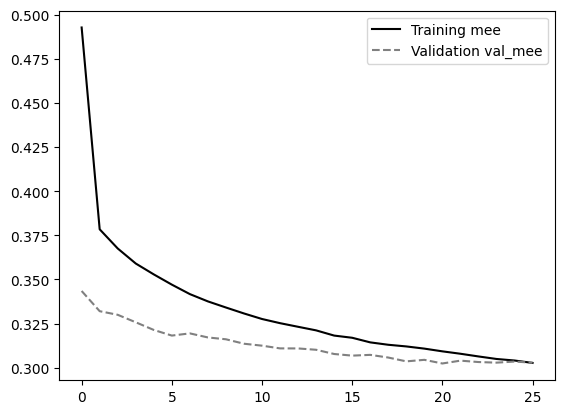

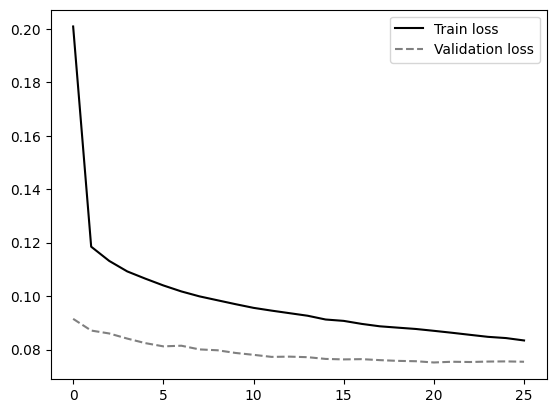

In [33]:
model = grid_search(params, x_train, y_train, k_fold_val)

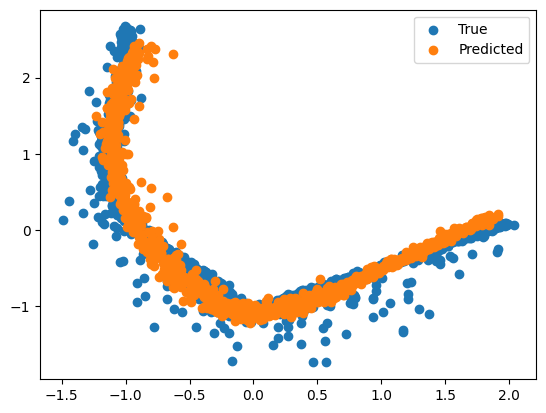

In [40]:
y_pred = model(torch.from_numpy(x_train).to(torch.float32))
y_pred = y_pred.detach().numpy()


# y_train_rescaled = scaler.inverse_transform(y_train)
# print(y_train.shape)

plt.scatter(y_train[:, 0], y_train[:, 1], label="True")
# pred = scaler.inverse_transform(pred)
plt.scatter(y_pred[:, 0], y_pred[:, 1], label = "Predicted")
plt.legend()
plt.show()